# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk
from varseek.utils import make_bus_df, add_variant_type

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "32"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6", "vk_count_out_w37_k41_with_genome_correction")
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_with_genome_correction", "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6")
fastq_files = [os.path.join(fastqs_dir, "ERR204838_1.fastq.gz"), os.path.join(fastqs_dir, "ERR204838_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = True
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = "jmrich@caltech.edu"  # os.environ.get("EMAIL")  #!!! once I reload vscode this will work

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000603111:c.33G>T', 'ENST00000196551:c.348C>A', 'ENST00000304921:c.404A>G', 'ENST00000603344:c.296T>G', 'ENST00000343139:c.271C>G', 'ENST00000603423:c.344C>T', 'ENST00000579721:c.666G>A', 'ENST00000390299:c.269G>A', 'ENST00000603111:c.46T>C', 'ENST00000307569:c.785T>C', 'ENST00000225655:c.745A>G', 'ENST00000262584:c.525A>G', 'ENST00000390243:c.533A>T', 'ENST00000230050:c.472T>C', 'ENST00000605716:c.200A>G', 'ENST00000604973:c.172A>C', 'ENST00000468879:c.292A>T', 'ENST00000253024:c.2471A>C', 'ENST00000468494:c.262A>G', 'ENST00000338970:c.137A>G', 'ENST00000307961:c.1155A>G', 'ENST00000495489:c.196G>A', 'ENST00000238508:c.285_286insA', 'ENST00000309828:c.727T>G', 'ENST00000498435:c.331G>A', 'ENST00000496168:c.477G>A', 'ENST00000604405:c.283C>A', 'ENST00000390277:c.138G>A', 'ENST00000604930:c.355C>A', 'ENST00000311528:c.330G>A', 'ENST00000496168:c.306C>G', 'ENST00000603210:c.188T>G', 'ENST00000253452:c.124T>C', 'ENST00000272317:c.538A>C', 'ENST00000390321:c.62C>T', 'ENST0000025378

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,1821.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5781.0,0.0
23451,1365.0,ENST00000496168.1:c.201G>A,ENST00000496168:c.382G>A,ENST00000496168,ENSG00000243466,1365.0,3425.0,0.0
58590,722.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,267.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
23537,234.0,ENST00000468879.1:c.111A>T,ENST00000468879:c.292A>T,ENST00000468879,ENSG00000242580,234.0,7.0,0.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        disable_summarize=True,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,1821.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5781.0,0.0
23451,1365.0,ENST00000496168.1:c.201G>A,ENST00000496168:c.382G>A,ENST00000496168,ENSG00000243466,1365.0,3425.0,0.0
58590,722.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,267.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
23537,234.0,ENST00000468879.1:c.111A>T,ENST00000468879:c.292A>T,ENST00000468879,ENSG00000242580,234.0,7.0,0.0


From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= 2 and not true_variant
            
        if true_variant:  # >= 2 alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= 2 ref alleles and <2 alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <2 alt alleles and <2 ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

18:54:10: Aligning to genome


19:02:05: SAM --> BAM


19:06:06: BAM sort


[bam_sort_core] merging from 21 files and 1 in-memory blocks...


19:12:52: Remove 256's


19:21:05: BAM index


19:21:26: Entering the loop


  0%|                                                                                                                                                                                               | 0/320 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                                                      | 1/320 [00:01<05:55,  1.11s/it]

  1%|█▏                                                                                                                                                                                     | 2/320 [00:01<04:22,  1.21it/s]

  1%|█▋                                                                                                                                                                                     | 3/320 [00:03<05:44,  1.09s/it]

  1%|██▎                                                                                                                                                                                    | 4/320 [00:04<06:05,  1.16s/it]

  2%|██▊                                                                                                                                                                                    | 5/320 [00:04<04:58,  1.05it/s]

  2%|███▍                                                                                                                                                                                   | 6/320 [00:05<04:19,  1.21it/s]

  2%|████                                                                                                                                                                                   | 7/320 [00:06<04:57,  1.05it/s]

  2%|████▌                                                                                                                                                                                  | 8/320 [00:08<05:32,  1.07s/it]

  3%|█████▏                                                                                                                                                                                 | 9/320 [00:08<04:46,  1.09it/s]

  3%|█████▋                                                                                                                                                                                | 10/320 [00:09<04:32,  1.14it/s]

  3%|██████▎                                                                                                                                                                               | 11/320 [00:10<04:15,  1.21it/s]

  4%|██████▊                                                                                                                                                                               | 12/320 [00:11<04:29,  1.14it/s]

  4%|███████▍                                                                                                                                                                              | 13/320 [00:12<04:59,  1.03it/s]

  4%|███████▉                                                                                                                                                                              | 14/320 [00:13<05:29,  1.08s/it]

  5%|████████▌                                                                                                                                                                             | 15/320 [00:14<04:42,  1.08it/s]

  5%|█████████                                                                                                                                                                             | 16/320 [00:15<04:44,  1.07it/s]

  5%|█████████▋                                                                                                                                                                            | 17/320 [00:15<04:10,  1.21it/s]

  6%|██████████▏                                                                                                                                                                           | 18/320 [00:16<03:48,  1.32it/s]

  6%|██████████▊                                                                                                                                                                           | 19/320 [00:16<03:32,  1.42it/s]

  6%|███████████▍                                                                                                                                                                          | 20/320 [00:17<03:19,  1.50it/s]

  7%|███████████▉                                                                                                                                                                          | 21/320 [00:18<03:11,  1.56it/s]

  7%|████████████▌                                                                                                                                                                         | 22/320 [00:18<03:07,  1.59it/s]

  7%|█████████████                                                                                                                                                                         | 23/320 [00:19<03:20,  1.48it/s]

  8%|█████████████▋                                                                                                                                                                        | 24/320 [00:20<04:08,  1.19it/s]

  8%|██████████████▏                                                                                                                                                                       | 25/320 [00:21<03:44,  1.31it/s]

  8%|██████████████▊                                                                                                                                                                       | 26/320 [00:21<03:32,  1.38it/s]

  8%|███████████████▎                                                                                                                                                                      | 27/320 [00:22<03:20,  1.46it/s]

  9%|███████████████▉                                                                                                                                                                      | 28/320 [00:23<04:03,  1.20it/s]

  9%|████████████████▍                                                                                                                                                                     | 29/320 [00:24<04:02,  1.20it/s]

  9%|█████████████████                                                                                                                                                                     | 30/320 [00:25<03:58,  1.22it/s]

 10%|█████████████████▋                                                                                                                                                                    | 31/320 [00:26<04:30,  1.07it/s]

 10%|██████████████████▏                                                                                                                                                                   | 32/320 [00:27<04:18,  1.11it/s]

 10%|██████████████████▊                                                                                                                                                                   | 33/320 [00:28<04:03,  1.18it/s]

 11%|███████████████████▎                                                                                                                                                                  | 34/320 [00:28<03:40,  1.30it/s]

 11%|███████████████████▉                                                                                                                                                                  | 35/320 [00:29<03:39,  1.30it/s]

 11%|████████████████████▍                                                                                                                                                                 | 36/320 [00:30<03:40,  1.29it/s]

 12%|█████████████████████                                                                                                                                                                 | 37/320 [00:30<03:24,  1.38it/s]

 12%|█████████████████████▌                                                                                                                                                                | 38/320 [00:31<03:12,  1.46it/s]

 12%|██████████████████████▏                                                                                                                                                               | 39/320 [00:32<03:24,  1.38it/s]

 12%|██████████████████████▊                                                                                                                                                               | 40/320 [00:33<03:30,  1.33it/s]

 13%|███████████████████████▎                                                                                                                                                              | 41/320 [00:34<04:06,  1.13it/s]

 13%|███████████████████████▉                                                                                                                                                              | 42/320 [00:34<03:41,  1.26it/s]

 13%|████████████████████████▍                                                                                                                                                             | 43/320 [00:35<03:23,  1.36it/s]

 14%|█████████████████████████                                                                                                                                                             | 44/320 [00:36<03:36,  1.27it/s]

 14%|█████████████████████████▌                                                                                                                                                            | 45/320 [00:36<03:21,  1.37it/s]

 14%|██████████████████████████▏                                                                                                                                                           | 46/320 [00:37<03:09,  1.45it/s]

 15%|██████████████████████████▋                                                                                                                                                           | 47/320 [00:38<02:59,  1.52it/s]

 15%|███████████████████████████▎                                                                                                                                                          | 48/320 [00:38<03:07,  1.45it/s]

 15%|███████████████████████████▊                                                                                                                                                          | 49/320 [00:40<03:58,  1.14it/s]

 16%|████████████████████████████▍                                                                                                                                                         | 50/320 [00:40<03:33,  1.27it/s]

 16%|█████████████████████████████                                                                                                                                                         | 51/320 [00:41<03:16,  1.37it/s]

 16%|█████████████████████████████▌                                                                                                                                                        | 52/320 [00:42<03:53,  1.15it/s]

 17%|██████████████████████████████▏                                                                                                                                                       | 53/320 [00:43<03:27,  1.28it/s]

 17%|██████████████████████████████▋                                                                                                                                                       | 54/320 [00:43<03:14,  1.37it/s]

 17%|███████████████████████████████▎                                                                                                                                                      | 55/320 [00:44<03:18,  1.33it/s]

 18%|███████████████████████████████▊                                                                                                                                                      | 56/320 [00:45<03:07,  1.41it/s]

 18%|████████████████████████████████▍                                                                                                                                                     | 57/320 [00:46<03:20,  1.31it/s]

 18%|████████████████████████████████▉                                                                                                                                                     | 58/320 [00:47<04:19,  1.01it/s]

 18%|█████████████████████████████████▌                                                                                                                                                    | 59/320 [00:48<03:55,  1.11it/s]

 19%|██████████████████████████████████▏                                                                                                                                                   | 60/320 [00:48<03:30,  1.24it/s]

 19%|██████████████████████████████████▋                                                                                                                                                   | 61/320 [00:49<03:31,  1.23it/s]

 19%|███████████████████████████████████▎                                                                                                                                                  | 62/320 [00:50<03:11,  1.35it/s]

 20%|███████████████████████████████████▊                                                                                                                                                  | 63/320 [00:50<02:58,  1.44it/s]

 20%|████████████████████████████████████▍                                                                                                                                                 | 64/320 [00:51<02:54,  1.47it/s]

 20%|████████████████████████████████████▉                                                                                                                                                 | 65/320 [00:52<03:30,  1.21it/s]

 21%|█████████████████████████████████████▌                                                                                                                                                | 66/320 [00:53<03:12,  1.32it/s]

 21%|██████████████████████████████████████                                                                                                                                                | 67/320 [00:53<02:59,  1.41it/s]

 21%|██████████████████████████████████████▋                                                                                                                                               | 68/320 [00:54<03:04,  1.36it/s]

 22%|███████████████████████████████████████▏                                                                                                                                              | 69/320 [00:55<02:51,  1.46it/s]

 22%|███████████████████████████████████████▊                                                                                                                                              | 70/320 [00:55<02:53,  1.44it/s]

 22%|████████████████████████████████████████▍                                                                                                                                             | 71/320 [00:56<02:47,  1.49it/s]

 22%|████████████████████████████████████████▉                                                                                                                                             | 72/320 [00:57<02:55,  1.41it/s]

 23%|█████████████████████████████████████████▌                                                                                                                                            | 73/320 [00:57<02:44,  1.50it/s]

 23%|██████████████████████████████████████████                                                                                                                                            | 74/320 [00:58<02:37,  1.56it/s]

 23%|██████████████████████████████████████████▋                                                                                                                                           | 75/320 [00:59<02:39,  1.53it/s]

 24%|███████████████████████████████████████████▏                                                                                                                                          | 76/320 [00:59<02:34,  1.58it/s]

 24%|███████████████████████████████████████████▊                                                                                                                                          | 77/320 [01:00<02:50,  1.43it/s]

 24%|████████████████████████████████████████████▎                                                                                                                                         | 78/320 [01:01<03:00,  1.34it/s]

 25%|████████████████████████████████████████████▉                                                                                                                                         | 79/320 [01:02<02:52,  1.40it/s]

 25%|█████████████████████████████████████████████▌                                                                                                                                        | 80/320 [01:02<02:58,  1.35it/s]

 25%|██████████████████████████████████████████████                                                                                                                                        | 81/320 [01:03<02:44,  1.45it/s]

 26%|██████████████████████████████████████████████▋                                                                                                                                       | 82/320 [01:04<02:44,  1.44it/s]

 26%|███████████████████████████████████████████████▏                                                                                                                                      | 83/320 [01:05<03:24,  1.16it/s]

 26%|███████████████████████████████████████████████▊                                                                                                                                      | 84/320 [01:06<03:55,  1.00it/s]

 27%|████████████████████████████████████████████████▎                                                                                                                                     | 85/320 [01:07<03:24,  1.15it/s]

 27%|████████████████████████████████████████████████▉                                                                                                                                     | 86/320 [01:08<03:23,  1.15it/s]

 27%|█████████████████████████████████████████████████▍                                                                                                                                    | 87/320 [01:08<03:04,  1.26it/s]

 28%|██████████████████████████████████████████████████                                                                                                                                    | 88/320 [01:09<02:49,  1.37it/s]

 28%|██████████████████████████████████████████████████▌                                                                                                                                   | 89/320 [01:10<02:38,  1.45it/s]

 28%|███████████████████████████████████████████████████▏                                                                                                                                  | 90/320 [01:10<02:31,  1.52it/s]

 28%|███████████████████████████████████████████████████▊                                                                                                                                  | 91/320 [01:11<02:24,  1.58it/s]

 29%|████████████████████████████████████████████████████▎                                                                                                                                 | 92/320 [01:12<03:00,  1.26it/s]

 29%|████████████████████████████████████████████████████▉                                                                                                                                 | 93/320 [01:12<02:46,  1.36it/s]

 29%|█████████████████████████████████████████████████████▍                                                                                                                                | 94/320 [01:13<02:55,  1.28it/s]

 30%|██████████████████████████████████████████████████████                                                                                                                                | 95/320 [01:14<02:50,  1.32it/s]

 30%|██████████████████████████████████████████████████████▌                                                                                                                               | 96/320 [01:15<02:39,  1.41it/s]

 30%|███████████████████████████████████████████████████████▏                                                                                                                              | 97/320 [01:16<03:26,  1.08it/s]

 31%|███████████████████████████████████████████████████████▋                                                                                                                              | 98/320 [01:17<03:05,  1.20it/s]

 31%|████████████████████████████████████████████████████████▎                                                                                                                             | 99/320 [01:18<03:05,  1.19it/s]

 31%|████████████████████████████████████████████████████████▌                                                                                                                            | 100/320 [01:19<03:34,  1.03it/s]

 32%|█████████████████████████████████████████████████████████▏                                                                                                                           | 101/320 [01:20<03:47,  1.04s/it]

 32%|█████████████████████████████████████████████████████████▋                                                                                                                           | 102/320 [01:21<04:07,  1.14s/it]

 32%|██████████████████████████████████████████████████████████▎                                                                                                                          | 103/320 [01:22<03:44,  1.04s/it]

 32%|██████████████████████████████████████████████████████████▊                                                                                                                          | 104/320 [01:23<03:16,  1.10it/s]

 33%|███████████████████████████████████████████████████████████▍                                                                                                                         | 105/320 [01:23<02:54,  1.23it/s]

 33%|███████████████████████████████████████████████████████████▉                                                                                                                         | 106/320 [01:24<02:52,  1.24it/s]

 33%|████████████████████████████████████████████████████████████▌                                                                                                                        | 107/320 [01:25<03:19,  1.07it/s]

 34%|█████████████████████████████████████████████████████████████                                                                                                                        | 108/320 [01:26<02:58,  1.19it/s]

 34%|█████████████████████████████████████████████████████████████▋                                                                                                                       | 109/320 [01:27<03:25,  1.03it/s]

 34%|██████████████████████████████████████████████████████████████▏                                                                                                                      | 110/320 [01:28<03:00,  1.16it/s]

 35%|██████████████████████████████████████████████████████████████▊                                                                                                                      | 111/320 [01:28<02:42,  1.29it/s]

 35%|███████████████████████████████████████████████████████████████▎                                                                                                                     | 112/320 [01:29<02:45,  1.25it/s]

 35%|███████████████████████████████████████████████████████████████▉                                                                                                                     | 113/320 [01:30<02:34,  1.34it/s]

 36%|████████████████████████████████████████████████████████████████▍                                                                                                                    | 114/320 [01:31<02:22,  1.44it/s]

 36%|█████████████████████████████████████████████████████████████████                                                                                                                    | 115/320 [01:31<02:22,  1.44it/s]

 36%|█████████████████████████████████████████████████████████████████▌                                                                                                                   | 116/320 [01:32<02:22,  1.43it/s]

 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                  | 117/320 [01:33<02:14,  1.51it/s]

 37%|██████████████████████████████████████████████████████████████████▋                                                                                                                  | 118/320 [01:33<02:10,  1.55it/s]

 37%|███████████████████████████████████████████████████████████████████▎                                                                                                                 | 119/320 [01:34<02:05,  1.60it/s]

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 120/320 [01:35<02:22,  1.40it/s]

 38%|████████████████████████████████████████████████████████████████████▍                                                                                                                | 121/320 [01:35<02:13,  1.49it/s]

 38%|█████████████████████████████████████████████████████████████████████                                                                                                                | 122/320 [01:36<02:07,  1.55it/s]

 38%|█████████████████████████████████████████████████████████████████████▌                                                                                                               | 123/320 [01:37<02:39,  1.24it/s]

 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                              | 124/320 [01:38<03:00,  1.08it/s]

 39%|██████████████████████████████████████████████████████████████████████▋                                                                                                              | 125/320 [01:39<02:46,  1.17it/s]

 39%|███████████████████████████████████████████████████████████████████████▎                                                                                                             | 126/320 [01:40<03:06,  1.04it/s]

 40%|███████████████████████████████████████████████████████████████████████▊                                                                                                             | 127/320 [01:41<03:23,  1.05s/it]

 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                            | 128/320 [01:42<03:02,  1.05it/s]

 40%|████████████████████████████████████████████████████████████████████████▉                                                                                                            | 129/320 [01:43<02:43,  1.17it/s]

 41%|█████████████████████████████████████████████████████████████████████████▌                                                                                                           | 130/320 [01:44<03:02,  1.04it/s]

 41%|██████████████████████████████████████████████████████████████████████████                                                                                                           | 131/320 [01:45<03:20,  1.06s/it]

 41%|██████████████████████████████████████████████████████████████████████████▋                                                                                                          | 132/320 [01:46<02:54,  1.08it/s]

 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                         | 133/320 [01:46<02:35,  1.21it/s]

 42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                         | 134/320 [01:47<02:19,  1.33it/s]

 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 135/320 [01:48<02:19,  1.32it/s]

 42%|████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 136/320 [01:48<02:09,  1.42it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 137/320 [01:49<02:03,  1.49it/s]

 43%|██████████████████████████████████████████████████████████████████████████████                                                                                                       | 138/320 [01:49<01:57,  1.55it/s]

 43%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 139/320 [01:50<02:04,  1.45it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 140/320 [01:51<01:59,  1.50it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 141/320 [01:51<01:55,  1.55it/s]

 44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 142/320 [01:52<01:50,  1.60it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 143/320 [01:53<01:47,  1.64it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 144/320 [01:53<01:45,  1.66it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                   | 145/320 [01:54<02:16,  1.28it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 146/320 [01:55<02:07,  1.37it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 147/320 [01:56<01:59,  1.45it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 148/320 [01:56<01:52,  1.53it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 149/320 [01:57<01:47,  1.59it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 150/320 [01:57<01:44,  1.63it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 151/320 [01:59<02:11,  1.29it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 152/320 [02:00<02:30,  1.12it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 153/320 [02:00<02:15,  1.23it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████                                                                                              | 154/320 [02:02<02:37,  1.05it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 155/320 [02:02<02:35,  1.06it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 156/320 [02:04<02:47,  1.02s/it]

 49%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 157/320 [02:05<02:37,  1.03it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 158/320 [02:05<02:17,  1.17it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 159/320 [02:06<02:06,  1.28it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 160/320 [02:06<01:57,  1.36it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 161/320 [02:07<01:49,  1.45it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 162/320 [02:08<01:45,  1.49it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 163/320 [02:08<01:52,  1.40it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 164/320 [02:09<01:45,  1.48it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/320 [02:10<01:41,  1.53it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 166/320 [02:10<01:37,  1.58it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 167/320 [02:11<01:34,  1.62it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 168/320 [02:11<01:32,  1.64it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 169/320 [02:12<01:31,  1.66it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 170/320 [02:13<01:30,  1.66it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 171/320 [02:13<01:41,  1.47it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 172/320 [02:14<01:36,  1.53it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 173/320 [02:15<01:33,  1.58it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 174/320 [02:16<02:10,  1.12it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 175/320 [02:17<01:55,  1.25it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 176/320 [02:17<01:47,  1.35it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 177/320 [02:18<01:43,  1.38it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 178/320 [02:19<01:37,  1.46it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 179/320 [02:19<01:32,  1.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 180/320 [02:20<01:36,  1.45it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 181/320 [02:20<01:32,  1.50it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 182/320 [02:21<01:29,  1.55it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 183/320 [02:22<01:29,  1.53it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 184/320 [02:22<01:26,  1.57it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 185/320 [02:23<01:24,  1.60it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 186/320 [02:24<01:49,  1.22it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 187/320 [02:25<01:44,  1.27it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 188/320 [02:26<02:01,  1.08it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 189/320 [02:27<01:48,  1.21it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 190/320 [02:28<02:14,  1.03s/it]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 191/320 [02:29<02:02,  1.05it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 192/320 [02:30<01:47,  1.19it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 193/320 [02:30<01:36,  1.32it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 194/320 [02:31<01:29,  1.40it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 195/320 [02:31<01:24,  1.48it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 196/320 [02:32<01:19,  1.56it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 197/320 [02:33<01:17,  1.58it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 198/320 [02:33<01:16,  1.59it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 199/320 [02:34<01:21,  1.48it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 200/320 [02:35<01:27,  1.37it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 201/320 [02:35<01:22,  1.44it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 202/320 [02:36<01:17,  1.52it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 203/320 [02:37<01:13,  1.58it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 204/320 [02:38<01:33,  1.24it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 205/320 [02:39<01:31,  1.25it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 206/320 [02:40<01:45,  1.08it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 207/320 [02:41<01:54,  1.01s/it]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 208/320 [02:42<01:39,  1.13it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 209/320 [02:43<01:54,  1.03s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 210/320 [02:44<01:39,  1.10it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 211/320 [02:44<01:27,  1.24it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 212/320 [02:45<01:19,  1.36it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 213/320 [02:46<01:27,  1.22it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 214/320 [02:46<01:20,  1.32it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 215/320 [02:47<01:14,  1.41it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 216/320 [02:48<01:10,  1.47it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 217/320 [02:48<01:07,  1.54it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 218/320 [02:49<01:04,  1.59it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 219/320 [02:49<01:01,  1.63it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 220/320 [02:51<01:18,  1.27it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 221/320 [02:51<01:12,  1.36it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 222/320 [02:52<01:15,  1.31it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 223/320 [02:53<01:15,  1.29it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 224/320 [02:53<01:08,  1.40it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 225/320 [02:55<01:21,  1.17it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 226/320 [02:55<01:12,  1.29it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 227/320 [02:56<01:06,  1.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 228/320 [02:56<01:02,  1.48it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 229/320 [02:57<00:58,  1.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 230/320 [02:57<00:56,  1.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 231/320 [02:58<00:54,  1.63it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 232/320 [02:59<00:52,  1.67it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 233/320 [02:59<00:51,  1.69it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 234/320 [03:00<00:55,  1.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 235/320 [03:01<00:57,  1.49it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 236/320 [03:01<00:54,  1.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 237/320 [03:02<00:52,  1.59it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 238/320 [03:02<00:50,  1.63it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 239/320 [03:03<00:54,  1.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 240/320 [03:04<00:51,  1.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 241/320 [03:04<00:49,  1.61it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 242/320 [03:05<00:47,  1.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 243/320 [03:06<00:51,  1.50it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 244/320 [03:06<00:48,  1.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 245/320 [03:07<00:46,  1.62it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 246/320 [03:07<00:45,  1.64it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 247/320 [03:08<00:43,  1.66it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 248/320 [03:09<00:42,  1.69it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 249/320 [03:09<00:41,  1.71it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 250/320 [03:10<00:40,  1.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 251/320 [03:10<00:40,  1.71it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 252/320 [03:11<00:39,  1.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 253/320 [03:11<00:38,  1.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 254/320 [03:12<00:38,  1.73it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 255/320 [03:13<00:37,  1.73it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 256/320 [03:13<00:36,  1.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 257/320 [03:14<00:36,  1.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 258/320 [03:14<00:35,  1.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 259/320 [03:15<00:35,  1.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 260/320 [03:16<00:34,  1.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 261/320 [03:16<00:34,  1.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 262/320 [03:17<00:33,  1.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 263/320 [03:17<00:33,  1.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 264/320 [03:18<00:32,  1.72it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 265/320 [03:18<00:32,  1.72it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 266/320 [03:19<00:32,  1.65it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 267/320 [03:20<00:31,  1.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 268/320 [03:21<00:35,  1.48it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 269/320 [03:21<00:32,  1.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 270/320 [03:22<00:31,  1.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 271/320 [03:22<00:32,  1.52it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 272/320 [03:23<00:30,  1.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 273/320 [03:24<00:38,  1.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 274/320 [03:26<00:43,  1.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 275/320 [03:26<00:40,  1.12it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 276/320 [03:27<00:35,  1.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 277/320 [03:27<00:31,  1.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 278/320 [03:29<00:36,  1.16it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 279/320 [03:30<00:39,  1.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 280/320 [03:31<00:44,  1.12s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 281/320 [03:32<00:44,  1.14s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 282/320 [03:33<00:36,  1.03it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 283/320 [03:34<00:38,  1.04s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 284/320 [03:35<00:38,  1.08s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 285/320 [03:37<00:39,  1.12s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 286/320 [03:37<00:32,  1.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 287/320 [03:38<00:27,  1.19it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 288/320 [03:38<00:24,  1.31it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 289/320 [03:39<00:21,  1.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 290/320 [03:40<00:20,  1.50it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 291/320 [03:41<00:23,  1.21it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 292/320 [03:42<00:23,  1.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 293/320 [03:42<00:20,  1.29it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 294/320 [03:43<00:18,  1.40it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 295/320 [03:43<00:17,  1.39it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 296/320 [03:44<00:16,  1.47it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 297/320 [03:45<00:15,  1.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 298/320 [03:46<00:18,  1.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 299/320 [03:46<00:15,  1.33it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 300/320 [03:47<00:14,  1.42it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 301/320 [03:48<00:12,  1.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 302/320 [03:48<00:11,  1.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 303/320 [03:49<00:10,  1.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 304/320 [03:49<00:09,  1.63it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 305/320 [03:50<00:08,  1.67it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 306/320 [03:51<00:08,  1.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 307/320 [03:52<00:10,  1.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 308/320 [03:52<00:08,  1.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 309/320 [03:53<00:07,  1.45it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 310/320 [03:54<00:06,  1.52it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 311/320 [03:54<00:05,  1.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 312/320 [03:55<00:05,  1.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 313/320 [03:56<00:04,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 315/320 [03:56<00:02,  1.96it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 316/320 [03:57<00:02,  1.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 317/320 [03:57<00:01,  1.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 318/320 [03:58<00:01,  1.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 319/320 [03:59<00:00,  1.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [04:00<00:00,  1.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [04:00<00:00,  1.33it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 221
Number of false variants: 97
Number of undetermined variants: 1
True variants list: ['ENST00000390312:c.218G>A', 'ENST00000496168:c.382G>A', 'ENST00000579721:c.142G>A', 'ENST00000603423:c.137G>A', 'ENST00000390309:c.359A>G', 'ENST00000603600:c.285G>A', 'ENST00000604412:c.415T>A', 'ENST00000483158:c.199G>C', 'ENST00000453673:c.105G>A', 'ENST00000390634:c.191C>T', 'ENST00000390309:c.195G>A', 'ENST00000603344:c.296T>G', 'ENST00000604930:c.373G>A', 'ENST00000390290:c.183G>A', 'ENST00000390319:c.261G>A', 'ENST00000390290:c.299G>A', 'ENST00000390319:c.197A>G', 'ENST00000390305:c.182C>T', 'ENST00000390299:c.228G>A', 'ENST00000496168:c.391C>T', 'ENST00000390299:c.269G>A', 'ENST00000390243:c.300A>G', 'ENST00000605716:c.222G>T', 'ENST00000468494:c.262A>G', 'ENST00000483158:c.195A>G', 'ENST00000354689:c.83C>T', 'ENST00000603600:c.205C>A', 'ENST00000483379:c.462C>T', 'ENST00000496168:c.405G>A', 'ENST00000604045:c.277C>T', 'ENST00000390319:c.99G>C', 'ENST00000390237:c.2

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_with_genome_correction/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_with_genome_correction/detailed_out_modified_bam.txt


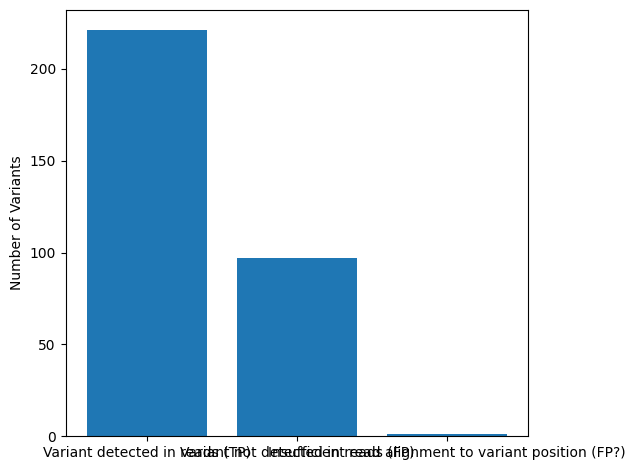

In [16]:
def plot_overall_bar_plot(overall_results, out_file=None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": len(true_variants),
    "Variant not detected in reads (FP)": len(false_variants),
    "Insufficient read alignment to variant position (FP?)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, out_file=overall_txt_out.replace(".txt", ".pdf"))

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

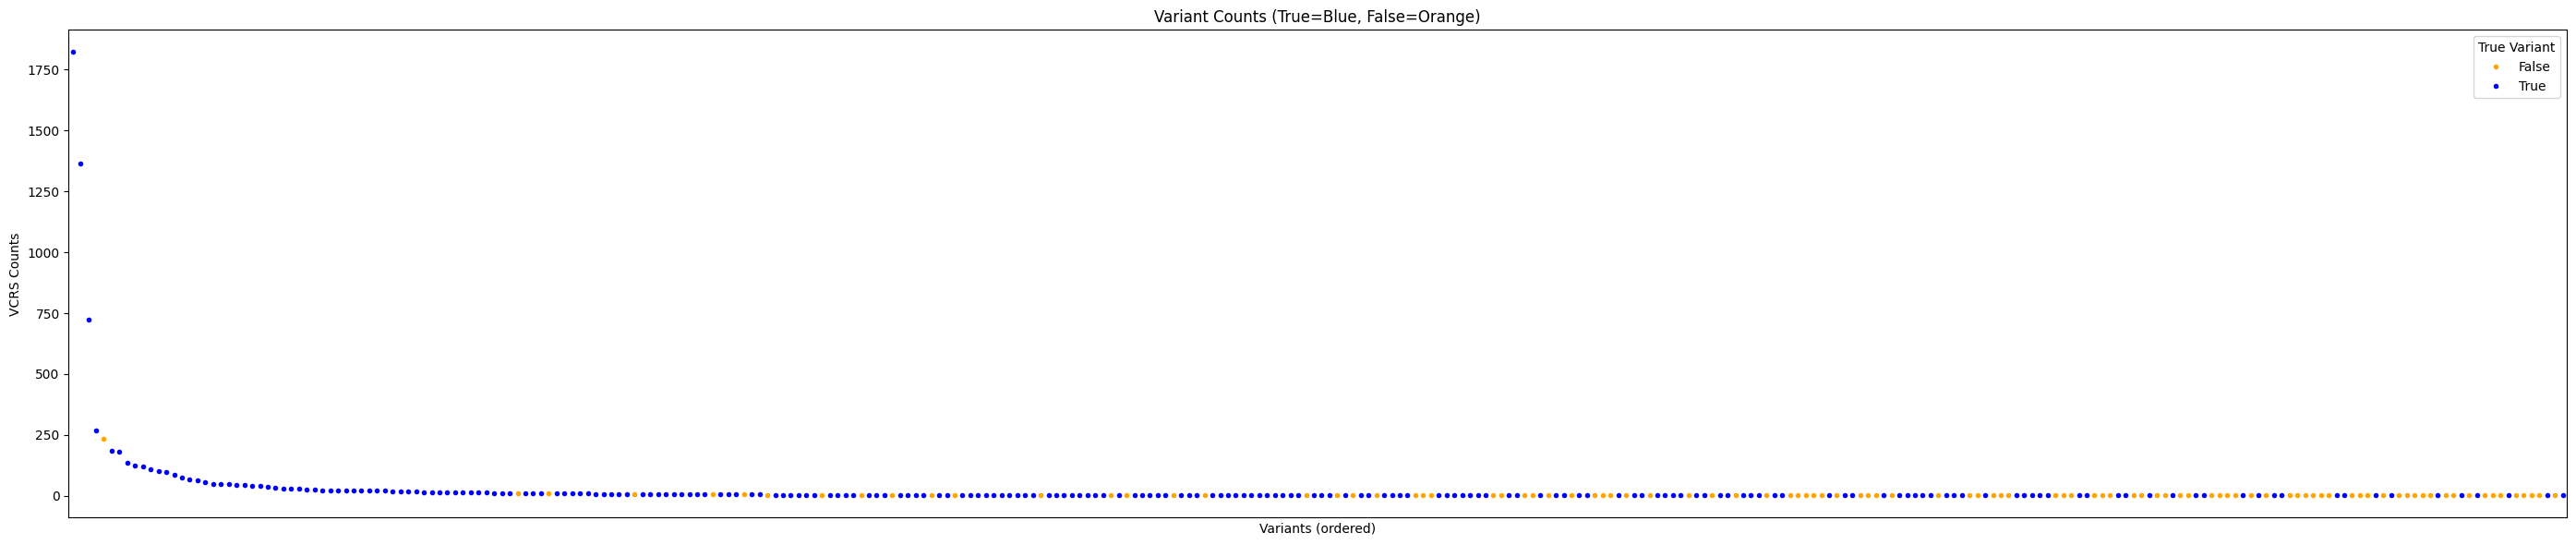

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(notebook_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [19]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [20]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [21]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [22]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [23]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_with_genome_correction", "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [24]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [25]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [26]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs28507236,ENST00000379407,c.528A>C,+,ENST00000379407:c.528A>C,True,vcrs_0
1,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_1
2,rs3829739,ENST00000379407,c.1389A>G,+,ENST00000379407:c.1389A>G,True,vcrs_2
3,rs12184,ENST00000378567,c.425T>C,+,ENST00000378567:c.425T>C,True,vcrs_3
4,rs41315312,ENST00000294600,c.211C>T,+,ENST00000294600:c.211C>T,True,vcrs_4


In [27]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= 2 and not true_variant
            
        if true_variant:  # >= 2 alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= 2 ref alleles and <2 alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <2 alt alleles and <2 ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

19:25:37: Entering the loop


  0%|                                                                                                                                                                                              | 0/3275 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                      | 1/3275 [00:00<54:07,  1.01it/s]

  0%|                                                                                                                                                                                      | 2/3275 [00:01<40:45,  1.34it/s]

  0%|▏                                                                                                                                                                                     | 3/3275 [00:02<36:03,  1.51it/s]

  0%|▏                                                                                                                                                                                     | 4/3275 [00:02<34:11,  1.59it/s]

  0%|▎                                                                                                                                                                                     | 5/3275 [00:03<33:04,  1.65it/s]

  0%|▎                                                                                                                                                                                     | 6/3275 [00:03<32:31,  1.67it/s]

  0%|▍                                                                                                                                                                                     | 7/3275 [00:04<32:06,  1.70it/s]

  0%|▍                                                                                                                                                                                     | 8/3275 [00:04<31:43,  1.72it/s]

  0%|▌                                                                                                                                                                                     | 9/3275 [00:05<31:35,  1.72it/s]

  0%|▌                                                                                                                                                                                    | 10/3275 [00:06<31:24,  1.73it/s]

  0%|▌                                                                                                                                                                                    | 11/3275 [00:06<31:38,  1.72it/s]

  0%|▋                                                                                                                                                                                    | 12/3275 [00:07<31:26,  1.73it/s]

  0%|▋                                                                                                                                                                                    | 13/3275 [00:07<31:19,  1.74it/s]

  0%|▊                                                                                                                                                                                    | 14/3275 [00:08<31:20,  1.73it/s]

  0%|▊                                                                                                                                                                                    | 15/3275 [00:09<31:24,  1.73it/s]

  0%|▉                                                                                                                                                                                    | 16/3275 [00:09<32:55,  1.65it/s]

  1%|▉                                                                                                                                                                                    | 17/3275 [00:10<32:24,  1.68it/s]

  1%|▉                                                                                                                                                                                    | 18/3275 [00:10<32:03,  1.69it/s]

  1%|█                                                                                                                                                                                    | 19/3275 [00:11<31:47,  1.71it/s]

  1%|█                                                                                                                                                                                    | 20/3275 [00:12<31:33,  1.72it/s]

  1%|█▏                                                                                                                                                                                   | 21/3275 [00:12<31:22,  1.73it/s]

  1%|█▏                                                                                                                                                                                   | 22/3275 [00:13<31:15,  1.73it/s]

  1%|█▎                                                                                                                                                                                   | 23/3275 [00:13<31:07,  1.74it/s]

  1%|█▎                                                                                                                                                                                   | 24/3275 [00:14<31:11,  1.74it/s]

  1%|█▍                                                                                                                                                                                   | 25/3275 [00:14<31:52,  1.70it/s]

  1%|█▍                                                                                                                                                                                   | 26/3275 [00:15<34:39,  1.56it/s]

  1%|█▍                                                                                                                                                                                   | 27/3275 [00:16<33:26,  1.62it/s]

  1%|█▌                                                                                                                                                                                   | 28/3275 [00:17<43:21,  1.25it/s]

  1%|█▌                                                                                                                                                                                   | 29/3275 [00:18<40:14,  1.34it/s]

  1%|█▋                                                                                                                                                                                   | 30/3275 [00:18<37:26,  1.44it/s]

  1%|█▋                                                                                                                                                                                   | 31/3275 [00:19<35:28,  1.52it/s]

  1%|█▊                                                                                                                                                                                   | 32/3275 [00:19<34:07,  1.58it/s]

  1%|█▊                                                                                                                                                                                   | 33/3275 [00:20<33:10,  1.63it/s]

  1%|█▉                                                                                                                                                                                   | 34/3275 [00:20<32:31,  1.66it/s]

  1%|█▉                                                                                                                                                                                   | 35/3275 [00:21<31:59,  1.69it/s]

  1%|█▉                                                                                                                                                                                   | 36/3275 [00:22<31:38,  1.71it/s]

  1%|██                                                                                                                                                                                   | 37/3275 [00:22<31:24,  1.72it/s]

  1%|██                                                                                                                                                                                   | 38/3275 [00:23<31:14,  1.73it/s]

  1%|██▏                                                                                                                                                                                  | 39/3275 [00:23<31:11,  1.73it/s]

  1%|██▏                                                                                                                                                                                  | 40/3275 [00:24<31:15,  1.72it/s]

  1%|██▎                                                                                                                                                                                  | 41/3275 [00:24<31:00,  1.74it/s]

  1%|██▎                                                                                                                                                                                  | 42/3275 [00:25<30:59,  1.74it/s]

  1%|██▍                                                                                                                                                                                  | 43/3275 [00:26<30:42,  1.75it/s]

  1%|██▍                                                                                                                                                                                  | 44/3275 [00:26<30:42,  1.75it/s]

  1%|██▍                                                                                                                                                                                  | 45/3275 [00:27<30:39,  1.76it/s]

  1%|██▌                                                                                                                                                                                  | 46/3275 [00:27<30:32,  1.76it/s]

  1%|██▌                                                                                                                                                                                  | 47/3275 [00:28<30:47,  1.75it/s]

  1%|██▋                                                                                                                                                                                  | 48/3275 [00:28<30:51,  1.74it/s]

  1%|██▋                                                                                                                                                                                  | 49/3275 [00:29<31:02,  1.73it/s]

  2%|██▊                                                                                                                                                                                  | 50/3275 [00:30<30:54,  1.74it/s]

  2%|██▊                                                                                                                                                                                  | 51/3275 [00:30<30:53,  1.74it/s]

  2%|██▊                                                                                                                                                                                  | 52/3275 [00:31<30:47,  1.74it/s]

  2%|██▉                                                                                                                                                                                  | 53/3275 [00:31<30:48,  1.74it/s]

  2%|██▉                                                                                                                                                                                  | 54/3275 [00:32<30:46,  1.74it/s]

  2%|███                                                                                                                                                                                  | 55/3275 [00:32<30:42,  1.75it/s]

  2%|███                                                                                                                                                                                  | 56/3275 [00:33<30:39,  1.75it/s]

  2%|███▏                                                                                                                                                                                 | 57/3275 [00:34<31:01,  1.73it/s]

  2%|███▏                                                                                                                                                                                 | 58/3275 [00:34<30:44,  1.74it/s]

  2%|███▎                                                                                                                                                                                 | 59/3275 [00:35<30:38,  1.75it/s]

  2%|███▎                                                                                                                                                                                 | 60/3275 [00:35<30:38,  1.75it/s]

  2%|███▍                                                                                                                                                                                 | 62/3275 [00:36<23:39,  2.26it/s]

  2%|███▍                                                                                                                                                                                 | 63/3275 [00:36<25:16,  2.12it/s]

  2%|███▌                                                                                                                                                                                 | 64/3275 [00:37<27:20,  1.96it/s]

  2%|███▌                                                                                                                                                                                 | 65/3275 [00:38<28:28,  1.88it/s]

  2%|███▋                                                                                                                                                                                 | 67/3275 [00:38<22:37,  2.36it/s]

  2%|███▊                                                                                                                                                                                 | 68/3275 [00:39<24:28,  2.18it/s]

  2%|███▊                                                                                                                                                                                 | 69/3275 [00:39<25:53,  2.06it/s]

  2%|███▊                                                                                                                                                                                 | 70/3275 [00:40<27:07,  1.97it/s]

  2%|███▉                                                                                                                                                                                 | 71/3275 [00:41<28:10,  1.89it/s]

  2%|███▉                                                                                                                                                                                 | 72/3275 [00:41<29:00,  1.84it/s]

  2%|████                                                                                                                                                                                 | 73/3275 [00:42<29:22,  1.82it/s]

  2%|████                                                                                                                                                                                 | 74/3275 [00:42<29:31,  1.81it/s]

  2%|████▏                                                                                                                                                                                | 75/3275 [00:43<39:12,  1.36it/s]

  2%|████▎                                                                                                                                                                                | 77/3275 [00:44<28:18,  1.88it/s]

  2%|████▎                                                                                                                                                                                | 78/3275 [00:45<28:44,  1.85it/s]

  2%|████▎                                                                                                                                                                                | 79/3275 [00:45<29:18,  1.82it/s]

  2%|████▍                                                                                                                                                                                | 80/3275 [00:46<32:35,  1.63it/s]

  2%|████▍                                                                                                                                                                                | 81/3275 [00:46<32:00,  1.66it/s]

  3%|████▌                                                                                                                                                                                | 82/3275 [00:47<31:28,  1.69it/s]

  3%|████▌                                                                                                                                                                                | 83/3275 [00:48<31:37,  1.68it/s]

  3%|████▋                                                                                                                                                                                | 84/3275 [00:48<31:13,  1.70it/s]

  3%|████▋                                                                                                                                                                                | 85/3275 [00:49<30:59,  1.72it/s]

  3%|████▊                                                                                                                                                                                | 86/3275 [00:49<30:43,  1.73it/s]

  3%|████▊                                                                                                                                                                                | 87/3275 [00:50<30:26,  1.75it/s]

  3%|████▊                                                                                                                                                                                | 88/3275 [00:51<30:44,  1.73it/s]

  3%|████▉                                                                                                                                                                                | 89/3275 [00:51<30:34,  1.74it/s]

  3%|████▉                                                                                                                                                                                | 90/3275 [00:52<30:31,  1.74it/s]

  3%|█████                                                                                                                                                                                | 91/3275 [00:52<30:29,  1.74it/s]

  3%|█████                                                                                                                                                                                | 92/3275 [00:53<30:24,  1.74it/s]

  3%|█████▏                                                                                                                                                                               | 93/3275 [00:53<30:30,  1.74it/s]

  3%|█████▏                                                                                                                                                                               | 94/3275 [00:54<30:25,  1.74it/s]

  3%|█████▎                                                                                                                                                                               | 95/3275 [00:55<30:16,  1.75it/s]

  3%|█████▎                                                                                                                                                                               | 96/3275 [00:55<30:14,  1.75it/s]

  3%|█████▎                                                                                                                                                                               | 97/3275 [00:56<30:30,  1.74it/s]

  3%|█████▍                                                                                                                                                                               | 98/3275 [00:56<30:30,  1.74it/s]

  3%|█████▍                                                                                                                                                                               | 99/3275 [00:57<30:14,  1.75it/s]

  3%|█████▍                                                                                                                                                                              | 100/3275 [00:57<30:25,  1.74it/s]

  3%|█████▌                                                                                                                                                                              | 101/3275 [00:58<30:20,  1.74it/s]

  3%|█████▌                                                                                                                                                                              | 102/3275 [00:59<30:18,  1.74it/s]

  3%|█████▋                                                                                                                                                                              | 103/3275 [00:59<30:17,  1.75it/s]

  3%|█████▋                                                                                                                                                                              | 104/3275 [01:00<30:22,  1.74it/s]

  3%|█████▊                                                                                                                                                                              | 105/3275 [01:00<30:16,  1.74it/s]

  3%|█████▊                                                                                                                                                                              | 106/3275 [01:01<30:33,  1.73it/s]

  3%|█████▉                                                                                                                                                                              | 107/3275 [01:01<30:25,  1.74it/s]

  3%|█████▉                                                                                                                                                                              | 108/3275 [01:02<33:27,  1.58it/s]

  3%|█████▉                                                                                                                                                                              | 109/3275 [01:03<32:37,  1.62it/s]

  3%|██████                                                                                                                                                                              | 110/3275 [01:03<31:55,  1.65it/s]

  3%|██████                                                                                                                                                                              | 111/3275 [01:04<31:20,  1.68it/s]

  3%|██████▏                                                                                                                                                                             | 112/3275 [01:04<31:01,  1.70it/s]

  3%|██████▏                                                                                                                                                                             | 113/3275 [01:05<30:46,  1.71it/s]

  3%|██████▎                                                                                                                                                                             | 114/3275 [01:06<30:30,  1.73it/s]

  4%|██████▎                                                                                                                                                                             | 115/3275 [01:06<30:26,  1.73it/s]

  4%|██████▍                                                                                                                                                                             | 116/3275 [01:07<30:19,  1.74it/s]

  4%|██████▍                                                                                                                                                                             | 117/3275 [01:07<30:22,  1.73it/s]

  4%|██████▍                                                                                                                                                                             | 118/3275 [01:08<30:15,  1.74it/s]

  4%|██████▌                                                                                                                                                                             | 119/3275 [01:08<30:05,  1.75it/s]

  4%|██████▋                                                                                                                                                                             | 121/3275 [01:09<23:10,  2.27it/s]

  4%|██████▋                                                                                                                                                                             | 122/3275 [01:10<24:45,  2.12it/s]

  4%|██████▊                                                                                                                                                                             | 123/3275 [01:10<26:07,  2.01it/s]

  4%|██████▊                                                                                                                                                                             | 124/3275 [01:11<27:18,  1.92it/s]

  4%|██████▊                                                                                                                                                                             | 125/3275 [01:11<28:16,  1.86it/s]

  4%|██████▉                                                                                                                                                                             | 126/3275 [01:12<28:50,  1.82it/s]

  4%|██████▉                                                                                                                                                                             | 127/3275 [01:13<29:10,  1.80it/s]

  4%|███████                                                                                                                                                                             | 128/3275 [01:13<29:25,  1.78it/s]

  4%|███████                                                                                                                                                                             | 129/3275 [01:14<29:53,  1.75it/s]

  4%|███████▏                                                                                                                                                                            | 130/3275 [01:14<29:58,  1.75it/s]

  4%|███████▏                                                                                                                                                                            | 131/3275 [01:15<30:08,  1.74it/s]

  4%|███████▎                                                                                                                                                                            | 132/3275 [01:15<30:01,  1.74it/s]

  4%|███████▎                                                                                                                                                                            | 133/3275 [01:16<30:05,  1.74it/s]

  4%|███████▎                                                                                                                                                                            | 134/3275 [01:17<29:55,  1.75it/s]

  4%|███████▍                                                                                                                                                                            | 135/3275 [01:17<29:54,  1.75it/s]

  4%|███████▍                                                                                                                                                                            | 136/3275 [01:18<29:49,  1.75it/s]

  4%|███████▌                                                                                                                                                                            | 137/3275 [01:18<29:46,  1.76it/s]

  4%|███████▌                                                                                                                                                                            | 138/3275 [01:19<29:46,  1.76it/s]

  4%|███████▋                                                                                                                                                                            | 139/3275 [01:19<30:06,  1.74it/s]

  4%|███████▋                                                                                                                                                                            | 140/3275 [01:20<30:00,  1.74it/s]

  4%|███████▋                                                                                                                                                                            | 141/3275 [01:21<29:50,  1.75it/s]

  4%|███████▊                                                                                                                                                                            | 142/3275 [01:21<29:49,  1.75it/s]

  4%|███████▊                                                                                                                                                                            | 143/3275 [01:22<29:43,  1.76it/s]

  4%|███████▉                                                                                                                                                                            | 144/3275 [01:22<29:48,  1.75it/s]

  4%|███████▉                                                                                                                                                                            | 145/3275 [01:23<30:01,  1.74it/s]

  4%|████████                                                                                                                                                                            | 146/3275 [01:23<29:57,  1.74it/s]

  4%|████████                                                                                                                                                                            | 147/3275 [01:24<29:55,  1.74it/s]

  5%|████████▏                                                                                                                                                                           | 148/3275 [01:25<29:52,  1.74it/s]

  5%|████████▏                                                                                                                                                                           | 149/3275 [01:25<29:56,  1.74it/s]

  5%|████████▏                                                                                                                                                                           | 150/3275 [01:26<29:48,  1.75it/s]

  5%|████████▎                                                                                                                                                                           | 151/3275 [01:26<29:43,  1.75it/s]

  5%|████████▎                                                                                                                                                                           | 152/3275 [01:27<29:43,  1.75it/s]

  5%|████████▍                                                                                                                                                                           | 153/3275 [01:27<29:57,  1.74it/s]

  5%|████████▌                                                                                                                                                                           | 155/3275 [01:28<22:59,  2.26it/s]

  5%|████████▌                                                                                                                                                                           | 156/3275 [01:29<24:42,  2.10it/s]

  5%|████████▋                                                                                                                                                                           | 157/3275 [01:29<25:55,  2.01it/s]

  5%|████████▋                                                                                                                                                                           | 158/3275 [01:30<26:53,  1.93it/s]

  5%|████████▋                                                                                                                                                                           | 159/3275 [01:30<27:38,  1.88it/s]

  5%|████████▊                                                                                                                                                                           | 160/3275 [01:31<28:13,  1.84it/s]

  5%|████████▊                                                                                                                                                                           | 161/3275 [01:31<28:34,  1.82it/s]

  5%|████████▉                                                                                                                                                                           | 162/3275 [01:32<28:45,  1.80it/s]

  5%|████████▉                                                                                                                                                                           | 163/3275 [01:33<28:52,  1.80it/s]

  5%|█████████                                                                                                                                                                           | 164/3275 [01:33<29:02,  1.78it/s]

  5%|█████████                                                                                                                                                                           | 165/3275 [01:34<29:02,  1.78it/s]

  5%|█████████                                                                                                                                                                           | 166/3275 [01:34<31:17,  1.66it/s]

  5%|█████████▏                                                                                                                                                                          | 167/3275 [01:36<43:29,  1.19it/s]

  5%|█████████▏                                                                                                                                                                          | 168/3275 [01:37<50:13,  1.03it/s]

  5%|█████████▎                                                                                                                                                                          | 169/3275 [01:38<55:08,  1.07s/it]

  5%|█████████▎                                                                                                                                                                          | 170/3275 [01:40<57:33,  1.11s/it]

  5%|█████████▍                                                                                                                                                                          | 171/3275 [01:41<58:47,  1.14s/it]

  5%|█████████▍                                                                                                                                                                          | 172/3275 [01:42<59:32,  1.15s/it]

  5%|█████████▍                                                                                                                                                                        | 173/3275 [01:43<1:00:11,  1.16s/it]

  5%|█████████▍                                                                                                                                                                        | 174/3275 [01:44<1:00:31,  1.17s/it]

  5%|█████████▌                                                                                                                                                                        | 175/3275 [01:45<1:00:19,  1.17s/it]

  5%|█████████▌                                                                                                                                                                        | 176/3275 [01:47<1:00:51,  1.18s/it]

  5%|█████████▋                                                                                                                                                                          | 177/3275 [01:47<51:28,  1.00it/s]

  5%|█████████▊                                                                                                                                                                          | 178/3275 [01:48<44:48,  1.15it/s]

  5%|█████████▉                                                                                                                                                                          | 180/3275 [01:49<33:42,  1.53it/s]

  6%|█████████▉                                                                                                                                                                          | 181/3275 [01:49<32:35,  1.58it/s]

  6%|██████████                                                                                                                                                                          | 182/3275 [01:50<34:18,  1.50it/s]

  6%|██████████                                                                                                                                                                          | 183/3275 [01:51<32:51,  1.57it/s]

  6%|██████████                                                                                                                                                                          | 184/3275 [01:51<32:48,  1.57it/s]

  6%|██████████▏                                                                                                                                                                         | 185/3275 [01:52<31:57,  1.61it/s]

  6%|██████████▏                                                                                                                                                                         | 186/3275 [01:52<31:10,  1.65it/s]

  6%|██████████▎                                                                                                                                                                         | 187/3275 [01:53<30:38,  1.68it/s]

  6%|██████████▎                                                                                                                                                                         | 188/3275 [01:53<30:11,  1.70it/s]

  6%|██████████▍                                                                                                                                                                         | 189/3275 [01:54<29:56,  1.72it/s]

  6%|██████████▍                                                                                                                                                                         | 190/3275 [01:55<29:42,  1.73it/s]

  6%|██████████▍                                                                                                                                                                         | 191/3275 [01:55<29:36,  1.74it/s]

  6%|██████████▌                                                                                                                                                                         | 192/3275 [01:56<29:31,  1.74it/s]

  6%|██████████▌                                                                                                                                                                         | 193/3275 [01:56<29:21,  1.75it/s]

  6%|██████████▋                                                                                                                                                                         | 194/3275 [01:57<29:23,  1.75it/s]

  6%|██████████▋                                                                                                                                                                         | 195/3275 [01:57<29:22,  1.75it/s]

  6%|██████████▊                                                                                                                                                                         | 196/3275 [01:58<29:20,  1.75it/s]

  6%|██████████▊                                                                                                                                                                         | 197/3275 [01:59<29:14,  1.75it/s]

  6%|██████████▉                                                                                                                                                                         | 198/3275 [01:59<29:21,  1.75it/s]

  6%|██████████▉                                                                                                                                                                         | 199/3275 [02:00<29:31,  1.74it/s]

  6%|██████████▉                                                                                                                                                                         | 200/3275 [02:00<29:26,  1.74it/s]

  6%|███████████                                                                                                                                                                         | 201/3275 [02:01<29:35,  1.73it/s]

  6%|███████████                                                                                                                                                                         | 202/3275 [02:01<29:25,  1.74it/s]

  6%|███████████▏                                                                                                                                                                        | 203/3275 [02:02<29:17,  1.75it/s]

  6%|███████████▏                                                                                                                                                                        | 204/3275 [02:03<29:13,  1.75it/s]

  6%|███████████▎                                                                                                                                                                        | 205/3275 [02:03<29:07,  1.76it/s]

  6%|███████████▎                                                                                                                                                                        | 206/3275 [02:04<29:11,  1.75it/s]

  6%|███████████▍                                                                                                                                                                        | 207/3275 [02:04<29:09,  1.75it/s]

  6%|███████████▍                                                                                                                                                                        | 208/3275 [02:05<29:06,  1.76it/s]

  6%|███████████▍                                                                                                                                                                        | 209/3275 [02:05<29:07,  1.75it/s]

  6%|███████████▌                                                                                                                                                                        | 210/3275 [02:06<29:06,  1.76it/s]

  6%|███████████▌                                                                                                                                                                        | 211/3275 [02:07<29:05,  1.76it/s]

  6%|███████████▋                                                                                                                                                                        | 212/3275 [02:07<29:07,  1.75it/s]

  7%|███████████▋                                                                                                                                                                        | 213/3275 [02:08<29:09,  1.75it/s]

  7%|███████████▊                                                                                                                                                                        | 214/3275 [02:08<29:04,  1.75it/s]

  7%|███████████▊                                                                                                                                                                        | 215/3275 [02:09<29:04,  1.75it/s]

  7%|███████████▉                                                                                                                                                                        | 217/3275 [02:09<22:18,  2.28it/s]

  7%|███████████▉                                                                                                                                                                        | 218/3275 [02:10<24:14,  2.10it/s]

  7%|████████████                                                                                                                                                                        | 219/3275 [02:11<25:24,  2.01it/s]

  7%|████████████                                                                                                                                                                        | 220/3275 [02:11<26:15,  1.94it/s]

  7%|████████████▏                                                                                                                                                                       | 221/3275 [02:12<27:02,  1.88it/s]

  7%|████████████▏                                                                                                                                                                       | 222/3275 [02:12<27:35,  1.84it/s]

  7%|████████████▎                                                                                                                                                                       | 223/3275 [02:13<27:56,  1.82it/s]

  7%|████████████▎                                                                                                                                                                       | 224/3275 [02:13<28:15,  1.80it/s]

  7%|████████████▎                                                                                                                                                                       | 225/3275 [02:14<28:27,  1.79it/s]

  7%|████████████▍                                                                                                                                                                       | 226/3275 [02:15<28:31,  1.78it/s]

  7%|████████████▍                                                                                                                                                                       | 227/3275 [02:15<28:44,  1.77it/s]

  7%|████████████▌                                                                                                                                                                       | 228/3275 [02:16<28:44,  1.77it/s]

  7%|████████████▌                                                                                                                                                                       | 229/3275 [02:16<28:51,  1.76it/s]

  7%|████████████▋                                                                                                                                                                       | 230/3275 [02:17<29:06,  1.74it/s]

  7%|████████████▋                                                                                                                                                                       | 231/3275 [02:17<29:11,  1.74it/s]

  7%|████████████▊                                                                                                                                                                       | 232/3275 [02:18<29:05,  1.74it/s]

  7%|████████████▊                                                                                                                                                                       | 233/3275 [02:19<29:08,  1.74it/s]

  7%|████████████▊                                                                                                                                                                       | 234/3275 [02:19<29:08,  1.74it/s]

  7%|████████████▉                                                                                                                                                                       | 235/3275 [02:20<29:19,  1.73it/s]

  7%|████████████▉                                                                                                                                                                       | 236/3275 [02:20<29:05,  1.74it/s]

  7%|█████████████                                                                                                                                                                       | 238/3275 [02:21<22:22,  2.26it/s]

  7%|█████████████▏                                                                                                                                                                      | 239/3275 [02:21<24:15,  2.09it/s]

  7%|█████████████▏                                                                                                                                                                      | 240/3275 [02:22<25:23,  1.99it/s]

  7%|█████████████▏                                                                                                                                                                      | 241/3275 [02:23<26:21,  1.92it/s]

  7%|█████████████▎                                                                                                                                                                      | 243/3275 [02:23<21:07,  2.39it/s]

  7%|█████████████▍                                                                                                                                                                      | 244/3275 [02:24<22:51,  2.21it/s]

  7%|█████████████▍                                                                                                                                                                      | 245/3275 [02:24<24:27,  2.06it/s]

  8%|█████████████▌                                                                                                                                                                      | 246/3275 [02:25<25:37,  1.97it/s]

  8%|█████████████▌                                                                                                                                                                      | 247/3275 [02:25<26:28,  1.91it/s]

  8%|█████████████▋                                                                                                                                                                      | 248/3275 [02:26<27:08,  1.86it/s]

  8%|█████████████▋                                                                                                                                                                      | 249/3275 [02:27<27:45,  1.82it/s]

  8%|█████████████▋                                                                                                                                                                      | 250/3275 [02:27<28:29,  1.77it/s]

  8%|█████████████▊                                                                                                                                                                      | 251/3275 [02:28<28:24,  1.77it/s]

  8%|█████████████▊                                                                                                                                                                      | 252/3275 [02:28<28:23,  1.77it/s]

  8%|█████████████▉                                                                                                                                                                      | 253/3275 [02:29<28:37,  1.76it/s]

  8%|█████████████▉                                                                                                                                                                      | 254/3275 [02:30<28:33,  1.76it/s]

  8%|██████████████                                                                                                                                                                      | 255/3275 [02:30<28:29,  1.77it/s]

  8%|██████████████                                                                                                                                                                      | 256/3275 [02:31<28:27,  1.77it/s]

  8%|██████████████▏                                                                                                                                                                     | 257/3275 [02:31<28:26,  1.77it/s]

  8%|██████████████▏                                                                                                                                                                     | 258/3275 [02:32<28:24,  1.77it/s]

  8%|██████████████▏                                                                                                                                                                     | 259/3275 [02:32<28:34,  1.76it/s]

  8%|██████████████▎                                                                                                                                                                     | 260/3275 [02:33<28:39,  1.75it/s]

  8%|██████████████▎                                                                                                                                                                     | 261/3275 [02:33<28:34,  1.76it/s]

  8%|██████████████▍                                                                                                                                                                     | 262/3275 [02:34<28:59,  1.73it/s]

  8%|██████████████▍                                                                                                                                                                     | 263/3275 [02:35<28:52,  1.74it/s]

  8%|██████████████▌                                                                                                                                                                     | 264/3275 [02:35<28:48,  1.74it/s]

  8%|██████████████▌                                                                                                                                                                     | 265/3275 [02:36<28:46,  1.74it/s]

  8%|██████████████▌                                                                                                                                                                     | 266/3275 [02:36<28:47,  1.74it/s]

  8%|██████████████▋                                                                                                                                                                     | 267/3275 [02:37<28:42,  1.75it/s]

  8%|██████████████▋                                                                                                                                                                     | 268/3275 [02:38<28:41,  1.75it/s]

  8%|██████████████▊                                                                                                                                                                     | 269/3275 [02:38<28:49,  1.74it/s]

  8%|██████████████▊                                                                                                                                                                     | 270/3275 [02:39<32:27,  1.54it/s]

  8%|██████████████▉                                                                                                                                                                     | 271/3275 [02:39<31:10,  1.61it/s]

  8%|██████████████▉                                                                                                                                                                     | 272/3275 [02:40<30:24,  1.65it/s]

  8%|███████████████                                                                                                                                                                     | 273/3275 [02:41<29:47,  1.68it/s]

  8%|███████████████                                                                                                                                                                     | 274/3275 [02:41<29:22,  1.70it/s]

  8%|███████████████                                                                                                                                                                     | 275/3275 [02:42<29:05,  1.72it/s]

  8%|███████████████▏                                                                                                                                                                    | 276/3275 [02:42<28:51,  1.73it/s]

  8%|███████████████▏                                                                                                                                                                    | 277/3275 [02:43<28:43,  1.74it/s]

  8%|███████████████▎                                                                                                                                                                    | 278/3275 [02:43<28:38,  1.74it/s]

  9%|███████████████▎                                                                                                                                                                    | 279/3275 [02:44<28:30,  1.75it/s]

  9%|███████████████▍                                                                                                                                                                    | 280/3275 [02:45<28:40,  1.74it/s]

  9%|███████████████▍                                                                                                                                                                    | 281/3275 [02:45<28:53,  1.73it/s]

  9%|███████████████▍                                                                                                                                                                    | 282/3275 [02:46<28:43,  1.74it/s]

  9%|███████████████▌                                                                                                                                                                    | 283/3275 [02:46<28:33,  1.75it/s]

  9%|███████████████▌                                                                                                                                                                    | 284/3275 [02:48<37:35,  1.33it/s]

  9%|███████████████▋                                                                                                                                                                    | 285/3275 [02:48<34:49,  1.43it/s]

  9%|███████████████▋                                                                                                                                                                    | 286/3275 [02:49<32:57,  1.51it/s]

  9%|███████████████▊                                                                                                                                                                    | 287/3275 [02:49<31:33,  1.58it/s]

  9%|███████████████▊                                                                                                                                                                    | 288/3275 [02:50<30:31,  1.63it/s]

  9%|███████████████▉                                                                                                                                                                    | 289/3275 [02:50<30:07,  1.65it/s]

  9%|███████████████▉                                                                                                                                                                    | 290/3275 [02:51<29:42,  1.67it/s]

  9%|███████████████▉                                                                                                                                                                    | 291/3275 [02:52<29:26,  1.69it/s]

  9%|████████████████                                                                                                                                                                    | 292/3275 [02:52<29:10,  1.70it/s]

  9%|████████████████                                                                                                                                                                    | 293/3275 [02:53<28:55,  1.72it/s]

  9%|████████████████▏                                                                                                                                                                   | 294/3275 [02:53<28:44,  1.73it/s]

  9%|████████████████▏                                                                                                                                                                   | 295/3275 [02:54<28:33,  1.74it/s]

  9%|████████████████▎                                                                                                                                                                   | 296/3275 [02:54<28:26,  1.75it/s]

  9%|████████████████▍                                                                                                                                                                   | 298/3275 [02:55<21:47,  2.28it/s]

  9%|████████████████▍                                                                                                                                                                   | 299/3275 [02:56<23:25,  2.12it/s]

  9%|████████████████▍                                                                                                                                                                   | 300/3275 [02:56<24:42,  2.01it/s]

  9%|████████████████▌                                                                                                                                                                   | 301/3275 [02:57<25:36,  1.94it/s]

  9%|████████████████▌                                                                                                                                                                   | 302/3275 [02:57<26:45,  1.85it/s]

  9%|████████████████▋                                                                                                                                                                   | 303/3275 [02:58<27:08,  1.82it/s]

  9%|████████████████▊                                                                                                                                                                   | 305/3275 [02:58<21:21,  2.32it/s]

  9%|████████████████▊                                                                                                                                                                   | 306/3275 [02:59<22:56,  2.16it/s]

  9%|████████████████▊                                                                                                                                                                   | 307/3275 [03:00<24:12,  2.04it/s]

  9%|████████████████▉                                                                                                                                                                   | 308/3275 [03:00<25:24,  1.95it/s]

  9%|████████████████▉                                                                                                                                                                   | 309/3275 [03:01<26:06,  1.89it/s]

  9%|█████████████████                                                                                                                                                                   | 310/3275 [03:01<26:41,  1.85it/s]

  9%|█████████████████                                                                                                                                                                   | 311/3275 [03:02<27:18,  1.81it/s]

 10%|█████████████████▏                                                                                                                                                                  | 312/3275 [03:02<27:26,  1.80it/s]

 10%|█████████████████▏                                                                                                                                                                  | 313/3275 [03:03<27:30,  1.80it/s]

 10%|█████████████████▎                                                                                                                                                                  | 314/3275 [03:04<27:50,  1.77it/s]

 10%|█████████████████▎                                                                                                                                                                  | 315/3275 [03:04<28:01,  1.76it/s]

 10%|█████████████████▎                                                                                                                                                                  | 316/3275 [03:05<28:09,  1.75it/s]

 10%|█████████████████▍                                                                                                                                                                  | 317/3275 [03:05<28:09,  1.75it/s]

 10%|█████████████████▍                                                                                                                                                                  | 318/3275 [03:06<28:27,  1.73it/s]

 10%|█████████████████▌                                                                                                                                                                  | 319/3275 [03:06<28:17,  1.74it/s]

 10%|█████████████████▌                                                                                                                                                                  | 320/3275 [03:07<28:12,  1.75it/s]

 10%|█████████████████▋                                                                                                                                                                  | 321/3275 [03:08<28:04,  1.75it/s]

 10%|█████████████████▋                                                                                                                                                                  | 322/3275 [03:08<28:19,  1.74it/s]

 10%|█████████████████▊                                                                                                                                                                  | 323/3275 [03:09<28:12,  1.74it/s]

 10%|█████████████████▊                                                                                                                                                                  | 325/3275 [03:09<21:36,  2.27it/s]

 10%|█████████████████▉                                                                                                                                                                  | 326/3275 [03:10<23:11,  2.12it/s]

 10%|█████████████████▉                                                                                                                                                                  | 327/3275 [03:10<24:25,  2.01it/s]

 10%|██████████████████                                                                                                                                                                  | 328/3275 [03:11<25:20,  1.94it/s]

 10%|██████████████████                                                                                                                                                                  | 329/3275 [03:12<26:04,  1.88it/s]

 10%|██████████████████▏                                                                                                                                                                 | 331/3275 [03:12<20:37,  2.38it/s]

 10%|██████████████████▏                                                                                                                                                                 | 332/3275 [03:13<22:22,  2.19it/s]

 10%|██████████████████▎                                                                                                                                                                 | 333/3275 [03:13<23:53,  2.05it/s]

 10%|██████████████████▎                                                                                                                                                                 | 334/3275 [03:14<24:52,  1.97it/s]

 10%|██████████████████▍                                                                                                                                                                 | 335/3275 [03:14<25:41,  1.91it/s]

 10%|██████████████████▍                                                                                                                                                                 | 336/3275 [03:15<26:18,  1.86it/s]

 10%|██████████████████▌                                                                                                                                                                 | 337/3275 [03:16<26:46,  1.83it/s]

 10%|██████████████████▌                                                                                                                                                                 | 338/3275 [03:16<27:02,  1.81it/s]

 10%|██████████████████▋                                                                                                                                                                 | 339/3275 [03:17<27:20,  1.79it/s]

 10%|██████████████████▋                                                                                                                                                                 | 340/3275 [03:17<27:28,  1.78it/s]

 10%|██████████████████▋                                                                                                                                                                 | 341/3275 [03:18<27:37,  1.77it/s]

 10%|██████████████████▊                                                                                                                                                                 | 342/3275 [03:18<27:40,  1.77it/s]

 10%|██████████████████▊                                                                                                                                                                 | 343/3275 [03:19<27:41,  1.76it/s]

 11%|██████████████████▉                                                                                                                                                                 | 344/3275 [03:20<27:44,  1.76it/s]

 11%|██████████████████▉                                                                                                                                                                 | 345/3275 [03:20<27:45,  1.76it/s]

 11%|███████████████████                                                                                                                                                                 | 346/3275 [03:21<27:44,  1.76it/s]

 11%|███████████████████                                                                                                                                                                 | 347/3275 [03:21<27:44,  1.76it/s]

 11%|███████████████████▏                                                                                                                                                                | 348/3275 [03:22<27:48,  1.75it/s]

 11%|███████████████████▏                                                                                                                                                                | 349/3275 [03:22<27:45,  1.76it/s]

 11%|███████████████████▏                                                                                                                                                                | 350/3275 [03:23<28:49,  1.69it/s]

 11%|███████████████████▎                                                                                                                                                                | 352/3275 [03:24<21:57,  2.22it/s]

 11%|███████████████████▍                                                                                                                                                                | 354/3275 [03:24<18:38,  2.61it/s]

 11%|███████████████████▌                                                                                                                                                                | 355/3275 [03:25<20:41,  2.35it/s]

 11%|███████████████████▌                                                                                                                                                                | 356/3275 [03:25<22:18,  2.18it/s]

 11%|███████████████████▌                                                                                                                                                                | 357/3275 [03:26<28:50,  1.69it/s]

 11%|███████████████████▋                                                                                                                                                                | 358/3275 [03:27<28:29,  1.71it/s]

 11%|███████████████████▋                                                                                                                                                                | 359/3275 [03:27<28:14,  1.72it/s]

 11%|███████████████████▊                                                                                                                                                                | 361/3275 [03:28<21:52,  2.22it/s]

 11%|████████████████████                                                                                                                                                                | 364/3275 [03:29<17:36,  2.76it/s]

 11%|████████████████████                                                                                                                                                                | 365/3275 [03:29<19:26,  2.49it/s]

 11%|████████████████████                                                                                                                                                                | 366/3275 [03:30<21:09,  2.29it/s]

 11%|████████████████████▏                                                                                                                                                               | 367/3275 [03:30<22:39,  2.14it/s]

 11%|████████████████████▏                                                                                                                                                               | 368/3275 [03:31<23:55,  2.02it/s]

 11%|████████████████████▎                                                                                                                                                               | 369/3275 [03:32<24:46,  1.95it/s]

 11%|████████████████████▎                                                                                                                                                               | 370/3275 [03:32<25:42,  1.88it/s]

 11%|████████████████████▍                                                                                                                                                               | 371/3275 [03:33<26:16,  1.84it/s]

 11%|████████████████████▍                                                                                                                                                               | 372/3275 [03:33<26:33,  1.82it/s]

 11%|████████████████████▌                                                                                                                                                               | 373/3275 [03:34<26:47,  1.81it/s]

 11%|████████████████████▌                                                                                                                                                               | 374/3275 [03:34<27:00,  1.79it/s]

 11%|████████████████████▋                                                                                                                                                               | 376/3275 [03:35<20:57,  2.31it/s]

 12%|████████████████████▋                                                                                                                                                               | 377/3275 [03:36<22:32,  2.14it/s]

 12%|████████████████████▊                                                                                                                                                               | 378/3275 [03:36<23:53,  2.02it/s]

 12%|████████████████████▊                                                                                                                                                               | 379/3275 [03:37<24:52,  1.94it/s]

 12%|████████████████████▉                                                                                                                                                               | 380/3275 [03:37<25:35,  1.89it/s]

 12%|████████████████████▉                                                                                                                                                               | 381/3275 [03:38<26:08,  1.84it/s]

 12%|████████████████████▉                                                                                                                                                               | 382/3275 [03:38<26:29,  1.82it/s]

 12%|█████████████████████                                                                                                                                                               | 383/3275 [03:39<26:46,  1.80it/s]

 12%|█████████████████████                                                                                                                                                               | 384/3275 [03:40<26:56,  1.79it/s]

 12%|█████████████████████▏                                                                                                                                                              | 385/3275 [03:40<27:06,  1.78it/s]

 12%|█████████████████████▏                                                                                                                                                              | 386/3275 [03:41<28:32,  1.69it/s]

 12%|█████████████████████▎                                                                                                                                                              | 387/3275 [03:41<28:14,  1.70it/s]

 12%|█████████████████████▎                                                                                                                                                              | 388/3275 [03:42<27:54,  1.72it/s]

 12%|█████████████████████▍                                                                                                                                                              | 389/3275 [03:43<28:09,  1.71it/s]

 12%|█████████████████████▍                                                                                                                                                              | 390/3275 [03:43<27:50,  1.73it/s]

 12%|█████████████████████▍                                                                                                                                                              | 391/3275 [03:44<27:53,  1.72it/s]

 12%|█████████████████████▌                                                                                                                                                              | 392/3275 [03:44<27:40,  1.74it/s]

 12%|█████████████████████▌                                                                                                                                                              | 393/3275 [03:45<27:31,  1.75it/s]

 12%|█████████████████████▋                                                                                                                                                              | 394/3275 [03:45<27:25,  1.75it/s]

 12%|█████████████████████▋                                                                                                                                                              | 395/3275 [03:46<27:23,  1.75it/s]

 12%|█████████████████████▊                                                                                                                                                              | 397/3275 [03:47<21:11,  2.26it/s]

 12%|█████████████████████▊                                                                                                                                                              | 398/3275 [03:47<22:40,  2.11it/s]

 12%|█████████████████████▉                                                                                                                                                              | 399/3275 [03:48<31:38,  1.51it/s]

 12%|█████████████████████▉                                                                                                                                                              | 400/3275 [03:50<38:20,  1.25it/s]

 12%|██████████████████████                                                                                                                                                              | 401/3275 [03:51<43:10,  1.11it/s]

 12%|██████████████████████                                                                                                                                                              | 402/3275 [03:52<46:36,  1.03it/s]

 12%|██████████████████████▏                                                                                                                                                             | 403/3275 [03:53<49:02,  1.02s/it]

 12%|██████████████████████▎                                                                                                                                                             | 405/3275 [03:54<32:55,  1.45it/s]

 12%|██████████████████████▎                                                                                                                                                             | 406/3275 [03:54<31:55,  1.50it/s]

 12%|██████████████████████▍                                                                                                                                                             | 408/3275 [03:55<24:21,  1.96it/s]

 12%|██████████████████████▍                                                                                                                                                             | 409/3275 [03:55<24:56,  1.91it/s]

 13%|██████████████████████▌                                                                                                                                                             | 410/3275 [03:56<25:32,  1.87it/s]

 13%|██████████████████████▌                                                                                                                                                             | 411/3275 [03:56<25:59,  1.84it/s]

 13%|██████████████████████▋                                                                                                                                                             | 412/3275 [03:57<26:17,  1.81it/s]

 13%|██████████████████████▋                                                                                                                                                             | 413/3275 [03:58<26:32,  1.80it/s]

 13%|██████████████████████▊                                                                                                                                                             | 414/3275 [03:58<26:55,  1.77it/s]

 13%|██████████████████████▊                                                                                                                                                             | 415/3275 [03:59<27:03,  1.76it/s]

 13%|██████████████████████▊                                                                                                                                                             | 416/3275 [03:59<27:01,  1.76it/s]

 13%|██████████████████████▉                                                                                                                                                             | 417/3275 [04:00<26:57,  1.77it/s]

 13%|██████████████████████▉                                                                                                                                                             | 418/3275 [04:00<26:53,  1.77it/s]

 13%|███████████████████████                                                                                                                                                             | 419/3275 [04:01<26:52,  1.77it/s]

 13%|███████████████████████                                                                                                                                                             | 420/3275 [04:02<26:55,  1.77it/s]

 13%|███████████████████████▏                                                                                                                                                            | 421/3275 [04:02<26:58,  1.76it/s]

 13%|███████████████████████▏                                                                                                                                                            | 422/3275 [04:03<26:58,  1.76it/s]

 13%|███████████████████████▏                                                                                                                                                            | 423/3275 [04:03<27:03,  1.76it/s]

 13%|███████████████████████▎                                                                                                                                                            | 424/3275 [04:04<27:01,  1.76it/s]

 13%|███████████████████████▎                                                                                                                                                            | 425/3275 [04:04<27:37,  1.72it/s]

 13%|███████████████████████▍                                                                                                                                                            | 426/3275 [04:05<27:23,  1.73it/s]

 13%|███████████████████████▍                                                                                                                                                            | 427/3275 [04:06<27:15,  1.74it/s]

 13%|███████████████████████▌                                                                                                                                                            | 428/3275 [04:06<27:12,  1.74it/s]

 13%|███████████████████████▌                                                                                                                                                            | 429/3275 [04:07<27:10,  1.75it/s]

 13%|███████████████████████▋                                                                                                                                                            | 430/3275 [04:07<27:01,  1.75it/s]

 13%|███████████████████████▋                                                                                                                                                            | 431/3275 [04:08<29:48,  1.59it/s]

 13%|███████████████████████▋                                                                                                                                                            | 432/3275 [04:09<28:56,  1.64it/s]

 13%|███████████████████████▊                                                                                                                                                            | 433/3275 [04:09<28:24,  1.67it/s]

 13%|███████████████████████▊                                                                                                                                                            | 434/3275 [04:10<27:56,  1.70it/s]

 13%|███████████████████████▉                                                                                                                                                            | 435/3275 [04:10<27:40,  1.71it/s]

 13%|███████████████████████▉                                                                                                                                                            | 436/3275 [04:11<27:52,  1.70it/s]

 13%|████████████████████████                                                                                                                                                            | 437/3275 [04:12<30:49,  1.53it/s]

 13%|████████████████████████                                                                                                                                                            | 438/3275 [04:12<29:32,  1.60it/s]

 13%|████████████████████████▏                                                                                                                                                           | 439/3275 [04:13<28:47,  1.64it/s]

 13%|████████████████████████▏                                                                                                                                                           | 440/3275 [04:13<28:15,  1.67it/s]

 13%|████████████████████████▏                                                                                                                                                           | 441/3275 [04:14<27:57,  1.69it/s]

 13%|████████████████████████▎                                                                                                                                                           | 442/3275 [04:15<27:34,  1.71it/s]

 14%|████████████████████████▎                                                                                                                                                           | 443/3275 [04:15<27:16,  1.73it/s]

 14%|████████████████████████▍                                                                                                                                                           | 444/3275 [04:16<27:06,  1.74it/s]

 14%|████████████████████████▍                                                                                                                                                           | 445/3275 [04:16<27:00,  1.75it/s]

 14%|████████████████████████▌                                                                                                                                                           | 446/3275 [04:17<28:11,  1.67it/s]

 14%|████████████████████████▌                                                                                                                                                           | 447/3275 [04:17<27:41,  1.70it/s]

 14%|████████████████████████▋                                                                                                                                                           | 449/3275 [04:18<21:05,  2.23it/s]

 14%|████████████████████████▋                                                                                                                                                           | 450/3275 [04:19<22:37,  2.08it/s]

 14%|████████████████████████▊                                                                                                                                                           | 451/3275 [04:19<23:42,  1.99it/s]

 14%|████████████████████████▊                                                                                                                                                           | 452/3275 [04:20<27:05,  1.74it/s]

 14%|████████████████████████▉                                                                                                                                                           | 453/3275 [04:21<26:55,  1.75it/s]

 14%|████████████████████████▉                                                                                                                                                           | 454/3275 [04:21<26:54,  1.75it/s]

 14%|█████████████████████████                                                                                                                                                           | 455/3275 [04:22<26:45,  1.76it/s]

 14%|█████████████████████████                                                                                                                                                           | 456/3275 [04:22<26:41,  1.76it/s]

 14%|█████████████████████████                                                                                                                                                           | 457/3275 [04:23<26:55,  1.74it/s]

 14%|█████████████████████████▏                                                                                                                                                          | 458/3275 [04:23<26:53,  1.75it/s]

 14%|█████████████████████████▏                                                                                                                                                          | 459/3275 [04:25<35:17,  1.33it/s]

 14%|█████████████████████████▎                                                                                                                                                          | 460/3275 [04:25<33:06,  1.42it/s]

 14%|█████████████████████████▎                                                                                                                                                          | 461/3275 [04:26<31:05,  1.51it/s]

 14%|█████████████████████████▍                                                                                                                                                          | 462/3275 [04:26<29:47,  1.57it/s]

 14%|█████████████████████████▍                                                                                                                                                          | 463/3275 [04:27<28:52,  1.62it/s]

 14%|█████████████████████████▌                                                                                                                                                          | 464/3275 [04:27<28:48,  1.63it/s]

 14%|█████████████████████████▌                                                                                                                                                          | 465/3275 [04:28<28:08,  1.66it/s]

 14%|█████████████████████████▌                                                                                                                                                          | 466/3275 [04:29<27:56,  1.68it/s]

 14%|█████████████████████████▋                                                                                                                                                          | 467/3275 [04:29<27:44,  1.69it/s]

 14%|█████████████████████████▋                                                                                                                                                          | 468/3275 [04:30<30:20,  1.54it/s]

 14%|█████████████████████████▊                                                                                                                                                          | 469/3275 [04:31<29:07,  1.61it/s]

 14%|█████████████████████████▊                                                                                                                                                          | 470/3275 [04:31<28:19,  1.65it/s]

 14%|█████████████████████████▉                                                                                                                                                          | 471/3275 [04:32<28:22,  1.65it/s]

 14%|█████████████████████████▉                                                                                                                                                          | 472/3275 [04:32<28:01,  1.67it/s]

 14%|█████████████████████████▉                                                                                                                                                          | 473/3275 [04:33<28:14,  1.65it/s]

 14%|██████████████████████████                                                                                                                                                          | 474/3275 [04:34<28:01,  1.67it/s]

 15%|██████████████████████████                                                                                                                                                          | 475/3275 [04:34<30:12,  1.54it/s]

 15%|██████████████████████████▏                                                                                                                                                         | 476/3275 [04:35<29:05,  1.60it/s]

 15%|██████████████████████████▏                                                                                                                                                         | 477/3275 [04:35<28:15,  1.65it/s]

 15%|██████████████████████████▎                                                                                                                                                         | 478/3275 [04:36<27:37,  1.69it/s]

 15%|██████████████████████████▎                                                                                                                                                         | 479/3275 [04:37<27:17,  1.71it/s]

 15%|██████████████████████████▍                                                                                                                                                         | 480/3275 [04:37<27:02,  1.72it/s]

 15%|██████████████████████████▍                                                                                                                                                         | 481/3275 [04:38<26:50,  1.73it/s]

 15%|██████████████████████████▍                                                                                                                                                         | 482/3275 [04:38<26:47,  1.74it/s]

 15%|██████████████████████████▌                                                                                                                                                         | 483/3275 [04:39<26:54,  1.73it/s]

 15%|██████████████████████████▌                                                                                                                                                         | 484/3275 [04:39<27:51,  1.67it/s]

 15%|██████████████████████████▋                                                                                                                                                         | 485/3275 [04:40<27:37,  1.68it/s]

 15%|██████████████████████████▋                                                                                                                                                         | 486/3275 [04:41<27:12,  1.71it/s]

 15%|██████████████████████████▊                                                                                                                                                         | 487/3275 [04:41<26:55,  1.73it/s]

 15%|██████████████████████████▊                                                                                                                                                         | 488/3275 [04:42<26:48,  1.73it/s]

 15%|██████████████████████████▉                                                                                                                                                         | 489/3275 [04:42<26:49,  1.73it/s]

 15%|██████████████████████████▉                                                                                                                                                         | 490/3275 [04:43<26:48,  1.73it/s]

 15%|██████████████████████████▉                                                                                                                                                         | 491/3275 [04:44<26:40,  1.74it/s]

 15%|███████████████████████████                                                                                                                                                         | 492/3275 [04:44<26:34,  1.75it/s]

 15%|███████████████████████████                                                                                                                                                         | 493/3275 [04:45<26:30,  1.75it/s]

 15%|███████████████████████████▏                                                                                                                                                        | 494/3275 [04:45<26:34,  1.74it/s]

 15%|███████████████████████████▎                                                                                                                                                        | 496/3275 [04:46<20:47,  2.23it/s]

 15%|███████████████████████████▎                                                                                                                                                        | 497/3275 [04:46<22:19,  2.07it/s]

 15%|███████████████████████████▎                                                                                                                                                        | 498/3275 [04:47<23:24,  1.98it/s]

 15%|███████████████████████████▍                                                                                                                                                        | 499/3275 [04:48<24:15,  1.91it/s]

 15%|███████████████████████████▍                                                                                                                                                        | 500/3275 [04:48<24:46,  1.87it/s]

 15%|███████████████████████████▌                                                                                                                                                        | 501/3275 [04:49<25:15,  1.83it/s]

 15%|███████████████████████████▌                                                                                                                                                        | 502/3275 [04:49<25:32,  1.81it/s]

 15%|███████████████████████████▋                                                                                                                                                        | 503/3275 [04:50<25:40,  1.80it/s]

 15%|███████████████████████████▋                                                                                                                                                        | 504/3275 [04:50<25:51,  1.79it/s]

 15%|███████████████████████████▊                                                                                                                                                        | 505/3275 [04:51<29:55,  1.54it/s]

 15%|███████████████████████████▊                                                                                                                                                        | 506/3275 [04:52<28:55,  1.60it/s]

 15%|███████████████████████████▊                                                                                                                                                        | 507/3275 [04:52<28:07,  1.64it/s]

 16%|███████████████████████████▉                                                                                                                                                        | 508/3275 [04:53<27:32,  1.67it/s]

 16%|███████████████████████████▉                                                                                                                                                        | 509/3275 [04:54<27:07,  1.70it/s]

 16%|████████████████████████████                                                                                                                                                        | 510/3275 [04:54<26:51,  1.72it/s]

 16%|████████████████████████████                                                                                                                                                        | 511/3275 [04:55<26:40,  1.73it/s]

 16%|████████████████████████████▏                                                                                                                                                       | 512/3275 [04:55<26:29,  1.74it/s]

 16%|████████████████████████████▏                                                                                                                                                       | 513/3275 [04:56<26:28,  1.74it/s]

 16%|████████████████████████████▎                                                                                                                                                       | 514/3275 [04:56<26:23,  1.74it/s]

 16%|████████████████████████████▎                                                                                                                                                       | 515/3275 [04:57<26:19,  1.75it/s]

 16%|████████████████████████████▎                                                                                                                                                       | 516/3275 [04:58<26:14,  1.75it/s]

 16%|████████████████████████████▍                                                                                                                                                       | 517/3275 [04:58<26:18,  1.75it/s]

 16%|████████████████████████████▍                                                                                                                                                       | 518/3275 [04:59<26:13,  1.75it/s]

 16%|████████████████████████████▌                                                                                                                                                       | 519/3275 [04:59<26:09,  1.76it/s]

 16%|████████████████████████████▌                                                                                                                                                       | 520/3275 [05:00<26:10,  1.75it/s]

 16%|████████████████████████████▋                                                                                                                                                       | 521/3275 [05:00<26:32,  1.73it/s]

 16%|████████████████████████████▋                                                                                                                                                       | 522/3275 [05:01<26:28,  1.73it/s]

 16%|████████████████████████████▋                                                                                                                                                       | 523/3275 [05:02<26:16,  1.75it/s]

 16%|████████████████████████████▊                                                                                                                                                       | 524/3275 [05:02<26:18,  1.74it/s]

 16%|████████████████████████████▊                                                                                                                                                       | 525/3275 [05:03<26:15,  1.75it/s]

 16%|████████████████████████████▉                                                                                                                                                       | 526/3275 [05:03<26:20,  1.74it/s]

 16%|████████████████████████████▉                                                                                                                                                       | 527/3275 [05:04<26:12,  1.75it/s]

 16%|█████████████████████████████                                                                                                                                                       | 528/3275 [05:04<26:11,  1.75it/s]

 16%|█████████████████████████████                                                                                                                                                       | 529/3275 [05:05<26:07,  1.75it/s]

 16%|█████████████████████████████▏                                                                                                                                                      | 530/3275 [05:06<26:04,  1.75it/s]

 16%|█████████████████████████████▏                                                                                                                                                      | 531/3275 [05:06<26:03,  1.76it/s]

 16%|█████████████████████████████▏                                                                                                                                                      | 532/3275 [05:07<25:59,  1.76it/s]

 16%|█████████████████████████████▎                                                                                                                                                      | 533/3275 [05:07<26:02,  1.75it/s]

 16%|█████████████████████████████▎                                                                                                                                                      | 534/3275 [05:08<25:59,  1.76it/s]

 16%|█████████████████████████████▍                                                                                                                                                      | 535/3275 [05:08<25:59,  1.76it/s]

 16%|█████████████████████████████▍                                                                                                                                                      | 536/3275 [05:09<26:41,  1.71it/s]

 16%|█████████████████████████████▌                                                                                                                                                      | 537/3275 [05:10<26:34,  1.72it/s]

 16%|█████████████████████████████▌                                                                                                                                                      | 538/3275 [05:10<26:37,  1.71it/s]

 16%|█████████████████████████████▌                                                                                                                                                      | 539/3275 [05:11<26:24,  1.73it/s]

 16%|█████████████████████████████▋                                                                                                                                                      | 540/3275 [05:11<26:38,  1.71it/s]

 17%|█████████████████████████████▋                                                                                                                                                      | 541/3275 [05:12<26:36,  1.71it/s]

 17%|█████████████████████████████▊                                                                                                                                                      | 542/3275 [05:12<26:16,  1.73it/s]

 17%|█████████████████████████████▊                                                                                                                                                      | 543/3275 [05:13<26:15,  1.73it/s]

 17%|█████████████████████████████▉                                                                                                                                                      | 544/3275 [05:14<26:09,  1.74it/s]

 17%|█████████████████████████████▉                                                                                                                                                      | 545/3275 [05:14<26:19,  1.73it/s]

 17%|██████████████████████████████                                                                                                                                                      | 546/3275 [05:15<26:08,  1.74it/s]

 17%|██████████████████████████████                                                                                                                                                      | 547/3275 [05:15<26:18,  1.73it/s]

 17%|██████████████████████████████                                                                                                                                                      | 548/3275 [05:16<26:04,  1.74it/s]

 17%|██████████████████████████████▏                                                                                                                                                     | 549/3275 [05:17<26:18,  1.73it/s]

 17%|██████████████████████████████▏                                                                                                                                                     | 550/3275 [05:17<26:12,  1.73it/s]

 17%|██████████████████████████████▎                                                                                                                                                     | 551/3275 [05:18<26:03,  1.74it/s]

 17%|██████████████████████████████▎                                                                                                                                                     | 552/3275 [05:18<26:16,  1.73it/s]

 17%|██████████████████████████████▍                                                                                                                                                     | 553/3275 [05:19<26:07,  1.74it/s]

 17%|██████████████████████████████▍                                                                                                                                                     | 554/3275 [05:19<25:53,  1.75it/s]

 17%|██████████████████████████████▌                                                                                                                                                     | 555/3275 [05:20<25:50,  1.75it/s]

 17%|██████████████████████████████▌                                                                                                                                                     | 556/3275 [05:21<25:51,  1.75it/s]

 17%|██████████████████████████████▌                                                                                                                                                     | 557/3275 [05:21<25:43,  1.76it/s]

 17%|██████████████████████████████▋                                                                                                                                                     | 558/3275 [05:22<26:02,  1.74it/s]

 17%|██████████████████████████████▋                                                                                                                                                     | 559/3275 [05:22<26:00,  1.74it/s]

 17%|██████████████████████████████▊                                                                                                                                                     | 560/3275 [05:23<26:11,  1.73it/s]

 17%|██████████████████████████████▊                                                                                                                                                     | 561/3275 [05:23<26:01,  1.74it/s]

 17%|██████████████████████████████▉                                                                                                                                                     | 562/3275 [05:24<26:15,  1.72it/s]

 17%|██████████████████████████████▉                                                                                                                                                     | 563/3275 [05:25<26:01,  1.74it/s]

 17%|██████████████████████████████▉                                                                                                                                                     | 564/3275 [05:25<25:55,  1.74it/s]

 17%|███████████████████████████████                                                                                                                                                     | 565/3275 [05:26<25:50,  1.75it/s]

 17%|███████████████████████████████                                                                                                                                                     | 566/3275 [05:26<25:43,  1.76it/s]

 17%|███████████████████████████████▏                                                                                                                                                    | 567/3275 [05:27<25:36,  1.76it/s]

 17%|███████████████████████████████▏                                                                                                                                                    | 568/3275 [05:27<25:36,  1.76it/s]

 17%|███████████████████████████████▎                                                                                                                                                    | 569/3275 [05:28<25:39,  1.76it/s]

 17%|███████████████████████████████▎                                                                                                                                                    | 570/3275 [05:29<25:44,  1.75it/s]

 17%|███████████████████████████████▍                                                                                                                                                    | 571/3275 [05:30<34:08,  1.32it/s]

 17%|███████████████████████████████▍                                                                                                                                                    | 572/3275 [05:31<40:18,  1.12it/s]

 17%|███████████████████████████████▍                                                                                                                                                    | 573/3275 [05:32<44:30,  1.01it/s]

 18%|███████████████████████████████▌                                                                                                                                                    | 574/3275 [05:33<46:58,  1.04s/it]

 18%|███████████████████████████████▌                                                                                                                                                    | 575/3275 [05:34<48:44,  1.08s/it]

 18%|███████████████████████████████▋                                                                                                                                                    | 576/3275 [05:36<49:57,  1.11s/it]

 18%|███████████████████████████████▋                                                                                                                                                    | 577/3275 [05:37<50:36,  1.13s/it]

 18%|███████████████████████████████▊                                                                                                                                                    | 578/3275 [05:38<51:22,  1.14s/it]

 18%|███████████████████████████████▊                                                                                                                                                    | 579/3275 [05:39<51:47,  1.15s/it]

 18%|███████████████████████████████▉                                                                                                                                                    | 580/3275 [05:40<52:16,  1.16s/it]

 18%|███████████████████████████████▉                                                                                                                                                    | 581/3275 [05:42<52:07,  1.16s/it]

 18%|███████████████████████████████▉                                                                                                                                                    | 582/3275 [05:43<52:05,  1.16s/it]

 18%|████████████████████████████████                                                                                                                                                    | 583/3275 [05:43<44:07,  1.02it/s]

 18%|████████████████████████████████                                                                                                                                                    | 584/3275 [05:44<38:28,  1.17it/s]

 18%|████████████████████████████████▏                                                                                                                                                   | 585/3275 [05:44<34:33,  1.30it/s]

 18%|████████████████████████████████▎                                                                                                                                                   | 588/3275 [05:46<25:07,  1.78it/s]

 18%|████████████████████████████████▎                                                                                                                                                   | 589/3275 [05:46<25:06,  1.78it/s]

 18%|████████████████████████████████▍                                                                                                                                                   | 590/3275 [05:47<25:10,  1.78it/s]

 18%|████████████████████████████████▌                                                                                                                                                   | 592/3275 [05:47<20:20,  2.20it/s]

 18%|████████████████████████████████▌                                                                                                                                                   | 593/3275 [05:48<21:38,  2.07it/s]

 18%|████████████████████████████████▋                                                                                                                                                   | 594/3275 [05:48<22:33,  1.98it/s]

 18%|████████████████████████████████▊                                                                                                                                                   | 596/3275 [05:49<18:31,  2.41it/s]

 18%|████████████████████████████████▊                                                                                                                                                   | 597/3275 [05:50<20:06,  2.22it/s]

 18%|████████████████████████████████▊                                                                                                                                                   | 598/3275 [05:50<21:24,  2.08it/s]

 18%|████████████████████████████████▉                                                                                                                                                   | 599/3275 [05:51<22:24,  1.99it/s]

 18%|████████████████████████████████▉                                                                                                                                                   | 600/3275 [05:51<23:13,  1.92it/s]

 18%|█████████████████████████████████                                                                                                                                                   | 601/3275 [05:52<23:50,  1.87it/s]

 18%|█████████████████████████████████                                                                                                                                                   | 602/3275 [05:52<24:19,  1.83it/s]

 18%|█████████████████████████████████▏                                                                                                                                                  | 603/3275 [05:53<24:37,  1.81it/s]

 19%|█████████████████████████████████▎                                                                                                                                                  | 606/3275 [05:54<15:47,  2.82it/s]

 19%|█████████████████████████████████▎                                                                                                                                                  | 607/3275 [05:54<17:38,  2.52it/s]

 19%|█████████████████████████████████▍                                                                                                                                                  | 608/3275 [05:55<19:30,  2.28it/s]

 19%|█████████████████████████████████▍                                                                                                                                                  | 609/3275 [05:55<20:51,  2.13it/s]

 19%|█████████████████████████████████▌                                                                                                                                                  | 610/3275 [05:56<22:05,  2.01it/s]

 19%|█████████████████████████████████▌                                                                                                                                                  | 611/3275 [05:56<23:19,  1.90it/s]

 19%|█████████████████████████████████▋                                                                                                                                                  | 612/3275 [05:57<23:50,  1.86it/s]

 19%|█████████████████████████████████▋                                                                                                                                                  | 613/3275 [05:58<24:26,  1.82it/s]

 19%|█████████████████████████████████▋                                                                                                                                                  | 614/3275 [05:58<24:49,  1.79it/s]

 19%|█████████████████████████████████▊                                                                                                                                                  | 615/3275 [05:59<25:12,  1.76it/s]

 19%|█████████████████████████████████▊                                                                                                                                                  | 616/3275 [05:59<25:17,  1.75it/s]

 19%|█████████████████████████████████▉                                                                                                                                                  | 617/3275 [06:00<25:14,  1.75it/s]

 19%|█████████████████████████████████▉                                                                                                                                                  | 618/3275 [06:01<25:05,  1.77it/s]

 19%|██████████████████████████████████                                                                                                                                                  | 619/3275 [06:01<25:20,  1.75it/s]

 19%|██████████████████████████████████                                                                                                                                                  | 620/3275 [06:02<25:41,  1.72it/s]

 19%|██████████████████████████████████▏                                                                                                                                                 | 621/3275 [06:02<25:34,  1.73it/s]

 19%|██████████████████████████████████▏                                                                                                                                                 | 622/3275 [06:03<25:24,  1.74it/s]

 19%|██████████████████████████████████▏                                                                                                                                                 | 623/3275 [06:03<25:17,  1.75it/s]

 19%|██████████████████████████████████▎                                                                                                                                                 | 624/3275 [06:04<25:20,  1.74it/s]

 19%|██████████████████████████████████▎                                                                                                                                                 | 625/3275 [06:05<25:26,  1.74it/s]

 19%|██████████████████████████████████▍                                                                                                                                                 | 626/3275 [06:05<25:23,  1.74it/s]

 19%|██████████████████████████████████▍                                                                                                                                                 | 627/3275 [06:06<25:31,  1.73it/s]

 19%|██████████████████████████████████▌                                                                                                                                                 | 628/3275 [06:06<25:18,  1.74it/s]

 19%|██████████████████████████████████▌                                                                                                                                                 | 629/3275 [06:07<25:30,  1.73it/s]

 19%|██████████████████████████████████▋                                                                                                                                                 | 630/3275 [06:07<25:18,  1.74it/s]

 19%|██████████████████████████████████▋                                                                                                                                                 | 631/3275 [06:08<25:12,  1.75it/s]

 19%|██████████████████████████████████▋                                                                                                                                                 | 632/3275 [06:09<25:05,  1.76it/s]

 19%|██████████████████████████████████▊                                                                                                                                                 | 633/3275 [06:09<25:07,  1.75it/s]

 19%|██████████████████████████████████▊                                                                                                                                                 | 634/3275 [06:10<25:04,  1.76it/s]

 19%|██████████████████████████████████▉                                                                                                                                                 | 635/3275 [06:10<25:13,  1.74it/s]

 19%|██████████████████████████████████▉                                                                                                                                                 | 636/3275 [06:11<26:09,  1.68it/s]

 19%|███████████████████████████████████                                                                                                                                                 | 637/3275 [06:12<25:52,  1.70it/s]

 19%|███████████████████████████████████                                                                                                                                                 | 638/3275 [06:12<25:33,  1.72it/s]

 20%|███████████████████████████████████                                                                                                                                                 | 639/3275 [06:13<25:27,  1.73it/s]

 20%|███████████████████████████████████▏                                                                                                                                                | 640/3275 [06:13<25:19,  1.73it/s]

 20%|███████████████████████████████████▏                                                                                                                                                | 641/3275 [06:14<25:11,  1.74it/s]

 20%|███████████████████████████████████▎                                                                                                                                                | 642/3275 [06:14<25:11,  1.74it/s]

 20%|███████████████████████████████████▎                                                                                                                                                | 643/3275 [06:15<25:31,  1.72it/s]

 20%|███████████████████████████████████▍                                                                                                                                                | 644/3275 [06:16<25:16,  1.73it/s]

 20%|███████████████████████████████████▍                                                                                                                                                | 645/3275 [06:16<25:08,  1.74it/s]

 20%|███████████████████████████████████▌                                                                                                                                                | 646/3275 [06:17<25:06,  1.74it/s]

 20%|███████████████████████████████████▌                                                                                                                                                | 647/3275 [06:17<24:59,  1.75it/s]

 20%|███████████████████████████████████▌                                                                                                                                                | 648/3275 [06:18<25:06,  1.74it/s]

 20%|███████████████████████████████████▋                                                                                                                                                | 649/3275 [06:18<25:01,  1.75it/s]

 20%|███████████████████████████████████▋                                                                                                                                                | 650/3275 [06:19<25:01,  1.75it/s]

 20%|███████████████████████████████████▊                                                                                                                                                | 651/3275 [06:20<24:57,  1.75it/s]

 20%|███████████████████████████████████▊                                                                                                                                                | 652/3275 [06:20<25:00,  1.75it/s]

 20%|███████████████████████████████████▉                                                                                                                                                | 653/3275 [06:21<25:01,  1.75it/s]

 20%|███████████████████████████████████▉                                                                                                                                                | 654/3275 [06:21<25:06,  1.74it/s]

 20%|████████████████████████████████████                                                                                                                                                | 655/3275 [06:22<25:04,  1.74it/s]

 20%|████████████████████████████████████                                                                                                                                                | 656/3275 [06:23<29:05,  1.50it/s]

 20%|████████████████████████████████████                                                                                                                                                | 657/3275 [06:23<27:47,  1.57it/s]

 20%|████████████████████████████████████▏                                                                                                                                               | 658/3275 [06:24<27:20,  1.60it/s]

 20%|████████████████████████████████████▏                                                                                                                                               | 659/3275 [06:24<26:38,  1.64it/s]

 20%|████████████████████████████████████▎                                                                                                                                               | 660/3275 [06:25<26:13,  1.66it/s]

 20%|████████████████████████████████████▎                                                                                                                                               | 661/3275 [06:26<25:41,  1.70it/s]

 20%|████████████████████████████████████▍                                                                                                                                               | 662/3275 [06:26<25:15,  1.72it/s]

 20%|████████████████████████████████████▍                                                                                                                                               | 663/3275 [06:27<25:20,  1.72it/s]

 20%|████████████████████████████████████▍                                                                                                                                               | 664/3275 [06:27<25:08,  1.73it/s]

 20%|████████████████████████████████████▌                                                                                                                                               | 665/3275 [06:28<25:04,  1.73it/s]

 20%|████████████████████████████████████▌                                                                                                                                               | 666/3275 [06:28<24:56,  1.74it/s]

 20%|████████████████████████████████████▋                                                                                                                                               | 667/3275 [06:29<24:54,  1.74it/s]

 20%|████████████████████████████████████▋                                                                                                                                               | 668/3275 [06:30<25:05,  1.73it/s]

 20%|████████████████████████████████████▊                                                                                                                                               | 669/3275 [06:30<24:58,  1.74it/s]

 20%|████████████████████████████████████▊                                                                                                                                               | 670/3275 [06:31<24:55,  1.74it/s]

 20%|████████████████████████████████████▉                                                                                                                                               | 671/3275 [06:32<27:27,  1.58it/s]

 21%|████████████████████████████████████▉                                                                                                                                               | 672/3275 [06:32<26:45,  1.62it/s]

 21%|████████████████████████████████████▉                                                                                                                                               | 673/3275 [06:33<26:14,  1.65it/s]

 21%|█████████████████████████████████████                                                                                                                                               | 674/3275 [06:33<26:00,  1.67it/s]

 21%|█████████████████████████████████████                                                                                                                                               | 675/3275 [06:34<25:35,  1.69it/s]

 21%|█████████████████████████████████████▏                                                                                                                                              | 676/3275 [06:34<25:12,  1.72it/s]

 21%|█████████████████████████████████████▏                                                                                                                                              | 677/3275 [06:35<25:00,  1.73it/s]

 21%|█████████████████████████████████████▎                                                                                                                                              | 678/3275 [06:36<24:54,  1.74it/s]

 21%|█████████████████████████████████████▎                                                                                                                                              | 679/3275 [06:36<24:48,  1.74it/s]

 21%|█████████████████████████████████████▎                                                                                                                                              | 680/3275 [06:37<25:02,  1.73it/s]

 21%|█████████████████████████████████████▍                                                                                                                                              | 681/3275 [06:37<24:54,  1.74it/s]

 21%|█████████████████████████████████████▍                                                                                                                                              | 682/3275 [06:38<24:46,  1.74it/s]

 21%|█████████████████████████████████████▌                                                                                                                                              | 683/3275 [06:38<24:46,  1.74it/s]

 21%|█████████████████████████████████████▌                                                                                                                                              | 684/3275 [06:39<24:36,  1.75it/s]

 21%|█████████████████████████████████████▋                                                                                                                                              | 685/3275 [06:40<24:33,  1.76it/s]

 21%|█████████████████████████████████████▋                                                                                                                                              | 686/3275 [06:40<24:32,  1.76it/s]

 21%|█████████████████████████████████████▊                                                                                                                                              | 689/3275 [06:41<20:16,  2.13it/s]

 21%|█████████████████████████████████████▉                                                                                                                                              | 690/3275 [06:43<27:15,  1.58it/s]

 21%|█████████████████████████████████████▉                                                                                                                                              | 691/3275 [06:44<32:31,  1.32it/s]

 21%|██████████████████████████████████████                                                                                                                                              | 692/3275 [06:45<37:07,  1.16it/s]

 21%|██████████████████████████████████████                                                                                                                                              | 693/3275 [06:46<40:31,  1.06it/s]

 21%|██████████████████████████████████████▏                                                                                                                                             | 694/3275 [06:47<43:26,  1.01s/it]

 21%|██████████████████████████████████████▏                                                                                                                                             | 695/3275 [06:48<38:10,  1.13it/s]

 21%|██████████████████████████████████████▎                                                                                                                                             | 696/3275 [06:48<34:19,  1.25it/s]

 21%|██████████████████████████████████████▎                                                                                                                                             | 697/3275 [06:49<31:30,  1.36it/s]

 21%|██████████████████████████████████████▎                                                                                                                                             | 698/3275 [06:50<32:01,  1.34it/s]

 21%|██████████████████████████████████████▍                                                                                                                                             | 699/3275 [06:50<29:44,  1.44it/s]

 21%|██████████████████████████████████████▍                                                                                                                                             | 700/3275 [06:51<28:06,  1.53it/s]

 21%|██████████████████████████████████████▌                                                                                                                                             | 701/3275 [06:51<27:03,  1.59it/s]

 21%|██████████████████████████████████████▌                                                                                                                                             | 702/3275 [06:52<26:15,  1.63it/s]

 21%|██████████████████████████████████████▋                                                                                                                                             | 703/3275 [06:53<25:41,  1.67it/s]

 21%|██████████████████████████████████████▋                                                                                                                                             | 704/3275 [06:53<25:18,  1.69it/s]

 22%|██████████████████████████████████████▋                                                                                                                                             | 705/3275 [06:54<24:59,  1.71it/s]

 22%|██████████████████████████████████████▊                                                                                                                                             | 706/3275 [06:54<24:56,  1.72it/s]

 22%|██████████████████████████████████████▊                                                                                                                                             | 707/3275 [06:55<24:42,  1.73it/s]

 22%|██████████████████████████████████████▉                                                                                                                                             | 708/3275 [06:55<24:29,  1.75it/s]

 22%|██████████████████████████████████████▉                                                                                                                                             | 709/3275 [06:56<24:22,  1.75it/s]

 22%|███████████████████████████████████████                                                                                                                                             | 710/3275 [06:57<24:21,  1.76it/s]

 22%|███████████████████████████████████████                                                                                                                                             | 711/3275 [06:57<26:24,  1.62it/s]

 22%|███████████████████████████████████████▏                                                                                                                                            | 712/3275 [06:58<28:26,  1.50it/s]

 22%|███████████████████████████████████████▏                                                                                                                                            | 713/3275 [06:59<30:27,  1.40it/s]

 22%|███████████████████████████████████████▏                                                                                                                                            | 714/3275 [07:00<31:05,  1.37it/s]

 22%|███████████████████████████████████████▎                                                                                                                                            | 715/3275 [07:00<29:07,  1.46it/s]

 22%|███████████████████████████████████████▎                                                                                                                                            | 716/3275 [07:01<27:39,  1.54it/s]

 22%|███████████████████████████████████████▍                                                                                                                                            | 717/3275 [07:01<26:40,  1.60it/s]

 22%|███████████████████████████████████████▍                                                                                                                                            | 718/3275 [07:02<26:09,  1.63it/s]

 22%|███████████████████████████████████████▌                                                                                                                                            | 719/3275 [07:03<25:35,  1.66it/s]

 22%|███████████████████████████████████████▌                                                                                                                                            | 720/3275 [07:03<25:18,  1.68it/s]

 22%|███████████████████████████████████████▋                                                                                                                                            | 721/3275 [07:04<25:01,  1.70it/s]

 22%|███████████████████████████████████████▋                                                                                                                                            | 722/3275 [07:04<24:49,  1.71it/s]

 22%|███████████████████████████████████████▋                                                                                                                                            | 723/3275 [07:05<24:34,  1.73it/s]

 22%|███████████████████████████████████████▊                                                                                                                                            | 724/3275 [07:05<24:22,  1.74it/s]

 22%|███████████████████████████████████████▊                                                                                                                                            | 725/3275 [07:06<24:28,  1.74it/s]

 22%|███████████████████████████████████████▉                                                                                                                                            | 726/3275 [07:07<24:26,  1.74it/s]

 22%|███████████████████████████████████████▉                                                                                                                                            | 727/3275 [07:07<24:23,  1.74it/s]

 22%|████████████████████████████████████████                                                                                                                                            | 728/3275 [07:08<24:15,  1.75it/s]

 22%|████████████████████████████████████████                                                                                                                                            | 729/3275 [07:08<24:15,  1.75it/s]

 22%|████████████████████████████████████████                                                                                                                                            | 730/3275 [07:09<24:16,  1.75it/s]

 22%|████████████████████████████████████████▏                                                                                                                                           | 731/3275 [07:09<24:06,  1.76it/s]

 22%|████████████████████████████████████████▏                                                                                                                                           | 732/3275 [07:10<24:05,  1.76it/s]

 22%|████████████████████████████████████████▎                                                                                                                                           | 733/3275 [07:10<24:05,  1.76it/s]

 22%|████████████████████████████████████████▎                                                                                                                                           | 734/3275 [07:11<24:16,  1.74it/s]

 22%|████████████████████████████████████████▍                                                                                                                                           | 735/3275 [07:12<24:06,  1.76it/s]

 22%|████████████████████████████████████████▍                                                                                                                                           | 736/3275 [07:12<23:57,  1.77it/s]

 23%|████████████████████████████████████████▌                                                                                                                                           | 737/3275 [07:13<23:58,  1.76it/s]

 23%|████████████████████████████████████████▌                                                                                                                                           | 738/3275 [07:13<24:03,  1.76it/s]

 23%|████████████████████████████████████████▌                                                                                                                                           | 739/3275 [07:14<24:24,  1.73it/s]

 23%|████████████████████████████████████████▋                                                                                                                                           | 740/3275 [07:15<24:21,  1.73it/s]

 23%|████████████████████████████████████████▋                                                                                                                                           | 741/3275 [07:15<24:09,  1.75it/s]

 23%|████████████████████████████████████████▊                                                                                                                                           | 742/3275 [07:16<24:11,  1.75it/s]

 23%|████████████████████████████████████████▊                                                                                                                                           | 743/3275 [07:16<24:07,  1.75it/s]

 23%|████████████████████████████████████████▉                                                                                                                                           | 744/3275 [07:17<25:05,  1.68it/s]

 23%|████████████████████████████████████████▉                                                                                                                                           | 745/3275 [07:17<24:45,  1.70it/s]

 23%|█████████████████████████████████████████                                                                                                                                           | 747/3275 [07:18<18:47,  2.24it/s]

 23%|█████████████████████████████████████████                                                                                                                                           | 748/3275 [07:19<20:00,  2.11it/s]

 23%|█████████████████████████████████████████▏                                                                                                                                          | 749/3275 [07:19<21:02,  2.00it/s]

 23%|█████████████████████████████████████████▏                                                                                                                                          | 750/3275 [07:20<21:50,  1.93it/s]

 23%|█████████████████████████████████████████▎                                                                                                                                          | 751/3275 [07:20<22:30,  1.87it/s]

 23%|█████████████████████████████████████████▎                                                                                                                                          | 752/3275 [07:21<22:54,  1.84it/s]

 23%|█████████████████████████████████████████▍                                                                                                                                          | 753/3275 [07:21<23:08,  1.82it/s]

 23%|█████████████████████████████████████████▍                                                                                                                                          | 754/3275 [07:22<23:22,  1.80it/s]

 23%|█████████████████████████████████████████▍                                                                                                                                          | 755/3275 [07:23<23:43,  1.77it/s]

 23%|█████████████████████████████████████████▌                                                                                                                                          | 756/3275 [07:23<23:47,  1.76it/s]

 23%|█████████████████████████████████████████▌                                                                                                                                          | 757/3275 [07:24<24:03,  1.74it/s]

 23%|█████████████████████████████████████████▋                                                                                                                                          | 759/3275 [07:24<18:26,  2.27it/s]

 23%|█████████████████████████████████████████▊                                                                                                                                          | 760/3275 [07:25<19:47,  2.12it/s]

 23%|█████████████████████████████████████████▊                                                                                                                                          | 761/3275 [07:25<20:45,  2.02it/s]

 23%|█████████████████████████████████████████▉                                                                                                                                          | 762/3275 [07:26<21:31,  1.95it/s]

 23%|█████████████████████████████████████████▉                                                                                                                                          | 763/3275 [07:27<22:15,  1.88it/s]

 23%|██████████████████████████████████████████                                                                                                                                          | 765/3275 [07:27<17:37,  2.37it/s]

 23%|██████████████████████████████████████████                                                                                                                                          | 766/3275 [07:28<19:04,  2.19it/s]

 23%|██████████████████████████████████████████▏                                                                                                                                         | 767/3275 [07:28<20:15,  2.06it/s]

 23%|██████████████████████████████████████████▎                                                                                                                                         | 769/3275 [07:29<16:50,  2.48it/s]

 24%|██████████████████████████████████████████▎                                                                                                                                         | 770/3275 [07:29<18:19,  2.28it/s]

 24%|██████████████████████████████████████████▍                                                                                                                                         | 772/3275 [07:30<15:42,  2.65it/s]

 24%|██████████████████████████████████████████▍                                                                                                                                         | 773/3275 [07:31<17:34,  2.37it/s]

 24%|██████████████████████████████████████████▌                                                                                                                                         | 774/3275 [07:31<19:04,  2.19it/s]

 24%|██████████████████████████████████████████▌                                                                                                                                         | 775/3275 [07:32<20:12,  2.06it/s]

 24%|██████████████████████████████████████████▋                                                                                                                                         | 776/3275 [07:32<21:06,  1.97it/s]

 24%|██████████████████████████████████████████▋                                                                                                                                         | 777/3275 [07:33<21:53,  1.90it/s]

 24%|██████████████████████████████████████████▊                                                                                                                                         | 778/3275 [07:33<22:23,  1.86it/s]

 24%|██████████████████████████████████████████▊                                                                                                                                         | 779/3275 [07:34<22:58,  1.81it/s]

 24%|██████████████████████████████████████████▊                                                                                                                                         | 780/3275 [07:35<23:11,  1.79it/s]

 24%|██████████████████████████████████████████▉                                                                                                                                         | 782/3275 [07:35<18:04,  2.30it/s]

 24%|███████████████████████████████████████████                                                                                                                                         | 783/3275 [07:36<19:28,  2.13it/s]

 24%|███████████████████████████████████████████                                                                                                                                         | 784/3275 [07:36<20:37,  2.01it/s]

 24%|███████████████████████████████████████████▏                                                                                                                                        | 785/3275 [07:37<21:28,  1.93it/s]

 24%|███████████████████████████████████████████▏                                                                                                                                        | 786/3275 [07:37<22:01,  1.88it/s]

 24%|███████████████████████████████████████████▎                                                                                                                                        | 787/3275 [07:38<22:28,  1.84it/s]

 24%|███████████████████████████████████████████▎                                                                                                                                        | 788/3275 [07:39<22:47,  1.82it/s]

 24%|███████████████████████████████████████████▎                                                                                                                                        | 789/3275 [07:39<25:22,  1.63it/s]

 24%|███████████████████████████████████████████▍                                                                                                                                        | 790/3275 [07:40<24:47,  1.67it/s]

 24%|███████████████████████████████████████████▍                                                                                                                                        | 791/3275 [07:40<24:21,  1.70it/s]

 24%|███████████████████████████████████████████▌                                                                                                                                        | 792/3275 [07:41<24:16,  1.70it/s]

 24%|███████████████████████████████████████████▌                                                                                                                                        | 793/3275 [07:42<23:56,  1.73it/s]

 24%|███████████████████████████████████████████▋                                                                                                                                        | 794/3275 [07:42<23:50,  1.73it/s]

 24%|███████████████████████████████████████████▋                                                                                                                                        | 795/3275 [07:43<23:42,  1.74it/s]

 24%|███████████████████████████████████████████▋                                                                                                                                        | 796/3275 [07:43<23:39,  1.75it/s]

 24%|███████████████████████████████████████████▊                                                                                                                                        | 797/3275 [07:44<23:36,  1.75it/s]

 24%|███████████████████████████████████████████▊                                                                                                                                        | 798/3275 [07:44<23:27,  1.76it/s]

 24%|███████████████████████████████████████████▉                                                                                                                                        | 799/3275 [07:45<23:46,  1.74it/s]

 24%|███████████████████████████████████████████▉                                                                                                                                        | 800/3275 [07:46<23:38,  1.74it/s]

 24%|████████████████████████████████████████████                                                                                                                                        | 801/3275 [07:46<23:28,  1.76it/s]

 24%|████████████████████████████████████████████                                                                                                                                        | 802/3275 [07:47<23:26,  1.76it/s]

 25%|████████████████████████████████████████████▏                                                                                                                                       | 803/3275 [07:47<23:20,  1.77it/s]

 25%|████████████████████████████████████████████▏                                                                                                                                       | 804/3275 [07:48<23:22,  1.76it/s]

 25%|████████████████████████████████████████████▎                                                                                                                                       | 807/3275 [07:48<14:43,  2.79it/s]

 25%|████████████████████████████████████████████▍                                                                                                                                       | 808/3275 [07:49<16:37,  2.47it/s]

 25%|████████████████████████████████████████████▍                                                                                                                                       | 809/3275 [07:50<18:17,  2.25it/s]

 25%|████████████████████████████████████████████▌                                                                                                                                       | 810/3275 [07:50<19:31,  2.10it/s]

 25%|████████████████████████████████████████████▌                                                                                                                                       | 811/3275 [07:51<20:51,  1.97it/s]

 25%|████████████████████████████████████████████▋                                                                                                                                       | 812/3275 [07:51<21:29,  1.91it/s]

 25%|████████████████████████████████████████████▋                                                                                                                                       | 814/3275 [07:52<17:23,  2.36it/s]

 25%|████████████████████████████████████████████▊                                                                                                                                       | 815/3275 [07:52<18:47,  2.18it/s]

 25%|████████████████████████████████████████████▊                                                                                                                                       | 816/3275 [07:53<19:55,  2.06it/s]

 25%|████████████████████████████████████████████▉                                                                                                                                       | 817/3275 [07:54<20:44,  1.98it/s]

 25%|████████████████████████████████████████████▉                                                                                                                                       | 818/3275 [07:54<21:24,  1.91it/s]

 25%|█████████████████████████████████████████████                                                                                                                                       | 819/3275 [07:55<21:53,  1.87it/s]

 25%|█████████████████████████████████████████████                                                                                                                                       | 820/3275 [07:55<22:21,  1.83it/s]

 25%|█████████████████████████████████████████████                                                                                                                                       | 821/3275 [07:56<22:33,  1.81it/s]

 25%|█████████████████████████████████████████████▏                                                                                                                                      | 822/3275 [07:56<22:41,  1.80it/s]

 25%|█████████████████████████████████████████████▏                                                                                                                                      | 823/3275 [07:57<22:44,  1.80it/s]

 25%|█████████████████████████████████████████████▎                                                                                                                                      | 824/3275 [07:58<23:01,  1.77it/s]

 25%|█████████████████████████████████████████████▎                                                                                                                                      | 825/3275 [07:58<23:18,  1.75it/s]

 25%|█████████████████████████████████████████████▍                                                                                                                                      | 826/3275 [07:59<23:26,  1.74it/s]

 25%|█████████████████████████████████████████████▍                                                                                                                                      | 827/3275 [07:59<23:28,  1.74it/s]

 25%|█████████████████████████████████████████████▌                                                                                                                                      | 828/3275 [08:00<23:37,  1.73it/s]

 25%|█████████████████████████████████████████████▌                                                                                                                                      | 829/3275 [08:00<23:31,  1.73it/s]

 25%|█████████████████████████████████████████████▌                                                                                                                                      | 830/3275 [08:01<23:37,  1.72it/s]

 25%|█████████████████████████████████████████████▋                                                                                                                                      | 831/3275 [08:02<23:30,  1.73it/s]

 25%|█████████████████████████████████████████████▋                                                                                                                                      | 832/3275 [08:02<23:20,  1.74it/s]

 25%|█████████████████████████████████████████████▊                                                                                                                                      | 833/3275 [08:03<23:19,  1.74it/s]

 25%|█████████████████████████████████████████████▊                                                                                                                                      | 834/3275 [08:03<23:15,  1.75it/s]

 25%|█████████████████████████████████████████████▉                                                                                                                                      | 835/3275 [08:04<23:11,  1.75it/s]

 26%|█████████████████████████████████████████████▉                                                                                                                                      | 836/3275 [08:04<23:11,  1.75it/s]

 26%|██████████████████████████████████████████████                                                                                                                                      | 837/3275 [08:05<23:11,  1.75it/s]

 26%|██████████████████████████████████████████████                                                                                                                                      | 838/3275 [08:06<23:12,  1.75it/s]

 26%|██████████████████████████████████████████████                                                                                                                                      | 839/3275 [08:07<26:42,  1.52it/s]

 26%|██████████████████████████████████████████████▏                                                                                                                                     | 840/3275 [08:08<34:19,  1.18it/s]

 26%|██████████████████████████████████████████████▏                                                                                                                                     | 841/3275 [08:09<38:35,  1.05it/s]

 26%|██████████████████████████████████████████████▎                                                                                                                                     | 842/3275 [08:10<34:00,  1.19it/s]

 26%|██████████████████████████████████████████████▎                                                                                                                                     | 843/3275 [08:10<30:44,  1.32it/s]

 26%|██████████████████████████████████████████████▍                                                                                                                                     | 844/3275 [08:11<28:25,  1.43it/s]

 26%|██████████████████████████████████████████████▍                                                                                                                                     | 845/3275 [08:11<26:51,  1.51it/s]

 26%|██████████████████████████████████████████████▍                                                                                                                                     | 846/3275 [08:12<25:42,  1.57it/s]

 26%|██████████████████████████████████████████████▌                                                                                                                                     | 847/3275 [08:12<24:56,  1.62it/s]

 26%|██████████████████████████████████████████████▌                                                                                                                                     | 848/3275 [08:13<24:23,  1.66it/s]

 26%|██████████████████████████████████████████████▋                                                                                                                                     | 849/3275 [08:14<24:02,  1.68it/s]

 26%|██████████████████████████████████████████████▋                                                                                                                                     | 850/3275 [08:14<23:47,  1.70it/s]

 26%|██████████████████████████████████████████████▊                                                                                                                                     | 851/3275 [08:15<23:34,  1.71it/s]

 26%|██████████████████████████████████████████████▊                                                                                                                                     | 852/3275 [08:15<23:41,  1.70it/s]

 26%|██████████████████████████████████████████████▉                                                                                                                                     | 853/3275 [08:16<23:34,  1.71it/s]

 26%|██████████████████████████████████████████████▉                                                                                                                                     | 854/3275 [08:16<23:27,  1.72it/s]

 26%|██████████████████████████████████████████████▉                                                                                                                                     | 855/3275 [08:17<23:16,  1.73it/s]

 26%|███████████████████████████████████████████████                                                                                                                                     | 856/3275 [08:18<23:17,  1.73it/s]

 26%|███████████████████████████████████████████████                                                                                                                                     | 857/3275 [08:18<23:23,  1.72it/s]

 26%|███████████████████████████████████████████████▏                                                                                                                                    | 858/3275 [08:19<23:17,  1.73it/s]

 26%|███████████████████████████████████████████████▏                                                                                                                                    | 859/3275 [08:19<23:14,  1.73it/s]

 26%|███████████████████████████████████████████████▎                                                                                                                                    | 860/3275 [08:20<23:35,  1.71it/s]

 26%|███████████████████████████████████████████████▎                                                                                                                                    | 861/3275 [08:21<23:29,  1.71it/s]

 26%|███████████████████████████████████████████████▍                                                                                                                                    | 862/3275 [08:21<23:16,  1.73it/s]

 26%|███████████████████████████████████████████████▍                                                                                                                                    | 863/3275 [08:22<23:08,  1.74it/s]

 26%|███████████████████████████████████████████████▍                                                                                                                                    | 864/3275 [08:22<23:37,  1.70it/s]

 26%|███████████████████████████████████████████████▌                                                                                                                                    | 865/3275 [08:23<23:24,  1.72it/s]

 26%|███████████████████████████████████████████████▌                                                                                                                                    | 866/3275 [08:23<23:26,  1.71it/s]

 26%|███████████████████████████████████████████████▋                                                                                                                                    | 867/3275 [08:24<23:22,  1.72it/s]

 27%|███████████████████████████████████████████████▋                                                                                                                                    | 868/3275 [08:25<23:21,  1.72it/s]

 27%|███████████████████████████████████████████████▊                                                                                                                                    | 869/3275 [08:25<23:13,  1.73it/s]

 27%|███████████████████████████████████████████████▊                                                                                                                                    | 870/3275 [08:26<23:06,  1.74it/s]

 27%|███████████████████████████████████████████████▊                                                                                                                                    | 871/3275 [08:26<22:57,  1.74it/s]

 27%|███████████████████████████████████████████████▉                                                                                                                                    | 872/3275 [08:27<22:55,  1.75it/s]

 27%|███████████████████████████████████████████████▉                                                                                                                                    | 873/3275 [08:27<22:53,  1.75it/s]

 27%|████████████████████████████████████████████████                                                                                                                                    | 874/3275 [08:28<22:49,  1.75it/s]

 27%|████████████████████████████████████████████████                                                                                                                                    | 875/3275 [08:29<22:46,  1.76it/s]

 27%|████████████████████████████████████████████████▏                                                                                                                                   | 876/3275 [08:29<22:40,  1.76it/s]

 27%|████████████████████████████████████████████████▏                                                                                                                                   | 877/3275 [08:30<22:36,  1.77it/s]

 27%|████████████████████████████████████████████████▎                                                                                                                                   | 878/3275 [08:30<22:40,  1.76it/s]

 27%|████████████████████████████████████████████████▎                                                                                                                                   | 879/3275 [08:31<22:41,  1.76it/s]

 27%|████████████████████████████████████████████████▎                                                                                                                                   | 880/3275 [08:31<22:47,  1.75it/s]

 27%|████████████████████████████████████████████████▍                                                                                                                                   | 881/3275 [08:32<22:46,  1.75it/s]

 27%|████████████████████████████████████████████████▍                                                                                                                                   | 882/3275 [08:33<22:40,  1.76it/s]

 27%|████████████████████████████████████████████████▌                                                                                                                                   | 883/3275 [08:33<22:38,  1.76it/s]

 27%|████████████████████████████████████████████████▌                                                                                                                                   | 884/3275 [08:34<22:44,  1.75it/s]

 27%|████████████████████████████████████████████████▋                                                                                                                                   | 885/3275 [08:34<22:42,  1.75it/s]

 27%|████████████████████████████████████████████████▋                                                                                                                                   | 886/3275 [08:35<22:37,  1.76it/s]

 27%|████████████████████████████████████████████████▊                                                                                                                                   | 887/3275 [08:35<22:33,  1.76it/s]

 27%|████████████████████████████████████████████████▊                                                                                                                                   | 888/3275 [08:36<22:29,  1.77it/s]

 27%|████████████████████████████████████████████████▊                                                                                                                                   | 889/3275 [08:37<22:31,  1.77it/s]

 27%|████████████████████████████████████████████████▉                                                                                                                                   | 890/3275 [08:37<22:30,  1.77it/s]

 27%|████████████████████████████████████████████████▉                                                                                                                                   | 891/3275 [08:38<22:44,  1.75it/s]

 27%|█████████████████████████████████████████████████                                                                                                                                   | 892/3275 [08:39<30:14,  1.31it/s]

 27%|█████████████████████████████████████████████████                                                                                                                                   | 893/3275 [08:40<35:10,  1.13it/s]

 27%|█████████████████████████████████████████████████▏                                                                                                                                  | 894/3275 [08:41<38:38,  1.03it/s]

 27%|█████████████████████████████████████████████████▏                                                                                                                                  | 895/3275 [08:42<40:56,  1.03s/it]

 27%|█████████████████████████████████████████████████▏                                                                                                                                  | 896/3275 [08:44<42:27,  1.07s/it]

 27%|█████████████████████████████████████████████████▎                                                                                                                                  | 897/3275 [08:45<44:11,  1.11s/it]

 27%|█████████████████████████████████████████████████▎                                                                                                                                  | 898/3275 [08:46<44:43,  1.13s/it]

 27%|█████████████████████████████████████████████████▍                                                                                                                                  | 899/3275 [08:47<44:58,  1.14s/it]

 27%|█████████████████████████████████████████████████▍                                                                                                                                  | 900/3275 [08:48<45:40,  1.15s/it]

 28%|█████████████████████████████████████████████████▌                                                                                                                                  | 901/3275 [08:49<45:53,  1.16s/it]

 28%|█████████████████████████████████████████████████▌                                                                                                                                  | 902/3275 [08:51<46:02,  1.16s/it]

 28%|█████████████████████████████████████████████████▋                                                                                                                                  | 903/3275 [08:52<46:07,  1.17s/it]

 28%|█████████████████████████████████████████████████▋                                                                                                                                  | 904/3275 [08:53<46:06,  1.17s/it]

 28%|█████████████████████████████████████████████████▋                                                                                                                                  | 905/3275 [08:54<46:10,  1.17s/it]

 28%|█████████████████████████████████████████████████▊                                                                                                                                  | 906/3275 [08:55<45:54,  1.16s/it]

 28%|█████████████████████████████████████████████████▊                                                                                                                                  | 907/3275 [08:56<45:47,  1.16s/it]

 28%|█████████████████████████████████████████████████▉                                                                                                                                  | 908/3275 [08:58<45:43,  1.16s/it]

 28%|█████████████████████████████████████████████████▉                                                                                                                                  | 909/3275 [08:59<45:39,  1.16s/it]

 28%|██████████████████████████████████████████████████                                                                                                                                  | 910/3275 [09:00<46:13,  1.17s/it]

 28%|██████████████████████████████████████████████████                                                                                                                                  | 911/3275 [09:01<45:59,  1.17s/it]

 28%|██████████████████████████████████████████████████▏                                                                                                                                 | 912/3275 [09:02<45:49,  1.16s/it]

 28%|██████████████████████████████████████████████████▏                                                                                                                                 | 913/3275 [09:03<45:58,  1.17s/it]

 28%|██████████████████████████████████████████████████▏                                                                                                                                 | 914/3275 [09:05<45:49,  1.16s/it]

 28%|██████████████████████████████████████████████████▎                                                                                                                                 | 915/3275 [09:06<46:12,  1.17s/it]

 28%|██████████████████████████████████████████████████▎                                                                                                                                 | 916/3275 [09:07<46:13,  1.18s/it]

 28%|██████████████████████████████████████████████████▍                                                                                                                                 | 917/3275 [09:08<40:07,  1.02s/it]

 28%|██████████████████████████████████████████████████▍                                                                                                                                 | 918/3275 [09:08<35:55,  1.09it/s]

 28%|██████████████████████████████████████████████████▌                                                                                                                                 | 919/3275 [09:09<38:45,  1.01it/s]

 28%|██████████████████████████████████████████████████▌                                                                                                                                 | 920/3275 [09:11<40:50,  1.04s/it]

 28%|██████████████████████████████████████████████████▌                                                                                                                                 | 921/3275 [09:12<42:45,  1.09s/it]

 28%|██████████████████████████████████████████████████▋                                                                                                                                 | 922/3275 [09:13<43:46,  1.12s/it]

 28%|██████████████████████████████████████████████████▋                                                                                                                                 | 923/3275 [09:14<44:58,  1.15s/it]

 28%|██████████████████████████████████████████████████▊                                                                                                                                 | 924/3275 [09:15<45:07,  1.15s/it]

 28%|██████████████████████████████████████████████████▊                                                                                                                                 | 925/3275 [09:17<45:09,  1.15s/it]

 28%|██████████████████████████████████████████████████▉                                                                                                                                 | 926/3275 [09:18<45:21,  1.16s/it]

 28%|██████████████████████████████████████████████████▉                                                                                                                                 | 927/3275 [09:19<45:16,  1.16s/it]

 28%|███████████████████████████████████████████████████                                                                                                                                 | 928/3275 [09:20<45:12,  1.16s/it]

 28%|███████████████████████████████████████████████████                                                                                                                                 | 929/3275 [09:21<45:10,  1.16s/it]

 28%|███████████████████████████████████████████████████                                                                                                                                 | 930/3275 [09:22<45:06,  1.15s/it]

 28%|███████████████████████████████████████████████████▏                                                                                                                                | 931/3275 [09:24<45:14,  1.16s/it]

 28%|███████████████████████████████████████████████████▏                                                                                                                                | 932/3275 [09:25<45:16,  1.16s/it]

 28%|███████████████████████████████████████████████████▎                                                                                                                                | 933/3275 [09:25<38:21,  1.02it/s]

 29%|███████████████████████████████████████████████████▎                                                                                                                                | 934/3275 [09:26<33:25,  1.17it/s]

 29%|███████████████████████████████████████████████████▍                                                                                                                                | 935/3275 [09:26<30:01,  1.30it/s]

 29%|███████████████████████████████████████████████████▍                                                                                                                                | 936/3275 [09:27<27:45,  1.40it/s]

 29%|███████████████████████████████████████████████████▍                                                                                                                                | 937/3275 [09:28<26:00,  1.50it/s]

 29%|███████████████████████████████████████████████████▌                                                                                                                                | 938/3275 [09:28<25:01,  1.56it/s]

 29%|███████████████████████████████████████████████████▌                                                                                                                                | 939/3275 [09:29<24:23,  1.60it/s]

 29%|███████████████████████████████████████████████████▋                                                                                                                                | 940/3275 [09:29<23:41,  1.64it/s]

 29%|███████████████████████████████████████████████████▋                                                                                                                                | 941/3275 [09:30<23:15,  1.67it/s]

 29%|███████████████████████████████████████████████████▊                                                                                                                                | 942/3275 [09:30<23:02,  1.69it/s]

 29%|███████████████████████████████████████████████████▊                                                                                                                                | 943/3275 [09:31<22:46,  1.71it/s]

 29%|███████████████████████████████████████████████████▉                                                                                                                                | 944/3275 [09:32<22:31,  1.72it/s]

 29%|███████████████████████████████████████████████████▉                                                                                                                                | 946/3275 [09:32<17:19,  2.24it/s]

 29%|████████████████████████████████████████████████████                                                                                                                                | 947/3275 [09:33<18:31,  2.09it/s]

 29%|████████████████████████████████████████████████████                                                                                                                                | 948/3275 [09:33<19:28,  1.99it/s]

 29%|████████████████████████████████████████████████████▏                                                                                                                               | 949/3275 [09:34<20:08,  1.92it/s]

 29%|████████████████████████████████████████████████████▏                                                                                                                               | 950/3275 [09:35<24:10,  1.60it/s]

 29%|████████████████████████████████████████████████████▎                                                                                                                               | 951/3275 [09:35<23:31,  1.65it/s]

 29%|████████████████████████████████████████████████████▎                                                                                                                               | 952/3275 [09:36<23:11,  1.67it/s]

 29%|████████████████████████████████████████████████████▍                                                                                                                               | 953/3275 [09:36<23:09,  1.67it/s]

 29%|████████████████████████████████████████████████████▍                                                                                                                               | 954/3275 [09:37<22:48,  1.70it/s]

 29%|████████████████████████████████████████████████████▍                                                                                                                               | 955/3275 [09:38<22:34,  1.71it/s]

 29%|████████████████████████████████████████████████████▌                                                                                                                               | 956/3275 [09:38<22:28,  1.72it/s]

 29%|████████████████████████████████████████████████████▌                                                                                                                               | 957/3275 [09:39<22:18,  1.73it/s]

 29%|████████████████████████████████████████████████████▋                                                                                                                               | 958/3275 [09:39<22:17,  1.73it/s]

 29%|████████████████████████████████████████████████████▋                                                                                                                               | 959/3275 [09:40<22:22,  1.73it/s]

 29%|████████████████████████████████████████████████████▊                                                                                                                               | 961/3275 [09:40<17:04,  2.26it/s]

 29%|████████████████████████████████████████████████████▊                                                                                                                               | 962/3275 [09:41<18:16,  2.11it/s]

 29%|████████████████████████████████████████████████████▉                                                                                                                               | 963/3275 [09:42<19:12,  2.01it/s]

 29%|████████████████████████████████████████████████████▉                                                                                                                               | 964/3275 [09:42<19:57,  1.93it/s]

 29%|█████████████████████████████████████████████████████                                                                                                                               | 965/3275 [09:43<20:46,  1.85it/s]

 29%|█████████████████████████████████████████████████████                                                                                                                               | 966/3275 [09:43<21:12,  1.81it/s]

 30%|█████████████████████████████████████████████████████▏                                                                                                                              | 968/3275 [09:44<16:31,  2.33it/s]

 30%|█████████████████████████████████████████████████████▎                                                                                                                              | 970/3275 [09:44<14:16,  2.69it/s]

 30%|█████████████████████████████████████████████████████▎                                                                                                                              | 971/3275 [09:45<16:36,  2.31it/s]

 30%|█████████████████████████████████████████████████████▍                                                                                                                              | 972/3275 [09:46<17:56,  2.14it/s]

 30%|█████████████████████████████████████████████████████▍                                                                                                                              | 973/3275 [09:46<18:57,  2.02it/s]

 30%|█████████████████████████████████████████████████████▌                                                                                                                              | 975/3275 [09:47<15:34,  2.46it/s]

 30%|█████████████████████████████████████████████████████▋                                                                                                                              | 976/3275 [09:47<17:07,  2.24it/s]

 30%|█████████████████████████████████████████████████████▊                                                                                                                              | 978/3275 [09:48<14:53,  2.57it/s]

 30%|█████████████████████████████████████████████████████▊                                                                                                                              | 979/3275 [09:49<16:26,  2.33it/s]

 30%|█████████████████████████████████████████████████████▊                                                                                                                              | 980/3275 [09:49<17:41,  2.16it/s]

 30%|█████████████████████████████████████████████████████▉                                                                                                                              | 981/3275 [09:50<18:42,  2.04it/s]

 30%|█████████████████████████████████████████████████████▉                                                                                                                              | 982/3275 [09:50<19:32,  1.96it/s]

 30%|██████████████████████████████████████████████████████                                                                                                                              | 983/3275 [09:51<20:07,  1.90it/s]

 30%|██████████████████████████████████████████████████████                                                                                                                              | 984/3275 [09:51<20:47,  1.84it/s]

 30%|██████████████████████████████████████████████████████▏                                                                                                                             | 985/3275 [09:52<21:18,  1.79it/s]

 30%|██████████████████████████████████████████████████████▏                                                                                                                             | 986/3275 [09:53<21:28,  1.78it/s]

 30%|██████████████████████████████████████████████████████▏                                                                                                                             | 987/3275 [09:53<21:25,  1.78it/s]

 30%|██████████████████████████████████████████████████████▎                                                                                                                             | 988/3275 [09:54<21:30,  1.77it/s]

 30%|██████████████████████████████████████████████████████▎                                                                                                                             | 989/3275 [09:55<29:02,  1.31it/s]

 30%|██████████████████████████████████████████████████████▍                                                                                                                             | 990/3275 [09:56<27:10,  1.40it/s]

 30%|██████████████████████████████████████████████████████▍                                                                                                                             | 991/3275 [09:56<25:55,  1.47it/s]

 30%|██████████████████████████████████████████████████████▌                                                                                                                             | 992/3275 [09:57<24:38,  1.54it/s]

 30%|██████████████████████████████████████████████████████▌                                                                                                                             | 993/3275 [09:57<24:06,  1.58it/s]

 30%|██████████████████████████████████████████████████████▋                                                                                                                             | 994/3275 [09:58<23:35,  1.61it/s]

 30%|██████████████████████████████████████████████████████▋                                                                                                                             | 995/3275 [09:59<23:23,  1.62it/s]

 30%|██████████████████████████████████████████████████████▋                                                                                                                             | 996/3275 [09:59<23:26,  1.62it/s]

 30%|██████████████████████████████████████████████████████▊                                                                                                                             | 997/3275 [10:00<23:03,  1.65it/s]

 31%|██████████████████████████████████████████████████████▋                                                                                                                            | 1000/3275 [10:01<18:48,  2.02it/s]

 31%|██████████████████████████████████████████████████████▋                                                                                                                            | 1001/3275 [10:02<24:20,  1.56it/s]

 31%|██████████████████████████████████████████████████████▊                                                                                                                            | 1002/3275 [10:03<28:51,  1.31it/s]

 31%|██████████████████████████████████████████████████████▊                                                                                                                            | 1003/3275 [10:05<33:09,  1.14it/s]

 31%|██████████████████████████████████████████████████████▉                                                                                                                            | 1004/3275 [10:06<36:47,  1.03it/s]

 31%|██████████████████████████████████████████████████████▉                                                                                                                            | 1005/3275 [10:07<39:05,  1.03s/it]

 31%|██████████████████████████████████████████████████████▉                                                                                                                            | 1006/3275 [10:08<40:39,  1.08s/it]

 31%|███████████████████████████████████████████████████████                                                                                                                            | 1007/3275 [10:09<41:32,  1.10s/it]

 31%|███████████████████████████████████████████████████████                                                                                                                            | 1008/3275 [10:11<42:16,  1.12s/it]

 31%|███████████████████████████████████████████████████████▏                                                                                                                           | 1009/3275 [10:12<42:54,  1.14s/it]

 31%|███████████████████████████████████████████████████████▏                                                                                                                           | 1010/3275 [10:13<43:22,  1.15s/it]

 31%|███████████████████████████████████████████████████████▎                                                                                                                           | 1011/3275 [10:14<45:48,  1.21s/it]

 31%|███████████████████████████████████████████████████████▎                                                                                                                           | 1012/3275 [10:16<48:08,  1.28s/it]

 31%|███████████████████████████████████████████████████████▎                                                                                                                           | 1013/3275 [10:17<47:32,  1.26s/it]

 31%|███████████████████████████████████████████████████████▍                                                                                                                           | 1014/3275 [10:18<46:45,  1.24s/it]

 31%|███████████████████████████████████████████████████████▍                                                                                                                           | 1015/3275 [10:19<46:30,  1.23s/it]

 31%|███████████████████████████████████████████████████████▌                                                                                                                           | 1016/3275 [10:21<46:12,  1.23s/it]

 31%|███████████████████████████████████████████████████████▌                                                                                                                           | 1017/3275 [10:22<45:49,  1.22s/it]

 31%|███████████████████████████████████████████████████████▋                                                                                                                           | 1018/3275 [10:23<46:45,  1.24s/it]

 31%|███████████████████████████████████████████████████████▋                                                                                                                           | 1019/3275 [10:24<46:23,  1.23s/it]

 31%|███████████████████████████████████████████████████████▋                                                                                                                           | 1020/3275 [10:25<46:24,  1.23s/it]

 31%|███████████████████████████████████████████████████████▊                                                                                                                           | 1022/3275 [10:27<35:32,  1.06it/s]

 31%|███████████████████████████████████████████████████████▉                                                                                                                           | 1023/3275 [10:28<37:49,  1.01s/it]

 31%|███████████████████████████████████████████████████████▉                                                                                                                           | 1024/3275 [10:29<39:59,  1.07s/it]

 31%|████████████████████████████████████████████████████████                                                                                                                           | 1025/3275 [10:30<41:21,  1.10s/it]

 31%|████████████████████████████████████████████████████████                                                                                                                           | 1026/3275 [10:32<42:39,  1.14s/it]

 31%|████████████████████████████████████████████████████████▏                                                                                                                          | 1027/3275 [10:33<43:20,  1.16s/it]

 31%|████████████████████████████████████████████████████████▏                                                                                                                          | 1028/3275 [10:34<44:10,  1.18s/it]

 31%|████████████████████████████████████████████████████████▏                                                                                                                          | 1029/3275 [10:35<44:31,  1.19s/it]

 31%|████████████████████████████████████████████████████████▎                                                                                                                          | 1030/3275 [10:37<48:34,  1.30s/it]

 31%|████████████████████████████████████████████████████████▎                                                                                                                          | 1031/3275 [10:38<48:08,  1.29s/it]

 32%|████████████████████████████████████████████████████████▍                                                                                                                          | 1032/3275 [10:39<47:23,  1.27s/it]

 32%|████████████████████████████████████████████████████████▍                                                                                                                          | 1033/3275 [10:40<40:09,  1.07s/it]

 32%|████████████████████████████████████████████████████████▌                                                                                                                          | 1034/3275 [10:40<34:52,  1.07it/s]

 32%|████████████████████████████████████████████████████████▌                                                                                                                          | 1035/3275 [10:41<31:04,  1.20it/s]

 32%|████████████████████████████████████████████████████████▌                                                                                                                          | 1036/3275 [10:42<28:20,  1.32it/s]

 32%|████████████████████████████████████████████████████████▋                                                                                                                          | 1037/3275 [10:42<26:19,  1.42it/s]

 32%|████████████████████████████████████████████████████████▋                                                                                                                          | 1038/3275 [10:43<25:05,  1.49it/s]

 32%|████████████████████████████████████████████████████████▊                                                                                                                          | 1039/3275 [10:44<31:38,  1.18it/s]

 32%|████████████████████████████████████████████████████████▊                                                                                                                          | 1040/3275 [10:45<29:32,  1.26it/s]

 32%|████████████████████████████████████████████████████████▉                                                                                                                          | 1041/3275 [10:45<27:56,  1.33it/s]

 32%|████████████████████████████████████████████████████████▉                                                                                                                          | 1042/3275 [10:46<26:48,  1.39it/s]

 32%|█████████████████████████████████████████████████████████                                                                                                                          | 1043/3275 [10:47<32:48,  1.13it/s]

 32%|█████████████████████████████████████████████████████████                                                                                                                          | 1044/3275 [10:49<36:42,  1.01it/s]

 32%|█████████████████████████████████████████████████████████                                                                                                                          | 1045/3275 [10:49<32:19,  1.15it/s]

 32%|█████████████████████████████████████████████████████████▏                                                                                                                         | 1046/3275 [10:50<29:11,  1.27it/s]

 32%|█████████████████████████████████████████████████████████▏                                                                                                                         | 1047/3275 [10:50<27:08,  1.37it/s]

 32%|█████████████████████████████████████████████████████████▎                                                                                                                         | 1048/3275 [10:51<25:24,  1.46it/s]

 32%|█████████████████████████████████████████████████████████▎                                                                                                                         | 1049/3275 [10:52<29:24,  1.26it/s]

 32%|█████████████████████████████████████████████████████████▍                                                                                                                         | 1050/3275 [10:53<33:35,  1.10it/s]

 32%|█████████████████████████████████████████████████████████▍                                                                                                                         | 1051/3275 [10:54<30:01,  1.23it/s]

 32%|█████████████████████████████████████████████████████████▍                                                                                                                         | 1052/3275 [10:54<27:35,  1.34it/s]

 32%|█████████████████████████████████████████████████████████▌                                                                                                                         | 1053/3275 [10:55<32:42,  1.13it/s]

 32%|█████████████████████████████████████████████████████████▌                                                                                                                         | 1054/3275 [10:56<29:38,  1.25it/s]

 32%|█████████████████████████████████████████████████████████▋                                                                                                                         | 1055/3275 [10:57<33:45,  1.10it/s]

 32%|█████████████████████████████████████████████████████████▋                                                                                                                         | 1056/3275 [10:58<36:34,  1.01it/s]

 32%|█████████████████████████████████████████████████████████▊                                                                                                                         | 1057/3275 [11:00<38:33,  1.04s/it]

 32%|█████████████████████████████████████████████████████████▊                                                                                                                         | 1058/3275 [11:01<40:08,  1.09s/it]

 32%|█████████████████████████████████████████████████████████▉                                                                                                                         | 1059/3275 [11:02<44:44,  1.21s/it]

 32%|█████████████████████████████████████████████████████████▉                                                                                                                         | 1060/3275 [11:04<55:05,  1.49s/it]

 32%|█████████████████████████████████████████████████████████▉                                                                                                                         | 1061/3275 [11:06<51:23,  1.39s/it]

 32%|██████████████████████████████████████████████████████████                                                                                                                         | 1062/3275 [11:07<48:50,  1.32s/it]

 32%|██████████████████████████████████████████████████████████                                                                                                                         | 1063/3275 [11:08<46:59,  1.27s/it]

 32%|██████████████████████████████████████████████████████████▏                                                                                                                        | 1064/3275 [11:09<45:38,  1.24s/it]

 33%|██████████████████████████████████████████████████████████▏                                                                                                                        | 1065/3275 [11:10<38:37,  1.05s/it]

 33%|██████████████████████████████████████████████████████████▎                                                                                                                        | 1066/3275 [11:10<33:48,  1.09it/s]

 33%|██████████████████████████████████████████████████████████▎                                                                                                                        | 1067/3275 [11:11<30:14,  1.22it/s]

 33%|██████████████████████████████████████████████████████████▎                                                                                                                        | 1068/3275 [11:11<27:25,  1.34it/s]

 33%|██████████████████████████████████████████████████████████▍                                                                                                                        | 1069/3275 [11:12<28:32,  1.29it/s]

 33%|██████████████████████████████████████████████████████████▍                                                                                                                        | 1070/3275 [11:13<26:16,  1.40it/s]

 33%|██████████████████████████████████████████████████████████▌                                                                                                                        | 1071/3275 [11:13<24:41,  1.49it/s]

 33%|██████████████████████████████████████████████████████████▌                                                                                                                        | 1072/3275 [11:14<23:32,  1.56it/s]

 33%|██████████████████████████████████████████████████████████▋                                                                                                                        | 1073/3275 [11:15<22:50,  1.61it/s]

 33%|██████████████████████████████████████████████████████████▋                                                                                                                        | 1074/3275 [11:15<22:26,  1.63it/s]

 33%|██████████████████████████████████████████████████████████▊                                                                                                                        | 1075/3275 [11:16<22:14,  1.65it/s]

 33%|██████████████████████████████████████████████████████████▊                                                                                                                        | 1076/3275 [11:16<22:04,  1.66it/s]

 33%|██████████████████████████████████████████████████████████▊                                                                                                                        | 1077/3275 [11:17<21:37,  1.69it/s]

 33%|██████████████████████████████████████████████████████████▉                                                                                                                        | 1078/3275 [11:18<21:19,  1.72it/s]

 33%|██████████████████████████████████████████████████████████▉                                                                                                                        | 1079/3275 [11:18<21:10,  1.73it/s]

 33%|███████████████████████████████████████████████████████████                                                                                                                        | 1080/3275 [11:19<21:01,  1.74it/s]

 33%|███████████████████████████████████████████████████████████                                                                                                                        | 1081/3275 [11:19<21:02,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▏                                                                                                                       | 1082/3275 [11:20<20:55,  1.75it/s]

 33%|███████████████████████████████████████████████████████████▏                                                                                                                       | 1083/3275 [11:20<20:58,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▏                                                                                                                       | 1084/3275 [11:21<20:50,  1.75it/s]

 33%|███████████████████████████████████████████████████████████▎                                                                                                                       | 1085/3275 [11:22<20:49,  1.75it/s]

 33%|███████████████████████████████████████████████████████████▎                                                                                                                       | 1086/3275 [11:22<21:00,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▍                                                                                                                       | 1087/3275 [11:23<20:56,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▍                                                                                                                       | 1088/3275 [11:23<20:50,  1.75it/s]

 33%|███████████████████████████████████████████████████████████▌                                                                                                                       | 1089/3275 [11:24<21:15,  1.71it/s]

 33%|███████████████████████████████████████████████████████████▌                                                                                                                       | 1090/3275 [11:24<21:02,  1.73it/s]

 33%|███████████████████████████████████████████████████████████▋                                                                                                                       | 1091/3275 [11:25<20:57,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▋                                                                                                                       | 1092/3275 [11:26<20:54,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▋                                                                                                                       | 1093/3275 [11:26<20:49,  1.75it/s]

 33%|███████████████████████████████████████████████████████████▊                                                                                                                       | 1094/3275 [11:27<20:54,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▊                                                                                                                       | 1095/3275 [11:27<20:53,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▉                                                                                                                       | 1096/3275 [11:28<20:52,  1.74it/s]

 33%|███████████████████████████████████████████████████████████▉                                                                                                                       | 1097/3275 [11:28<20:50,  1.74it/s]

 34%|████████████████████████████████████████████████████████████                                                                                                                       | 1098/3275 [11:29<20:47,  1.75it/s]

 34%|████████████████████████████████████████████████████████████                                                                                                                       | 1099/3275 [11:30<20:42,  1.75it/s]

 34%|████████████████████████████████████████████████████████████                                                                                                                       | 1100/3275 [11:30<20:43,  1.75it/s]

 34%|████████████████████████████████████████████████████████████▏                                                                                                                      | 1102/3275 [11:31<15:52,  2.28it/s]

 34%|████████████████████████████████████████████████████████████▎                                                                                                                      | 1103/3275 [11:31<17:01,  2.13it/s]

 34%|████████████████████████████████████████████████████████████▎                                                                                                                      | 1104/3275 [11:32<18:00,  2.01it/s]

 34%|████████████████████████████████████████████████████████████▍                                                                                                                      | 1105/3275 [11:32<18:42,  1.93it/s]

 34%|████████████████████████████████████████████████████████████▍                                                                                                                      | 1106/3275 [11:33<19:11,  1.88it/s]

 34%|████████████████████████████████████████████████████████████▌                                                                                                                      | 1107/3275 [11:34<25:51,  1.40it/s]

 34%|████████████████████████████████████████████████████████████▌                                                                                                                      | 1108/3275 [11:35<30:24,  1.19it/s]

 34%|████████████████████████████████████████████████████████████▌                                                                                                                      | 1109/3275 [11:36<33:48,  1.07it/s]

 34%|████████████████████████████████████████████████████████████▋                                                                                                                      | 1110/3275 [11:38<36:06,  1.00s/it]

 34%|████████████████████████████████████████████████████████████▋                                                                                                                      | 1111/3275 [11:39<37:42,  1.05s/it]

 34%|████████████████████████████████████████████████████████████▊                                                                                                                      | 1112/3275 [11:40<38:49,  1.08s/it]

 34%|████████████████████████████████████████████████████████████▊                                                                                                                      | 1113/3275 [11:41<39:45,  1.10s/it]

 34%|████████████████████████████████████████████████████████████▉                                                                                                                      | 1114/3275 [11:42<40:26,  1.12s/it]

 34%|████████████████████████████████████████████████████████████▉                                                                                                                      | 1115/3275 [11:44<41:49,  1.16s/it]

 34%|████████████████████████████████████████████████████████████▉                                                                                                                      | 1116/3275 [11:44<35:35,  1.01it/s]

 34%|█████████████████████████████████████████████████████████████                                                                                                                      | 1117/3275 [11:45<31:05,  1.16it/s]

 34%|█████████████████████████████████████████████████████████████                                                                                                                      | 1118/3275 [11:45<27:52,  1.29it/s]

 34%|█████████████████████████████████████████████████████████████▏                                                                                                                     | 1119/3275 [11:46<25:39,  1.40it/s]

 34%|█████████████████████████████████████████████████████████████▏                                                                                                                     | 1120/3275 [11:46<24:01,  1.50it/s]

 34%|█████████████████████████████████████████████████████████████▎                                                                                                                     | 1121/3275 [11:47<22:56,  1.56it/s]

 34%|█████████████████████████████████████████████████████████████▎                                                                                                                     | 1122/3275 [11:48<22:11,  1.62it/s]

 34%|█████████████████████████████████████████████████████████████▍                                                                                                                     | 1123/3275 [11:48<21:42,  1.65it/s]

 34%|█████████████████████████████████████████████████████████████▍                                                                                                                     | 1124/3275 [11:49<21:13,  1.69it/s]

 34%|█████████████████████████████████████████████████████████████▍                                                                                                                     | 1125/3275 [11:49<20:55,  1.71it/s]

 34%|█████████████████████████████████████████████████████████████▌                                                                                                                     | 1126/3275 [11:50<20:40,  1.73it/s]

 34%|█████████████████████████████████████████████████████████████▌                                                                                                                     | 1127/3275 [11:50<20:40,  1.73it/s]

 34%|█████████████████████████████████████████████████████████████▋                                                                                                                     | 1128/3275 [11:51<20:35,  1.74it/s]

 34%|█████████████████████████████████████████████████████████████▋                                                                                                                     | 1129/3275 [11:51<20:28,  1.75it/s]

 35%|█████████████████████████████████████████████████████████████▊                                                                                                                     | 1130/3275 [11:52<20:45,  1.72it/s]

 35%|█████████████████████████████████████████████████████████████▊                                                                                                                     | 1131/3275 [11:53<20:39,  1.73it/s]

 35%|█████████████████████████████████████████████████████████████▊                                                                                                                     | 1132/3275 [11:53<20:31,  1.74it/s]

 35%|█████████████████████████████████████████████████████████████▉                                                                                                                     | 1133/3275 [11:54<20:53,  1.71it/s]

 35%|█████████████████████████████████████████████████████████████▉                                                                                                                     | 1134/3275 [11:54<20:45,  1.72it/s]

 35%|██████████████████████████████████████████████████████████████                                                                                                                     | 1135/3275 [11:55<20:35,  1.73it/s]

 35%|██████████████████████████████████████████████████████████████                                                                                                                     | 1136/3275 [11:56<20:39,  1.73it/s]

 35%|██████████████████████████████████████████████████████████████▏                                                                                                                    | 1137/3275 [11:56<20:29,  1.74it/s]

 35%|██████████████████████████████████████████████████████████████▏                                                                                                                    | 1138/3275 [11:57<20:24,  1.75it/s]

 35%|██████████████████████████████████████████████████████████████▎                                                                                                                    | 1139/3275 [11:57<20:13,  1.76it/s]

 35%|██████████████████████████████████████████████████████████████▎                                                                                                                    | 1140/3275 [11:58<20:05,  1.77it/s]

 35%|██████████████████████████████████████████████████████████████▎                                                                                                                    | 1141/3275 [11:58<20:05,  1.77it/s]

 35%|██████████████████████████████████████████████████████████████▍                                                                                                                    | 1142/3275 [11:59<20:05,  1.77it/s]

 35%|██████████████████████████████████████████████████████████████▍                                                                                                                    | 1143/3275 [12:00<20:03,  1.77it/s]

 35%|██████████████████████████████████████████████████████████████▌                                                                                                                    | 1144/3275 [12:00<20:22,  1.74it/s]

 35%|██████████████████████████████████████████████████████████████▌                                                                                                                    | 1145/3275 [12:01<20:16,  1.75it/s]

 35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 1146/3275 [12:01<21:51,  1.62it/s]

 35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 1147/3275 [12:02<21:16,  1.67it/s]

 35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 1148/3275 [12:03<20:54,  1.70it/s]

 35%|██████████████████████████████████████████████████████████████▊                                                                                                                    | 1149/3275 [12:03<20:35,  1.72it/s]

 35%|██████████████████████████████████████████████████████████████▊                                                                                                                    | 1150/3275 [12:04<20:25,  1.73it/s]

 35%|██████████████████████████████████████████████████████████████▉                                                                                                                    | 1151/3275 [12:04<20:17,  1.74it/s]

 35%|██████████████████████████████████████████████████████████████▉                                                                                                                    | 1152/3275 [12:05<20:18,  1.74it/s]

 35%|███████████████████████████████████████████████████████████████                                                                                                                    | 1153/3275 [12:05<20:12,  1.75it/s]

 35%|███████████████████████████████████████████████████████████████                                                                                                                    | 1154/3275 [12:06<20:09,  1.75it/s]

 35%|███████████████████████████████████████████████████████████████▏                                                                                                                   | 1155/3275 [12:06<20:06,  1.76it/s]

 35%|███████████████████████████████████████████████████████████████▏                                                                                                                   | 1156/3275 [12:07<20:07,  1.76it/s]

 35%|███████████████████████████████████████████████████████████████▏                                                                                                                   | 1157/3275 [12:08<20:04,  1.76it/s]

 35%|███████████████████████████████████████████████████████████████▎                                                                                                                   | 1158/3275 [12:08<20:02,  1.76it/s]

 35%|███████████████████████████████████████████████████████████████▎                                                                                                                   | 1159/3275 [12:09<20:00,  1.76it/s]

 35%|███████████████████████████████████████████████████████████████▍                                                                                                                   | 1160/3275 [12:09<19:57,  1.77it/s]

 35%|███████████████████████████████████████████████████████████████▍                                                                                                                   | 1161/3275 [12:10<19:54,  1.77it/s]

 35%|███████████████████████████████████████████████████████████████▌                                                                                                                   | 1162/3275 [12:10<20:19,  1.73it/s]

 36%|███████████████████████████████████████████████████████████████▌                                                                                                                   | 1163/3275 [12:11<20:14,  1.74it/s]

 36%|███████████████████████████████████████████████████████████████▌                                                                                                                   | 1164/3275 [12:12<20:09,  1.75it/s]

 36%|███████████████████████████████████████████████████████████████▋                                                                                                                   | 1166/3275 [12:12<15:29,  2.27it/s]

 36%|███████████████████████████████████████████████████████████████▊                                                                                                                   | 1167/3275 [12:13<16:41,  2.10it/s]

 36%|███████████████████████████████████████████████████████████████▊                                                                                                                   | 1168/3275 [12:13<17:30,  2.00it/s]

 36%|███████████████████████████████████████████████████████████████▉                                                                                                                   | 1169/3275 [12:14<18:07,  1.94it/s]

 36%|███████████████████████████████████████████████████████████████▉                                                                                                                   | 1170/3275 [12:14<18:42,  1.87it/s]

 36%|████████████████████████████████████████████████████████████████                                                                                                                   | 1171/3275 [12:15<19:08,  1.83it/s]

 36%|████████████████████████████████████████████████████████████████                                                                                                                   | 1172/3275 [12:16<19:16,  1.82it/s]

 36%|████████████████████████████████████████████████████████████████                                                                                                                   | 1173/3275 [12:16<19:28,  1.80it/s]

 36%|████████████████████████████████████████████████████████████████▏                                                                                                                  | 1174/3275 [12:17<19:44,  1.77it/s]

 36%|████████████████████████████████████████████████████████████████▏                                                                                                                  | 1175/3275 [12:17<19:48,  1.77it/s]

 36%|████████████████████████████████████████████████████████████████▎                                                                                                                  | 1176/3275 [12:18<19:48,  1.77it/s]

 36%|████████████████████████████████████████████████████████████████▎                                                                                                                  | 1177/3275 [12:18<19:55,  1.75it/s]

 36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 1178/3275 [12:19<19:55,  1.75it/s]

 36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 1179/3275 [12:20<19:50,  1.76it/s]

 36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 1180/3275 [12:20<19:51,  1.76it/s]

 36%|████████████████████████████████████████████████████████████████▌                                                                                                                  | 1181/3275 [12:21<19:51,  1.76it/s]

 36%|████████████████████████████████████████████████████████████████▌                                                                                                                  | 1182/3275 [12:21<19:47,  1.76it/s]

 36%|████████████████████████████████████████████████████████████████▋                                                                                                                  | 1183/3275 [12:22<20:36,  1.69it/s]

 36%|████████████████████████████████████████████████████████████████▋                                                                                                                  | 1184/3275 [12:23<20:21,  1.71it/s]

 36%|████████████████████████████████████████████████████████████████▊                                                                                                                  | 1185/3275 [12:23<20:11,  1.73it/s]

 36%|████████████████████████████████████████████████████████████████▊                                                                                                                  | 1186/3275 [12:24<20:04,  1.73it/s]

 36%|████████████████████████████████████████████████████████████████▉                                                                                                                  | 1187/3275 [12:24<20:13,  1.72it/s]

 36%|████████████████████████████████████████████████████████████████▉                                                                                                                  | 1188/3275 [12:25<20:10,  1.72it/s]

 36%|████████████████████████████████████████████████████████████████▉                                                                                                                  | 1189/3275 [12:26<22:59,  1.51it/s]

 36%|█████████████████████████████████████████████████████████████████                                                                                                                  | 1190/3275 [12:26<22:05,  1.57it/s]

 36%|█████████████████████████████████████████████████████████████████                                                                                                                  | 1191/3275 [12:27<21:19,  1.63it/s]

 36%|█████████████████████████████████████████████████████████████████▏                                                                                                                 | 1192/3275 [12:27<20:47,  1.67it/s]

 36%|█████████████████████████████████████████████████████████████████▏                                                                                                                 | 1193/3275 [12:28<20:26,  1.70it/s]

 36%|█████████████████████████████████████████████████████████████████▎                                                                                                                 | 1194/3275 [12:29<20:16,  1.71it/s]

 36%|█████████████████████████████████████████████████████████████████▎                                                                                                                 | 1195/3275 [12:29<20:06,  1.72it/s]

 37%|█████████████████████████████████████████████████████████████████▎                                                                                                                 | 1196/3275 [12:30<19:58,  1.73it/s]

 37%|█████████████████████████████████████████████████████████████████▍                                                                                                                 | 1197/3275 [12:30<19:53,  1.74it/s]

 37%|█████████████████████████████████████████████████████████████████▍                                                                                                                 | 1198/3275 [12:31<19:50,  1.74it/s]

 37%|█████████████████████████████████████████████████████████████████▌                                                                                                                 | 1199/3275 [12:31<19:50,  1.74it/s]

 37%|█████████████████████████████████████████████████████████████████▌                                                                                                                 | 1200/3275 [12:32<19:58,  1.73it/s]

 37%|█████████████████████████████████████████████████████████████████▋                                                                                                                 | 1201/3275 [12:33<19:51,  1.74it/s]

 37%|█████████████████████████████████████████████████████████████████▋                                                                                                                 | 1202/3275 [12:33<19:53,  1.74it/s]

 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                 | 1203/3275 [12:34<19:47,  1.74it/s]

 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                 | 1204/3275 [12:34<19:42,  1.75it/s]

 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                 | 1205/3275 [12:35<19:38,  1.76it/s]

 37%|█████████████████████████████████████████████████████████████████▉                                                                                                                 | 1206/3275 [12:35<19:38,  1.76it/s]

 37%|█████████████████████████████████████████████████████████████████▉                                                                                                                 | 1207/3275 [12:36<21:51,  1.58it/s]

 37%|██████████████████████████████████████████████████████████████████                                                                                                                 | 1208/3275 [12:37<21:08,  1.63it/s]

 37%|██████████████████████████████████████████████████████████████████                                                                                                                 | 1209/3275 [12:37<20:45,  1.66it/s]

 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                | 1210/3275 [12:38<20:29,  1.68it/s]

 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                | 1211/3275 [12:38<20:15,  1.70it/s]

 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                | 1212/3275 [12:39<20:00,  1.72it/s]

 37%|██████████████████████████████████████████████████████████████████▎                                                                                                                | 1213/3275 [12:40<19:53,  1.73it/s]

 37%|██████████████████████████████████████████████████████████████████▎                                                                                                                | 1214/3275 [12:40<19:42,  1.74it/s]

 37%|██████████████████████████████████████████████████████████████████▍                                                                                                                | 1215/3275 [12:41<19:35,  1.75it/s]

 37%|██████████████████████████████████████████████████████████████████▍                                                                                                                | 1216/3275 [12:41<19:28,  1.76it/s]

 37%|██████████████████████████████████████████████████████████████████▌                                                                                                                | 1217/3275 [12:42<19:27,  1.76it/s]

 37%|██████████████████████████████████████████████████████████████████▌                                                                                                                | 1218/3275 [12:42<19:28,  1.76it/s]

 37%|██████████████████████████████████████████████████████████████████▋                                                                                                                | 1219/3275 [12:43<19:44,  1.74it/s]

 37%|██████████████████████████████████████████████████████████████████▋                                                                                                                | 1220/3275 [12:44<19:40,  1.74it/s]

 37%|██████████████████████████████████████████████████████████████████▋                                                                                                                | 1221/3275 [12:44<19:36,  1.75it/s]

 37%|██████████████████████████████████████████████████████████████████▊                                                                                                                | 1222/3275 [12:45<19:25,  1.76it/s]

 37%|██████████████████████████████████████████████████████████████████▊                                                                                                                | 1223/3275 [12:45<19:23,  1.76it/s]

 37%|██████████████████████████████████████████████████████████████████▉                                                                                                                | 1224/3275 [12:46<19:22,  1.76it/s]

 37%|██████████████████████████████████████████████████████████████████▉                                                                                                                | 1225/3275 [12:47<20:24,  1.67it/s]

 37%|███████████████████████████████████████████████████████████████████                                                                                                                | 1226/3275 [12:48<26:27,  1.29it/s]

 37%|███████████████████████████████████████████████████████████████████                                                                                                                | 1227/3275 [12:48<24:17,  1.40it/s]

 37%|███████████████████████████████████████████████████████████████████                                                                                                                | 1228/3275 [12:49<22:55,  1.49it/s]

 38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 1229/3275 [12:50<28:13,  1.21it/s]

 38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 1230/3275 [12:51<32:42,  1.04it/s]

 38%|███████████████████████████████████████████████████████████████████▎                                                                                                               | 1231/3275 [12:53<35:08,  1.03s/it]

 38%|███████████████████████████████████████████████████████████████████▎                                                                                                               | 1232/3275 [12:54<36:23,  1.07s/it]

 38%|███████████████████████████████████████████████████████████████████▍                                                                                                               | 1233/3275 [12:55<37:27,  1.10s/it]

 38%|███████████████████████████████████████████████████████████████████▍                                                                                                               | 1234/3275 [12:56<38:00,  1.12s/it]

 38%|███████████████████████████████████████████████████████████████████▌                                                                                                               | 1235/3275 [12:57<39:32,  1.16s/it]

 38%|███████████████████████████████████████████████████████████████████▌                                                                                                               | 1236/3275 [12:58<33:38,  1.01it/s]

 38%|███████████████████████████████████████████████████████████████████▌                                                                                                               | 1237/3275 [12:58<29:18,  1.16it/s]

 38%|███████████████████████████████████████████████████████████████████▋                                                                                                               | 1238/3275 [12:59<26:22,  1.29it/s]

 38%|███████████████████████████████████████████████████████████████████▋                                                                                                               | 1239/3275 [13:00<24:24,  1.39it/s]

 38%|███████████████████████████████████████████████████████████████████▊                                                                                                               | 1240/3275 [13:00<22:54,  1.48it/s]

 38%|███████████████████████████████████████████████████████████████████▊                                                                                                               | 1241/3275 [13:01<21:45,  1.56it/s]

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                               | 1242/3275 [13:01<21:01,  1.61it/s]

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                               | 1243/3275 [13:02<20:25,  1.66it/s]

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                               | 1244/3275 [13:02<20:03,  1.69it/s]

 38%|████████████████████████████████████████████████████████████████████                                                                                                               | 1245/3275 [13:03<19:57,  1.70it/s]

 38%|████████████████████████████████████████████████████████████████████                                                                                                               | 1246/3275 [13:04<19:40,  1.72it/s]

 38%|████████████████████████████████████████████████████████████████████▏                                                                                                              | 1247/3275 [13:04<19:28,  1.74it/s]

 38%|████████████████████████████████████████████████████████████████████▏                                                                                                              | 1248/3275 [13:05<19:22,  1.74it/s]

 38%|████████████████████████████████████████████████████████████████████▎                                                                                                              | 1249/3275 [13:05<19:20,  1.75it/s]

 38%|████████████████████████████████████████████████████████████████████▎                                                                                                              | 1250/3275 [13:06<19:16,  1.75it/s]

 38%|████████████████████████████████████████████████████████████████████▍                                                                                                              | 1251/3275 [13:06<19:13,  1.75it/s]

 38%|████████████████████████████████████████████████████████████████████▍                                                                                                              | 1252/3275 [13:07<19:16,  1.75it/s]

 38%|████████████████████████████████████████████████████████████████████▍                                                                                                              | 1253/3275 [13:08<19:16,  1.75it/s]

 38%|████████████████████████████████████████████████████████████████████▌                                                                                                              | 1254/3275 [13:08<19:09,  1.76it/s]

 38%|████████████████████████████████████████████████████████████████████▌                                                                                                              | 1255/3275 [13:09<19:04,  1.76it/s]

 38%|████████████████████████████████████████████████████████████████████▋                                                                                                              | 1256/3275 [13:09<21:15,  1.58it/s]

 38%|████████████████████████████████████████████████████████████████████▋                                                                                                              | 1257/3275 [13:10<20:32,  1.64it/s]

 38%|████████████████████████████████████████████████████████████████████▊                                                                                                              | 1258/3275 [13:11<20:00,  1.68it/s]

 38%|████████████████████████████████████████████████████████████████████▊                                                                                                              | 1259/3275 [13:11<19:41,  1.71it/s]

 38%|████████████████████████████████████████████████████████████████████▊                                                                                                              | 1260/3275 [13:12<19:30,  1.72it/s]

 39%|████████████████████████████████████████████████████████████████████▉                                                                                                              | 1261/3275 [13:12<19:22,  1.73it/s]

 39%|████████████████████████████████████████████████████████████████████▉                                                                                                              | 1262/3275 [13:13<19:12,  1.75it/s]

 39%|█████████████████████████████████████████████████████████████████████                                                                                                              | 1263/3275 [13:13<19:14,  1.74it/s]

 39%|█████████████████████████████████████████████████████████████████████                                                                                                              | 1264/3275 [13:14<19:27,  1.72it/s]

 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                             | 1265/3275 [13:15<19:15,  1.74it/s]

 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                             | 1266/3275 [13:15<19:09,  1.75it/s]

 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                             | 1267/3275 [13:16<19:03,  1.76it/s]

 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                             | 1268/3275 [13:16<19:00,  1.76it/s]

 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                             | 1269/3275 [13:17<18:54,  1.77it/s]

 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                             | 1270/3275 [13:17<18:55,  1.77it/s]

 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                             | 1271/3275 [13:18<18:52,  1.77it/s]

 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                             | 1272/3275 [13:19<18:56,  1.76it/s]

 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                             | 1273/3275 [13:20<25:09,  1.33it/s]

 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                             | 1274/3275 [13:21<29:18,  1.14it/s]

 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                             | 1275/3275 [13:22<32:22,  1.03it/s]

 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                             | 1276/3275 [13:23<34:12,  1.03s/it]

 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                             | 1277/3275 [13:24<35:39,  1.07s/it]

 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                             | 1278/3275 [13:26<36:33,  1.10s/it]

 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                             | 1279/3275 [13:26<31:58,  1.04it/s]

 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                             | 1280/3275 [13:27<27:59,  1.19it/s]

 39%|██████████████████████████████████████████████████████████████████████                                                                                                             | 1281/3275 [13:27<25:14,  1.32it/s]

 39%|██████████████████████████████████████████████████████████████████████                                                                                                             | 1282/3275 [13:28<23:17,  1.43it/s]

 39%|██████████████████████████████████████████████████████████████████████                                                                                                             | 1283/3275 [13:28<21:51,  1.52it/s]

 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                            | 1284/3275 [13:29<21:03,  1.58it/s]

 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                            | 1285/3275 [13:30<26:30,  1.25it/s]

 39%|██████████████████████████████████████████████████████████████████████▎                                                                                                            | 1286/3275 [13:31<30:36,  1.08it/s]

 39%|██████████████████████████████████████████████████████████████████████▎                                                                                                            | 1287/3275 [13:33<33:08,  1.00s/it]

 39%|██████████████████████████████████████████████████████████████████████▍                                                                                                            | 1288/3275 [13:34<34:40,  1.05s/it]

 39%|██████████████████████████████████████████████████████████████████████▍                                                                                                            | 1289/3275 [13:35<35:43,  1.08s/it]

 39%|██████████████████████████████████████████████████████████████████████▌                                                                                                            | 1290/3275 [13:36<36:36,  1.11s/it]

 39%|██████████████████████████████████████████████████████████████████████▌                                                                                                            | 1291/3275 [13:37<37:22,  1.13s/it]

 39%|██████████████████████████████████████████████████████████████████████▌                                                                                                            | 1292/3275 [13:38<38:01,  1.15s/it]

 39%|██████████████████████████████████████████████████████████████████████▋                                                                                                            | 1293/3275 [13:40<38:27,  1.16s/it]

 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                            | 1294/3275 [13:41<38:23,  1.16s/it]

 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                            | 1295/3275 [13:42<38:13,  1.16s/it]

 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                            | 1296/3275 [13:43<38:16,  1.16s/it]

 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                            | 1297/3275 [13:44<38:17,  1.16s/it]

 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                            | 1298/3275 [13:45<38:08,  1.16s/it]

 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                            | 1299/3275 [13:47<38:00,  1.15s/it]

 40%|███████████████████████████████████████████████████████████████████████                                                                                                            | 1300/3275 [13:48<37:59,  1.15s/it]

 40%|███████████████████████████████████████████████████████████████████████                                                                                                            | 1301/3275 [13:49<38:17,  1.16s/it]

 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                           | 1302/3275 [13:50<38:19,  1.17s/it]

 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                           | 1303/3275 [13:51<38:16,  1.16s/it]

 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                           | 1304/3275 [13:52<38:07,  1.16s/it]

 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                           | 1305/3275 [13:54<38:20,  1.17s/it]

 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                           | 1306/3275 [13:55<40:08,  1.22s/it]

 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                           | 1307/3275 [13:56<39:49,  1.21s/it]

 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                           | 1308/3275 [13:58<45:25,  1.39s/it]

 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 1309/3275 [13:59<43:16,  1.32s/it]

 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 1310/3275 [14:00<42:55,  1.31s/it]

 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                           | 1311/3275 [14:02<41:33,  1.27s/it]

 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                           | 1312/3275 [14:02<34:36,  1.06s/it]

 40%|███████████████████████████████████████████████████████████████████████▊                                                                                                           | 1313/3275 [14:03<29:44,  1.10it/s]

 40%|███████████████████████████████████████████████████████████████████████▊                                                                                                           | 1314/3275 [14:03<26:34,  1.23it/s]

 40%|███████████████████████████████████████████████████████████████████████▊                                                                                                           | 1315/3275 [14:04<24:09,  1.35it/s]

 40%|███████████████████████████████████████████████████████████████████████▉                                                                                                           | 1316/3275 [14:04<22:27,  1.45it/s]

 40%|███████████████████████████████████████████████████████████████████████▉                                                                                                           | 1317/3275 [14:05<21:11,  1.54it/s]

 40%|████████████████████████████████████████████████████████████████████████                                                                                                           | 1318/3275 [14:06<20:20,  1.60it/s]

 40%|████████████████████████████████████████████████████████████████████████                                                                                                           | 1319/3275 [14:06<21:49,  1.49it/s]

 40%|████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1320/3275 [14:07<20:49,  1.56it/s]

 40%|████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1321/3275 [14:07<20:05,  1.62it/s]

 40%|████████████████████████████████████████████████████████████████████████▎                                                                                                          | 1322/3275 [14:08<19:36,  1.66it/s]

 40%|████████████████████████████████████████████████████████████████████████▎                                                                                                          | 1323/3275 [14:09<19:11,  1.70it/s]

 40%|████████████████████████████████████████████████████████████████████████▎                                                                                                          | 1324/3275 [14:09<19:05,  1.70it/s]

 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1325/3275 [14:10<18:48,  1.73it/s]

 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1326/3275 [14:10<18:37,  1.74it/s]

 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                          | 1327/3275 [14:11<18:33,  1.75it/s]

 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                          | 1328/3275 [14:11<18:37,  1.74it/s]

 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1329/3275 [14:12<18:36,  1.74it/s]

 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1331/3275 [14:13<14:23,  2.25it/s]

 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                          | 1332/3275 [14:13<15:22,  2.11it/s]

 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                          | 1333/3275 [14:14<16:08,  2.00it/s]

 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                          | 1334/3275 [14:15<22:23,  1.44it/s]

 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                          | 1335/3275 [14:17<30:26,  1.06it/s]

 41%|█████████████████████████████████████████████████████████████████████████                                                                                                          | 1336/3275 [14:17<27:00,  1.20it/s]

 41%|█████████████████████████████████████████████████████████████████████████                                                                                                          | 1337/3275 [14:18<24:28,  1.32it/s]

 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1338/3275 [14:18<24:31,  1.32it/s]

 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1339/3275 [14:19<22:45,  1.42it/s]

 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1340/3275 [14:20<21:28,  1.50it/s]

 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                         | 1341/3275 [14:20<20:28,  1.57it/s]

 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                         | 1342/3275 [14:21<20:02,  1.61it/s]

 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1343/3275 [14:21<19:26,  1.66it/s]

 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1344/3275 [14:22<19:05,  1.69it/s]

 41%|█████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1345/3275 [14:22<18:48,  1.71it/s]

 41%|█████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1346/3275 [14:23<18:45,  1.71it/s]

 41%|█████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1347/3275 [14:24<19:16,  1.67it/s]

 41%|█████████████████████████████████████████████████████████████████████████▋                                                                                                         | 1348/3275 [14:24<18:56,  1.70it/s]

 41%|█████████████████████████████████████████████████████████████████████████▋                                                                                                         | 1349/3275 [14:25<18:41,  1.72it/s]

 41%|█████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1350/3275 [14:25<18:41,  1.72it/s]

 41%|█████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1351/3275 [14:26<18:30,  1.73it/s]

 41%|█████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1352/3275 [14:27<18:29,  1.73it/s]

 41%|█████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1353/3275 [14:27<18:21,  1.74it/s]

 41%|██████████████████████████████████████████████████████████████████████████                                                                                                         | 1354/3275 [14:28<18:21,  1.74it/s]

 41%|██████████████████████████████████████████████████████████████████████████                                                                                                         | 1355/3275 [14:28<18:17,  1.75it/s]

 41%|██████████████████████████████████████████████████████████████████████████                                                                                                         | 1356/3275 [14:29<18:17,  1.75it/s]

 41%|██████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1357/3275 [14:29<18:15,  1.75it/s]

 41%|██████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1358/3275 [14:30<18:24,  1.74it/s]

 41%|██████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1359/3275 [14:31<18:18,  1.74it/s]

 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1360/3275 [14:31<18:25,  1.73it/s]

 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1361/3275 [14:32<18:23,  1.73it/s]

 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1362/3275 [14:33<23:40,  1.35it/s]

 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1363/3275 [14:33<21:59,  1.45it/s]

 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1364/3275 [14:34<20:52,  1.53it/s]

 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1365/3275 [14:35<20:04,  1.59it/s]

 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                        | 1366/3275 [14:35<19:42,  1.61it/s]

 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                        | 1367/3275 [14:36<19:14,  1.65it/s]

 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1368/3275 [14:36<19:35,  1.62it/s]

 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1369/3275 [14:37<19:07,  1.66it/s]

 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                        | 1370/3275 [14:37<18:46,  1.69it/s]

 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                        | 1371/3275 [14:38<18:33,  1.71it/s]

 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                        | 1372/3275 [14:39<18:24,  1.72it/s]

 42%|███████████████████████████████████████████████████████████████████████████                                                                                                        | 1373/3275 [14:39<18:15,  1.74it/s]

 42%|███████████████████████████████████████████████████████████████████████████                                                                                                        | 1374/3275 [14:40<18:21,  1.73it/s]

 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1375/3275 [14:40<18:17,  1.73it/s]

 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1376/3275 [14:41<18:07,  1.75it/s]

 42%|███████████████████████████████████████████████████████████████████████████▎                                                                                                       | 1377/3275 [14:41<18:01,  1.76it/s]

 42%|███████████████████████████████████████████████████████████████████████████▎                                                                                                       | 1378/3275 [14:42<17:58,  1.76it/s]

 42%|███████████████████████████████████████████████████████████████████████████▎                                                                                                       | 1379/3275 [14:43<17:56,  1.76it/s]

 42%|███████████████████████████████████████████████████████████████████████████▍                                                                                                       | 1380/3275 [14:43<17:58,  1.76it/s]

 42%|███████████████████████████████████████████████████████████████████████████▍                                                                                                       | 1381/3275 [14:44<17:54,  1.76it/s]

 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1382/3275 [14:44<17:51,  1.77it/s]

 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1383/3275 [14:45<18:40,  1.69it/s]

 42%|███████████████████████████████████████████████████████████████████████████▋                                                                                                       | 1384/3275 [14:45<18:26,  1.71it/s]

 42%|███████████████████████████████████████████████████████████████████████████▋                                                                                                       | 1385/3275 [14:46<18:16,  1.72it/s]

 42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                       | 1386/3275 [14:47<18:50,  1.67it/s]

 42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                       | 1387/3275 [14:47<18:31,  1.70it/s]

 42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                       | 1388/3275 [14:48<18:18,  1.72it/s]

 42%|███████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1389/3275 [14:48<18:09,  1.73it/s]

 42%|███████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1390/3275 [14:49<18:01,  1.74it/s]

 42%|████████████████████████████████████████████████████████████████████████████                                                                                                       | 1391/3275 [14:50<18:40,  1.68it/s]

 43%|████████████████████████████████████████████████████████████████████████████                                                                                                       | 1392/3275 [14:50<18:29,  1.70it/s]

 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1393/3275 [14:51<18:14,  1.72it/s]

 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1394/3275 [14:51<18:02,  1.74it/s]

 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1395/3275 [14:52<17:54,  1.75it/s]

 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1396/3275 [14:52<17:52,  1.75it/s]

 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1397/3275 [14:53<17:48,  1.76it/s]

 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 1398/3275 [14:54<17:43,  1.76it/s]

 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 1399/3275 [14:54<17:48,  1.76it/s]

 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1400/3275 [14:55<17:42,  1.76it/s]

 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1401/3275 [14:55<17:43,  1.76it/s]

 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1402/3275 [14:56<17:48,  1.75it/s]

 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1403/3275 [14:56<17:53,  1.74it/s]

 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1404/3275 [14:57<17:49,  1.75it/s]

 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1405/3275 [14:58<17:50,  1.75it/s]

 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1406/3275 [14:58<17:47,  1.75it/s]

 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 1407/3275 [14:59<17:53,  1.74it/s]

 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 1408/3275 [14:59<17:48,  1.75it/s]

 43%|█████████████████████████████████████████████████████████████████████████████                                                                                                      | 1409/3275 [15:00<17:46,  1.75it/s]

 43%|█████████████████████████████████████████████████████████████████████████████                                                                                                      | 1410/3275 [15:00<17:44,  1.75it/s]

 43%|█████████████████████████████████████████████████████████████████████████████                                                                                                      | 1411/3275 [15:02<23:28,  1.32it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1412/3275 [15:02<21:46,  1.43it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1413/3275 [15:03<26:12,  1.18it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1414/3275 [15:05<29:16,  1.06it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1415/3275 [15:06<31:28,  1.02s/it]

 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1416/3275 [15:06<27:19,  1.13it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1417/3275 [15:07<27:11,  1.14it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1418/3275 [15:08<24:22,  1.27it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1419/3275 [15:08<22:16,  1.39it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1420/3275 [15:09<21:02,  1.47it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1421/3275 [15:09<20:00,  1.54it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1422/3275 [15:10<19:24,  1.59it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1423/3275 [15:11<18:53,  1.63it/s]

 43%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1424/3275 [15:11<18:30,  1.67it/s]

 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1425/3275 [15:12<18:19,  1.68it/s]

 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1426/3275 [15:12<18:03,  1.71it/s]

 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1427/3275 [15:13<17:52,  1.72it/s]

 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                     | 1428/3275 [15:13<17:43,  1.74it/s]

 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                     | 1429/3275 [15:14<17:36,  1.75it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1430/3275 [15:15<17:33,  1.75it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1431/3275 [15:15<17:29,  1.76it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1432/3275 [15:16<17:22,  1.77it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1433/3275 [15:16<17:34,  1.75it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1434/3275 [15:17<19:52,  1.54it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1435/3275 [15:18<19:04,  1.61it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1436/3275 [15:18<18:28,  1.66it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1437/3275 [15:19<18:02,  1.70it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1438/3275 [15:19<17:43,  1.73it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1440/3275 [15:20<13:37,  2.25it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1441/3275 [15:21<14:35,  2.09it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1442/3275 [15:21<15:15,  2.00it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1443/3275 [15:22<15:54,  1.92it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1444/3275 [15:22<18:03,  1.69it/s]

 44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1445/3275 [15:23<17:59,  1.70it/s]

 44%|███████████████████████████████████████████████████████████████████████████████                                                                                                    | 1446/3275 [15:24<17:43,  1.72it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1448/3275 [15:24<13:35,  2.24it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1449/3275 [15:25<14:30,  2.10it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1450/3275 [15:25<15:13,  2.00it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1451/3275 [15:26<15:45,  1.93it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1452/3275 [15:26<16:11,  1.88it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1453/3275 [15:27<16:27,  1.84it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1454/3275 [15:28<16:40,  1.82it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1455/3275 [15:28<16:52,  1.80it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1456/3275 [15:29<16:59,  1.78it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1457/3275 [15:29<17:13,  1.76it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1458/3275 [15:30<17:15,  1.76it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1459/3275 [15:30<17:10,  1.76it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1460/3275 [15:31<17:20,  1.74it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1461/3275 [15:32<17:23,  1.74it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1462/3275 [15:32<17:20,  1.74it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1463/3275 [15:33<17:17,  1.75it/s]

 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1464/3275 [15:33<17:11,  1.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1465/3275 [15:34<17:10,  1.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1466/3275 [15:34<17:13,  1.75it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1467/3275 [15:35<17:12,  1.75it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1468/3275 [15:36<17:10,  1.75it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1469/3275 [15:36<17:02,  1.77it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1470/3275 [15:37<17:02,  1.77it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1471/3275 [15:37<17:01,  1.77it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1472/3275 [15:38<17:04,  1.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1473/3275 [15:38<17:16,  1.74it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1474/3275 [15:39<17:20,  1.73it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1475/3275 [15:40<17:29,  1.72it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1476/3275 [15:40<17:16,  1.73it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1477/3275 [15:41<17:17,  1.73it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1478/3275 [15:41<17:09,  1.75it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1479/3275 [15:42<17:06,  1.75it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1481/3275 [15:42<13:06,  2.28it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1482/3275 [15:43<14:03,  2.13it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1483/3275 [15:44<14:50,  2.01it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1484/3275 [15:44<15:26,  1.93it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1485/3275 [15:45<17:52,  1.67it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1486/3275 [15:46<17:33,  1.70it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1487/3275 [15:46<17:21,  1.72it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1488/3275 [15:47<17:13,  1.73it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1489/3275 [15:47<17:07,  1.74it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1490/3275 [15:48<16:58,  1.75it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1492/3275 [15:48<13:02,  2.28it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1493/3275 [15:49<14:05,  2.11it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1494/3275 [15:50<14:47,  2.01it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1495/3275 [15:50<15:22,  1.93it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1496/3275 [15:51<15:46,  1.88it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1497/3275 [15:51<16:02,  1.85it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1498/3275 [15:52<16:22,  1.81it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1499/3275 [15:52<16:27,  1.80it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1500/3275 [15:53<16:32,  1.79it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1501/3275 [15:54<16:40,  1.77it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1502/3275 [15:54<16:44,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1503/3275 [15:55<16:43,  1.77it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1504/3275 [15:55<16:42,  1.77it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1505/3275 [15:56<16:41,  1.77it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1506/3275 [15:56<16:43,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1507/3275 [15:57<16:46,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1508/3275 [15:57<16:44,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1509/3275 [15:58<16:44,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1510/3275 [15:59<16:42,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1511/3275 [15:59<16:39,  1.77it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1512/3275 [16:00<16:40,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1513/3275 [16:00<16:40,  1.76it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1514/3275 [16:01<16:49,  1.74it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1515/3275 [16:02<16:56,  1.73it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1516/3275 [16:02<16:53,  1.74it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1517/3275 [16:03<16:50,  1.74it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████                                                                                                | 1519/3275 [16:03<12:56,  2.26it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████                                                                                                | 1520/3275 [16:04<18:23,  1.59it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1521/3275 [16:06<22:53,  1.28it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1522/3275 [16:06<21:13,  1.38it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1523/3275 [16:07<20:16,  1.44it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1524/3275 [16:07<19:10,  1.52it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1525/3275 [16:08<18:22,  1.59it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1526/3275 [16:09<17:51,  1.63it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1527/3275 [16:09<17:30,  1.66it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1528/3275 [16:10<17:15,  1.69it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1529/3275 [16:10<17:00,  1.71it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1530/3275 [16:11<22:03,  1.32it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1531/3275 [16:13<28:24,  1.02it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1532/3275 [16:14<31:18,  1.08s/it]

 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1533/3275 [16:15<32:05,  1.11s/it]

 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1534/3275 [16:16<27:22,  1.06it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1535/3275 [16:17<24:08,  1.20it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1536/3275 [16:17<21:46,  1.33it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1537/3275 [16:18<20:04,  1.44it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1538/3275 [16:18<19:00,  1.52it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1539/3275 [16:19<18:22,  1.57it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1540/3275 [16:19<17:48,  1.62it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1541/3275 [16:20<17:17,  1.67it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1542/3275 [16:21<22:17,  1.30it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1543/3275 [16:22<25:34,  1.13it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1544/3275 [16:23<28:08,  1.03it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1545/3275 [16:24<24:39,  1.17it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1546/3275 [16:25<22:10,  1.30it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1547/3275 [16:25<20:21,  1.41it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1548/3275 [16:26<19:06,  1.51it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1549/3275 [16:26<18:15,  1.58it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1550/3275 [16:27<17:38,  1.63it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1551/3275 [16:27<17:33,  1.64it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1552/3275 [16:28<17:25,  1.65it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1553/3275 [16:29<17:07,  1.68it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1554/3275 [16:29<16:52,  1.70it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1556/3275 [16:30<13:18,  2.15it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1557/3275 [16:30<14:35,  1.96it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1558/3275 [16:31<15:07,  1.89it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1559/3275 [16:32<20:08,  1.42it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1560/3275 [16:33<23:56,  1.19it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1561/3275 [16:34<21:59,  1.30it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1563/3275 [16:35<15:41,  1.82it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1564/3275 [16:35<15:50,  1.80it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1565/3275 [16:36<15:56,  1.79it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1566/3275 [16:36<15:59,  1.78it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1567/3275 [16:37<16:02,  1.78it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1568/3275 [16:37<16:06,  1.77it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1569/3275 [16:38<16:06,  1.76it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1570/3275 [16:39<16:06,  1.76it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1571/3275 [16:39<16:05,  1.76it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1572/3275 [16:40<16:17,  1.74it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1573/3275 [16:40<16:20,  1.74it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1574/3275 [16:41<16:25,  1.73it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1575/3275 [16:41<16:19,  1.74it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1576/3275 [16:42<16:17,  1.74it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1577/3275 [16:43<16:22,  1.73it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1578/3275 [16:43<16:17,  1.74it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1579/3275 [16:44<16:16,  1.74it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1580/3275 [16:44<16:16,  1.74it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1581/3275 [16:45<16:08,  1.75it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1583/3275 [16:46<16:36,  1.70it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1584/3275 [16:47<20:40,  1.36it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1585/3275 [16:48<23:58,  1.17it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1586/3275 [16:50<26:19,  1.07it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1587/3275 [16:50<23:25,  1.20it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1589/3275 [16:51<16:39,  1.69it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1590/3275 [16:51<16:32,  1.70it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1591/3275 [16:52<16:25,  1.71it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1592/3275 [16:52<16:17,  1.72it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1593/3275 [16:53<16:11,  1.73it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1594/3275 [16:54<16:17,  1.72it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1595/3275 [16:54<16:07,  1.74it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1596/3275 [16:55<16:00,  1.75it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1597/3275 [16:55<16:00,  1.75it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1598/3275 [16:57<20:58,  1.33it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1600/3275 [16:58<18:43,  1.49it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1601/3275 [16:59<22:10,  1.26it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1602/3275 [17:00<24:55,  1.12it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1603/3275 [17:01<26:53,  1.04it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1604/3275 [17:02<29:21,  1.05s/it]

 49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1605/3275 [17:04<30:24,  1.09s/it]

 49%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1606/3275 [17:05<31:00,  1.11s/it]

 49%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1607/3275 [17:06<31:44,  1.14s/it]

 49%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1608/3275 [17:07<32:03,  1.15s/it]

 49%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1609/3275 [17:08<32:09,  1.16s/it]

 49%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1610/3275 [17:10<32:15,  1.16s/it]

 49%|████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1611/3275 [17:10<27:25,  1.01it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1612/3275 [17:11<24:06,  1.15it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1613/3275 [17:12<27:15,  1.02it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1614/3275 [17:13<25:31,  1.08it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1615/3275 [17:13<22:33,  1.23it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1616/3275 [17:14<20:34,  1.34it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1617/3275 [17:14<19:07,  1.45it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1618/3275 [17:15<18:08,  1.52it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1619/3275 [17:16<17:26,  1.58it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1620/3275 [17:16<17:05,  1.61it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1621/3275 [17:17<16:42,  1.65it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1622/3275 [17:17<16:24,  1.68it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1623/3275 [17:18<16:09,  1.70it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1624/3275 [17:18<15:59,  1.72it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1625/3275 [17:19<17:54,  1.53it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1626/3275 [17:20<17:17,  1.59it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1627/3275 [17:20<16:49,  1.63it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1628/3275 [17:21<16:31,  1.66it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1629/3275 [17:22<16:20,  1.68it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1630/3275 [17:22<16:06,  1.70it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1631/3275 [17:23<16:08,  1.70it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1632/3275 [17:23<15:54,  1.72it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1633/3275 [17:24<15:48,  1.73it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1634/3275 [17:24<15:46,  1.73it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1635/3275 [17:25<15:39,  1.75it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1636/3275 [17:26<15:42,  1.74it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1637/3275 [17:27<24:02,  1.14it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1638/3275 [17:28<21:34,  1.26it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1639/3275 [17:28<19:55,  1.37it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1640/3275 [17:29<18:32,  1.47it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1641/3275 [17:30<17:39,  1.54it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1642/3275 [17:30<17:09,  1.59it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1643/3275 [17:31<16:39,  1.63it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1644/3275 [17:31<16:29,  1.65it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1645/3275 [17:32<16:16,  1.67it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1646/3275 [17:32<16:00,  1.70it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1647/3275 [17:33<15:50,  1.71it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1648/3275 [17:34<15:48,  1.71it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1649/3275 [17:34<15:43,  1.72it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1650/3275 [17:35<15:36,  1.74it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1651/3275 [17:35<15:30,  1.74it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1652/3275 [17:36<15:26,  1.75it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1653/3275 [17:36<15:25,  1.75it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1654/3275 [17:37<15:23,  1.76it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1655/3275 [17:38<15:24,  1.75it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1656/3275 [17:38<15:19,  1.76it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1657/3275 [17:39<15:19,  1.76it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1658/3275 [17:39<15:25,  1.75it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1659/3275 [17:40<15:29,  1.74it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1660/3275 [17:40<15:30,  1.74it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1661/3275 [17:41<15:23,  1.75it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1662/3275 [17:42<15:20,  1.75it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1663/3275 [17:42<15:13,  1.77it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1664/3275 [17:43<15:21,  1.75it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1665/3275 [17:43<15:19,  1.75it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1666/3275 [17:44<15:16,  1.76it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1667/3275 [17:44<15:18,  1.75it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1668/3275 [17:45<15:18,  1.75it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1669/3275 [17:46<20:05,  1.33it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1671/3275 [17:48<20:07,  1.33it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1672/3275 [17:48<18:52,  1.42it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1673/3275 [17:49<22:10,  1.20it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1674/3275 [17:50<20:13,  1.32it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1675/3275 [17:51<18:42,  1.43it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1676/3275 [17:51<17:40,  1.51it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1677/3275 [17:52<16:54,  1.58it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1678/3275 [17:52<16:22,  1.63it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1679/3275 [17:53<15:55,  1.67it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1680/3275 [17:53<16:13,  1.64it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1681/3275 [17:54<15:55,  1.67it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1682/3275 [17:55<15:44,  1.69it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1683/3275 [17:55<15:34,  1.70it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1684/3275 [17:56<15:30,  1.71it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1685/3275 [17:56<15:22,  1.72it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1686/3275 [17:57<15:14,  1.74it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1688/3275 [17:57<11:48,  2.24it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1689/3275 [17:58<12:35,  2.10it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1690/3275 [17:59<13:14,  1.99it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1691/3275 [17:59<13:40,  1.93it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1692/3275 [18:00<13:57,  1.89it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1693/3275 [18:00<14:15,  1.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1694/3275 [18:01<14:26,  1.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1696/3275 [18:01<11:15,  2.34it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1697/3275 [18:02<13:31,  1.95it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1698/3275 [18:03<13:52,  1.89it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1699/3275 [18:03<14:07,  1.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1701/3275 [18:04<11:12,  2.34it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1702/3275 [18:04<12:10,  2.15it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1703/3275 [18:05<12:53,  2.03it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1704/3275 [18:06<13:30,  1.94it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1705/3275 [18:06<13:58,  1.87it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1706/3275 [18:07<14:13,  1.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1707/3275 [18:08<19:33,  1.34it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1708/3275 [18:09<18:11,  1.44it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1709/3275 [18:09<17:19,  1.51it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1710/3275 [18:10<16:34,  1.57it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1711/3275 [18:10<16:00,  1.63it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1712/3275 [18:11<15:37,  1.67it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1713/3275 [18:11<15:18,  1.70it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1714/3275 [18:12<18:22,  1.42it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1715/3275 [18:13<20:43,  1.25it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1716/3275 [18:14<18:55,  1.37it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1717/3275 [18:15<22:45,  1.14it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1718/3275 [18:17<26:09,  1.01s/it]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1719/3275 [18:17<22:42,  1.14it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1720/3275 [18:18<20:15,  1.28it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1721/3275 [18:18<18:35,  1.39it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1722/3275 [18:19<17:22,  1.49it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1723/3275 [18:19<16:31,  1.56it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1724/3275 [18:20<16:15,  1.59it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1725/3275 [18:21<15:49,  1.63it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1726/3275 [18:21<15:29,  1.67it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1727/3275 [18:22<15:08,  1.70it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1728/3275 [18:22<14:55,  1.73it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1729/3275 [18:23<14:51,  1.73it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1730/3275 [18:23<14:45,  1.75it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1734/3275 [18:24<07:45,  3.31it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1735/3275 [18:25<09:02,  2.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1736/3275 [18:25<10:11,  2.52it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1737/3275 [18:26<11:10,  2.29it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1738/3275 [18:26<12:01,  2.13it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1739/3275 [18:27<12:40,  2.02it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1740/3275 [18:27<13:08,  1.95it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1741/3275 [18:28<13:33,  1.88it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1742/3275 [18:29<13:51,  1.84it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1743/3275 [18:29<14:09,  1.80it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1744/3275 [18:30<14:15,  1.79it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1745/3275 [18:30<14:19,  1.78it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1746/3275 [18:31<14:20,  1.78it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1747/3275 [18:31<14:25,  1.76it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1748/3275 [18:32<14:33,  1.75it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1749/3275 [18:33<14:34,  1.75it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1750/3275 [18:33<14:38,  1.73it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1751/3275 [18:35<20:51,  1.22it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1752/3275 [18:35<18:54,  1.34it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1753/3275 [18:36<17:31,  1.45it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1754/3275 [18:36<16:36,  1.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1755/3275 [18:37<15:57,  1.59it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1756/3275 [18:37<16:05,  1.57it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1757/3275 [18:38<15:30,  1.63it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1758/3275 [18:39<15:06,  1.67it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1759/3275 [18:39<14:57,  1.69it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1760/3275 [18:40<14:52,  1.70it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1761/3275 [18:40<14:40,  1.72it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1762/3275 [18:41<14:31,  1.74it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1763/3275 [18:41<14:26,  1.75it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1764/3275 [18:42<14:22,  1.75it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1765/3275 [18:43<14:23,  1.75it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1766/3275 [18:43<14:28,  1.74it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1767/3275 [18:44<14:23,  1.75it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1768/3275 [18:44<14:22,  1.75it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1769/3275 [18:45<14:18,  1.75it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1770/3275 [18:45<14:15,  1.76it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1771/3275 [18:46<14:13,  1.76it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1772/3275 [18:47<14:11,  1.76it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1773/3275 [18:47<14:12,  1.76it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1774/3275 [18:48<14:23,  1.74it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1775/3275 [18:48<14:20,  1.74it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1776/3275 [18:49<14:14,  1.75it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1777/3275 [18:49<14:11,  1.76it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1778/3275 [18:50<14:10,  1.76it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1779/3275 [18:51<14:18,  1.74it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1780/3275 [18:51<14:15,  1.75it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1781/3275 [18:52<14:21,  1.73it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1782/3275 [18:52<14:26,  1.72it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1783/3275 [18:53<14:17,  1.74it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1784/3275 [18:53<14:11,  1.75it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1785/3275 [18:54<14:07,  1.76it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1786/3275 [18:55<14:05,  1.76it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1787/3275 [18:55<14:13,  1.74it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1788/3275 [18:56<14:10,  1.75it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1789/3275 [18:56<14:07,  1.75it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1790/3275 [18:57<14:15,  1.74it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1791/3275 [18:57<14:18,  1.73it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1792/3275 [18:58<15:08,  1.63it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1793/3275 [18:59<19:13,  1.28it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1794/3275 [19:00<22:06,  1.12it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1795/3275 [19:02<24:15,  1.02it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1796/3275 [19:03<25:32,  1.04s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1797/3275 [19:03<22:04,  1.12it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1798/3275 [19:04<19:57,  1.23it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1799/3275 [19:05<18:08,  1.36it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1800/3275 [19:05<16:56,  1.45it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1801/3275 [19:06<16:09,  1.52it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1802/3275 [19:06<15:28,  1.59it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1803/3275 [19:07<14:59,  1.64it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1804/3275 [19:08<16:22,  1.50it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1805/3275 [19:08<17:01,  1.44it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1806/3275 [19:09<16:02,  1.53it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1807/3275 [19:10<15:26,  1.58it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1808/3275 [19:10<14:59,  1.63it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1809/3275 [19:11<14:42,  1.66it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1810/3275 [19:12<16:52,  1.45it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1811/3275 [19:12<15:58,  1.53it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1812/3275 [19:13<15:17,  1.59it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1813/3275 [19:13<14:50,  1.64it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1814/3275 [19:14<14:31,  1.68it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1815/3275 [19:15<14:45,  1.65it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1816/3275 [19:15<14:27,  1.68it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1817/3275 [19:16<14:16,  1.70it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1818/3275 [19:16<14:08,  1.72it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1819/3275 [19:17<13:58,  1.74it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1820/3275 [19:17<13:51,  1.75it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1821/3275 [19:18<13:48,  1.75it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1822/3275 [19:18<13:45,  1.76it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1823/3275 [19:19<13:43,  1.76it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1824/3275 [19:20<13:47,  1.75it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1825/3275 [19:20<13:42,  1.76it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1826/3275 [19:21<13:39,  1.77it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1827/3275 [19:21<13:36,  1.77it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1828/3275 [19:22<13:34,  1.78it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1829/3275 [19:22<13:36,  1.77it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1830/3275 [19:24<17:55,  1.34it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1831/3275 [19:25<20:58,  1.15it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1832/3275 [19:26<23:00,  1.05it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1833/3275 [19:26<20:10,  1.19it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1834/3275 [19:27<18:09,  1.32it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1835/3275 [19:28<16:58,  1.41it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1836/3275 [19:28<15:58,  1.50it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1837/3275 [19:29<15:18,  1.57it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1838/3275 [19:29<14:52,  1.61it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1839/3275 [19:30<14:33,  1.64it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1840/3275 [19:30<14:17,  1.67it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1841/3275 [19:31<14:05,  1.70it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1842/3275 [19:32<13:57,  1.71it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1843/3275 [19:32<13:48,  1.73it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1844/3275 [19:33<13:41,  1.74it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1845/3275 [19:33<13:42,  1.74it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1846/3275 [19:34<13:39,  1.74it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1847/3275 [19:34<13:35,  1.75it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1848/3275 [19:35<13:33,  1.75it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1849/3275 [19:36<13:31,  1.76it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1850/3275 [19:36<13:39,  1.74it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1851/3275 [19:37<13:42,  1.73it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1852/3275 [19:38<18:11,  1.30it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1853/3275 [19:39<21:05,  1.12it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1854/3275 [19:40<22:59,  1.03it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1855/3275 [19:41<24:17,  1.03s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1856/3275 [19:43<25:20,  1.07s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1857/3275 [19:44<26:45,  1.13s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1858/3275 [19:45<27:00,  1.14s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1859/3275 [19:46<27:07,  1.15s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1860/3275 [19:47<27:09,  1.15s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1861/3275 [19:49<27:15,  1.16s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1862/3275 [19:50<27:15,  1.16s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1863/3275 [19:51<27:29,  1.17s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1864/3275 [19:52<27:37,  1.17s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1865/3275 [19:53<27:32,  1.17s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1866/3275 [19:54<27:21,  1.16s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1867/3275 [19:56<27:16,  1.16s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1868/3275 [19:57<27:20,  1.17s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1869/3275 [19:58<27:09,  1.16s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1870/3275 [19:59<27:14,  1.16s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1871/3275 [20:00<27:18,  1.17s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1872/3275 [20:01<27:07,  1.16s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1873/3275 [20:03<27:11,  1.16s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1874/3275 [20:03<23:09,  1.01it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1875/3275 [20:04<20:09,  1.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1876/3275 [20:04<18:04,  1.29it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1877/3275 [20:05<16:41,  1.40it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1879/3275 [20:05<12:00,  1.94it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1880/3275 [20:06<12:20,  1.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1881/3275 [20:07<12:33,  1.85it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1882/3275 [20:07<12:41,  1.83it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1883/3275 [20:08<12:50,  1.81it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1884/3275 [20:08<12:54,  1.80it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1885/3275 [20:09<12:55,  1.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1886/3275 [20:09<12:55,  1.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1887/3275 [20:10<13:00,  1.78it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1888/3275 [20:11<13:01,  1.77it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1889/3275 [20:12<17:10,  1.35it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1890/3275 [20:13<19:58,  1.16it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1891/3275 [20:14<21:57,  1.05it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1892/3275 [20:15<23:19,  1.01s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1893/3275 [20:16<20:12,  1.14it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1894/3275 [20:16<18:00,  1.28it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1895/3275 [20:18<20:45,  1.11it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1896/3275 [20:19<23:36,  1.03s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1897/3275 [20:20<24:33,  1.07s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1898/3275 [20:21<25:15,  1.10s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1899/3275 [20:22<25:35,  1.12s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1900/3275 [20:24<26:29,  1.16s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1901/3275 [20:25<26:37,  1.16s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1902/3275 [20:26<26:36,  1.16s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1903/3275 [20:27<26:40,  1.17s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1905/3275 [20:28<20:36,  1.11it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1906/3275 [20:29<22:00,  1.04it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1907/3275 [20:31<23:10,  1.02s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1908/3275 [20:31<20:23,  1.12it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1909/3275 [20:32<18:22,  1.24it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1910/3275 [20:32<16:46,  1.36it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1911/3275 [20:33<15:39,  1.45it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1912/3275 [20:33<14:48,  1.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1913/3275 [20:34<14:18,  1.59it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1914/3275 [20:35<13:54,  1.63it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1915/3275 [20:35<13:38,  1.66it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1916/3275 [20:36<13:23,  1.69it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1917/3275 [20:36<13:11,  1.72it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1918/3275 [20:37<13:06,  1.73it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1919/3275 [20:37<13:01,  1.74it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1920/3275 [20:38<12:58,  1.74it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1921/3275 [20:39<12:59,  1.74it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1923/3275 [20:39<10:03,  2.24it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1924/3275 [20:40<10:54,  2.06it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1925/3275 [20:40<11:23,  1.97it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1926/3275 [20:41<11:46,  1.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1927/3275 [20:41<12:03,  1.86it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1928/3275 [20:42<12:14,  1.83it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1929/3275 [20:43<12:27,  1.80it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1930/3275 [20:43<12:33,  1.79it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1931/3275 [20:44<12:34,  1.78it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1932/3275 [20:44<12:46,  1.75it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1933/3275 [20:45<12:46,  1.75it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1934/3275 [20:45<12:46,  1.75it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1935/3275 [20:46<12:44,  1.75it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1937/3275 [20:47<09:45,  2.29it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1938/3275 [20:47<10:27,  2.13it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1939/3275 [20:48<11:00,  2.02it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1940/3275 [20:48<11:26,  1.94it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1941/3275 [20:49<11:43,  1.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1943/3275 [20:49<09:28,  2.34it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1944/3275 [20:50<10:14,  2.17it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1946/3275 [20:51<11:30,  1.93it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1947/3275 [20:52<14:48,  1.50it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1948/3275 [20:53<14:19,  1.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1949/3275 [20:54<13:51,  1.59it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1950/3275 [20:54<13:41,  1.61it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1951/3275 [20:55<13:20,  1.65it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1952/3275 [20:55<13:06,  1.68it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1953/3275 [20:56<12:55,  1.71it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1954/3275 [20:56<12:46,  1.72it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1955/3275 [20:57<12:41,  1.73it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1956/3275 [20:58<12:37,  1.74it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1957/3275 [20:58<12:31,  1.75it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1958/3275 [20:59<12:29,  1.76it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1959/3275 [21:00<16:41,  1.31it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1960/3275 [21:01<19:44,  1.11it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1961/3275 [21:02<17:30,  1.25it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1962/3275 [21:02<15:57,  1.37it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1963/3275 [21:03<14:50,  1.47it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1964/3275 [21:04<17:59,  1.21it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1965/3275 [21:05<20:16,  1.08it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1967/3275 [21:06<16:55,  1.29it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1968/3275 [21:07<15:45,  1.38it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1969/3275 [21:08<18:21,  1.19it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1970/3275 [21:09<20:19,  1.07it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1971/3275 [21:10<18:05,  1.20it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1972/3275 [21:10<16:23,  1.33it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1973/3275 [21:11<15:11,  1.43it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1974/3275 [21:12<14:19,  1.51it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1975/3275 [21:12<13:46,  1.57it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1976/3275 [21:13<13:21,  1.62it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1977/3275 [21:13<13:00,  1.66it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1978/3275 [21:14<12:51,  1.68it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1979/3275 [21:14<12:39,  1.71it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1980/3275 [21:15<12:42,  1.70it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1981/3275 [21:16<12:34,  1.71it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1982/3275 [21:16<12:27,  1.73it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1983/3275 [21:17<12:22,  1.74it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1984/3275 [21:17<12:20,  1.74it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1985/3275 [21:18<12:17,  1.75it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1986/3275 [21:18<12:14,  1.75it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1987/3275 [21:19<12:11,  1.76it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1988/3275 [21:20<12:09,  1.76it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1989/3275 [21:20<13:18,  1.61it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1990/3275 [21:21<12:58,  1.65it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1991/3275 [21:21<12:40,  1.69it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1992/3275 [21:22<12:28,  1.72it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1993/3275 [21:23<12:31,  1.71it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1994/3275 [21:23<12:21,  1.73it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1996/3275 [21:24<09:24,  2.27it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1997/3275 [21:24<10:01,  2.12it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1998/3275 [21:25<10:35,  2.01it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1999/3275 [21:25<11:03,  1.92it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2000/3275 [21:26<12:29,  1.70it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2001/3275 [21:27<12:20,  1.72it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2002/3275 [21:27<12:24,  1.71it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2003/3275 [21:28<12:19,  1.72it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2004/3275 [21:28<12:16,  1.73it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2006/3275 [21:29<09:23,  2.25it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2007/3275 [21:30<10:01,  2.11it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2008/3275 [21:30<10:34,  2.00it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2009/3275 [21:31<10:58,  1.92it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2010/3275 [21:31<11:16,  1.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2011/3275 [21:32<11:26,  1.84it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2012/3275 [21:32<11:39,  1.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2013/3275 [21:33<11:43,  1.79it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2014/3275 [21:34<11:47,  1.78it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2015/3275 [21:34<11:48,  1.78it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2016/3275 [21:35<11:50,  1.77it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2017/3275 [21:35<11:50,  1.77it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2018/3275 [21:36<11:52,  1.77it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2019/3275 [21:36<11:53,  1.76it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2020/3275 [21:38<15:39,  1.34it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2021/3275 [21:39<18:12,  1.15it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2022/3275 [21:40<20:06,  1.04it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2023/3275 [21:41<21:24,  1.03s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2024/3275 [21:42<18:31,  1.13it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2025/3275 [21:42<16:35,  1.26it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2026/3275 [21:43<15:10,  1.37it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2027/3275 [21:43<14:18,  1.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2028/3275 [21:44<13:34,  1.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2029/3275 [21:45<12:59,  1.60it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2030/3275 [21:45<12:38,  1.64it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2031/3275 [21:46<16:06,  1.29it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2032/3275 [21:48<18:40,  1.11it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2033/3275 [21:49<20:16,  1.02it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2034/3275 [21:50<21:30,  1.04s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2035/3275 [21:51<22:11,  1.07s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2036/3275 [21:52<22:40,  1.10s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2037/3275 [21:53<23:00,  1.12s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2038/3275 [21:54<23:15,  1.13s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2039/3275 [21:56<23:23,  1.14s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2040/3275 [21:57<23:28,  1.14s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2041/3275 [21:58<23:32,  1.14s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2042/3275 [21:59<23:42,  1.15s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2043/3275 [22:00<24:10,  1.18s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2044/3275 [22:02<24:10,  1.18s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2045/3275 [22:03<24:01,  1.17s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2046/3275 [22:04<23:55,  1.17s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2047/3275 [22:05<23:53,  1.17s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2048/3275 [22:06<23:54,  1.17s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2049/3275 [22:07<23:47,  1.16s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2050/3275 [22:09<23:44,  1.16s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2051/3275 [22:10<23:41,  1.16s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2052/3275 [22:11<24:04,  1.18s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2053/3275 [22:12<23:55,  1.17s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2054/3275 [22:13<23:57,  1.18s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2055/3275 [22:14<23:46,  1.17s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2056/3275 [22:16<23:47,  1.17s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2057/3275 [22:17<24:41,  1.22s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2058/3275 [22:18<24:27,  1.21s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2059/3275 [22:19<24:09,  1.19s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2060/3275 [22:20<24:00,  1.19s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2061/3275 [22:21<21:52,  1.08s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2062/3275 [22:22<21:13,  1.05s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2063/3275 [22:23<18:17,  1.10it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2064/3275 [22:23<16:12,  1.25it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2065/3275 [22:24<15:08,  1.33it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2066/3275 [22:25<14:03,  1.43it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2067/3275 [22:25<13:17,  1.52it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2070/3275 [22:26<07:55,  2.53it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2071/3275 [22:26<08:40,  2.31it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2072/3275 [22:27<09:17,  2.16it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2073/3275 [22:27<10:01,  2.00it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2074/3275 [22:28<10:23,  1.93it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2075/3275 [22:29<10:47,  1.85it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2076/3275 [22:29<10:56,  1.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2077/3275 [22:30<11:03,  1.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2078/3275 [22:30<11:08,  1.79it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2079/3275 [22:31<11:11,  1.78it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2080/3275 [22:31<11:17,  1.76it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2081/3275 [22:32<11:16,  1.77it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2082/3275 [22:33<11:20,  1.75it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2083/3275 [22:33<11:17,  1.76it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2084/3275 [22:34<11:21,  1.75it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2085/3275 [22:34<11:20,  1.75it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2086/3275 [22:35<11:22,  1.74it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2087/3275 [22:35<11:21,  1.74it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2088/3275 [22:36<11:20,  1.75it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2089/3275 [22:37<11:18,  1.75it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2090/3275 [22:37<11:14,  1.76it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2091/3275 [22:38<11:21,  1.74it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2092/3275 [22:38<11:17,  1.75it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2093/3275 [22:39<11:21,  1.73it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2094/3275 [22:39<11:14,  1.75it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2095/3275 [22:40<11:10,  1.76it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2097/3275 [22:41<08:33,  2.29it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2098/3275 [22:41<09:10,  2.14it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2099/3275 [22:42<09:39,  2.03it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2100/3275 [22:42<10:01,  1.95it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2101/3275 [22:43<10:16,  1.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2102/3275 [22:43<10:28,  1.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2103/3275 [22:44<10:36,  1.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2104/3275 [22:45<10:45,  1.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2105/3275 [22:45<10:50,  1.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2106/3275 [22:46<10:55,  1.78it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2107/3275 [22:46<11:04,  1.76it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2108/3275 [22:47<11:03,  1.76it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2109/3275 [22:47<10:59,  1.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2110/3275 [22:48<10:58,  1.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2111/3275 [22:49<10:57,  1.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2112/3275 [22:49<10:56,  1.77it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2113/3275 [22:50<11:02,  1.75it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2114/3275 [22:50<10:58,  1.76it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2115/3275 [22:51<11:04,  1.74it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2116/3275 [22:51<11:02,  1.75it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2117/3275 [22:52<11:00,  1.75it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2118/3275 [22:53<10:57,  1.76it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2119/3275 [22:53<10:57,  1.76it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2120/3275 [22:54<10:58,  1.75it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2121/3275 [22:54<10:55,  1.76it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2122/3275 [22:55<10:54,  1.76it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2123/3275 [22:55<10:54,  1.76it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2124/3275 [22:56<11:00,  1.74it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2125/3275 [22:57<10:57,  1.75it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2126/3275 [22:57<10:56,  1.75it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2128/3275 [22:58<08:23,  2.28it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2130/3275 [22:58<07:12,  2.65it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2131/3275 [22:59<07:59,  2.38it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2132/3275 [22:59<08:40,  2.19it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2133/3275 [23:00<09:13,  2.06it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2135/3275 [23:00<07:36,  2.50it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2136/3275 [23:01<08:19,  2.28it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2137/3275 [23:02<08:57,  2.12it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2138/3275 [23:02<09:23,  2.02it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2139/3275 [23:03<09:46,  1.94it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2140/3275 [23:03<10:01,  1.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2141/3275 [23:04<10:12,  1.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2142/3275 [23:04<10:22,  1.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2143/3275 [23:05<10:26,  1.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2144/3275 [23:06<11:34,  1.63it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2146/3275 [23:06<08:42,  2.16it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2147/3275 [23:07<09:10,  2.05it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2148/3275 [23:07<09:31,  1.97it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2149/3275 [23:08<09:56,  1.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2150/3275 [23:09<10:10,  1.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2151/3275 [23:09<10:15,  1.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2152/3275 [23:10<10:20,  1.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2153/3275 [23:10<10:24,  1.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2154/3275 [23:11<10:25,  1.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2155/3275 [23:11<10:29,  1.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2156/3275 [23:12<10:33,  1.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2157/3275 [23:13<10:33,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2159/3275 [23:13<08:05,  2.30it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2160/3275 [23:14<08:44,  2.13it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2161/3275 [23:14<09:12,  2.02it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2162/3275 [23:15<09:33,  1.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2163/3275 [23:15<09:49,  1.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2164/3275 [23:16<10:00,  1.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2165/3275 [23:17<10:08,  1.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2166/3275 [23:17<10:14,  1.80it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2167/3275 [23:18<10:17,  1.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2168/3275 [23:18<10:20,  1.78it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2169/3275 [23:19<10:23,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2170/3275 [23:19<10:22,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2171/3275 [23:20<10:22,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2172/3275 [23:21<10:23,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2173/3275 [23:21<11:26,  1.61it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2174/3275 [23:22<11:03,  1.66it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2175/3275 [23:22<10:48,  1.70it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2176/3275 [23:24<13:50,  1.32it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2177/3275 [23:24<12:43,  1.44it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2178/3275 [23:25<11:57,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2179/3275 [23:25<11:24,  1.60it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2180/3275 [23:26<11:06,  1.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2181/3275 [23:26<10:48,  1.69it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2182/3275 [23:27<10:37,  1.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2183/3275 [23:28<10:30,  1.73it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2184/3275 [23:28<10:30,  1.73it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2185/3275 [23:29<10:25,  1.74it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2186/3275 [23:29<10:23,  1.75it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2187/3275 [23:30<10:19,  1.76it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2188/3275 [23:31<11:27,  1.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2189/3275 [23:31<11:06,  1.63it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2190/3275 [23:32<10:49,  1.67it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2191/3275 [23:32<10:37,  1.70it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2192/3275 [23:33<10:30,  1.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2193/3275 [23:33<10:24,  1.73it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2194/3275 [23:34<10:18,  1.75it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2195/3275 [23:35<10:18,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2196/3275 [23:35<10:15,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2197/3275 [23:36<10:14,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2198/3275 [23:36<10:12,  1.76it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2199/3275 [23:37<10:13,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2200/3275 [23:37<10:09,  1.76it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2201/3275 [23:38<10:09,  1.76it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2202/3275 [23:39<10:11,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2203/3275 [23:39<10:12,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2204/3275 [23:40<10:10,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2205/3275 [23:40<10:13,  1.74it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2206/3275 [23:41<10:11,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2207/3275 [23:41<10:11,  1.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2208/3275 [23:42<10:33,  1.68it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2209/3275 [23:43<10:21,  1.71it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2210/3275 [23:43<10:13,  1.74it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2211/3275 [23:44<10:08,  1.75it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2212/3275 [23:44<10:04,  1.76it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2213/3275 [23:45<10:00,  1.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2214/3275 [23:45<10:08,  1.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2215/3275 [23:46<10:09,  1.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2216/3275 [23:47<10:02,  1.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2217/3275 [23:47<09:59,  1.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2218/3275 [23:48<09:59,  1.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2219/3275 [23:48<09:57,  1.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2220/3275 [23:49<09:56,  1.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2221/3275 [23:49<09:54,  1.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2222/3275 [23:50<10:01,  1.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2223/3275 [23:51<10:00,  1.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2224/3275 [23:51<09:56,  1.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2225/3275 [23:52<09:55,  1.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2226/3275 [23:52<10:21,  1.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2227/3275 [23:53<10:18,  1.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2228/3275 [23:53<10:07,  1.72it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2229/3275 [23:54<10:00,  1.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2230/3275 [23:55<10:57,  1.59it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2231/3275 [23:55<10:35,  1.64it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2232/3275 [23:56<10:22,  1.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2233/3275 [23:57<10:36,  1.64it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2234/3275 [23:57<10:19,  1.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2235/3275 [23:58<10:07,  1.71it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2236/3275 [23:58<09:59,  1.73it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2237/3275 [23:59<09:52,  1.75it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2238/3275 [23:59<09:52,  1.75it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2240/3275 [24:00<07:40,  2.25it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2241/3275 [24:00<08:10,  2.11it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2242/3275 [24:01<08:33,  2.01it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2243/3275 [24:02<08:50,  1.94it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2244/3275 [24:02<10:01,  1.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2245/3275 [24:03<09:53,  1.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2246/3275 [24:03<09:48,  1.75it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2248/3275 [24:04<07:31,  2.27it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2249/3275 [24:05<08:00,  2.13it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2250/3275 [24:05<08:23,  2.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2251/3275 [24:06<08:41,  1.96it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2252/3275 [24:06<08:55,  1.91it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2253/3275 [24:07<09:09,  1.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2254/3275 [24:07<09:15,  1.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2255/3275 [24:08<09:20,  1.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2256/3275 [24:09<09:22,  1.81it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2257/3275 [24:09<09:23,  1.81it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2258/3275 [24:10<09:24,  1.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2259/3275 [24:10<09:25,  1.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2260/3275 [24:11<09:25,  1.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2264/3275 [24:11<04:59,  3.38it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2265/3275 [24:12<05:50,  2.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2266/3275 [24:12<06:38,  2.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2267/3275 [24:13<07:17,  2.30it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2268/3275 [24:14<07:49,  2.15it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2269/3275 [24:14<08:13,  2.04it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2270/3275 [24:15<08:32,  1.96it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2271/3275 [24:15<08:46,  1.91it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2272/3275 [24:16<08:59,  1.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2273/3275 [24:16<09:04,  1.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2274/3275 [24:17<09:08,  1.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2275/3275 [24:18<09:10,  1.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2276/3275 [24:18<09:15,  1.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2277/3275 [24:19<09:18,  1.79it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2278/3275 [24:19<09:23,  1.77it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2279/3275 [24:20<12:39,  1.31it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2280/3275 [24:21<13:50,  1.20it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2281/3275 [24:22<12:31,  1.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2282/3275 [24:23<11:35,  1.43it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2283/3275 [24:23<10:56,  1.51it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2285/3275 [24:24<07:59,  2.06it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2286/3275 [24:24<08:17,  1.99it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2287/3275 [24:25<08:30,  1.94it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2288/3275 [24:25<08:40,  1.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2289/3275 [24:26<09:17,  1.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2291/3275 [24:27<08:45,  1.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2293/3275 [24:28<07:13,  2.26it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2294/3275 [24:28<07:42,  2.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2295/3275 [24:29<08:03,  2.03it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2296/3275 [24:29<08:21,  1.95it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2297/3275 [24:30<08:33,  1.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2298/3275 [24:31<08:43,  1.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2299/3275 [24:31<09:12,  1.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2300/3275 [24:32<09:12,  1.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2301/3275 [24:32<09:13,  1.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2302/3275 [24:33<09:11,  1.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2303/3275 [24:33<09:12,  1.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2304/3275 [24:34<09:14,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2305/3275 [24:35<09:10,  1.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2306/3275 [24:35<09:08,  1.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2307/3275 [24:36<09:07,  1.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2308/3275 [24:36<09:07,  1.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2309/3275 [24:37<09:08,  1.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2310/3275 [24:37<09:06,  1.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2311/3275 [24:38<09:06,  1.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2313/3275 [24:39<06:59,  2.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2314/3275 [24:39<07:31,  2.13it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2315/3275 [24:40<07:54,  2.02it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2316/3275 [24:40<08:12,  1.95it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2317/3275 [24:41<08:27,  1.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2318/3275 [24:41<08:36,  1.85it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2319/3275 [24:42<08:45,  1.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2320/3275 [24:43<08:49,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2321/3275 [24:43<08:53,  1.79it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2322/3275 [24:44<08:57,  1.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2323/3275 [24:44<08:57,  1.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2324/3275 [24:45<09:01,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2325/3275 [24:45<08:57,  1.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2326/3275 [24:46<08:59,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2327/3275 [24:46<08:55,  1.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2328/3275 [24:47<08:58,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2329/3275 [24:48<09:00,  1.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2330/3275 [24:48<08:59,  1.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2331/3275 [24:49<09:02,  1.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2332/3275 [24:49<08:56,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2333/3275 [24:50<08:55,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2334/3275 [24:50<08:55,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2335/3275 [24:51<08:55,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2336/3275 [24:52<08:56,  1.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2338/3275 [24:52<07:06,  2.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2339/3275 [24:53<07:29,  2.08it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2340/3275 [24:53<07:47,  2.00it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2341/3275 [24:54<08:01,  1.94it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2342/3275 [24:55<08:11,  1.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2343/3275 [24:55<08:19,  1.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2344/3275 [24:56<08:24,  1.85it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2345/3275 [24:56<08:31,  1.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2346/3275 [24:57<08:34,  1.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2347/3275 [24:57<08:38,  1.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2349/3275 [24:58<06:39,  2.32it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2350/3275 [24:58<07:10,  2.15it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2351/3275 [24:59<07:35,  2.03it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2352/3275 [25:00<07:53,  1.95it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2353/3275 [25:00<08:12,  1.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2354/3275 [25:01<08:21,  1.84it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2355/3275 [25:01<08:26,  1.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2356/3275 [25:02<08:29,  1.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2357/3275 [25:02<08:31,  1.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2358/3275 [25:03<08:33,  1.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2360/3275 [25:04<06:36,  2.31it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2361/3275 [25:04<07:05,  2.15it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2362/3275 [25:05<07:29,  2.03it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2363/3275 [25:05<07:46,  1.95it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2364/3275 [25:06<08:00,  1.90it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2365/3275 [25:06<08:13,  1.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2366/3275 [25:07<08:18,  1.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2367/3275 [25:08<08:22,  1.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2368/3275 [25:08<08:25,  1.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2369/3275 [25:09<08:28,  1.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2370/3275 [25:09<08:29,  1.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2372/3275 [25:11<09:27,  1.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2373/3275 [25:12<12:47,  1.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2374/3275 [25:14<16:22,  1.09s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2375/3275 [25:15<17:57,  1.20s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2376/3275 [25:17<19:53,  1.33s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2377/3275 [25:19<20:33,  1.37s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2378/3275 [25:20<19:32,  1.31s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2379/3275 [25:21<19:46,  1.32s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2380/3275 [25:22<18:59,  1.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2381/3275 [25:23<18:28,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2382/3275 [25:25<18:05,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2383/3275 [25:26<17:50,  1.20s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2384/3275 [25:27<17:34,  1.18s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2385/3275 [25:28<17:53,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2386/3275 [25:29<18:07,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2387/3275 [25:31<18:12,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2388/3275 [25:32<17:50,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2389/3275 [25:33<17:59,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2390/3275 [25:34<18:17,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2391/3275 [25:35<17:51,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2392/3275 [25:37<18:03,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2393/3275 [25:38<17:41,  1.20s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2394/3275 [25:39<18:02,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2395/3275 [25:40<17:43,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2396/3275 [25:42<17:36,  1.20s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2397/3275 [25:43<17:47,  1.22s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2398/3275 [25:44<17:44,  1.21s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2399/3275 [25:45<17:27,  1.20s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2400/3275 [25:46<17:44,  1.22s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2401/3275 [25:48<17:28,  1.20s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2402/3275 [25:49<17:26,  1.20s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2403/3275 [25:50<17:26,  1.20s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2404/3275 [25:51<17:20,  1.19s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2405/3275 [25:52<17:45,  1.22s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2406/3275 [25:54<17:34,  1.21s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2407/3275 [25:55<17:24,  1.20s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2408/3275 [25:56<17:44,  1.23s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2409/3275 [25:57<18:01,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2410/3275 [25:59<18:21,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2411/3275 [26:00<17:53,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2412/3275 [26:01<17:48,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2413/3275 [26:02<17:30,  1.22s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2414/3275 [26:03<17:18,  1.21s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2415/3275 [26:05<17:07,  1.20s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2416/3275 [26:06<16:57,  1.18s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2417/3275 [26:07<16:59,  1.19s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2418/3275 [26:08<16:49,  1.18s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2419/3275 [26:09<16:43,  1.17s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2420/3275 [26:11<16:44,  1.17s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2421/3275 [26:12<16:38,  1.17s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2422/3275 [26:13<16:39,  1.17s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2423/3275 [26:14<17:08,  1.21s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2424/3275 [26:15<16:59,  1.20s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2425/3275 [26:17<17:20,  1.22s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2426/3275 [26:18<17:06,  1.21s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2427/3275 [26:19<17:25,  1.23s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2428/3275 [26:20<17:04,  1.21s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2429/3275 [26:21<16:51,  1.20s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2430/3275 [26:23<17:11,  1.22s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2431/3275 [26:24<16:55,  1.20s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2432/3275 [26:25<16:41,  1.19s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2433/3275 [26:26<16:59,  1.21s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2434/3275 [26:27<16:42,  1.19s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2435/3275 [26:29<16:31,  1.18s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2436/3275 [26:30<16:23,  1.17s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2437/3275 [26:31<16:46,  1.20s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2438/3275 [26:32<16:32,  1.19s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2439/3275 [26:33<16:50,  1.21s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2440/3275 [26:35<16:34,  1.19s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2441/3275 [26:36<16:24,  1.18s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2442/3275 [26:37<16:21,  1.18s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2443/3275 [26:38<16:20,  1.18s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2444/3275 [26:39<14:40,  1.06s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2445/3275 [26:40<15:59,  1.16s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2446/3275 [26:41<13:29,  1.02it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2447/3275 [26:41<11:44,  1.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2448/3275 [26:42<10:30,  1.31it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2449/3275 [26:42<09:43,  1.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2450/3275 [26:43<09:07,  1.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2451/3275 [26:44<08:40,  1.58it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2452/3275 [26:44<08:26,  1.63it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2453/3275 [26:45<08:11,  1.67it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2454/3275 [26:45<08:01,  1.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2455/3275 [26:46<07:53,  1.73it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2456/3275 [26:46<07:48,  1.75it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2457/3275 [26:47<07:47,  1.75it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2458/3275 [26:47<07:43,  1.76it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2459/3275 [26:48<07:41,  1.77it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2460/3275 [26:49<07:38,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2461/3275 [26:49<07:37,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2462/3275 [26:50<07:35,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2463/3275 [26:50<07:37,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2464/3275 [26:51<07:37,  1.77it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2465/3275 [26:51<07:35,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2466/3275 [26:52<07:34,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2467/3275 [26:53<07:32,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2468/3275 [26:53<07:31,  1.79it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2469/3275 [26:54<07:30,  1.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2470/3275 [26:54<07:30,  1.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2471/3275 [26:55<07:30,  1.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2472/3275 [26:55<07:29,  1.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2473/3275 [26:56<07:28,  1.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2474/3275 [26:56<07:28,  1.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2475/3275 [26:57<07:27,  1.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2476/3275 [26:58<07:26,  1.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2477/3275 [26:58<08:41,  1.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2478/3275 [26:59<09:16,  1.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2479/3275 [27:00<08:41,  1.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2480/3275 [27:01<09:24,  1.41it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2481/3275 [27:01<08:47,  1.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2482/3275 [27:02<08:21,  1.58it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2483/3275 [27:02<08:03,  1.64it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2484/3275 [27:03<07:54,  1.67it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2485/3275 [27:03<07:43,  1.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2486/3275 [27:04<07:37,  1.72it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2487/3275 [27:05<07:31,  1.74it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2488/3275 [27:05<07:36,  1.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2489/3275 [27:06<07:31,  1.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2490/3275 [27:06<07:26,  1.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2491/3275 [27:07<07:23,  1.77it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2493/3275 [27:07<05:39,  2.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2494/3275 [27:08<06:03,  2.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2495/3275 [27:09<06:22,  2.04it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2496/3275 [27:09<06:35,  1.97it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2497/3275 [27:10<06:45,  1.92it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2498/3275 [27:10<06:53,  1.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2499/3275 [27:11<06:58,  1.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2500/3275 [27:11<07:01,  1.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2501/3275 [27:12<07:03,  1.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2502/3275 [27:12<07:05,  1.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2503/3275 [27:13<07:06,  1.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2504/3275 [27:14<07:07,  1.80it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2505/3275 [27:14<07:07,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2506/3275 [27:15<07:07,  1.80it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2507/3275 [27:15<07:07,  1.80it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2508/3275 [27:16<07:25,  1.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2509/3275 [27:16<07:20,  1.74it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2510/3275 [27:17<07:17,  1.75it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2511/3275 [27:18<07:14,  1.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2512/3275 [27:18<07:11,  1.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2513/3275 [27:19<07:08,  1.78it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2514/3275 [27:19<07:07,  1.78it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2515/3275 [27:20<07:10,  1.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2516/3275 [27:20<07:25,  1.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2517/3275 [27:21<07:18,  1.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2518/3275 [27:22<07:16,  1.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2519/3275 [27:23<09:28,  1.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2520/3275 [27:24<10:58,  1.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2521/3275 [27:25<12:03,  1.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2522/3275 [27:26<10:35,  1.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2524/3275 [27:26<07:17,  1.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2525/3275 [27:27<07:13,  1.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2526/3275 [27:27<07:10,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2527/3275 [27:28<07:06,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2529/3275 [27:28<05:30,  2.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2530/3275 [27:29<05:50,  2.12it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2531/3275 [27:30<06:10,  2.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2532/3275 [27:30<06:25,  1.93it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2533/3275 [27:31<06:35,  1.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2534/3275 [27:31<06:42,  1.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2537/3275 [27:32<04:17,  2.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2539/3275 [27:32<04:00,  3.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2540/3275 [27:33<04:36,  2.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2541/3275 [27:34<05:07,  2.39it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2542/3275 [27:34<05:33,  2.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2543/3275 [27:35<05:59,  2.03it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2544/3275 [27:35<06:12,  1.97it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2545/3275 [27:36<06:23,  1.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2546/3275 [27:36<06:34,  1.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2547/3275 [27:37<06:38,  1.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2548/3275 [27:38<06:41,  1.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2549/3275 [27:38<07:41,  1.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2550/3275 [27:39<08:18,  1.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2551/3275 [27:40<08:47,  1.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2552/3275 [27:41<08:10,  1.47it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2553/3275 [27:41<07:43,  1.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2554/3275 [27:42<07:25,  1.62it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2555/3275 [27:42<07:17,  1.65it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2556/3275 [27:43<07:06,  1.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2557/3275 [27:43<06:58,  1.71it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2558/3275 [27:44<06:54,  1.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2559/3275 [27:45<06:50,  1.74it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2560/3275 [27:45<06:47,  1.76it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2561/3275 [27:46<06:44,  1.77it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2562/3275 [27:46<06:45,  1.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2563/3275 [27:47<06:42,  1.77it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2564/3275 [27:47<06:39,  1.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2565/3275 [27:48<06:38,  1.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2566/3275 [27:48<06:37,  1.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2567/3275 [27:49<06:37,  1.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2568/3275 [27:50<06:39,  1.77it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2570/3275 [27:50<05:15,  2.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2572/3275 [27:51<04:30,  2.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2573/3275 [27:51<04:59,  2.35it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2574/3275 [27:52<05:23,  2.17it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2575/3275 [27:53<05:46,  2.02it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2576/3275 [27:53<05:58,  1.95it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2577/3275 [27:54<06:07,  1.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2578/3275 [27:54<06:15,  1.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2579/3275 [27:55<06:23,  1.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2580/3275 [27:55<06:26,  1.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2581/3275 [27:56<06:28,  1.79it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2582/3275 [27:57<06:29,  1.78it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2583/3275 [27:57<06:32,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2584/3275 [27:58<06:30,  1.77it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2586/3275 [27:58<05:00,  2.30it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2587/3275 [27:59<05:25,  2.11it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2588/3275 [27:59<05:43,  2.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2589/3275 [28:00<06:10,  1.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2590/3275 [28:01<06:13,  1.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2591/3275 [28:01<06:15,  1.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2592/3275 [28:02<08:11,  1.39it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2593/3275 [28:03<07:38,  1.49it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2594/3275 [28:03<07:14,  1.57it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2595/3275 [28:04<07:00,  1.62it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2596/3275 [28:05<06:48,  1.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2597/3275 [28:05<06:44,  1.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2598/3275 [28:06<06:37,  1.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2599/3275 [28:06<06:34,  1.71it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2600/3275 [28:07<06:29,  1.73it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2601/3275 [28:07<06:27,  1.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2602/3275 [28:08<06:25,  1.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2603/3275 [28:09<06:23,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2604/3275 [28:09<06:22,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2605/3275 [28:10<06:22,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2606/3275 [28:10<06:19,  1.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2607/3275 [28:11<06:19,  1.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2608/3275 [28:11<06:18,  1.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2609/3275 [28:12<06:18,  1.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2610/3275 [28:12<06:17,  1.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2611/3275 [28:13<06:16,  1.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2612/3275 [28:14<06:17,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2613/3275 [28:14<06:18,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2614/3275 [28:15<06:17,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2615/3275 [28:15<06:16,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2616/3275 [28:16<06:15,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2617/3275 [28:17<06:21,  1.73it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2618/3275 [28:17<06:16,  1.75it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2619/3275 [28:18<06:12,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2620/3275 [28:18<06:29,  1.68it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2621/3275 [28:19<06:21,  1.71it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2622/3275 [28:19<06:16,  1.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2623/3275 [28:20<06:12,  1.75it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2624/3275 [28:21<06:09,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2625/3275 [28:21<06:06,  1.77it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2626/3275 [28:22<06:04,  1.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2627/3275 [28:22<06:03,  1.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2628/3275 [28:23<06:18,  1.71it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2629/3275 [28:23<06:12,  1.73it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2630/3275 [28:24<06:08,  1.75it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2631/3275 [28:25<06:05,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2632/3275 [28:25<06:03,  1.77it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2633/3275 [28:26<06:01,  1.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2634/3275 [28:26<05:59,  1.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2636/3275 [28:27<04:35,  2.32it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2637/3275 [28:27<04:55,  2.16it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2638/3275 [28:28<05:12,  2.04it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2639/3275 [28:28<05:27,  1.94it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2641/3275 [28:29<04:21,  2.42it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2642/3275 [28:30<04:44,  2.23it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2643/3275 [28:30<05:03,  2.08it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2644/3275 [28:31<05:18,  1.98it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2645/3275 [28:31<05:28,  1.92it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2646/3275 [28:32<05:37,  1.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2647/3275 [28:32<05:42,  1.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2648/3275 [28:33<06:25,  1.63it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2649/3275 [28:34<06:16,  1.66it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2651/3275 [28:34<04:45,  2.18it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2652/3275 [28:35<05:05,  2.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2653/3275 [28:36<05:17,  1.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2654/3275 [28:36<05:27,  1.90it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2655/3275 [28:37<05:38,  1.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2656/3275 [28:37<05:42,  1.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2657/3275 [28:38<05:45,  1.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2659/3275 [28:38<04:27,  2.30it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2660/3275 [28:39<04:51,  2.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2661/3275 [28:40<05:09,  1.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2662/3275 [28:40<05:30,  1.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2663/3275 [28:41<05:33,  1.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2664/3275 [28:41<05:34,  1.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2665/3275 [28:42<05:35,  1.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2666/3275 [28:42<05:37,  1.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2667/3275 [28:43<05:46,  1.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2668/3275 [28:44<05:43,  1.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2669/3275 [28:44<05:42,  1.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2670/3275 [28:45<05:39,  1.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2671/3275 [28:45<05:39,  1.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2672/3275 [28:46<05:38,  1.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2673/3275 [28:46<05:39,  1.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2674/3275 [28:47<05:41,  1.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2675/3275 [28:48<05:41,  1.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2676/3275 [28:48<05:54,  1.69it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2677/3275 [28:49<05:50,  1.71it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2678/3275 [28:49<05:44,  1.73it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2679/3275 [28:50<05:40,  1.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2680/3275 [28:50<05:38,  1.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2681/3275 [28:51<05:35,  1.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2682/3275 [28:52<05:33,  1.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2683/3275 [28:52<05:32,  1.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2684/3275 [28:53<06:19,  1.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2685/3275 [28:54<06:09,  1.60it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2686/3275 [28:54<05:58,  1.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2687/3275 [28:55<05:50,  1.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2688/3275 [28:55<06:26,  1.52it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2689/3275 [28:56<06:15,  1.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2690/3275 [28:57<06:07,  1.59it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2691/3275 [28:57<06:26,  1.51it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2692/3275 [28:58<06:41,  1.45it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2693/3275 [28:59<07:02,  1.38it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2694/3275 [29:00<08:37,  1.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2695/3275 [29:02<09:37,  1.00it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2696/3275 [29:03<10:25,  1.08s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2697/3275 [29:04<11:04,  1.15s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2698/3275 [29:05<11:29,  1.19s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2699/3275 [29:06<09:39,  1.01s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2700/3275 [29:07<10:20,  1.08s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2701/3275 [29:08<10:52,  1.14s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2702/3275 [29:09<09:14,  1.03it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2703/3275 [29:10<08:07,  1.17it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2704/3275 [29:10<07:19,  1.30it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2705/3275 [29:11<06:47,  1.40it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2706/3275 [29:11<06:21,  1.49it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2707/3275 [29:12<06:03,  1.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2708/3275 [29:13<05:49,  1.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2709/3275 [29:13<05:43,  1.65it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2710/3275 [29:14<05:39,  1.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2711/3275 [29:14<05:32,  1.69it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2712/3275 [29:15<05:29,  1.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2713/3275 [29:15<05:24,  1.73it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2714/3275 [29:17<07:08,  1.31it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2715/3275 [29:18<08:27,  1.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2716/3275 [29:19<09:09,  1.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2718/3275 [29:20<07:24,  1.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2719/3275 [29:21<08:13,  1.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2720/3275 [29:22<08:51,  1.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2721/3275 [29:24<09:19,  1.01s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2722/3275 [29:25<09:42,  1.05s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2723/3275 [29:26<09:58,  1.08s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2724/3275 [29:27<10:08,  1.10s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2725/3275 [29:28<10:18,  1.13s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2726/3275 [29:29<10:22,  1.13s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2727/3275 [29:31<10:45,  1.18s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2728/3275 [29:32<10:42,  1.17s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2729/3275 [29:33<10:55,  1.20s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2730/3275 [29:34<10:47,  1.19s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2731/3275 [29:35<10:46,  1.19s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2732/3275 [29:37<10:50,  1.20s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2733/3275 [29:38<10:46,  1.19s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2734/3275 [29:39<10:40,  1.18s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2735/3275 [29:40<10:34,  1.18s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2736/3275 [29:41<10:31,  1.17s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2737/3275 [29:43<10:26,  1.16s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2738/3275 [29:44<10:23,  1.16s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2739/3275 [29:45<10:21,  1.16s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2740/3275 [29:46<10:19,  1.16s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2741/3275 [29:47<10:19,  1.16s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2742/3275 [29:48<10:17,  1.16s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2743/3275 [29:49<10:17,  1.16s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2744/3275 [29:51<10:18,  1.17s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2745/3275 [29:52<10:24,  1.18s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2746/3275 [29:53<10:21,  1.17s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2747/3275 [29:54<08:44,  1.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2748/3275 [29:54<07:35,  1.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2749/3275 [29:55<06:48,  1.29it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2751/3275 [29:55<04:47,  1.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2752/3275 [29:56<04:49,  1.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2753/3275 [29:56<04:51,  1.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2754/3275 [29:57<04:51,  1.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2755/3275 [29:58<04:55,  1.76it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2756/3275 [29:58<04:56,  1.75it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2757/3275 [29:59<04:58,  1.74it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2758/3275 [29:59<04:57,  1.74it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2759/3275 [30:00<04:54,  1.75it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2760/3275 [30:00<04:52,  1.76it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2761/3275 [30:01<04:53,  1.75it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2762/3275 [30:02<04:53,  1.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2763/3275 [30:02<04:51,  1.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2764/3275 [30:03<04:52,  1.74it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2765/3275 [30:03<04:55,  1.73it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2766/3275 [30:04<04:53,  1.73it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2767/3275 [30:05<06:26,  1.32it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2768/3275 [30:06<07:26,  1.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2769/3275 [30:07<06:41,  1.26it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2770/3275 [30:07<06:07,  1.38it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2771/3275 [30:08<05:42,  1.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2772/3275 [30:09<05:25,  1.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2773/3275 [30:09<05:15,  1.59it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2774/3275 [30:10<05:07,  1.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2775/3275 [30:10<04:59,  1.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2776/3275 [30:11<04:53,  1.70it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2777/3275 [30:11<04:51,  1.71it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2779/3275 [30:12<03:42,  2.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2780/3275 [30:13<03:56,  2.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2781/3275 [30:13<04:08,  1.99it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2782/3275 [30:14<04:16,  1.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2783/3275 [30:14<04:32,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2784/3275 [30:15<04:32,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2785/3275 [30:15<04:32,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2786/3275 [30:16<04:32,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2787/3275 [30:17<05:57,  1.37it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2788/3275 [30:18<07:01,  1.15it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2789/3275 [30:20<07:47,  1.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2790/3275 [30:20<06:48,  1.19it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2792/3275 [30:21<04:42,  1.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2793/3275 [30:21<04:39,  1.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2794/3275 [30:22<04:37,  1.74it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2795/3275 [30:22<04:35,  1.74it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2796/3275 [30:23<04:33,  1.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2797/3275 [30:23<04:32,  1.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2798/3275 [30:24<04:32,  1.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2799/3275 [30:25<04:32,  1.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2800/3275 [30:25<04:30,  1.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2801/3275 [30:26<04:32,  1.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2802/3275 [30:26<04:32,  1.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2803/3275 [30:27<04:31,  1.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2804/3275 [30:28<04:29,  1.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2805/3275 [30:28<04:28,  1.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2806/3275 [30:29<04:29,  1.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2807/3275 [30:29<04:27,  1.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2808/3275 [30:30<04:26,  1.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2809/3275 [30:30<04:24,  1.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2810/3275 [30:31<04:23,  1.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2811/3275 [30:31<04:22,  1.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2812/3275 [30:32<04:21,  1.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2813/3275 [30:33<05:44,  1.34it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2814/3275 [30:34<05:19,  1.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2815/3275 [30:34<05:01,  1.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2816/3275 [30:35<04:48,  1.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2817/3275 [30:35<04:38,  1.64it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2818/3275 [30:36<04:33,  1.67it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2819/3275 [30:37<05:51,  1.30it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2820/3275 [30:38<06:43,  1.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2821/3275 [30:40<07:18,  1.04it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2822/3275 [30:40<06:23,  1.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2823/3275 [30:41<05:43,  1.31it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2824/3275 [30:41<05:17,  1.42it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2825/3275 [30:42<04:57,  1.51it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2827/3275 [30:42<03:37,  2.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2828/3275 [30:43<03:46,  1.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2829/3275 [30:44<03:53,  1.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2830/3275 [30:44<03:59,  1.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2831/3275 [30:45<04:03,  1.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2832/3275 [30:45<04:05,  1.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2833/3275 [30:46<04:06,  1.79it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2834/3275 [30:46<04:07,  1.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2835/3275 [30:47<04:08,  1.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2836/3275 [30:47<04:08,  1.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2837/3275 [30:48<04:07,  1.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2838/3275 [30:49<04:09,  1.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2839/3275 [30:49<04:08,  1.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2840/3275 [30:50<04:07,  1.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2841/3275 [30:50<04:06,  1.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2842/3275 [30:51<04:04,  1.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2843/3275 [30:51<04:05,  1.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2844/3275 [30:52<04:05,  1.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2845/3275 [30:53<04:08,  1.73it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2846/3275 [30:53<04:06,  1.74it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2847/3275 [30:54<04:04,  1.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2848/3275 [30:54<04:09,  1.71it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2849/3275 [30:55<04:08,  1.72it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2850/3275 [30:56<04:11,  1.69it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2851/3275 [30:56<04:07,  1.71it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2852/3275 [30:57<04:04,  1.73it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2853/3275 [30:57<04:15,  1.65it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2854/3275 [30:58<04:12,  1.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2855/3275 [30:59<04:09,  1.68it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2856/3275 [30:59<04:07,  1.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2857/3275 [31:00<04:03,  1.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2858/3275 [31:00<04:01,  1.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2859/3275 [31:01<04:01,  1.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2860/3275 [31:01<03:58,  1.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2861/3275 [31:02<03:57,  1.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2862/3275 [31:03<03:56,  1.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2863/3275 [31:03<03:55,  1.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2864/3275 [31:04<03:53,  1.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2865/3275 [31:04<03:53,  1.75it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2866/3275 [31:05<03:52,  1.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2867/3275 [31:05<03:50,  1.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2868/3275 [31:06<03:49,  1.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2869/3275 [31:07<03:50,  1.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2870/3275 [31:07<03:50,  1.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2871/3275 [31:08<03:50,  1.75it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2872/3275 [31:08<03:49,  1.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2873/3275 [31:09<03:49,  1.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2874/3275 [31:09<03:49,  1.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2875/3275 [31:10<03:48,  1.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2876/3275 [31:11<03:48,  1.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2878/3275 [31:11<02:54,  2.28it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2879/3275 [31:12<03:06,  2.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2880/3275 [31:13<04:17,  1.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2881/3275 [31:14<05:15,  1.25it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2883/3275 [31:15<03:45,  1.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2884/3275 [31:15<03:43,  1.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2885/3275 [31:16<03:42,  1.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2886/3275 [31:16<03:41,  1.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2887/3275 [31:17<03:40,  1.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2888/3275 [31:17<03:39,  1.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2889/3275 [31:18<03:38,  1.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2890/3275 [31:19<03:37,  1.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2891/3275 [31:19<03:37,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2892/3275 [31:20<03:37,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2893/3275 [31:20<03:38,  1.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2894/3275 [31:21<03:37,  1.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2895/3275 [31:21<03:37,  1.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2896/3275 [31:22<03:35,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2897/3275 [31:23<03:34,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2898/3275 [31:23<03:33,  1.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2899/3275 [31:24<03:34,  1.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2900/3275 [31:24<03:33,  1.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2901/3275 [31:25<03:34,  1.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2902/3275 [31:25<03:32,  1.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2903/3275 [31:26<03:31,  1.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2904/3275 [31:27<03:33,  1.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2905/3275 [31:27<03:32,  1.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2906/3275 [31:28<03:30,  1.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2907/3275 [31:28<03:29,  1.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2908/3275 [31:29<03:28,  1.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2909/3275 [31:29<03:28,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2910/3275 [31:30<03:26,  1.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2911/3275 [31:31<03:25,  1.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2912/3275 [31:31<03:26,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2913/3275 [31:32<03:25,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2914/3275 [31:32<03:24,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2915/3275 [31:33<03:25,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2916/3275 [31:33<03:24,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2917/3275 [31:34<03:24,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2918/3275 [31:35<03:23,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2919/3275 [31:35<03:22,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2920/3275 [31:36<03:22,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2921/3275 [31:36<03:21,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2922/3275 [31:37<03:20,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2923/3275 [31:37<03:19,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2924/3275 [31:38<03:19,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2925/3275 [31:39<03:18,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2926/3275 [31:40<04:22,  1.33it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2927/3275 [31:41<05:03,  1.15it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2928/3275 [31:42<05:33,  1.04it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2929/3275 [31:43<06:06,  1.06s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2930/3275 [31:45<06:27,  1.12s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2931/3275 [31:46<06:42,  1.17s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2932/3275 [31:46<05:39,  1.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2933/3275 [31:47<04:54,  1.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2934/3275 [31:48<04:23,  1.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2936/3275 [31:48<03:05,  1.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2937/3275 [31:49<03:06,  1.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2938/3275 [31:49<03:08,  1.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2939/3275 [31:50<03:08,  1.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2940/3275 [31:50<03:08,  1.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2941/3275 [31:51<03:07,  1.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2942/3275 [31:52<03:08,  1.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2943/3275 [31:52<03:07,  1.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2944/3275 [31:53<03:07,  1.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2945/3275 [31:53<03:07,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2946/3275 [31:54<03:07,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2947/3275 [31:54<03:06,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2948/3275 [31:55<03:05,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2949/3275 [31:56<03:05,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2950/3275 [31:56<03:05,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2951/3275 [31:57<03:04,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2952/3275 [31:57<03:03,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2953/3275 [31:58<03:02,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2954/3275 [31:58<03:02,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2955/3275 [31:59<03:01,  1.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2956/3275 [32:00<03:08,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2957/3275 [32:00<03:05,  1.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2958/3275 [32:01<03:03,  1.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2959/3275 [32:01<03:01,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2960/3275 [32:02<02:59,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2961/3275 [32:02<02:58,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2962/3275 [32:03<02:57,  1.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2963/3275 [32:03<02:56,  1.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2964/3275 [32:04<02:55,  1.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2965/3275 [32:05<02:55,  1.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2966/3275 [32:05<02:55,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2967/3275 [32:06<02:55,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2968/3275 [32:06<02:54,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2969/3275 [32:07<02:53,  1.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2970/3275 [32:07<02:52,  1.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2971/3275 [32:08<02:52,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2972/3275 [32:09<02:52,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2973/3275 [32:09<02:51,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2974/3275 [32:10<02:57,  1.69it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2975/3275 [32:10<02:54,  1.72it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2976/3275 [32:11<02:51,  1.74it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2977/3275 [32:11<02:49,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2978/3275 [32:12<02:48,  1.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2979/3275 [32:13<02:47,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2980/3275 [32:14<03:41,  1.33it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2981/3275 [32:14<03:24,  1.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2982/3275 [32:15<03:12,  1.52it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2983/3275 [32:16<03:03,  1.59it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2984/3275 [32:16<02:57,  1.64it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2985/3275 [32:17<02:53,  1.67it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2986/3275 [32:17<02:50,  1.69it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2987/3275 [32:18<02:47,  1.71it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2988/3275 [32:18<02:45,  1.73it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2989/3275 [32:19<03:03,  1.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2990/3275 [32:20<02:55,  1.62it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2991/3275 [32:20<02:50,  1.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2993/3275 [32:21<02:08,  2.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2994/3275 [32:21<02:15,  2.07it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2995/3275 [32:22<02:21,  1.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2996/3275 [32:23<02:25,  1.92it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2997/3275 [32:23<02:28,  1.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2998/3275 [32:24<02:30,  1.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2999/3275 [32:24<02:32,  1.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3000/3275 [32:25<02:32,  1.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3001/3275 [32:25<02:33,  1.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3002/3275 [32:26<02:35,  1.75it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3004/3275 [32:27<01:58,  2.29it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3005/3275 [32:27<02:06,  2.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3007/3275 [32:28<01:44,  2.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3009/3275 [32:29<02:07,  2.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3010/3275 [32:30<02:50,  1.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3011/3275 [32:31<03:21,  1.31it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3012/3275 [32:33<03:47,  1.15it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3013/3275 [32:34<04:06,  1.06it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3014/3275 [32:35<04:23,  1.01s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3015/3275 [32:36<04:32,  1.05s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3016/3275 [32:37<03:57,  1.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3017/3275 [32:37<03:30,  1.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3018/3275 [32:38<03:10,  1.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3019/3275 [32:38<02:56,  1.45it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3020/3275 [32:39<02:46,  1.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3021/3275 [32:40<02:52,  1.48it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3022/3275 [32:40<02:44,  1.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3023/3275 [32:41<02:37,  1.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3024/3275 [32:41<02:32,  1.64it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3025/3275 [32:42<02:29,  1.67it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3026/3275 [32:42<02:27,  1.69it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3027/3275 [32:43<02:25,  1.71it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3028/3275 [32:44<02:29,  1.66it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3029/3275 [32:44<02:25,  1.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3030/3275 [32:45<02:23,  1.70it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3031/3275 [32:45<02:21,  1.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3032/3275 [32:46<02:19,  1.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3033/3275 [32:46<02:17,  1.76it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3036/3275 [32:47<01:24,  2.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3037/3275 [32:48<01:34,  2.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3038/3275 [32:48<01:43,  2.29it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3039/3275 [32:49<01:50,  2.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3040/3275 [32:50<02:11,  1.79it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3041/3275 [32:50<02:11,  1.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3042/3275 [32:51<02:11,  1.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3043/3275 [32:51<02:11,  1.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3044/3275 [32:52<02:10,  1.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3045/3275 [32:52<02:11,  1.74it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3046/3275 [32:53<02:10,  1.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3047/3275 [32:54<02:09,  1.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3048/3275 [32:54<02:08,  1.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3049/3275 [32:55<02:10,  1.74it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3050/3275 [32:55<02:08,  1.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3051/3275 [32:56<02:07,  1.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3052/3275 [32:56<02:07,  1.74it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3053/3275 [32:57<02:06,  1.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3054/3275 [32:58<02:05,  1.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3055/3275 [32:58<02:05,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3056/3275 [32:59<02:06,  1.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3057/3275 [32:59<02:05,  1.74it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3058/3275 [33:00<02:04,  1.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3059/3275 [33:00<02:02,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3060/3275 [33:01<02:02,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3061/3275 [33:02<02:02,  1.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3062/3275 [33:02<02:01,  1.75it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3063/3275 [33:03<02:00,  1.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3064/3275 [33:03<02:00,  1.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3065/3275 [33:04<01:59,  1.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3066/3275 [33:04<01:58,  1.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3067/3275 [33:05<01:57,  1.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3068/3275 [33:06<01:57,  1.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3069/3275 [33:06<01:56,  1.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3070/3275 [33:07<02:34,  1.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3071/3275 [33:09<03:02,  1.12it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3072/3275 [33:10<03:20,  1.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3073/3275 [33:11<03:31,  1.05s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3074/3275 [33:12<03:38,  1.09s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3075/3275 [33:13<03:42,  1.11s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3076/3275 [33:14<03:44,  1.13s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3077/3275 [33:16<03:44,  1.14s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3078/3275 [33:17<03:44,  1.14s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3079/3275 [33:18<03:46,  1.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3080/3275 [33:19<03:46,  1.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3081/3275 [33:20<03:44,  1.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3082/3275 [33:21<03:44,  1.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3083/3275 [33:23<03:44,  1.17s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3084/3275 [33:24<03:44,  1.18s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3085/3275 [33:25<03:43,  1.18s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3086/3275 [33:26<03:45,  1.19s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3087/3275 [33:27<03:08,  1.00s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3088/3275 [33:27<02:42,  1.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3089/3275 [33:28<02:25,  1.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3090/3275 [33:28<02:12,  1.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3091/3275 [33:29<02:02,  1.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3092/3275 [33:30<01:56,  1.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3093/3275 [33:30<01:52,  1.62it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3094/3275 [33:31<01:48,  1.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3095/3275 [33:31<01:46,  1.69it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3096/3275 [33:32<01:44,  1.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3097/3275 [33:32<01:42,  1.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3098/3275 [33:33<01:41,  1.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3099/3275 [33:34<01:40,  1.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3100/3275 [33:34<01:40,  1.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3101/3275 [33:35<01:40,  1.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3102/3275 [33:35<01:39,  1.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3103/3275 [33:36<01:37,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3104/3275 [33:37<01:51,  1.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3105/3275 [33:37<01:46,  1.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3106/3275 [33:38<01:43,  1.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3107/3275 [33:38<01:40,  1.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3109/3275 [33:39<01:15,  2.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3110/3275 [33:40<01:20,  2.06it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3111/3275 [33:40<01:24,  1.94it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3113/3275 [33:41<01:07,  2.41it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3114/3275 [33:41<01:12,  2.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3115/3275 [33:42<01:16,  2.10it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3116/3275 [33:42<01:19,  2.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3117/3275 [33:43<01:25,  1.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3118/3275 [33:44<01:26,  1.82it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3119/3275 [33:44<01:35,  1.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3120/3275 [33:45<01:33,  1.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3122/3275 [33:45<01:09,  2.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3123/3275 [33:46<01:13,  2.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3124/3275 [33:47<01:15,  1.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3125/3275 [33:47<01:17,  1.93it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3126/3275 [33:48<01:19,  1.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3127/3275 [33:48<01:20,  1.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3128/3275 [33:49<01:21,  1.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3129/3275 [33:49<01:21,  1.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3130/3275 [33:50<01:20,  1.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3131/3275 [33:51<01:20,  1.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3132/3275 [33:51<01:19,  1.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3133/3275 [33:52<01:19,  1.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3134/3275 [33:52<01:19,  1.78it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3135/3275 [33:53<01:19,  1.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3136/3275 [33:53<01:18,  1.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3137/3275 [33:54<01:18,  1.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3138/3275 [33:55<01:17,  1.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3139/3275 [33:55<01:17,  1.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3140/3275 [33:56<01:16,  1.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3141/3275 [33:56<01:16,  1.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3142/3275 [33:57<01:15,  1.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3143/3275 [33:57<01:14,  1.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3144/3275 [33:58<01:14,  1.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3145/3275 [33:59<01:13,  1.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3146/3275 [33:59<01:13,  1.75it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3147/3275 [34:00<01:12,  1.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3148/3275 [34:00<01:12,  1.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3149/3275 [34:01<01:11,  1.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3150/3275 [34:01<01:11,  1.75it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3151/3275 [34:02<01:10,  1.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3152/3275 [34:02<01:09,  1.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3153/3275 [34:03<01:09,  1.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3155/3275 [34:04<00:52,  2.29it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3156/3275 [34:04<00:55,  2.13it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3157/3275 [34:05<00:58,  2.01it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3158/3275 [34:05<01:01,  1.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3159/3275 [34:06<01:02,  1.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3160/3275 [34:07<01:02,  1.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3161/3275 [34:07<01:02,  1.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3162/3275 [34:08<01:02,  1.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3163/3275 [34:08<01:02,  1.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3164/3275 [34:09<01:01,  1.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3165/3275 [34:09<01:01,  1.78it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3166/3275 [34:10<01:02,  1.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3167/3275 [34:10<01:01,  1.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3168/3275 [34:11<01:01,  1.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3169/3275 [34:12<01:00,  1.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3170/3275 [34:12<00:59,  1.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3171/3275 [34:13<00:59,  1.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3172/3275 [34:13<00:58,  1.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3175/3275 [34:14<00:35,  2.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3176/3275 [34:15<00:52,  1.89it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3177/3275 [34:16<01:06,  1.48it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3178/3275 [34:17<01:17,  1.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3179/3275 [34:19<01:28,  1.09it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3180/3275 [34:19<01:18,  1.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3181/3275 [34:20<01:10,  1.33it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3182/3275 [34:20<01:04,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3183/3275 [34:21<01:00,  1.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3184/3275 [34:21<00:57,  1.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3185/3275 [34:22<00:54,  1.64it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3186/3275 [34:23<00:53,  1.67it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3187/3275 [34:23<00:51,  1.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3188/3275 [34:24<00:50,  1.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3189/3275 [34:24<00:49,  1.74it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3190/3275 [34:25<00:48,  1.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3191/3275 [34:25<00:47,  1.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3192/3275 [34:26<00:47,  1.75it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3194/3275 [34:27<00:37,  2.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3195/3275 [34:27<00:38,  2.06it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3196/3275 [34:28<00:40,  1.96it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3197/3275 [34:29<00:54,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3198/3275 [34:30<01:03,  1.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3199/3275 [34:31<01:09,  1.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3200/3275 [34:32<01:14,  1.01it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3201/3275 [34:34<01:17,  1.05s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3202/3275 [34:35<01:18,  1.08s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3203/3275 [34:36<01:19,  1.11s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3204/3275 [34:37<01:19,  1.12s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3205/3275 [34:38<01:19,  1.14s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3206/3275 [34:39<01:19,  1.15s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3207/3275 [34:41<01:18,  1.15s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3208/3275 [34:41<01:05,  1.02it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3209/3275 [34:42<00:56,  1.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3210/3275 [34:42<00:50,  1.30it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3211/3275 [34:43<00:45,  1.41it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3212/3275 [34:44<00:42,  1.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3213/3275 [34:44<00:39,  1.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3214/3275 [34:45<00:38,  1.60it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3215/3275 [34:45<00:36,  1.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3216/3275 [34:46<00:35,  1.67it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3218/3275 [34:47<00:30,  1.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3219/3275 [34:48<00:37,  1.51it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3220/3275 [34:48<00:35,  1.57it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3221/3275 [34:49<00:33,  1.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3222/3275 [34:49<00:31,  1.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3224/3275 [34:50<00:23,  2.16it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3225/3275 [34:51<00:24,  2.05it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3226/3275 [34:51<00:24,  1.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3227/3275 [34:52<00:32,  1.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3228/3275 [34:53<00:35,  1.34it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3229/3275 [34:54<00:37,  1.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3230/3275 [34:55<00:34,  1.32it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3231/3275 [34:55<00:30,  1.43it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3232/3275 [34:56<00:28,  1.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3233/3275 [34:57<00:29,  1.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3234/3275 [34:57<00:26,  1.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3235/3275 [34:58<00:25,  1.60it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3236/3275 [34:58<00:23,  1.65it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3237/3275 [34:59<00:22,  1.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3238/3275 [35:00<00:21,  1.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3239/3275 [35:01<00:24,  1.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3240/3275 [35:01<00:22,  1.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3241/3275 [35:02<00:21,  1.59it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3242/3275 [35:02<00:20,  1.63it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3243/3275 [35:03<00:19,  1.67it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3244/3275 [35:03<00:18,  1.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3246/3275 [35:04<00:12,  2.25it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3247/3275 [35:04<00:13,  2.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3248/3275 [35:05<00:13,  2.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3249/3275 [35:06<00:13,  1.95it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3250/3275 [35:06<00:13,  1.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3251/3275 [35:07<00:12,  1.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3252/3275 [35:07<00:12,  1.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3253/3275 [35:08<00:12,  1.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3255/3275 [35:08<00:08,  2.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3256/3275 [35:09<00:08,  2.19it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3257/3275 [35:10<00:08,  2.05it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3258/3275 [35:10<00:08,  1.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3259/3275 [35:11<00:08,  1.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3260/3275 [35:11<00:08,  1.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3261/3275 [35:12<00:07,  1.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3262/3275 [35:12<00:07,  1.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3263/3275 [35:13<00:06,  1.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3264/3275 [35:14<00:06,  1.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3265/3275 [35:14<00:05,  1.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3266/3275 [35:15<00:05,  1.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3267/3275 [35:16<00:06,  1.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3268/3275 [35:17<00:06,  1.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3269/3275 [35:18<00:04,  1.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3270/3275 [35:18<00:03,  1.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3271/3275 [35:19<00:02,  1.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3272/3275 [35:20<00:01,  1.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3273/3275 [35:20<00:01,  1.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3274/3275 [35:21<00:00,  1.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3275/3275 [35:21<00:00,  1.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3275/3275 [35:21<00:00,  1.54it/s]

In [28]:
!cat {overall_txt_out_fn}

Number of true variants: 156
Number of false variants: 235
Number of undetermined variants: 2746
True variants list: ['ENST00000361923:c.3205A>G', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000289893:c.6506G>A', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000371088:c.1031T>C', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000256652:c.1822C>A', 'ENST00000581821:c.709G>C', 'ENST00000355199:c.1215G>C', 'ENST00000367079:c.619C>T', 'ENST00000367057:c.2176T>C', 'ENST00000367057:c.2201G>A', 'ENST00000238181:c.457C>T', 'ENST00000486442:c.1197T>C', 'ENST00000425361:c.39G>A', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000342518:c.1024C>T', 'ENST00000295777:c.482A>G', 'ENST00000608343:c.2645G>C', 'ENST00000389851:c.639T>C', 'ENST00000261439:c.721T>C', 'ENST00000307808:c.2676C>A', 'ENST00000296564:c.3382A>G', 'ENST00000322602:c.659T>C', 'ENST00000419065:c.381G>C', 'ENST00000419065:c.405C>T', 'ENST00000419065:c.406T>C', 'ENST

In [29]:
# !cat {detailed_txt_out_fn}

In [30]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_with_genome_correction/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_with_genome_correction/detailed_out_fn_modified_bam.txt


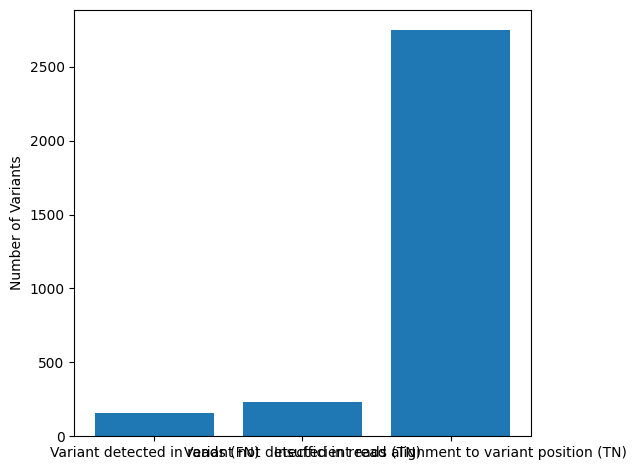

In [31]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, out_file=overall_txt_out.replace(".txt", ".pdf"))

## Analyze a FN

In [32]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                                                                                             | 0/25096 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████▎                                                                                                                         | 7641/25096 [00:00<00:00, 73008.31it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 14942/25096 [00:00<00:00, 30846.59it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 19224/25096 [00:00<00:00, 19564.17it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 22059/25096 [00:00<00:00, 19102.35it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 24476/25096 [00:01<00:00, 18054.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25096/25096 [00:01<00:00, 20963.97it/s]

Variants in vcrs_reference: 156
Variants not in vcrs_reference: 0


In [33]:
variants_in_vcrs_reference[:20]

['ENST00000361923:c.3205A>G',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000289893:c.6506G>A',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000371088:c.1031T>C',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000256652:c.1822C>A',
 'ENST00000581821:c.709G>C',
 'ENST00000355199:c.1215G>C',
 'ENST00000367079:c.619C>T',
 'ENST00000367057:c.2176T>C',
 'ENST00000367057:c.2201G>A',
 'ENST00000238181:c.457C>T',
 'ENST00000486442:c.1197T>C',
 'ENST00000425361:c.39G>A',
 'ENST00000349938:c.732A>G',
 'ENST00000349938:c.733T>A']

In [34]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000361923:c.3205A>G


In [35]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

AGAATCCATCCCATCCTACTGCCAGCGCTCTGTCCACGGGATCGCCTCCCATGAAGAATCCATCCCATCCTACTG
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCCGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCC
CGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation side for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [36]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > 2
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > 2 and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000468879:c.292A>T


GGATGACCCAGTCTCCATTCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCTGGGCCAGTCAGG
CCTGACTGGCCCAGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGAATGGAGACTGGGTCATCC


### Manually check if any read has a k-mer that matches the VCRS

In [37]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                                                                                          | 0/30247010 [00:00<?, ?it/s]

  0%|                                                                                                                                                                            | 4322/30247010 [00:00<11:39, 43209.53it/s]

  0%|                                                                                                                                                                            | 8662/30247010 [00:00<11:38, 43316.85it/s]

  0%|                                                                                                                                                                           | 13011/30247010 [00:00<11:36, 43393.56it/s]

  0%|                                                                                                                                                                           | 17370/30247010 [00:00<11:35, 43467.60it/s]

  0%|▏                                                                                                                                                                          | 23579/30247010 [00:00<10:02, 50181.18it/s]

  0%|▏                                                                                                                                                                          | 29837/30247010 [00:00<09:15, 54393.51it/s]

  0%|▏                                                                                                                                                                          | 36644/30247010 [00:00<08:33, 58862.57it/s]

  0%|▏                                                                                                                                                                          | 42949/30247010 [00:00<08:21, 60192.54it/s]

  0%|▎                                                                                                                                                                          | 49747/30247010 [00:00<08:02, 62623.73it/s]

  0%|▎                                                                                                                                                                          | 57219/30247010 [00:01<07:34, 66355.06it/s]

  0%|▎                                                                                                                                                                          | 65624/30247010 [00:01<07:00, 71767.62it/s]

  0%|▍                                                                                                                                                                          | 73557/30247010 [00:01<06:47, 74066.00it/s]

  0%|▍                                                                                                                                                                          | 81492/30247010 [00:01<06:38, 75663.92it/s]

  0%|▌                                                                                                                                                                          | 90001/30247010 [00:01<06:24, 78508.92it/s]

  0%|▌                                                                                                                                                                          | 97852/30247010 [00:01<06:24, 78429.63it/s]

  0%|▌                                                                                                                                                                         | 105778/30247010 [00:01<06:23, 78677.04it/s]

  0%|▋                                                                                                                                                                         | 114129/30247010 [00:01<06:21, 79057.82it/s]

  0%|▋                                                                                                                                                                         | 122612/30247010 [00:01<06:12, 80772.27it/s]

  0%|▋                                                                                                                                                                         | 130691/30247010 [00:01<06:13, 80579.82it/s]

  0%|▊                                                                                                                                                                         | 138750/30247010 [00:02<06:16, 79914.04it/s]

  0%|▊                                                                                                                                                                         | 146743/30247010 [00:02<07:08, 70306.02it/s]

  1%|▊                                                                                                                                                                         | 153980/30247010 [00:02<08:24, 59688.45it/s]

  1%|▉                                                                                                                                                                         | 160331/30247010 [00:02<08:55, 56133.28it/s]

  1%|▉                                                                                                                                                                         | 166215/30247010 [00:02<09:05, 55128.74it/s]

  1%|▉                                                                                                                                                                         | 171905/30247010 [00:02<09:03, 55371.63it/s]

  1%|▉                                                                                                                                                                         | 177571/30247010 [00:02<09:00, 55603.46it/s]

  1%|█                                                                                                                                                                         | 183224/30247010 [00:02<08:59, 55744.39it/s]

  1%|█                                                                                                                                                                         | 189664/30247010 [00:02<08:36, 58178.77it/s]

  1%|█                                                                                                                                                                         | 198123/30247010 [00:03<07:37, 65751.35it/s]

  1%|█▏                                                                                                                                                                        | 206026/30247010 [00:03<07:11, 69608.87it/s]

  1%|█▏                                                                                                                                                                        | 213957/30247010 [00:03<06:54, 72453.70it/s]

  1%|█▎                                                                                                                                                                        | 222463/30247010 [00:03<06:34, 76175.96it/s]

  1%|█▎                                                                                                                                                                        | 230263/30247010 [00:03<06:31, 76714.68it/s]

  1%|█▎                                                                                                                                                                        | 238232/30247010 [00:03<06:26, 77598.52it/s]

  1%|█▍                                                                                                                                                                        | 246201/30247010 [00:03<06:23, 78220.51it/s]

  1%|█▍                                                                                                                                                                        | 254720/30247010 [00:03<06:13, 80300.67it/s]

  1%|█▍                                                                                                                                                                        | 262763/30247010 [00:03<06:14, 80078.11it/s]

  1%|█▌                                                                                                                                                                        | 270780/30247010 [00:03<06:15, 79766.12it/s]

  1%|█▌                                                                                                                                                                        | 279143/30247010 [00:04<06:15, 79848.31it/s]

  1%|█▌                                                                                                                                                                        | 287601/30247010 [00:04<06:08, 81247.27it/s]

  1%|█▋                                                                                                                                                                        | 295731/30247010 [00:04<06:10, 80848.36it/s]

  1%|█▋                                                                                                                                                                        | 303820/30247010 [00:04<07:44, 64447.35it/s]

  1%|█▋                                                                                                                                                                        | 310789/30247010 [00:04<08:34, 58191.62it/s]

  1%|█▊                                                                                                                                                                        | 317047/30247010 [00:04<09:23, 53099.35it/s]

  1%|█▊                                                                                                                                                                        | 322697/30247010 [00:04<09:48, 50880.14it/s]

  1%|█▊                                                                                                                                                                        | 329316/30247010 [00:04<09:08, 54582.33it/s]

  1%|█▉                                                                                                                                                                        | 336416/30247010 [00:05<08:28, 58797.20it/s]

  1%|█▉                                                                                                                                                                        | 344046/30247010 [00:05<07:50, 63492.36it/s]

  1%|█▉                                                                                                                                                                        | 351197/30247010 [00:05<07:34, 65712.56it/s]

  1%|██                                                                                                                                                                        | 358858/30247010 [00:05<07:14, 68802.21it/s]

  1%|██                                                                                                                                                                        | 366483/30247010 [00:05<07:01, 70947.35it/s]

  1%|██                                                                                                                                                                        | 374443/30247010 [00:05<06:46, 73469.32it/s]

  1%|██▏                                                                                                                                                                       | 382916/30247010 [00:05<06:28, 76779.60it/s]

  1%|██▏                                                                                                                                                                       | 390906/30247010 [00:05<06:24, 77700.26it/s]

  1%|██▏                                                                                                                                                                       | 398896/30247010 [00:05<06:20, 78352.93it/s]

  1%|██▎                                                                                                                                                                       | 406916/30247010 [00:05<06:19, 78591.05it/s]

  1%|██▎                                                                                                                                                                       | 415402/30247010 [00:06<06:10, 80456.73it/s]

  1%|██▍                                                                                                                                                                       | 423466/30247010 [00:06<06:11, 80306.04it/s]

  1%|██▍                                                                                                                                                                       | 431517/30247010 [00:06<06:11, 80365.14it/s]

  1%|██▍                                                                                                                                                                       | 439993/30247010 [00:06<06:10, 80396.33it/s]

  1%|██▌                                                                                                                                                                       | 448366/30247010 [00:06<06:06, 81381.69it/s]

  2%|██▌                                                                                                                                                                       | 456510/30247010 [00:06<06:07, 80969.11it/s]

  2%|██▌                                                                                                                                                                       | 464611/30247010 [00:06<06:09, 80585.10it/s]

  2%|██▋                                                                                                                                                                       | 472971/30247010 [00:06<06:10, 80279.07it/s]

  2%|██▋                                                                                                                                                                       | 481421/30247010 [00:06<06:05, 81519.92it/s]

  2%|██▊                                                                                                                                                                       | 489578/30247010 [00:07<06:25, 77228.28it/s]

  2%|██▊                                                                                                                                                                       | 497347/30247010 [00:07<06:39, 74410.57it/s]

  2%|██▊                                                                                                                                                                       | 504833/30247010 [00:07<06:43, 73693.50it/s]

  2%|██▉                                                                                                                                                                       | 512231/30247010 [00:07<06:54, 71762.52it/s]

  2%|██▉                                                                                                                                                                       | 519683/30247010 [00:07<06:49, 72542.98it/s]

  2%|██▉                                                                                                                                                                       | 527559/30247010 [00:07<06:39, 74334.98it/s]

  2%|███                                                                                                                                                                       | 535428/30247010 [00:07<06:33, 75601.25it/s]

  2%|███                                                                                                                                                                       | 543638/30247010 [00:07<06:27, 76591.78it/s]

  2%|███                                                                                                                                                                       | 552028/30247010 [00:07<06:17, 78734.01it/s]

  2%|███▏                                                                                                                                                                      | 559915/30247010 [00:07<06:18, 78512.96it/s]

  2%|███▏                                                                                                                                                                      | 567784/30247010 [00:08<06:17, 78564.56it/s]

  2%|███▏                                                                                                                                                                      | 576185/30247010 [00:08<06:10, 80180.84it/s]

  2%|███▎                                                                                                                                                                      | 584210/30247010 [00:08<06:11, 79925.46it/s]

  2%|███▎                                                                                                                                                                      | 592207/30247010 [00:08<06:12, 79590.75it/s]

  2%|███▎                                                                                                                                                                      | 600359/30247010 [00:08<06:14, 79216.69it/s]

  2%|███▍                                                                                                                                                                      | 608760/30247010 [00:08<06:07, 80631.65it/s]

  2%|███▍                                                                                                                                                                      | 616828/30247010 [00:08<06:09, 80241.16it/s]

  2%|███▌                                                                                                                                                                      | 624855/30247010 [00:08<06:10, 79939.44it/s]

  2%|███▌                                                                                                                                                                      | 633227/30247010 [00:08<06:05, 81061.28it/s]

  2%|███▌                                                                                                                                                                      | 641336/30247010 [00:08<06:09, 80147.58it/s]

  2%|███▋                                                                                                                                                                      | 649355/30247010 [00:09<06:10, 79851.27it/s]

  2%|███▋                                                                                                                                                                      | 657343/30247010 [00:09<06:11, 79599.24it/s]

  2%|███▋                                                                                                                                                                      | 665737/30247010 [00:09<06:05, 80885.50it/s]

  2%|███▊                                                                                                                                                                      | 673828/30247010 [00:09<06:09, 80134.90it/s]

  2%|███▊                                                                                                                                                                      | 681845/30247010 [00:09<06:12, 79414.02it/s]

  2%|███▉                                                                                                                                                                      | 690234/30247010 [00:09<06:06, 80735.37it/s]

  2%|███▉                                                                                                                                                                      | 698312/30247010 [00:09<06:09, 79975.41it/s]

  2%|███▉                                                                                                                                                                      | 706314/30247010 [00:09<06:11, 79562.71it/s]

  2%|████                                                                                                                                                                      | 714273/30247010 [00:09<06:12, 79190.90it/s]

  2%|████                                                                                                                                                                      | 722509/30247010 [00:09<06:08, 80128.05it/s]

  2%|████                                                                                                                                                                      | 730525/30247010 [00:10<06:09, 79835.34it/s]

  2%|████▏                                                                                                                                                                     | 738511/30247010 [00:10<06:11, 79489.86it/s]

  2%|████▏                                                                                                                                                                     | 746843/30247010 [00:10<06:05, 80625.52it/s]

  2%|████▏                                                                                                                                                                     | 754908/30247010 [00:10<06:08, 80001.36it/s]

  3%|████▎                                                                                                                                                                     | 762911/30247010 [00:10<06:11, 79320.80it/s]

  3%|████▎                                                                                                                                                                     | 770846/30247010 [00:10<06:13, 79015.90it/s]

  3%|████▍                                                                                                                                                                     | 779213/30247010 [00:10<06:06, 80392.70it/s]

  3%|████▍                                                                                                                                                                     | 787255/30247010 [00:10<06:09, 79820.81it/s]

  3%|████▍                                                                                                                                                                     | 795240/30247010 [00:10<06:10, 79418.64it/s]

  3%|████▌                                                                                                                                                                     | 803473/30247010 [00:11<06:12, 79035.31it/s]

  3%|████▌                                                                                                                                                                     | 811823/30247010 [00:11<06:06, 80348.43it/s]

  3%|████▌                                                                                                                                                                     | 819862/30247010 [00:11<06:08, 79883.10it/s]

  3%|████▋                                                                                                                                                                     | 827854/30247010 [00:11<06:10, 79473.68it/s]

  3%|████▋                                                                                                                                                                     | 836156/30247010 [00:11<06:05, 80522.04it/s]

  3%|████▋                                                                                                                                                                     | 844211/30247010 [00:11<06:08, 79852.85it/s]

  3%|████▊                                                                                                                                                                     | 852199/30247010 [00:11<06:09, 79541.09it/s]

  3%|████▊                                                                                                                                                                     | 860155/30247010 [00:11<06:10, 79238.25it/s]

  3%|████▉                                                                                                                                                                     | 868529/30247010 [00:11<06:04, 80571.34it/s]

  3%|████▉                                                                                                                                                                     | 876589/30247010 [00:11<06:07, 79894.77it/s]

  3%|████▉                                                                                                                                                                     | 884581/30247010 [00:12<06:10, 79222.68it/s]

  3%|█████                                                                                                                                                                     | 892932/30247010 [00:12<06:04, 80490.28it/s]

  3%|█████                                                                                                                                                                     | 900985/30247010 [00:12<06:06, 80125.56it/s]

  3%|█████                                                                                                                                                                     | 909000/30247010 [00:12<06:07, 79886.62it/s]

  3%|█████▏                                                                                                                                                                    | 916991/30247010 [00:12<06:09, 79314.00it/s]

  3%|█████▏                                                                                                                                                                    | 925384/30247010 [00:12<06:03, 80679.80it/s]

  3%|█████▏                                                                                                                                                                    | 933455/30247010 [00:12<06:05, 80184.91it/s]

  3%|█████▎                                                                                                                                                                    | 941476/30247010 [00:12<06:07, 79693.91it/s]

  3%|█████▎                                                                                                                                                                    | 949872/30247010 [00:12<06:08, 79608.13it/s]

  3%|█████▍                                                                                                                                                                    | 958159/30247010 [00:12<06:03, 80564.94it/s]

  3%|█████▍                                                                                                                                                                    | 966219/30247010 [00:13<06:05, 80140.33it/s]

  3%|█████▍                                                                                                                                                                    | 974236/30247010 [00:13<06:06, 79770.51it/s]

  3%|█████▌                                                                                                                                                                    | 982643/30247010 [00:13<06:01, 81041.86it/s]

  3%|█████▌                                                                                                                                                                    | 990750/30247010 [00:13<06:02, 80674.22it/s]

  3%|█████▌                                                                                                                                                                    | 998820/30247010 [00:13<06:05, 80060.01it/s]

  3%|█████▋                                                                                                                                                                   | 1006828/30247010 [00:13<06:07, 79668.69it/s]

  3%|█████▋                                                                                                                                                                   | 1015263/30247010 [00:13<06:00, 81053.90it/s]

  3%|█████▋                                                                                                                                                                   | 1023371/30247010 [00:13<06:03, 80466.17it/s]

  3%|█████▊                                                                                                                                                                   | 1031420/30247010 [00:13<06:05, 79998.95it/s]

  3%|█████▊                                                                                                                                                                   | 1039607/30247010 [00:13<06:07, 79480.64it/s]

  3%|█████▊                                                                                                                                                                   | 1048034/30247010 [00:14<06:00, 80889.60it/s]

  3%|█████▉                                                                                                                                                                   | 1056128/30247010 [00:14<06:02, 80423.06it/s]

  4%|█████▉                                                                                                                                                                   | 1064174/30247010 [00:14<06:04, 80156.09it/s]

  4%|█████▉                                                                                                                                                                   | 1072453/30247010 [00:14<06:05, 79906.70it/s]

  4%|██████                                                                                                                                                                   | 1080797/30247010 [00:14<06:00, 80947.42it/s]

  4%|██████                                                                                                                                                                   | 1088895/30247010 [00:14<06:02, 80491.62it/s]

  4%|██████▏                                                                                                                                                                  | 1096947/30247010 [00:14<06:03, 80121.81it/s]

  4%|██████▏                                                                                                                                                                  | 1105283/30247010 [00:14<06:04, 79975.38it/s]

  4%|██████▏                                                                                                                                                                  | 1113731/30247010 [00:14<05:58, 81300.79it/s]

  4%|██████▎                                                                                                                                                                  | 1121865/30247010 [00:14<06:01, 80497.69it/s]

  4%|██████▎                                                                                                                                                                  | 1129918/30247010 [00:15<06:03, 80118.64it/s]

  4%|██████▎                                                                                                                                                                  | 1138114/30247010 [00:15<06:04, 79884.70it/s]

  4%|██████▍                                                                                                                                                                  | 1146528/30247010 [00:15<05:58, 81138.47it/s]

  4%|██████▍                                                                                                                                                                  | 1154646/30247010 [00:15<06:01, 80536.33it/s]

  4%|██████▍                                                                                                                                                                  | 1162703/30247010 [00:15<06:03, 79949.58it/s]

  4%|██████▌                                                                                                                                                                  | 1170944/30247010 [00:15<06:04, 79705.96it/s]

  4%|██████▌                                                                                                                                                                  | 1179379/30247010 [00:15<05:58, 81071.59it/s]

  4%|██████▋                                                                                                                                                                  | 1187491/30247010 [00:15<06:00, 80517.78it/s]

  4%|██████▋                                                                                                                                                                  | 1195546/30247010 [00:15<06:02, 80072.66it/s]

  4%|██████▋                                                                                                                                                                  | 1203774/30247010 [00:15<06:04, 79679.26it/s]

  4%|██████▊                                                                                                                                                                  | 1212224/30247010 [00:16<05:58, 81095.76it/s]

  4%|██████▊                                                                                                                                                                  | 1220338/30247010 [00:16<06:00, 80540.12it/s]

  4%|██████▊                                                                                                                                                                  | 1228396/30247010 [00:16<06:02, 79995.86it/s]

  4%|██████▉                                                                                                                                                                  | 1236774/30247010 [00:16<06:03, 79840.96it/s]

  4%|██████▉                                                                                                                                                                  | 1245080/30247010 [00:16<05:59, 80783.83it/s]

  4%|███████                                                                                                                                                                  | 1253162/30247010 [00:16<06:00, 80321.39it/s]

  4%|███████                                                                                                                                                                  | 1261197/30247010 [00:16<06:02, 79869.94it/s]

  4%|███████                                                                                                                                                                  | 1269564/30247010 [00:16<05:57, 80992.85it/s]

  4%|███████▏                                                                                                                                                                 | 1277667/30247010 [00:16<06:00, 80422.18it/s]

  4%|███████▏                                                                                                                                                                 | 1285712/30247010 [00:17<06:02, 79805.91it/s]

  4%|███████▏                                                                                                                                                                 | 1293695/30247010 [00:17<06:04, 79489.85it/s]

  4%|███████▎                                                                                                                                                                 | 1302059/30247010 [00:17<05:58, 80716.37it/s]

  4%|███████▎                                                                                                                                                                 | 1310134/30247010 [00:17<06:00, 80220.04it/s]

  4%|███████▎                                                                                                                                                                 | 1318158/30247010 [00:17<06:03, 79516.08it/s]

  4%|███████▍                                                                                                                                                                 | 1326284/30247010 [00:17<06:04, 79335.97it/s]

  4%|███████▍                                                                                                                                                                 | 1334717/30247010 [00:17<05:57, 80809.43it/s]

  4%|███████▌                                                                                                                                                                 | 1342802/30247010 [00:17<05:59, 80335.28it/s]

  4%|███████▌                                                                                                                                                                 | 1350839/30247010 [00:17<06:01, 79920.57it/s]

  4%|███████▌                                                                                                                                                                 | 1359122/30247010 [00:17<05:57, 80779.86it/s]

  5%|███████▋                                                                                                                                                                 | 1367203/30247010 [00:18<05:59, 80222.49it/s]

  5%|███████▋                                                                                                                                                                 | 1375228/30247010 [00:18<06:01, 79834.24it/s]

  5%|███████▋                                                                                                                                                                 | 1383213/30247010 [00:18<06:03, 79492.80it/s]

  5%|███████▊                                                                                                                                                                 | 1391663/30247010 [00:18<05:56, 80977.60it/s]

  5%|███████▊                                                                                                                                                                 | 1399764/30247010 [00:18<05:59, 80162.21it/s]

  5%|███████▊                                                                                                                                                                 | 1407784/30247010 [00:18<06:01, 79811.73it/s]

  5%|███████▉                                                                                                                                                                 | 1415768/30247010 [00:18<06:02, 79619.25it/s]

  5%|███████▉                                                                                                                                                                 | 1424170/30247010 [00:18<05:56, 80924.99it/s]

  5%|████████                                                                                                                                                                 | 1432265/30247010 [00:18<05:58, 80273.34it/s]

  5%|████████                                                                                                                                                                 | 1440295/30247010 [00:18<06:01, 79581.76it/s]

  5%|████████                                                                                                                                                                 | 1448459/30247010 [00:19<06:02, 79433.77it/s]

  5%|████████▏                                                                                                                                                                | 1456846/30247010 [00:19<05:56, 80742.44it/s]

  5%|████████▏                                                                                                                                                                | 1464924/30247010 [00:19<05:58, 80285.06it/s]

  5%|████████▏                                                                                                                                                                | 1472955/30247010 [00:19<06:04, 78848.21it/s]

  5%|████████▎                                                                                                                                                                | 1480975/30247010 [00:19<06:03, 79242.46it/s]

  5%|████████▎                                                                                                                                                                | 1488905/30247010 [00:19<06:03, 79190.74it/s]

  5%|████████▎                                                                                                                                                                | 1496828/30247010 [00:19<06:03, 79067.84it/s]

  5%|████████▍                                                                                                                                                                | 1504739/30247010 [00:19<06:03, 79026.29it/s]

  5%|████████▍                                                                                                                                                                | 1513184/30247010 [00:19<05:56, 80640.49it/s]

  5%|████████▍                                                                                                                                                                | 1521251/30247010 [00:19<05:59, 79862.57it/s]

  5%|████████▌                                                                                                                                                                | 1529241/30247010 [00:20<06:00, 79598.19it/s]

  5%|████████▌                                                                                                                                                                | 1537568/30247010 [00:20<06:00, 79592.43it/s]

  5%|████████▋                                                                                                                                                                | 1546022/30247010 [00:20<05:54, 81049.51it/s]

  5%|████████▋                                                                                                                                                                | 1554131/30247010 [00:20<05:56, 80508.28it/s]

  5%|████████▋                                                                                                                                                                | 1562185/30247010 [00:20<06:00, 79609.42it/s]

  5%|████████▊                                                                                                                                                                | 1570510/30247010 [00:20<05:55, 80680.58it/s]

  5%|████████▊                                                                                                                                                                | 1578583/30247010 [00:20<05:58, 79995.33it/s]

  5%|████████▊                                                                                                                                                                | 1586586/30247010 [00:20<06:00, 79456.73it/s]

  5%|████████▉                                                                                                                                                                | 1594535/30247010 [00:20<06:01, 79199.85it/s]

  5%|████████▉                                                                                                                                                                | 1602767/30247010 [00:20<05:57, 80122.55it/s]

  5%|████████▉                                                                                                                                                                | 1610782/30247010 [00:21<05:58, 79941.59it/s]

  5%|█████████                                                                                                                                                                | 1618778/30247010 [00:21<05:59, 79645.04it/s]

  5%|█████████                                                                                                                                                                | 1627063/30247010 [00:21<06:00, 79459.59it/s]

  5%|█████████▏                                                                                                                                                               | 1635444/30247010 [00:21<05:54, 80743.64it/s]

  5%|█████████▏                                                                                                                                                               | 1643522/30247010 [00:21<05:58, 79777.51it/s]

  5%|█████████▏                                                                                                                                                               | 1651504/30247010 [00:21<06:00, 79351.20it/s]

  5%|█████████▎                                                                                                                                                               | 1659846/30247010 [00:21<05:54, 80551.05it/s]

  6%|█████████▎                                                                                                                                                               | 1667905/30247010 [00:21<05:57, 80052.78it/s]

  6%|█████████▎                                                                                                                                                               | 1675913/30247010 [00:21<05:59, 79570.69it/s]

  6%|█████████▍                                                                                                                                                               | 1683873/30247010 [00:22<06:01, 78974.50it/s]

  6%|█████████▍                                                                                                                                                               | 1692227/30247010 [00:22<05:55, 80323.41it/s]

  6%|█████████▍                                                                                                                                                               | 1700263/30247010 [00:22<05:57, 79840.07it/s]

  6%|█████████▌                                                                                                                                                               | 1708250/30247010 [00:22<05:58, 79537.87it/s]

  6%|█████████▌                                                                                                                                                               | 1716574/30247010 [00:22<05:58, 79472.42it/s]

  6%|█████████▋                                                                                                                                                               | 1724884/30247010 [00:22<05:54, 80538.51it/s]

  6%|█████████▋                                                                                                                                                               | 1732941/30247010 [00:22<05:56, 79887.84it/s]

  6%|█████████▋                                                                                                                                                               | 1740933/30247010 [00:22<05:58, 79421.10it/s]

  6%|█████████▊                                                                                                                                                               | 1749302/30247010 [00:22<05:53, 80681.59it/s]

  6%|█████████▊                                                                                                                                                               | 1757374/30247010 [00:22<05:56, 79988.47it/s]

  6%|█████████▊                                                                                                                                                               | 1765376/30247010 [00:23<05:58, 79440.14it/s]

  6%|█████████▉                                                                                                                                                               | 1773323/30247010 [00:23<05:58, 79333.03it/s]

  6%|█████████▉                                                                                                                                                               | 1781753/30247010 [00:23<05:52, 80805.58it/s]

  6%|██████████                                                                                                                                                               | 1789837/30247010 [00:23<05:54, 80187.53it/s]

  6%|██████████                                                                                                                                                               | 1797859/30247010 [00:23<05:58, 79402.11it/s]

  6%|██████████                                                                                                                                                               | 1805802/30247010 [00:23<05:59, 79159.68it/s]

  6%|██████████▏                                                                                                                                                              | 1814212/30247010 [00:23<05:52, 80621.68it/s]

  6%|██████████▏                                                                                                                                                              | 1822278/30247010 [00:23<05:54, 80099.89it/s]

  6%|██████████▏                                                                                                                                                              | 1830291/30247010 [00:23<05:56, 79744.12it/s]

  6%|██████████▎                                                                                                                                                              | 1838571/30247010 [00:23<05:58, 79293.79it/s]

  6%|██████████▎                                                                                                                                                              | 1846926/30247010 [00:24<05:52, 80543.23it/s]

  6%|██████████▎                                                                                                                                                              | 1854985/30247010 [00:24<05:55, 79819.34it/s]

  6%|██████████▍                                                                                                                                                              | 1862971/30247010 [00:24<05:57, 79358.61it/s]

  6%|██████████▍                                                                                                                                                              | 1871355/30247010 [00:24<05:51, 80681.54it/s]

  6%|██████████▌                                                                                                                                                              | 1879427/30247010 [00:24<05:54, 79986.42it/s]

  6%|██████████▌                                                                                                                                                              | 1887429/30247010 [00:24<05:56, 79525.80it/s]

  6%|██████████▌                                                                                                                                                              | 1895384/30247010 [00:24<05:57, 79325.82it/s]

  6%|██████████▋                                                                                                                                                              | 1903789/30247010 [00:24<05:51, 80724.67it/s]

  6%|██████████▋                                                                                                                                                              | 1911865/30247010 [00:24<05:54, 79975.56it/s]

  6%|██████████▋                                                                                                                                                              | 1919866/30247010 [00:24<05:57, 79139.73it/s]

  6%|██████████▊                                                                                                                                                              | 1927812/30247010 [00:25<05:59, 78878.44it/s]

  6%|██████████▊                                                                                                                                                              | 1936183/30247010 [00:25<05:52, 80306.01it/s]

  6%|██████████▊                                                                                                                                                              | 1944218/30247010 [00:25<05:53, 79954.93it/s]

  6%|██████████▉                                                                                                                                                              | 1952216/30247010 [00:25<05:54, 79721.08it/s]

  6%|██████████▉                                                                                                                                                              | 1960433/30247010 [00:25<05:51, 80446.71it/s]

  7%|██████████▉                                                                                                                                                              | 1968480/30247010 [00:25<05:54, 79856.45it/s]

  7%|███████████                                                                                                                                                              | 1976468/30247010 [00:25<05:55, 79419.72it/s]

  7%|███████████                                                                                                                                                              | 1984412/30247010 [00:25<05:56, 79171.60it/s]

  7%|███████████▏                                                                                                                                                             | 1992830/30247010 [00:25<05:50, 80656.24it/s]

  7%|███████████▏                                                                                                                                                             | 2000898/30247010 [00:25<05:53, 79863.47it/s]

  7%|███████████▏                                                                                                                                                             | 2008888/30247010 [00:26<05:55, 79502.82it/s]

  7%|███████████▎                                                                                                                                                             | 2017258/30247010 [00:26<05:49, 80744.75it/s]

  7%|███████████▎                                                                                                                                                             | 2025336/30247010 [00:26<05:51, 80235.21it/s]

  7%|███████████▎                                                                                                                                                             | 2033362/30247010 [00:26<05:53, 79865.12it/s]

  7%|███████████▍                                                                                                                                                             | 2041351/30247010 [00:26<05:56, 79187.74it/s]

  7%|███████████▍                                                                                                                                                             | 2049690/30247010 [00:26<05:50, 80428.97it/s]

  7%|███████████▍                                                                                                                                                             | 2057736/30247010 [00:26<05:52, 79919.29it/s]

  7%|███████████▌                                                                                                                                                             | 2065731/30247010 [00:26<05:54, 79565.71it/s]

  7%|███████████▌                                                                                                                                                             | 2073854/30247010 [00:26<05:54, 79451.24it/s]

  7%|███████████▋                                                                                                                                                             | 2082154/30247010 [00:26<05:49, 80500.68it/s]

  7%|███████████▋                                                                                                                                                             | 2090207/30247010 [00:27<05:52, 79885.96it/s]

  7%|███████████▋                                                                                                                                                             | 2098198/30247010 [00:27<05:54, 79491.96it/s]

  7%|███████████▊                                                                                                                                                             | 2106607/30247010 [00:27<05:48, 80852.75it/s]

  7%|███████████▊                                                                                                                                                             | 2114695/30247010 [00:27<05:50, 80202.97it/s]

  7%|███████████▊                                                                                                                                                             | 2122718/30247010 [00:27<05:53, 79476.26it/s]

  7%|███████████▉                                                                                                                                                             | 2130669/30247010 [00:27<05:54, 79221.23it/s]

  7%|███████████▉                                                                                                                                                             | 2139073/30247010 [00:27<05:48, 80645.72it/s]

  7%|███████████▉                                                                                                                                                             | 2147141/30247010 [00:27<05:50, 80073.21it/s]

  7%|████████████                                                                                                                                                             | 2155151/30247010 [00:27<05:52, 79759.49it/s]

  7%|████████████                                                                                                                                                             | 2163129/30247010 [00:27<05:54, 79209.15it/s]

  7%|████████████▏                                                                                                                                                            | 2171509/30247010 [00:28<05:48, 80567.49it/s]

  7%|████████████▏                                                                                                                                                            | 2179569/30247010 [00:28<05:50, 80076.14it/s]

  7%|████████████▏                                                                                                                                                            | 2187579/30247010 [00:28<05:51, 79788.40it/s]

  7%|████████████▎                                                                                                                                                            | 2195841/30247010 [00:28<05:52, 79587.81it/s]

  7%|████████████▎                                                                                                                                                            | 2204158/30247010 [00:28<05:47, 80642.23it/s]

  7%|████████████▎                                                                                                                                                            | 2212225/30247010 [00:28<05:50, 80053.23it/s]

  7%|████████████▍                                                                                                                                                            | 2220233/30247010 [00:28<05:52, 79597.75it/s]

  7%|████████████▍                                                                                                                                                            | 2228610/30247010 [00:28<05:46, 80830.87it/s]

  7%|████████████▍                                                                                                                                                            | 2236696/30247010 [00:28<05:49, 80137.36it/s]

  7%|████████████▌                                                                                                                                                            | 2244713/30247010 [00:29<05:52, 79378.92it/s]

  7%|████████████▌                                                                                                                                                            | 2252654/30247010 [00:29<05:54, 79067.66it/s]

  7%|████████████▋                                                                                                                                                            | 2261067/30247010 [00:29<05:47, 80564.70it/s]

  8%|████████████▋                                                                                                                                                            | 2269127/30247010 [00:29<05:49, 80042.66it/s]

  8%|████████████▋                                                                                                                                                            | 2277134/30247010 [00:29<05:52, 79293.48it/s]

  8%|████████████▊                                                                                                                                                            | 2285134/30247010 [00:29<05:53, 79129.81it/s]

  8%|████████████▊                                                                                                                                                            | 2293502/30247010 [00:29<05:47, 80475.38it/s]

  8%|████████████▊                                                                                                                                                            | 2301553/30247010 [00:29<05:49, 79899.44it/s]

  8%|████████████▉                                                                                                                                                            | 2309546/30247010 [00:29<05:51, 79433.36it/s]

  8%|████████████▉                                                                                                                                                            | 2317785/30247010 [00:29<05:47, 80308.11it/s]

  8%|████████████▉                                                                                                                                                            | 2325819/30247010 [00:30<05:50, 79698.08it/s]

  8%|█████████████                                                                                                                                                            | 2333792/30247010 [00:30<05:52, 79164.88it/s]

  8%|█████████████                                                                                                                                                            | 2341711/30247010 [00:30<05:53, 78832.42it/s]

  8%|█████████████▏                                                                                                                                                           | 2350067/30247010 [00:30<05:47, 80230.55it/s]

  8%|█████████████▏                                                                                                                                                           | 2358093/30247010 [00:30<05:50, 79608.13it/s]

  8%|█████████████▏                                                                                                                                                           | 2366057/30247010 [00:30<05:51, 79225.26it/s]

  8%|█████████████▎                                                                                                                                                           | 2374464/30247010 [00:30<05:45, 80660.48it/s]

  8%|█████████████▎                                                                                                                                                           | 2382533/30247010 [00:30<05:48, 79954.59it/s]

  8%|█████████████▎                                                                                                                                                           | 2390532/30247010 [00:30<05:50, 79554.43it/s]

  8%|█████████████▍                                                                                                                                                           | 2398490/30247010 [00:30<05:52, 78963.79it/s]

  8%|█████████████▍                                                                                                                                                           | 2406865/30247010 [00:31<05:46, 80378.25it/s]

  8%|█████████████▍                                                                                                                                                           | 2414906/30247010 [00:31<05:48, 79881.41it/s]

  8%|█████████████▌                                                                                                                                                           | 2422897/30247010 [00:31<05:50, 79358.54it/s]

  8%|█████████████▌                                                                                                                                                           | 2431179/30247010 [00:31<05:51, 79110.63it/s]

  8%|█████████████▋                                                                                                                                                           | 2439470/30247010 [00:31<05:46, 80227.17it/s]

  8%|█████████████▋                                                                                                                                                           | 2447497/30247010 [00:31<05:48, 79762.78it/s]

  8%|█████████████▋                                                                                                                                                           | 2455476/30247010 [00:31<05:49, 79446.49it/s]

  8%|█████████████▊                                                                                                                                                           | 2463818/30247010 [00:31<05:44, 80621.55it/s]

  8%|█████████████▊                                                                                                                                                           | 2471883/30247010 [00:31<05:47, 79916.95it/s]

  8%|█████████████▊                                                                                                                                                           | 2479878/30247010 [00:31<05:50, 79138.02it/s]

  8%|█████████████▉                                                                                                                                                           | 2487795/30247010 [00:32<05:51, 78886.55it/s]

  8%|█████████████▉                                                                                                                                                           | 2496178/30247010 [00:32<05:45, 80347.69it/s]

  8%|█████████████▉                                                                                                                                                           | 2504216/30247010 [00:32<05:47, 79922.90it/s]

  8%|██████████████                                                                                                                                                           | 2512211/30247010 [00:32<05:49, 79428.50it/s]

  8%|██████████████                                                                                                                                                           | 2520333/30247010 [00:32<05:51, 78848.76it/s]

  8%|██████████████▏                                                                                                                                                          | 2528729/30247010 [00:32<05:44, 80353.57it/s]

  8%|██████████████▏                                                                                                                                                          | 2536769/30247010 [00:32<05:47, 79743.85it/s]

  8%|██████████████▏                                                                                                                                                          | 2544747/30247010 [00:32<05:49, 79279.06it/s]

  8%|██████████████▎                                                                                                                                                          | 2553152/30247010 [00:32<05:43, 80688.51it/s]

  8%|██████████████▎                                                                                                                                                          | 2561225/30247010 [00:32<05:47, 79675.89it/s]

  8%|██████████████▎                                                                                                                                                          | 2569198/30247010 [00:33<05:49, 79204.96it/s]

  9%|██████████████▍                                                                                                                                                          | 2577122/30247010 [00:33<05:50, 78880.37it/s]

  9%|██████████████▍                                                                                                                                                          | 2585516/30247010 [00:33<05:44, 80376.48it/s]

  9%|██████████████▍                                                                                                                                                          | 2593558/30247010 [00:33<05:45, 79930.90it/s]

  9%|██████████████▌                                                                                                                                                          | 2601554/30247010 [00:33<05:48, 79226.43it/s]

  9%|██████████████▌                                                                                                                                                          | 2609480/30247010 [00:33<05:50, 78814.37it/s]

  9%|██████████████▋                                                                                                                                                          | 2617905/30247010 [00:33<05:43, 80420.24it/s]

  9%|██████████████▋                                                                                                                                                          | 2625951/30247010 [00:33<05:44, 80082.35it/s]

  9%|██████████████▋                                                                                                                                                          | 2633962/30247010 [00:33<05:46, 79799.31it/s]

  9%|██████████████▊                                                                                                                                                          | 2642282/30247010 [00:34<05:41, 80809.05it/s]

  9%|██████████████▊                                                                                                                                                          | 2650365/30247010 [00:34<05:43, 80373.34it/s]

  9%|██████████████▊                                                                                                                                                          | 2658405/30247010 [00:34<05:44, 79992.90it/s]

  9%|██████████████▉                                                                                                                                                          | 2666406/30247010 [00:34<05:45, 79774.99it/s]

  9%|██████████████▉                                                                                                                                                          | 2674813/30247010 [00:34<05:40, 81051.12it/s]

  9%|██████████████▉                                                                                                                                                          | 2682920/30247010 [00:34<05:43, 80181.80it/s]

  9%|███████████████                                                                                                                                                          | 2690942/30247010 [00:34<05:44, 79991.17it/s]

  9%|███████████████                                                                                                                                                          | 2698982/30247010 [00:34<05:45, 79747.77it/s]

  9%|███████████████▏                                                                                                                                                         | 2707427/30247010 [00:34<05:39, 81141.31it/s]

  9%|███████████████▏                                                                                                                                                         | 2715544/30247010 [00:34<05:41, 80735.15it/s]

  9%|███████████████▏                                                                                                                                                         | 2723620/30247010 [00:35<05:43, 80084.39it/s]

  9%|███████████████▎                                                                                                                                                         | 2731959/30247010 [00:35<05:44, 79844.87it/s]

  9%|███████████████▎                                                                                                                                                         | 2740399/30247010 [00:35<05:38, 81183.20it/s]

  9%|███████████████▎                                                                                                                                                         | 2748522/30247010 [00:35<05:40, 80649.72it/s]

  9%|███████████████▍                                                                                                                                                         | 2756590/30247010 [00:35<05:43, 79983.79it/s]

  9%|███████████████▍                                                                                                                                                         | 2764899/30247010 [00:35<05:44, 79838.03it/s]

  9%|███████████████▍                                                                                                                                                         | 2773290/30247010 [00:35<05:39, 81033.60it/s]

  9%|███████████████▌                                                                                                                                                         | 2781398/30247010 [00:35<05:41, 80399.07it/s]

  9%|███████████████▌                                                                                                                                                         | 2789441/30247010 [00:35<05:43, 79971.61it/s]

  9%|███████████████▋                                                                                                                                                         | 2797715/30247010 [00:35<05:39, 80788.82it/s]

  9%|███████████████▋                                                                                                                                                         | 2805797/30247010 [00:36<05:41, 80272.63it/s]

  9%|███████████████▋                                                                                                                                                         | 2813827/30247010 [00:36<05:43, 79959.65it/s]

  9%|███████████████▊                                                                                                                                                         | 2821825/30247010 [00:36<05:43, 79752.48it/s]

  9%|███████████████▊                                                                                                                                                         | 2830232/30247010 [00:36<05:38, 81033.87it/s]

  9%|███████████████▊                                                                                                                                                         | 2838338/30247010 [00:36<05:41, 80160.05it/s]

  9%|███████████████▉                                                                                                                                                         | 2846357/30247010 [00:36<05:43, 79841.66it/s]

  9%|███████████████▉                                                                                                                                                         | 2854344/30247010 [00:36<05:44, 79444.39it/s]

  9%|███████████████▉                                                                                                                                                         | 2862656/30247010 [00:36<05:40, 80532.82it/s]

  9%|████████████████                                                                                                                                                         | 2870712/30247010 [00:36<05:42, 79973.72it/s]

 10%|████████████████                                                                                                                                                         | 2878712/30247010 [00:36<05:44, 79389.32it/s]

 10%|████████████████▏                                                                                                                                                        | 2886838/30247010 [00:37<05:45, 79152.94it/s]

 10%|████████████████▏                                                                                                                                                        | 2895192/30247010 [00:37<05:39, 80446.80it/s]

 10%|████████████████▏                                                                                                                                                        | 2903240/30247010 [00:37<05:41, 80006.85it/s]

 10%|████████████████▎                                                                                                                                                        | 2911243/30247010 [00:37<05:43, 79573.76it/s]

 10%|████████████████▎                                                                                                                                                        | 2919467/30247010 [00:37<05:40, 80362.07it/s]

 10%|████████████████▎                                                                                                                                                        | 2927506/30247010 [00:37<05:40, 80116.88it/s]

 10%|████████████████▍                                                                                                                                                        | 2935520/30247010 [00:37<05:42, 79775.11it/s]

 10%|████████████████▍                                                                                                                                                        | 2943499/30247010 [00:37<05:43, 79386.70it/s]

 10%|████████████████▍                                                                                                                                                        | 2951867/30247010 [00:37<05:38, 80659.04it/s]

 10%|████████████████▌                                                                                                                                                        | 2959935/30247010 [00:37<05:41, 79916.63it/s]

 10%|████████████████▌                                                                                                                                                        | 2967930/30247010 [00:38<05:42, 79595.50it/s]

 10%|████████████████▋                                                                                                                                                        | 2976279/30247010 [00:38<05:37, 80748.70it/s]

 10%|████████████████▋                                                                                                                                                        | 2984357/30247010 [00:38<05:39, 80244.78it/s]

 10%|████████████████▋                                                                                                                                                        | 2992384/30247010 [00:38<05:40, 80119.91it/s]

 10%|████████████████▊                                                                                                                                                        | 3000398/30247010 [00:38<05:42, 79597.63it/s]

 10%|████████████████▊                                                                                                                                                        | 3008818/30247010 [00:38<05:36, 80961.77it/s]

 10%|████████████████▊                                                                                                                                                        | 3016917/30247010 [00:38<05:38, 80543.25it/s]

 10%|████████████████▉                                                                                                                                                        | 3024974/30247010 [00:38<05:39, 80235.96it/s]

 10%|████████████████▉                                                                                                                                                        | 3032999/30247010 [00:38<05:40, 80021.69it/s]

 10%|████████████████▉                                                                                                                                                        | 3041337/30247010 [00:38<05:35, 81019.24it/s]

 10%|█████████████████                                                                                                                                                        | 3049441/30247010 [00:39<05:37, 80552.04it/s]

 10%|█████████████████                                                                                                                                                        | 3057498/30247010 [00:39<05:39, 80125.89it/s]

 10%|█████████████████▏                                                                                                                                                       | 3065698/30247010 [00:39<05:40, 79891.80it/s]

 10%|█████████████████▏                                                                                                                                                       | 3074118/30247010 [00:39<05:34, 81164.52it/s]

 10%|█████████████████▏                                                                                                                                                       | 3082237/30247010 [00:39<05:37, 80430.09it/s]

 10%|█████████████████▎                                                                                                                                                       | 3090283/30247010 [00:39<05:39, 80090.36it/s]

 10%|█████████████████▎                                                                                                                                                       | 3098527/30247010 [00:39<05:39, 80022.84it/s]

 10%|█████████████████▎                                                                                                                                                       | 3106961/30247010 [00:39<05:33, 81295.67it/s]

 10%|█████████████████▍                                                                                                                                                       | 3115094/30247010 [00:39<05:36, 80724.10it/s]

 10%|█████████████████▍                                                                                                                                                       | 3123169/30247010 [00:39<05:39, 79997.60it/s]

 10%|█████████████████▍                                                                                                                                                       | 3131357/30247010 [00:40<05:39, 79838.86it/s]

 10%|█████████████████▌                                                                                                                                                       | 3139803/30247010 [00:40<05:33, 81200.80it/s]

 10%|█████████████████▌                                                                                                                                                       | 3147927/30247010 [00:40<05:36, 80598.87it/s]

 10%|█████████████████▋                                                                                                                                                       | 3155990/30247010 [00:40<05:38, 80133.65it/s]

 10%|█████████████████▋                                                                                                                                                       | 3164186/30247010 [00:40<05:40, 79592.45it/s]

 10%|█████████████████▋                                                                                                                                                       | 3172550/30247010 [00:40<05:35, 80781.49it/s]

 11%|█████████████████▊                                                                                                                                                       | 3180633/30247010 [00:40<05:37, 80150.67it/s]

 11%|█████████████████▊                                                                                                                                                       | 3188652/30247010 [00:40<05:39, 79642.89it/s]

 11%|█████████████████▊                                                                                                                                                       | 3196989/30247010 [00:40<05:35, 80743.20it/s]

 11%|█████████████████▉                                                                                                                                                       | 3205067/30247010 [00:41<05:38, 79820.24it/s]

 11%|█████████████████▉                                                                                                                                                       | 3213053/30247010 [00:41<05:40, 79374.03it/s]

 11%|█████████████████▉                                                                                                                                                       | 3220993/30247010 [00:41<05:41, 79094.00it/s]

 11%|██████████████████                                                                                                                                                       | 3229320/30247010 [00:41<05:36, 80328.54it/s]

 11%|██████████████████                                                                                                                                                       | 3237356/30247010 [00:41<05:38, 79768.29it/s]

 11%|██████████████████▏                                                                                                                                                      | 3245336/30247010 [00:41<05:41, 79014.18it/s]

 11%|██████████████████▏                                                                                                                                                      | 3253688/30247010 [00:41<05:35, 80344.96it/s]

 11%|██████████████████▏                                                                                                                                                      | 3261727/30247010 [00:41<05:37, 80049.65it/s]

 11%|██████████████████▎                                                                                                                                                      | 3269735/30247010 [00:41<05:38, 79606.91it/s]

 11%|██████████████████▎                                                                                                                                                      | 3277698/30247010 [00:41<05:41, 78922.23it/s]

 11%|██████████████████▎                                                                                                                                                      | 3286013/30247010 [00:42<05:36, 80171.81it/s]

 11%|██████████████████▍                                                                                                                                                      | 3294034/30247010 [00:42<05:38, 79509.92it/s]

 11%|██████████████████▍                                                                                                                                                      | 3301988/30247010 [00:42<05:40, 79134.53it/s]

 11%|██████████████████▍                                                                                                                                                      | 3310223/30247010 [00:42<05:40, 78996.56it/s]

 11%|██████████████████▌                                                                                                                                                      | 3318463/30247010 [00:42<05:36, 79997.86it/s]

 11%|██████████████████▌                                                                                                                                                      | 3326466/30247010 [00:42<05:38, 79568.04it/s]

 11%|██████████████████▋                                                                                                                                                      | 3334425/30247010 [00:42<05:39, 79159.50it/s]

 11%|██████████████████▋                                                                                                                                                      | 3342792/30247010 [00:42<05:34, 80492.67it/s]

 11%|██████████████████▋                                                                                                                                                      | 3350844/30247010 [00:42<05:36, 79928.77it/s]

 11%|██████████████████▊                                                                                                                                                      | 3358840/30247010 [00:42<05:40, 78967.25it/s]

 11%|██████████████████▊                                                                                                                                                      | 3366740/30247010 [00:43<05:40, 78909.32it/s]

 11%|██████████████████▊                                                                                                                                                      | 3375108/30247010 [00:43<05:34, 80320.77it/s]

 11%|██████████████████▉                                                                                                                                                      | 3383144/30247010 [00:43<05:36, 79918.68it/s]

 11%|██████████████████▉                                                                                                                                                      | 3391139/30247010 [00:43<05:37, 79555.99it/s]

 11%|██████████████████▉                                                                                                                                                      | 3399384/30247010 [00:43<05:33, 80414.36it/s]

 11%|███████████████████                                                                                                                                                      | 3407428/30247010 [00:43<05:36, 79841.97it/s]

 11%|███████████████████                                                                                                                                                      | 3415415/30247010 [00:43<05:37, 79584.99it/s]

 11%|███████████████████▏                                                                                                                                                     | 3423375/30247010 [00:43<05:38, 79320.58it/s]

 11%|███████████████████▏                                                                                                                                                     | 3431735/30247010 [00:43<05:32, 80590.55it/s]

 11%|███████████████████▏                                                                                                                                                     | 3439796/30247010 [00:43<05:35, 79835.93it/s]

 11%|███████████████████▎                                                                                                                                                     | 3447783/30247010 [00:44<05:37, 79464.27it/s]

 11%|███████████████████▎                                                                                                                                                     | 3455732/30247010 [00:44<05:37, 79302.02it/s]

 11%|███████████████████▎                                                                                                                                                     | 3464127/30247010 [00:44<05:31, 80680.72it/s]

 11%|███████████████████▍                                                                                                                                                     | 3472198/30247010 [00:44<05:34, 80061.51it/s]

 12%|███████████████████▍                                                                                                                                                     | 3480207/30247010 [00:44<05:36, 79544.49it/s]

 12%|███████████████████▍                                                                                                                                                     | 3488530/30247010 [00:44<05:36, 79495.74it/s]

 12%|███████████████████▌                                                                                                                                                     | 3496904/30247010 [00:44<05:31, 80743.71it/s]

 12%|███████████████████▌                                                                                                                                                     | 3504982/30247010 [00:44<05:33, 80272.72it/s]

 12%|███████████████████▋                                                                                                                                                     | 3513012/30247010 [00:44<05:34, 79842.12it/s]

 12%|███████████████████▋                                                                                                                                                     | 3521283/30247010 [00:44<05:31, 80689.99it/s]

 12%|███████████████████▋                                                                                                                                                     | 3529355/30247010 [00:45<05:33, 80121.91it/s]

 12%|███████████████████▊                                                                                                                                                     | 3537370/30247010 [00:45<05:34, 79730.67it/s]

 12%|███████████████████▊                                                                                                                                                     | 3545345/30247010 [00:45<05:36, 79465.17it/s]

 12%|███████████████████▊                                                                                                                                                     | 3553691/30247010 [00:45<05:30, 80649.00it/s]

 12%|███████████████████▉                                                                                                                                                     | 3561758/30247010 [00:45<05:33, 80074.64it/s]

 12%|███████████████████▉                                                                                                                                                     | 3569768/30247010 [00:45<05:35, 79591.74it/s]

 12%|███████████████████▉                                                                                                                                                     | 3578081/30247010 [00:45<05:35, 79400.36it/s]

 12%|████████████████████                                                                                                                                                     | 3586421/30247010 [00:45<05:30, 80575.85it/s]

 12%|████████████████████                                                                                                                                                     | 3594482/30247010 [00:45<05:33, 80013.98it/s]

 12%|████████████████████▏                                                                                                                                                    | 3602486/30247010 [00:45<05:35, 79336.86it/s]

 12%|████████████████████▏                                                                                                                                                    | 3610841/30247010 [00:46<05:30, 80577.60it/s]

 12%|████████████████████▏                                                                                                                                                    | 3618903/30247010 [00:46<05:33, 79899.94it/s]

 12%|████████████████████▎                                                                                                                                                    | 3626897/30247010 [00:46<05:35, 79418.16it/s]

 12%|████████████████████▎                                                                                                                                                    | 3634841/30247010 [00:46<05:36, 79186.59it/s]

 12%|████████████████████▎                                                                                                                                                    | 3643080/30247010 [00:46<05:31, 80134.47it/s]

 12%|████████████████████▍                                                                                                                                                    | 3651096/30247010 [00:46<05:33, 79630.64it/s]

 12%|████████████████████▍                                                                                                                                                    | 3659061/30247010 [00:46<05:35, 79261.58it/s]

 12%|████████████████████▍                                                                                                                                                    | 3667413/30247010 [00:46<05:30, 80523.29it/s]

 12%|████████████████████▌                                                                                                                                                    | 3675468/30247010 [00:46<05:31, 80161.58it/s]

 12%|████████████████████▌                                                                                                                                                    | 3683486/30247010 [00:47<05:33, 79603.70it/s]

 12%|████████████████████▋                                                                                                                                                    | 3691448/30247010 [00:47<05:34, 79401.66it/s]

 12%|████████████████████▋                                                                                                                                                    | 3699782/30247010 [00:47<05:29, 80569.94it/s]

 12%|████████████████████▋                                                                                                                                                    | 3707841/30247010 [00:47<05:32, 79929.27it/s]

 12%|████████████████████▊                                                                                                                                                    | 3715836/30247010 [00:47<05:33, 79553.05it/s]

 12%|████████████████████▊                                                                                                                                                    | 3723810/30247010 [00:47<05:35, 79118.68it/s]

 12%|████████████████████▊                                                                                                                                                    | 3732212/30247010 [00:47<05:29, 80570.41it/s]

 12%|████████████████████▉                                                                                                                                                    | 3740272/30247010 [00:47<05:30, 80109.68it/s]

 12%|████████████████████▉                                                                                                                                                    | 3748286/30247010 [00:47<05:32, 79756.87it/s]

 12%|████████████████████▉                                                                                                                                                    | 3756546/30247010 [00:47<05:28, 80599.41it/s]

 12%|█████████████████████                                                                                                                                                    | 3764608/30247010 [00:48<05:30, 80048.90it/s]

 12%|█████████████████████                                                                                                                                                    | 3772615/30247010 [00:48<05:32, 79634.27it/s]

 12%|█████████████████████                                                                                                                                                    | 3780580/30247010 [00:48<05:33, 79440.17it/s]

 13%|█████████████████████▏                                                                                                                                                   | 3788961/30247010 [00:48<05:27, 80736.85it/s]

 13%|█████████████████████▏                                                                                                                                                   | 3797037/30247010 [00:48<05:31, 79768.58it/s]

 13%|█████████████████████▎                                                                                                                                                   | 3805018/30247010 [00:48<05:32, 79447.99it/s]

 13%|█████████████████████▎                                                                                                                                                   | 3812966/30247010 [00:48<05:33, 79216.01it/s]

 13%|█████████████████████▎                                                                                                                                                   | 3821340/30247010 [00:48<05:28, 80557.34it/s]

 13%|█████████████████████▍                                                                                                                                                   | 3829399/30247010 [00:48<05:30, 80047.79it/s]

 13%|█████████████████████▍                                                                                                                                                   | 3837406/30247010 [00:48<05:32, 79320.66it/s]

 13%|█████████████████████▍                                                                                                                                                   | 3845723/30247010 [00:49<05:28, 80458.10it/s]

 13%|█████████████████████▌                                                                                                                                                   | 3853772/30247010 [00:49<05:30, 79863.89it/s]

 13%|█████████████████████▌                                                                                                                                                   | 3861762/30247010 [00:49<05:32, 79286.02it/s]

 13%|█████████████████████▌                                                                                                                                                   | 3869693/30247010 [00:49<05:34, 78930.66it/s]

 13%|█████████████████████▋                                                                                                                                                   | 3877918/30247010 [00:49<05:29, 79913.01it/s]

 13%|█████████████████████▋                                                                                                                                                   | 3885912/30247010 [00:49<05:32, 79281.35it/s]

 13%|█████████████████████▊                                                                                                                                                   | 3893843/30247010 [00:49<05:33, 78929.10it/s]

 13%|█████████████████████▊                                                                                                                                                   | 3902144/30247010 [00:49<05:28, 80138.48it/s]

 13%|█████████████████████▊                                                                                                                                                   | 3910161/30247010 [00:49<05:30, 79581.24it/s]

 13%|█████████████████████▉                                                                                                                                                   | 3918122/30247010 [00:49<05:33, 79020.14it/s]

 13%|█████████████████████▉                                                                                                                                                   | 3926026/30247010 [00:50<05:34, 78713.63it/s]

 13%|█████████████████████▉                                                                                                                                                   | 3934402/30247010 [00:50<05:28, 80207.14it/s]

 13%|██████████████████████                                                                                                                                                   | 3942426/30247010 [00:50<05:30, 79619.43it/s]

 13%|██████████████████████                                                                                                                                                   | 3950391/30247010 [00:50<05:32, 79160.95it/s]

 13%|██████████████████████                                                                                                                                                   | 3958647/30247010 [00:50<05:27, 80168.02it/s]

 13%|██████████████████████▏                                                                                                                                                  | 3966667/30247010 [00:50<05:30, 79595.34it/s]

 13%|██████████████████████▏                                                                                                                                                  | 3974629/30247010 [00:50<05:32, 79105.37it/s]

 13%|██████████████████████▎                                                                                                                                                  | 3982542/30247010 [00:50<05:33, 78699.75it/s]

 13%|██████████████████████▎                                                                                                                                                  | 3990902/30247010 [00:50<05:27, 80149.61it/s]

 13%|██████████████████████▎                                                                                                                                                  | 3998920/30247010 [00:50<05:30, 79417.38it/s]

 13%|██████████████████████▍                                                                                                                                                  | 4006865/30247010 [00:51<05:31, 79047.21it/s]

 13%|██████████████████████▍                                                                                                                                                  | 4015173/30247010 [00:51<05:26, 80241.05it/s]

 13%|██████████████████████▍                                                                                                                                                  | 4023200/30247010 [00:51<05:28, 79769.28it/s]

 13%|██████████████████████▌                                                                                                                                                  | 4031180/30247010 [00:51<05:30, 79222.52it/s]

 13%|██████████████████████▌                                                                                                                                                  | 4039105/30247010 [00:51<05:33, 78661.85it/s]

 13%|██████████████████████▌                                                                                                                                                  | 4047427/30247010 [00:51<05:27, 80009.14it/s]

 13%|██████████████████████▋                                                                                                                                                  | 4055431/30247010 [00:51<05:29, 79376.66it/s]

 13%|██████████████████████▋                                                                                                                                                  | 4063372/30247010 [00:51<05:31, 79064.31it/s]

 13%|██████████████████████▋                                                                                                                                                  | 4071675/30247010 [00:51<05:31, 78882.08it/s]

 13%|██████████████████████▊                                                                                                                                                  | 4079900/30247010 [00:51<05:27, 79869.53it/s]

 14%|██████████████████████▊                                                                                                                                                  | 4087891/30247010 [00:52<06:14, 69938.08it/s]

 14%|██████████████████████▉                                                                                                                                                  | 4095104/30247010 [00:52<07:08, 61074.49it/s]

 14%|██████████████████████▉                                                                                                                                                  | 4102962/30247010 [00:52<06:39, 65456.00it/s]

 14%|██████████████████████▉                                                                                                                                                  | 4109816/30247010 [00:52<07:20, 59338.54it/s]

 14%|██████████████████████▉                                                                                                                                                  | 4116039/30247010 [00:52<07:57, 54736.43it/s]

 14%|███████████████████████                                                                                                                                                  | 4121742/30247010 [00:52<08:24, 51768.32it/s]

 14%|███████████████████████                                                                                                                                                  | 4127075/30247010 [00:52<08:43, 49871.09it/s]

 14%|███████████████████████                                                                                                                                                  | 4134135/30247010 [00:53<07:53, 55120.01it/s]

 14%|███████████████████████▏                                                                                                                                                 | 4141737/30247010 [00:53<07:10, 60672.78it/s]

 14%|███████████████████████▏                                                                                                                                                 | 4148781/30247010 [00:53<06:51, 63358.86it/s]

 14%|███████████████████████▏                                                                                                                                                 | 4156094/30247010 [00:53<06:37, 65566.85it/s]

 14%|███████████████████████▎                                                                                                                                                 | 4163669/30247010 [00:53<06:20, 68474.36it/s]

 14%|███████████████████████▎                                                                                                                                                 | 4171556/30247010 [00:53<06:04, 71485.40it/s]

 14%|███████████████████████▎                                                                                                                                                 | 4179673/30247010 [00:53<05:53, 73681.60it/s]

 14%|███████████████████████▍                                                                                                                                                 | 4188069/30247010 [00:53<05:39, 76691.17it/s]

 14%|███████████████████████▍                                                                                                                                                 | 4195911/30247010 [00:53<05:37, 77199.07it/s]

 14%|███████████████████████▍                                                                                                                                                 | 4203669/30247010 [00:53<05:36, 77310.10it/s]

 14%|███████████████████████▌                                                                                                                                                 | 4212055/30247010 [00:54<05:28, 79256.33it/s]

 14%|███████████████████████▌                                                                                                                                                 | 4219999/30247010 [00:54<05:29, 79067.93it/s]

 14%|███████████████████████▌                                                                                                                                                 | 4227919/30247010 [00:54<05:29, 79040.69it/s]

 14%|███████████████████████▋                                                                                                                                                 | 4236205/30247010 [00:54<05:28, 79119.39it/s]

 14%|███████████████████████▋                                                                                                                                                 | 4244547/30247010 [00:54<05:23, 80390.58it/s]

 14%|███████████████████████▊                                                                                                                                                 | 4252592/30247010 [00:54<05:25, 79932.10it/s]

 14%|███████████████████████▊                                                                                                                                                 | 4260590/30247010 [00:54<05:26, 79623.19it/s]

 14%|███████████████████████▊                                                                                                                                                 | 4269021/30247010 [00:54<05:20, 81013.74it/s]

 14%|███████████████████████▉                                                                                                                                                 | 4277126/30247010 [00:54<05:22, 80540.11it/s]

 14%|███████████████████████▉                                                                                                                                                 | 4285183/30247010 [00:54<05:25, 79780.76it/s]

 14%|███████████████████████▉                                                                                                                                                 | 4293164/30247010 [00:55<05:26, 79535.12it/s]

 14%|████████████████████████                                                                                                                                                 | 4301558/30247010 [00:55<05:20, 80840.17it/s]

 14%|████████████████████████                                                                                                                                                 | 4309645/30247010 [00:55<05:22, 80479.69it/s]

 14%|████████████████████████                                                                                                                                                 | 4317696/30247010 [00:55<05:23, 80029.45it/s]

 14%|████████████████████████▏                                                                                                                                                | 4325715/30247010 [00:55<05:26, 79286.75it/s]

 14%|████████████████████████▏                                                                                                                                                | 4334094/30247010 [00:55<05:21, 80617.96it/s]

 14%|████████████████████████▎                                                                                                                                                | 4342160/30247010 [00:55<05:23, 79957.60it/s]

 14%|████████████████████████▎                                                                                                                                                | 4350159/30247010 [00:55<05:25, 79590.06it/s]

 14%|████████████████████████▎                                                                                                                                                | 4358550/30247010 [00:55<05:20, 80868.85it/s]

 14%|████████████████████████▍                                                                                                                                                | 4366640/30247010 [00:55<05:23, 80008.76it/s]

 14%|████████████████████████▍                                                                                                                                                | 4374645/30247010 [00:56<05:24, 79627.28it/s]

 14%|████████████████████████▍                                                                                                                                                | 4382611/30247010 [00:56<05:25, 79485.20it/s]

 15%|████████████████████████▌                                                                                                                                                | 4390967/30247010 [00:56<05:20, 80691.75it/s]

 15%|████████████████████████▌                                                                                                                                                | 4399039/30247010 [00:56<05:22, 80157.14it/s]

 15%|████████████████████████▌                                                                                                                                                | 4407057/30247010 [00:56<05:24, 79523.62it/s]

 15%|████████████████████████▋                                                                                                                                                | 4415012/30247010 [00:56<05:25, 79422.57it/s]

 15%|████████████████████████▋                                                                                                                                                | 4423451/30247010 [00:56<05:19, 80897.21it/s]

 15%|████████████████████████▊                                                                                                                                                | 4431544/30247010 [00:56<05:21, 80381.35it/s]

 15%|████████████████████████▊                                                                                                                                                | 4439585/30247010 [00:56<05:22, 79996.00it/s]

 15%|████████████████████████▊                                                                                                                                                | 4447709/30247010 [00:56<05:24, 79529.32it/s]

 15%|████████████████████████▉                                                                                                                                                | 4456130/30247010 [00:57<05:18, 80912.17it/s]

 15%|████████████████████████▉                                                                                                                                                | 4464225/30247010 [00:57<05:20, 80356.11it/s]

 15%|████████████████████████▉                                                                                                                                                | 4472264/30247010 [00:57<05:22, 79946.22it/s]

 15%|█████████████████████████                                                                                                                                                | 4480538/30247010 [00:57<05:23, 79772.08it/s]

 15%|█████████████████████████                                                                                                                                                | 4488833/30247010 [00:57<05:19, 80707.27it/s]

 15%|█████████████████████████▏                                                                                                                                               | 4496907/30247010 [00:57<05:21, 80213.33it/s]

 15%|█████████████████████████▏                                                                                                                                               | 4504931/30247010 [00:57<05:22, 79914.02it/s]

 15%|█████████████████████████▏                                                                                                                                               | 4513368/30247010 [00:57<05:22, 79796.75it/s]

 15%|█████████████████████████▎                                                                                                                                               | 4521820/30247010 [00:57<05:16, 81182.21it/s]

 15%|█████████████████████████▎                                                                                                                                               | 4529943/30247010 [00:57<05:19, 80386.90it/s]

 15%|█████████████████████████▎                                                                                                                                               | 4537986/30247010 [00:58<05:21, 80009.24it/s]

 15%|█████████████████████████▍                                                                                                                                               | 4546394/30247010 [00:58<05:21, 79967.88it/s]

 15%|█████████████████████████▍                                                                                                                                               | 4554809/30247010 [00:58<05:16, 81194.38it/s]

 15%|█████████████████████████▍                                                                                                                                               | 4562933/30247010 [00:58<05:18, 80723.10it/s]

 15%|█████████████████████████▌                                                                                                                                               | 4571008/30247010 [00:58<05:20, 80078.90it/s]

 15%|█████████████████████████▌                                                                                                                                               | 4579373/30247010 [00:58<05:21, 79937.41it/s]

 15%|█████████████████████████▋                                                                                                                                               | 4587806/30247010 [00:58<05:15, 81224.98it/s]

 15%|█████████████████████████▋                                                                                                                                               | 4595933/30247010 [00:58<05:18, 80562.42it/s]

 15%|█████████████████████████▋                                                                                                                                               | 4603993/30247010 [00:58<05:19, 80225.72it/s]

 15%|█████████████████████████▊                                                                                                                                               | 4612351/30247010 [00:59<05:21, 79814.53it/s]

 15%|█████████████████████████▊                                                                                                                                               | 4620838/30247010 [00:59<05:15, 81295.18it/s]

 15%|█████████████████████████▊                                                                                                                                               | 4628973/30247010 [00:59<05:17, 80735.13it/s]

 15%|█████████████████████████▉                                                                                                                                               | 4637051/30247010 [00:59<05:19, 80267.04it/s]

 15%|█████████████████████████▉                                                                                                                                               | 4645331/30247010 [00:59<05:21, 79727.64it/s]

 15%|██████████████████████████                                                                                                                                               | 4653766/30247010 [00:59<05:15, 81082.61it/s]

 15%|██████████████████████████                                                                                                                                               | 4661880/30247010 [00:59<05:18, 80455.30it/s]

 15%|██████████████████████████                                                                                                                                               | 4669930/30247010 [00:59<05:20, 79767.45it/s]

 15%|██████████████████████████▏                                                                                                                                              | 4678248/30247010 [00:59<05:16, 80771.31it/s]

 15%|██████████████████████████▏                                                                                                                                              | 4686329/30247010 [00:59<05:23, 78921.16it/s]

 16%|██████████████████████████▏                                                                                                                                              | 4694232/30247010 [01:00<05:39, 75182.49it/s]

 16%|██████████████████████████▎                                                                                                                                              | 4701788/30247010 [01:00<05:44, 74188.24it/s]

 16%|██████████████████████████▎                                                                                                                                              | 4709232/30247010 [01:00<05:54, 72056.95it/s]

 16%|██████████████████████████▎                                                                                                                                              | 4716460/30247010 [01:00<06:01, 70540.26it/s]

 16%|██████████████████████████▍                                                                                                                                              | 4724371/30247010 [01:00<05:49, 72971.77it/s]

 16%|██████████████████████████▍                                                                                                                                              | 4732162/30247010 [01:00<05:42, 74394.61it/s]

 16%|██████████████████████████▍                                                                                                                                              | 4739956/30247010 [01:00<05:38, 75427.53it/s]

 16%|██████████████████████████▌                                                                                                                                              | 4748295/30247010 [01:00<05:27, 77769.53it/s]

 16%|██████████████████████████▌                                                                                                                                              | 4756108/30247010 [01:00<05:27, 77873.56it/s]

 16%|██████████████████████████▌                                                                                                                                              | 4763908/30247010 [01:00<05:28, 77612.06it/s]

 16%|██████████████████████████▋                                                                                                                                              | 4772156/30247010 [01:01<05:26, 77917.81it/s]

 16%|██████████████████████████▋                                                                                                                                              | 4780567/30247010 [01:01<05:19, 79742.14it/s]

 16%|██████████████████████████▊                                                                                                                                              | 4788549/30247010 [01:01<05:21, 79270.57it/s]

 16%|██████████████████████████▊                                                                                                                                              | 4796481/30247010 [01:01<05:22, 78965.89it/s]

 16%|██████████████████████████▊                                                                                                                                              | 4804745/30247010 [01:01<05:17, 80054.02it/s]

 16%|██████████████████████████▉                                                                                                                                              | 4812755/30247010 [01:01<05:19, 79513.08it/s]

 16%|██████████████████████████▉                                                                                                                                              | 4820710/30247010 [01:01<05:21, 79198.20it/s]

 16%|██████████████████████████▉                                                                                                                                              | 4828632/30247010 [01:01<05:22, 78901.63it/s]

 16%|███████████████████████████                                                                                                                                              | 4836993/30247010 [01:01<05:16, 80298.88it/s]

 16%|███████████████████████████                                                                                                                                              | 4845026/30247010 [01:02<05:20, 79371.43it/s]

 16%|███████████████████████████                                                                                                                                              | 4852967/30247010 [01:02<05:22, 78818.80it/s]

 16%|███████████████████████████▏                                                                                                                                             | 4861266/30247010 [01:02<05:22, 78701.55it/s]

 16%|███████████████████████████▏                                                                                                                                             | 4869562/30247010 [01:02<05:17, 79949.27it/s]

 16%|███████████████████████████▎                                                                                                                                             | 4877562/30247010 [01:02<05:21, 79013.97it/s]

 16%|███████████████████████████▎                                                                                                                                             | 4885468/30247010 [01:02<05:22, 78545.34it/s]

 16%|███████████████████████████▎                                                                                                                                             | 4893780/30247010 [01:02<05:17, 79891.20it/s]

 16%|███████████████████████████▍                                                                                                                                             | 4901774/30247010 [01:02<05:20, 79119.48it/s]

 16%|███████████████████████████▍                                                                                                                                             | 4909690/30247010 [01:02<05:22, 78589.92it/s]

 16%|███████████████████████████▍                                                                                                                                             | 4917853/30247010 [01:02<05:24, 78135.43it/s]

 16%|███████████████████████████▌                                                                                                                                             | 4926219/30247010 [01:03<05:17, 79754.02it/s]

 16%|███████████████████████████▌                                                                                                                                             | 4934201/30247010 [01:03<05:19, 79249.10it/s]

 16%|███████████████████████████▌                                                                                                                                             | 4942130/30247010 [01:03<05:20, 78901.23it/s]

 16%|███████████████████████████▋                                                                                                                                             | 4950523/30247010 [01:03<05:14, 80385.56it/s]

 16%|███████████████████████████▋                                                                                                                                             | 4958566/30247010 [01:03<05:17, 79613.15it/s]

 16%|███████████████████████████▋                                                                                                                                             | 4966532/30247010 [01:03<05:19, 79173.06it/s]

 16%|███████████████████████████▊                                                                                                                                             | 4974452/30247010 [01:03<05:21, 78623.89it/s]

 16%|███████████████████████████▊                                                                                                                                             | 4982734/30247010 [01:03<05:16, 79862.06it/s]

 16%|███████████████████████████▉                                                                                                                                             | 4990724/30247010 [01:03<05:18, 79225.30it/s]

 17%|███████████████████████████▉                                                                                                                                             | 4998650/30247010 [01:03<05:22, 78394.62it/s]

 17%|███████████████████████████▉                                                                                                                                             | 5006948/30247010 [01:04<05:16, 79744.91it/s]

 17%|████████████████████████████                                                                                                                                             | 5014927/30247010 [01:04<05:19, 79036.23it/s]

 17%|████████████████████████████                                                                                                                                             | 5022835/30247010 [01:04<05:20, 78640.26it/s]

 17%|████████████████████████████                                                                                                                                             | 5030864/30247010 [01:04<05:21, 78381.96it/s]

 17%|████████████████████████████▏                                                                                                                                            | 5039110/30247010 [01:04<05:16, 79581.23it/s]

 17%|████████████████████████████▏                                                                                                                                            | 5047072/30247010 [01:04<05:18, 79075.86it/s]

 17%|████████████████████████████▏                                                                                                                                            | 5054983/30247010 [01:04<05:19, 78741.93it/s]

 17%|████████████████████████████▎                                                                                                                                            | 5063314/30247010 [01:04<05:14, 80092.97it/s]

 17%|████████████████████████████▎                                                                                                                                            | 5071327/30247010 [01:04<05:16, 79442.23it/s]

 17%|████████████████████████████▍                                                                                                                                            | 5079274/30247010 [01:04<05:20, 78633.35it/s]

 17%|████████████████████████████▍                                                                                                                                            | 5087151/30247010 [01:05<05:21, 78363.47it/s]

 17%|████████████████████████████▍                                                                                                                                            | 5095482/30247010 [01:05<05:15, 79825.98it/s]

 17%|████████████████████████████▌                                                                                                                                            | 5103468/30247010 [01:05<05:16, 79362.55it/s]

 17%|████████████████████████████▌                                                                                                                                            | 5111407/30247010 [01:05<05:18, 78913.62it/s]

 17%|████████████████████████████▌                                                                                                                                            | 5119638/30247010 [01:05<05:14, 79920.08it/s]

 17%|████████████████████████████▋                                                                                                                                            | 5127633/30247010 [01:05<05:17, 79221.56it/s]

 17%|████████████████████████████▋                                                                                                                                            | 5135558/30247010 [01:05<05:18, 78783.25it/s]

 17%|████████████████████████████▋                                                                                                                                            | 5143442/30247010 [01:05<05:20, 78379.11it/s]

 17%|████████████████████████████▊                                                                                                                                            | 5151847/30247010 [01:05<05:13, 80056.51it/s]

 17%|████████████████████████████▊                                                                                                                                            | 5159856/30247010 [01:05<05:15, 79615.24it/s]

 17%|████████████████████████████▊                                                                                                                                            | 5167820/30247010 [01:06<05:15, 79427.24it/s]

 17%|████████████████████████████▉                                                                                                                                            | 5176194/30247010 [01:06<05:10, 80708.59it/s]

 17%|████████████████████████████▉                                                                                                                                            | 5184268/30247010 [01:06<05:12, 80289.99it/s]

 17%|█████████████████████████████                                                                                                                                            | 5192299/30247010 [01:06<05:13, 79886.22it/s]

 17%|█████████████████████████████                                                                                                                                            | 5200290/30247010 [01:06<05:15, 79315.54it/s]

 17%|█████████████████████████████                                                                                                                                            | 5208674/30247010 [01:06<05:10, 80654.37it/s]

 17%|█████████████████████████████▏                                                                                                                                           | 5216742/30247010 [01:06<05:11, 80236.57it/s]

 17%|█████████████████████████████▏                                                                                                                                           | 5224768/30247010 [01:06<05:13, 79928.28it/s]

 17%|█████████████████████████████▏                                                                                                                                           | 5232980/30247010 [01:06<05:13, 79735.92it/s]

 17%|█████████████████████████████▎                                                                                                                                           | 5241234/30247010 [01:06<05:10, 80563.96it/s]

 17%|█████████████████████████████▎                                                                                                                                           | 5249293/30247010 [01:07<05:11, 80130.74it/s]

 17%|█████████████████████████████▎                                                                                                                                           | 5257308/30247010 [01:07<05:13, 79739.25it/s]

 17%|█████████████████████████████▍                                                                                                                                           | 5265687/30247010 [01:07<05:08, 80940.32it/s]

 17%|█████████████████████████████▍                                                                                                                                           | 5273784/30247010 [01:07<05:10, 80376.09it/s]

 17%|█████████████████████████████▌                                                                                                                                           | 5281824/30247010 [01:07<05:12, 79815.24it/s]

 17%|█████████████████████████████▌                                                                                                                                           | 5289808/30247010 [01:07<05:13, 79529.01it/s]

 18%|█████████████████████████████▌                                                                                                                                           | 5298196/30247010 [01:07<05:08, 80816.93it/s]

 18%|█████████████████████████████▋                                                                                                                                           | 5306280/30247010 [01:07<05:10, 80300.36it/s]

 18%|█████████████████████████████▋                                                                                                                                           | 5314312/30247010 [01:07<05:12, 79900.17it/s]

 18%|█████████████████████████████▋                                                                                                                                           | 5322340/30247010 [01:08<05:13, 79435.27it/s]

 18%|█████████████████████████████▊                                                                                                                                           | 5330721/30247010 [01:08<05:08, 80729.18it/s]

 18%|█████████████████████████████▊                                                                                                                                           | 5338797/30247010 [01:08<05:10, 80285.34it/s]

 18%|█████████████████████████████▊                                                                                                                                           | 5346828/30247010 [01:08<05:11, 80041.23it/s]

 18%|█████████████████████████████▉                                                                                                                                           | 5355173/30247010 [01:08<05:12, 79533.70it/s]

 18%|█████████████████████████████▉                                                                                                                                           | 5363614/30247010 [01:08<05:07, 80964.90it/s]

 18%|██████████████████████████████                                                                                                                                           | 5371716/30247010 [01:08<05:09, 80451.96it/s]

 18%|██████████████████████████████                                                                                                                                           | 5379765/30247010 [01:08<05:10, 80015.37it/s]

 18%|██████████████████████████████                                                                                                                                           | 5388005/30247010 [01:08<05:11, 79795.14it/s]

 18%|██████████████████████████████▏                                                                                                                                          | 5396270/30247010 [01:08<05:08, 80634.50it/s]

 18%|██████████████████████████████▏                                                                                                                                          | 5404337/30247010 [01:09<05:10, 80043.86it/s]

 18%|██████████████████████████████▏                                                                                                                                          | 5412344/30247010 [01:09<05:11, 79600.84it/s]

 18%|██████████████████████████████▎                                                                                                                                          | 5420716/30247010 [01:09<05:07, 80817.02it/s]

 18%|██████████████████████████████▎                                                                                                                                          | 5428801/30247010 [01:09<05:07, 80586.59it/s]

 18%|██████████████████████████████▍                                                                                                                                          | 5436862/30247010 [01:09<05:11, 79773.63it/s]

 18%|██████████████████████████████▍                                                                                                                                          | 5444842/30247010 [01:09<05:12, 79483.45it/s]

 18%|██████████████████████████████▍                                                                                                                                          | 5453221/30247010 [01:09<05:07, 80758.97it/s]

 18%|██████████████████████████████▌                                                                                                                                          | 5461300/30247010 [01:09<05:09, 80174.59it/s]

 18%|██████████████████████████████▌                                                                                                                                          | 5469320/30247010 [01:09<05:11, 79663.84it/s]

 18%|██████████████████████████████▌                                                                                                                                          | 5477368/30247010 [01:09<05:12, 79214.73it/s]

 18%|██████████████████████████████▋                                                                                                                                          | 5485753/30247010 [01:10<05:07, 80583.80it/s]

 18%|██████████████████████████████▋                                                                                                                                          | 5493815/30247010 [01:10<05:08, 80132.33it/s]

 18%|██████████████████████████████▋                                                                                                                                          | 5501831/30247010 [01:10<05:10, 79689.03it/s]

 18%|██████████████████████████████▊                                                                                                                                          | 5510214/30247010 [01:10<05:05, 80915.78it/s]

 18%|██████████████████████████████▊                                                                                                                                          | 5518309/30247010 [01:10<05:08, 80200.01it/s]

 18%|██████████████████████████████▉                                                                                                                                          | 5526332/30247010 [01:10<05:09, 79802.03it/s]

 18%|██████████████████████████████▉                                                                                                                                          | 5534315/30247010 [01:10<05:10, 79695.29it/s]

 18%|██████████████████████████████▉                                                                                                                                          | 5542686/30247010 [01:10<05:05, 80887.06it/s]

 18%|███████████████████████████████                                                                                                                                          | 5550777/30247010 [01:10<05:07, 80285.79it/s]

 18%|███████████████████████████████                                                                                                                                          | 5558808/30247010 [01:10<05:10, 79513.14it/s]

 18%|███████████████████████████████                                                                                                                                          | 5566879/30247010 [01:11<05:10, 79367.65it/s]

 18%|███████████████████████████████▏                                                                                                                                         | 5575281/30247010 [01:11<05:05, 80740.77it/s]

 18%|███████████████████████████████▏                                                                                                                                         | 5583359/30247010 [01:11<05:07, 80335.82it/s]

 18%|███████████████████████████████▏                                                                                                                                         | 5591395/30247010 [01:11<05:07, 80077.74it/s]

 19%|███████████████████████████████▎                                                                                                                                         | 5599685/30247010 [01:11<05:04, 80913.81it/s]

 19%|███████████████████████████████▎                                                                                                                                         | 5607779/30247010 [01:11<05:06, 80341.16it/s]

 19%|███████████████████████████████▍                                                                                                                                         | 5615815/30247010 [01:11<05:08, 79937.63it/s]

 19%|███████████████████████████████▍                                                                                                                                         | 5623811/30247010 [01:11<05:09, 79634.85it/s]

 19%|███████████████████████████████▍                                                                                                                                         | 5632155/30247010 [01:11<05:04, 80763.08it/s]

 19%|███████████████████████████████▌                                                                                                                                         | 5640234/30247010 [01:11<05:07, 79958.27it/s]

 19%|███████████████████████████████▌                                                                                                                                         | 5648233/30247010 [01:12<05:08, 79717.69it/s]

 19%|███████████████████████████████▌                                                                                                                                         | 5656207/30247010 [01:12<05:09, 79504.18it/s]

 19%|███████████████████████████████▋                                                                                                                                         | 5664567/30247010 [01:12<05:04, 80718.74it/s]

 19%|███████████████████████████████▋                                                                                                                                         | 5672641/30247010 [01:12<05:06, 80200.66it/s]

 19%|███████████████████████████████▋                                                                                                                                         | 5680663/30247010 [01:12<05:08, 79638.82it/s]

 19%|███████████████████████████████▊                                                                                                                                         | 5688828/30247010 [01:12<05:09, 79438.98it/s]

 19%|███████████████████████████████▊                                                                                                                                         | 5697220/30247010 [01:12<05:03, 80760.21it/s]

 19%|███████████████████████████████▉                                                                                                                                         | 5705299/30247010 [01:12<05:05, 80215.79it/s]

 19%|███████████████████████████████▉                                                                                                                                         | 5713323/30247010 [01:12<05:06, 79956.96it/s]

 19%|███████████████████████████████▉                                                                                                                                         | 5721619/30247010 [01:12<05:03, 80845.19it/s]

 19%|████████████████████████████████                                                                                                                                         | 5729706/30247010 [01:13<05:04, 80506.72it/s]

 19%|████████████████████████████████                                                                                                                                         | 5737759/30247010 [01:13<05:06, 79922.14it/s]

 19%|████████████████████████████████                                                                                                                                         | 5745753/30247010 [01:13<05:08, 79511.36it/s]

 19%|████████████████████████████████▏                                                                                                                                        | 5754134/30247010 [01:13<05:03, 80783.92it/s]

 19%|████████████████████████████████▏                                                                                                                                        | 5762215/30247010 [01:13<05:06, 79989.13it/s]

 19%|████████████████████████████████▏                                                                                                                                        | 5770217/30247010 [01:13<05:07, 79563.31it/s]

 19%|████████████████████████████████▎                                                                                                                                        | 5778313/30247010 [01:13<05:09, 79155.30it/s]

 19%|████████████████████████████████▎                                                                                                                                        | 5786584/30247010 [01:13<05:04, 80202.76it/s]

 19%|████████████████████████████████▍                                                                                                                                        | 5794608/30247010 [01:13<05:07, 79541.75it/s]

 19%|████████████████████████████████▍                                                                                                                                        | 5802565/30247010 [01:14<05:09, 78853.13it/s]

 19%|████████████████████████████████▍                                                                                                                                        | 5810907/30247010 [01:14<05:04, 80199.80it/s]

 19%|████████████████████████████████▌                                                                                                                                        | 5818931/30247010 [01:14<05:06, 79577.09it/s]

 19%|████████████████████████████████▌                                                                                                                                        | 5826892/30247010 [01:14<05:08, 79205.42it/s]

 19%|████████████████████████████████▌                                                                                                                                        | 5834850/30247010 [01:14<05:08, 79060.91it/s]

 19%|████████████████████████████████▋                                                                                                                                        | 5843114/30247010 [01:14<05:04, 80120.84it/s]

 19%|████████████████████████████████▋                                                                                                                                        | 5851129/30247010 [01:14<05:06, 79707.75it/s]

 19%|████████████████████████████████▋                                                                                                                                        | 5859102/30247010 [01:14<05:06, 79526.60it/s]

 19%|████████████████████████████████▊                                                                                                                                        | 5867508/30247010 [01:14<05:01, 80873.33it/s]

 19%|████████████████████████████████▊                                                                                                                                        | 5875598/30247010 [01:14<05:04, 80044.73it/s]

 19%|████████████████████████████████▊                                                                                                                                        | 5883606/30247010 [01:15<05:05, 79731.49it/s]

 19%|████████████████████████████████▉                                                                                                                                        | 5891582/30247010 [01:15<05:06, 79422.34it/s]

 20%|████████████████████████████████▉                                                                                                                                        | 5899931/30247010 [01:15<05:01, 80628.37it/s]

 20%|█████████████████████████████████                                                                                                                                        | 5907996/30247010 [01:15<05:03, 80220.44it/s]

 20%|█████████████████████████████████                                                                                                                                        | 5916020/30247010 [01:15<05:05, 79650.79it/s]

 20%|█████████████████████████████████                                                                                                                                        | 5924052/30247010 [01:15<05:06, 79442.86it/s]

 20%|█████████████████████████████████▏                                                                                                                                       | 5932439/30247010 [01:15<05:01, 80753.95it/s]

 20%|█████████████████████████████████▏                                                                                                                                       | 5940517/30247010 [01:15<05:01, 80539.65it/s]

 20%|█████████████████████████████████▏                                                                                                                                       | 5948573/30247010 [01:15<05:02, 80222.50it/s]

 20%|█████████████████████████████████▎                                                                                                                                       | 5956884/30247010 [01:15<05:04, 79805.11it/s]

 20%|█████████████████████████████████▎                                                                                                                                       | 5965300/30247010 [01:16<04:59, 81087.94it/s]

 20%|█████████████████████████████████▍                                                                                                                                       | 5973413/30247010 [01:16<05:01, 80445.33it/s]

 20%|█████████████████████████████████▍                                                                                                                                       | 5981461/30247010 [01:16<05:03, 79902.70it/s]

 20%|█████████████████████████████████▍                                                                                                                                       | 5989716/30247010 [01:16<05:04, 79704.97it/s]

 20%|█████████████████████████████████▌                                                                                                                                       | 5998022/30247010 [01:16<05:00, 80691.74it/s]

 20%|█████████████████████████████████▌                                                                                                                                       | 6006095/30247010 [01:16<05:01, 80319.52it/s]

 20%|█████████████████████████████████▌                                                                                                                                       | 6014130/30247010 [01:16<05:03, 79898.92it/s]

 20%|█████████████████████████████████▋                                                                                                                                       | 6022549/30247010 [01:16<04:58, 81167.27it/s]

 20%|█████████████████████████████████▋                                                                                                                                       | 6030669/30247010 [01:16<05:00, 80609.46it/s]

 20%|█████████████████████████████████▋                                                                                                                                       | 6038733/30247010 [01:16<05:03, 79768.66it/s]

 20%|█████████████████████████████████▊                                                                                                                                       | 6046713/30247010 [01:17<05:05, 79323.51it/s]

 20%|█████████████████████████████████▊                                                                                                                                       | 6055023/30247010 [01:17<05:00, 80438.70it/s]

 20%|█████████████████████████████████▉                                                                                                                                       | 6063070/30247010 [01:17<05:02, 80044.81it/s]

 20%|█████████████████████████████████▉                                                                                                                                       | 6071077/30247010 [01:17<05:03, 79580.82it/s]

 20%|█████████████████████████████████▉                                                                                                                                       | 6079186/30247010 [01:17<05:05, 79099.43it/s]

 20%|██████████████████████████████████                                                                                                                                       | 6087609/30247010 [01:17<04:59, 80611.38it/s]

 20%|██████████████████████████████████                                                                                                                                       | 6095674/30247010 [01:17<05:01, 80042.77it/s]

 20%|██████████████████████████████████                                                                                                                                       | 6103682/30247010 [01:17<05:03, 79526.85it/s]

 20%|██████████████████████████████████▏                                                                                                                                      | 6112057/30247010 [01:17<04:58, 80773.21it/s]

 20%|██████████████████████████████████▏                                                                                                                                      | 6120138/30247010 [01:17<05:01, 79931.70it/s]

 20%|██████████████████████████████████▏                                                                                                                                      | 6128135/30247010 [01:18<05:03, 79469.40it/s]

 20%|██████████████████████████████████▎                                                                                                                                      | 6136085/30247010 [01:18<05:04, 79167.80it/s]

 20%|██████████████████████████████████▎                                                                                                                                      | 6144462/30247010 [01:18<04:59, 80529.37it/s]

 20%|██████████████████████████████████▍                                                                                                                                      | 6152518/30247010 [01:18<05:01, 80036.61it/s]

 20%|██████████████████████████████████▍                                                                                                                                      | 6160524/30247010 [01:18<05:03, 79359.65it/s]

 20%|██████████████████████████████████▍                                                                                                                                      | 6168700/30247010 [01:18<05:03, 79251.93it/s]

 20%|██████████████████████████████████▌                                                                                                                                      | 6177095/30247010 [01:18<04:58, 80635.76it/s]

 20%|██████████████████████████████████▌                                                                                                                                      | 6185163/30247010 [01:18<05:00, 80073.07it/s]

 20%|██████████████████████████████████▌                                                                                                                                      | 6193174/30247010 [01:18<05:01, 79789.71it/s]

 21%|██████████████████████████████████▋                                                                                                                                      | 6201435/30247010 [01:18<04:58, 80623.13it/s]

 21%|██████████████████████████████████▋                                                                                                                                      | 6209500/30247010 [01:19<05:00, 80083.45it/s]

 21%|██████████████████████████████████▋                                                                                                                                      | 6217511/30247010 [01:19<05:01, 79796.64it/s]

 21%|██████████████████████████████████▊                                                                                                                                      | 6225492/30247010 [01:19<05:02, 79448.12it/s]

 21%|██████████████████████████████████▊                                                                                                                                      | 6233844/30247010 [01:19<04:57, 80655.36it/s]

 21%|██████████████████████████████████▉                                                                                                                                      | 6241912/30247010 [01:19<05:00, 79887.97it/s]

 21%|██████████████████████████████████▉                                                                                                                                      | 6249904/30247010 [01:19<05:01, 79563.52it/s]

 21%|██████████████████████████████████▉                                                                                                                                      | 6257863/30247010 [01:19<05:02, 79376.31it/s]

 21%|███████████████████████████████████                                                                                                                                      | 6266251/30247010 [01:19<04:57, 80711.47it/s]

 21%|███████████████████████████████████                                                                                                                                      | 6274325/30247010 [01:19<04:59, 80018.19it/s]

 21%|███████████████████████████████████                                                                                                                                      | 6282330/30247010 [01:20<05:01, 79407.17it/s]

 21%|███████████████████████████████████▏                                                                                                                                     | 6290652/30247010 [01:20<05:02, 79194.00it/s]

 21%|███████████████████████████████████▏                                                                                                                                     | 6299053/30247010 [01:20<04:57, 80606.68it/s]

 21%|███████████████████████████████████▏                                                                                                                                     | 6307119/30247010 [01:20<04:58, 80106.91it/s]

 21%|███████████████████████████████████▎                                                                                                                                     | 6315133/30247010 [01:20<04:59, 79836.09it/s]

 21%|███████████████████████████████████▎                                                                                                                                     | 6323449/30247010 [01:20<04:56, 80818.55it/s]

 21%|███████████████████████████████████▍                                                                                                                                     | 6331534/30247010 [01:20<04:57, 80505.52it/s]

 21%|███████████████████████████████████▍                                                                                                                                     | 6339587/30247010 [01:20<04:58, 80011.31it/s]

 21%|███████████████████████████████████▍                                                                                                                                     | 6347590/30247010 [01:20<05:00, 79583.29it/s]

 21%|███████████████████████████████████▌                                                                                                                                     | 6355872/30247010 [01:20<04:56, 80542.24it/s]

 21%|███████████████████████████████████▌                                                                                                                                     | 6363929/30247010 [01:21<04:58, 80010.28it/s]

 21%|███████████████████████████████████▌                                                                                                                                     | 6371932/30247010 [01:21<05:00, 79522.80it/s]

 21%|███████████████████████████████████▋                                                                                                                                     | 6380031/30247010 [01:21<05:01, 79175.06it/s]

 21%|███████████████████████████████████▋                                                                                                                                     | 6388329/30247010 [01:21<04:57, 80298.04it/s]

 21%|███████████████████████████████████▋                                                                                                                                     | 6396362/30247010 [01:21<05:00, 79378.63it/s]

 21%|███████████████████████████████████▊                                                                                                                                     | 6404304/30247010 [01:21<05:01, 79073.76it/s]

 21%|███████████████████████████████████▊                                                                                                                                     | 6412688/30247010 [01:21<04:56, 80481.33it/s]

 21%|███████████████████████████████████▊                                                                                                                                     | 6420740/30247010 [01:21<04:57, 79956.93it/s]

 21%|███████████████████████████████████▉                                                                                                                                     | 6428739/30247010 [01:21<04:59, 79445.51it/s]

 21%|███████████████████████████████████▉                                                                                                                                     | 6436686/30247010 [01:21<05:01, 78995.68it/s]

 21%|████████████████████████████████████                                                                                                                                     | 6444961/30247010 [01:22<04:57, 80105.72it/s]

 21%|████████████████████████████████████                                                                                                                                     | 6452975/30247010 [01:22<04:59, 79513.30it/s]

 21%|████████████████████████████████████                                                                                                                                     | 6460929/30247010 [01:22<05:01, 78959.18it/s]

 21%|████████████████████████████████████▏                                                                                                                                    | 6469223/30247010 [01:22<04:56, 80135.90it/s]

 21%|████████████████████████████████████▏                                                                                                                                    | 6477240/30247010 [01:22<05:00, 79225.79it/s]

 21%|████████████████████████████████████▏                                                                                                                                    | 6485167/30247010 [01:22<05:01, 78930.76it/s]

 21%|████████████████████████████████████▎                                                                                                                                    | 6493101/30247010 [01:22<05:01, 78705.28it/s]

 21%|████████████████████████████████████▎                                                                                                                                    | 6501427/30247010 [01:22<04:56, 80053.29it/s]

 22%|████████████████████████████████████▎                                                                                                                                    | 6509436/30247010 [01:22<04:58, 79646.61it/s]

 22%|████████████████████████████████████▍                                                                                                                                    | 6517403/30247010 [01:22<04:59, 79256.20it/s]

 22%|████████████████████████████████████▍                                                                                                                                    | 6525842/30247010 [01:23<04:53, 80778.18it/s]

 22%|████████████████████████████████████▌                                                                                                                                    | 6533923/30247010 [01:23<04:55, 80262.59it/s]

 22%|████████████████████████████████████▌                                                                                                                                    | 6541952/30247010 [01:23<04:56, 79825.34it/s]

 22%|████████████████████████████████████▌                                                                                                                                    | 6549937/30247010 [01:23<04:57, 79612.85it/s]

 22%|████████████████████████████████████▋                                                                                                                                    | 6558211/30247010 [01:23<04:54, 80539.31it/s]

 22%|████████████████████████████████████▋                                                                                                                                    | 6566267/30247010 [01:23<04:56, 79904.29it/s]

 22%|████████████████████████████████████▋                                                                                                                                    | 6574260/30247010 [01:23<04:57, 79631.93it/s]

 22%|████████████████████████████████████▊                                                                                                                                    | 6582236/30247010 [01:23<04:58, 79340.59it/s]

 22%|████████████████████████████████████▊                                                                                                                                    | 6590544/30247010 [01:23<04:54, 80449.18it/s]

 22%|████████████████████████████████████▊                                                                                                                                    | 6598591/30247010 [01:23<04:56, 79741.46it/s]

 22%|████████████████████████████████████▉                                                                                                                                    | 6606568/30247010 [01:24<04:57, 79509.61it/s]

 22%|████████████████████████████████████▉                                                                                                                                    | 6614939/30247010 [01:24<04:52, 80755.45it/s]

 22%|█████████████████████████████████████                                                                                                                                    | 6623017/30247010 [01:24<04:54, 80115.30it/s]

 22%|█████████████████████████████████████                                                                                                                                    | 6631031/30247010 [01:24<04:56, 79705.13it/s]

 22%|█████████████████████████████████████                                                                                                                                    | 6639004/30247010 [01:24<04:58, 79099.49it/s]

 22%|█████████████████████████████████████▏                                                                                                                                   | 6647361/30247010 [01:24<04:53, 80421.02it/s]

 22%|█████████████████████████████████████▏                                                                                                                                   | 6655406/30247010 [01:24<04:54, 80000.71it/s]

 22%|█████████████████████████████████████▏                                                                                                                                   | 6663409/30247010 [01:24<04:55, 79717.20it/s]

 22%|█████████████████████████████████████▎                                                                                                                                   | 6671383/30247010 [01:24<04:56, 79507.35it/s]

 22%|█████████████████████████████████████▎                                                                                                                                   | 6679655/30247010 [01:24<04:52, 80459.92it/s]

 22%|█████████████████████████████████████▎                                                                                                                                   | 6687703/30247010 [01:25<04:54, 79898.75it/s]

 22%|█████████████████████████████████████▍                                                                                                                                   | 6695695/30247010 [01:25<04:56, 79390.53it/s]

 22%|█████████████████████████████████████▍                                                                                                                                   | 6704055/30247010 [01:25<04:51, 80637.65it/s]

 22%|█████████████████████████████████████▌                                                                                                                                   | 6712122/30247010 [01:25<04:54, 80041.33it/s]

 22%|█████████████████████████████████████▌                                                                                                                                   | 6720129/30247010 [01:25<04:56, 79251.68it/s]

 22%|█████████████████████████████████████▌                                                                                                                                   | 6728057/30247010 [01:25<04:57, 78968.33it/s]

 22%|█████████████████████████████████████▋                                                                                                                                   | 6736414/30247010 [01:25<04:52, 80328.10it/s]

 22%|█████████████████████████████████████▋                                                                                                                                   | 6744450/30247010 [01:25<04:53, 80048.51it/s]

 22%|█████████████████████████████████████▋                                                                                                                                   | 6752457/30247010 [01:25<04:55, 79591.71it/s]

 22%|█████████████████████████████████████▊                                                                                                                                   | 6760700/30247010 [01:25<04:51, 80432.81it/s]

 22%|█████████████████████████████████████▊                                                                                                                                   | 6768746/30247010 [01:26<04:53, 79875.43it/s]

 22%|█████████████████████████████████████▊                                                                                                                                   | 6776736/30247010 [01:26<04:55, 79383.18it/s]

 22%|█████████████████████████████████████▉                                                                                                                                   | 6784676/30247010 [01:26<04:57, 78939.90it/s]

 22%|█████████████████████████████████████▉                                                                                                                                   | 6792977/30247010 [01:26<04:52, 80143.96it/s]

 22%|█████████████████████████████████████▉                                                                                                                                   | 6800994/30247010 [01:26<04:55, 79283.51it/s]

 23%|██████████████████████████████████████                                                                                                                                   | 6808926/30247010 [01:26<04:57, 78903.37it/s]

 23%|██████████████████████████████████████                                                                                                                                   | 6817307/30247010 [01:26<04:51, 80354.68it/s]

 23%|██████████████████████████████████████▏                                                                                                                                  | 6825346/30247010 [01:26<04:53, 79886.37it/s]

 23%|██████████████████████████████████████▏                                                                                                                                  | 6833338/30247010 [01:26<04:55, 79362.79it/s]

 23%|██████████████████████████████████████▏                                                                                                                                  | 6841277/30247010 [01:27<04:57, 78786.15it/s]

 23%|██████████████████████████████████████▎                                                                                                                                  | 6849668/30247010 [01:27<04:51, 80300.53it/s]

 23%|██████████████████████████████████████▎                                                                                                                                  | 6857702/30247010 [01:27<04:53, 79733.89it/s]

 23%|██████████████████████████████████████▎                                                                                                                                  | 6865679/30247010 [01:27<04:54, 79302.91it/s]

 23%|██████████████████████████████████████▍                                                                                                                                  | 6873849/30247010 [01:27<04:56, 78789.30it/s]

 23%|██████████████████████████████████████▍                                                                                                                                  | 6882252/30247010 [01:27<04:50, 80329.16it/s]

 23%|██████████████████████████████████████▍                                                                                                                                  | 6890290/30247010 [01:27<04:52, 79826.85it/s]

 23%|██████████████████████████████████████▌                                                                                                                                  | 6898277/30247010 [01:27<04:54, 79409.48it/s]

 23%|██████████████████████████████████████▌                                                                                                                                  | 6906681/30247010 [01:27<04:53, 79453.85it/s]

 23%|██████████████████████████████████████▋                                                                                                                                  | 6914910/30247010 [01:27<04:50, 80284.23it/s]

 23%|██████████████████████████████████████▋                                                                                                                                  | 6922942/30247010 [01:28<04:52, 79672.34it/s]

 23%|██████████████████████████████████████▋                                                                                                                                  | 6930912/30247010 [01:28<04:54, 79273.62it/s]

 23%|██████████████████████████████████████▊                                                                                                                                  | 6939273/30247010 [01:28<04:49, 80554.35it/s]

 23%|██████████████████████████████████████▊                                                                                                                                  | 6947332/30247010 [01:28<04:51, 79893.90it/s]

 23%|██████████████████████████████████████▊                                                                                                                                  | 6955325/30247010 [01:28<04:54, 79197.68it/s]

 23%|██████████████████████████████████████▉                                                                                                                                  | 6963248/30247010 [01:28<04:55, 78868.16it/s]

 23%|██████████████████████████████████████▉                                                                                                                                  | 6971608/30247010 [01:28<04:49, 80265.66it/s]

 23%|██████████████████████████████████████▉                                                                                                                                  | 6979638/30247010 [01:28<04:51, 79810.14it/s]

 23%|███████████████████████████████████████                                                                                                                                  | 6987622/30247010 [01:28<04:52, 79585.02it/s]

 23%|███████████████████████████████████████                                                                                                                                  | 6995796/30247010 [01:28<04:53, 79143.21it/s]

 23%|███████████████████████████████████████▏                                                                                                                                 | 7004178/30247010 [01:29<04:48, 80522.92it/s]

 23%|███████████████████████████████████████▏                                                                                                                                 | 7012234/30247010 [01:29<04:50, 80047.69it/s]

 23%|███████████████████████████████████████▏                                                                                                                                 | 7020242/30247010 [01:29<04:51, 79632.63it/s]

 23%|███████████████████████████████████████▎                                                                                                                                 | 7028582/30247010 [01:29<04:47, 80748.05it/s]

 23%|███████████████████████████████████████▎                                                                                                                                 | 7036660/30247010 [01:29<04:50, 79838.27it/s]

 23%|███████████████████████████████████████▎                                                                                                                                 | 7044648/30247010 [01:29<04:51, 79517.93it/s]

 23%|███████████████████████████████████████▍                                                                                                                                 | 7052603/30247010 [01:29<04:52, 79231.66it/s]

 23%|███████████████████████████████████████▍                                                                                                                                 | 7060958/30247010 [01:29<04:47, 80509.52it/s]

 23%|███████████████████████████████████████▍                                                                                                                                 | 7069012/30247010 [01:29<04:49, 80075.29it/s]

 23%|███████████████████████████████████████▌                                                                                                                                 | 7077022/30247010 [01:29<04:51, 79401.14it/s]

 23%|███████████████████████████████████████▌                                                                                                                                 | 7085281/30247010 [01:30<04:52, 79250.72it/s]

 23%|███████████████████████████████████████▋                                                                                                                                 | 7093687/30247010 [01:30<04:47, 80664.45it/s]

 23%|███████████████████████████████████████▋                                                                                                                                 | 7101758/30247010 [01:30<04:49, 79931.41it/s]

 24%|███████████████████████████████████████▋                                                                                                                                 | 7109755/30247010 [01:30<04:51, 79493.82it/s]

 24%|███████████████████████████████████████▊                                                                                                                                 | 7117957/30247010 [01:30<04:48, 80239.12it/s]

 24%|███████████████████████████████████████▊                                                                                                                                 | 7125984/30247010 [01:30<04:50, 79696.15it/s]

 24%|███████████████████████████████████████▊                                                                                                                                 | 7133956/30247010 [01:30<04:51, 79353.66it/s]

 24%|███████████████████████████████████████▉                                                                                                                                 | 7141893/30247010 [01:30<04:52, 79102.01it/s]

 24%|███████████████████████████████████████▉                                                                                                                                 | 7150269/30247010 [01:30<04:46, 80483.41it/s]

 24%|███████████████████████████████████████▉                                                                                                                                 | 7158320/30247010 [01:30<04:49, 79680.24it/s]

 24%|████████████████████████████████████████                                                                                                                                 | 7166291/30247010 [01:31<04:50, 79352.58it/s]

 24%|████████████████████████████████████████                                                                                                                                 | 7174651/30247010 [01:31<04:46, 80611.42it/s]

 24%|████████████████████████████████████████▏                                                                                                                                | 7182715/30247010 [01:31<04:47, 80166.37it/s]

 24%|████████████████████████████████████████▏                                                                                                                                | 7190734/30247010 [01:31<04:49, 79705.12it/s]

 24%|████████████████████████████████████████▏                                                                                                                                | 7198707/30247010 [01:31<04:51, 79147.73it/s]

 24%|████████████████████████████████████████▎                                                                                                                                | 7207067/30247010 [01:31<04:46, 80464.00it/s]

 24%|████████████████████████████████████████▎                                                                                                                                | 7215117/30247010 [01:31<04:47, 80011.81it/s]

 24%|████████████████████████████████████████▎                                                                                                                                | 7223121/30247010 [01:31<04:49, 79572.25it/s]

 24%|████████████████████████████████████████▍                                                                                                                                | 7231127/30247010 [01:31<04:50, 79236.04it/s]

 24%|████████████████████████████████████████▍                                                                                                                                | 7239435/30247010 [01:32<04:46, 80373.60it/s]

 24%|████████████████████████████████████████▍                                                                                                                                | 7247475/30247010 [01:32<04:48, 79820.86it/s]

 24%|████████████████████████████████████████▌                                                                                                                                | 7255460/30247010 [01:32<04:49, 79520.59it/s]

 24%|████████████████████████████████████████▌                                                                                                                                | 7263843/30247010 [01:32<04:44, 80799.22it/s]

 24%|████████████████████████████████████████▋                                                                                                                                | 7271926/30247010 [01:32<04:46, 80261.46it/s]

 24%|████████████████████████████████████████▋                                                                                                                                | 7279955/30247010 [01:32<04:49, 79405.85it/s]

 24%|████████████████████████████████████████▋                                                                                                                                | 7287899/30247010 [01:32<04:50, 79036.65it/s]

 24%|████████████████████████████████████████▊                                                                                                                                | 7296259/30247010 [01:32<04:45, 80384.87it/s]

 24%|████████████████████████████████████████▊                                                                                                                                | 7304301/30247010 [01:32<04:47, 79896.47it/s]

 24%|████████████████████████████████████████▊                                                                                                                                | 7312294/30247010 [01:32<04:48, 79567.16it/s]

 24%|████████████████████████████████████████▉                                                                                                                                | 7320253/30247010 [01:33<04:50, 79014.23it/s]

 24%|████████████████████████████████████████▉                                                                                                                                | 7328624/30247010 [01:33<04:45, 80404.93it/s]

 24%|████████████████████████████████████████▉                                                                                                                                | 7336668/30247010 [01:33<04:46, 79882.87it/s]

 24%|█████████████████████████████████████████                                                                                                                                | 7344659/30247010 [01:33<04:48, 79510.18it/s]

 24%|█████████████████████████████████████████                                                                                                                                | 7352943/30247010 [01:33<04:44, 80496.98it/s]

 24%|█████████████████████████████████████████▏                                                                                                                               | 7360995/30247010 [01:33<04:46, 79937.49it/s]

 24%|█████████████████████████████████████████▏                                                                                                                               | 7368991/30247010 [01:33<04:47, 79441.39it/s]

 24%|█████████████████████████████████████████▏                                                                                                                               | 7376937/30247010 [01:33<04:49, 79051.43it/s]

 24%|█████████████████████████████████████████▎                                                                                                                               | 7385262/30247010 [01:33<04:44, 80294.61it/s]

 24%|█████████████████████████████████████████▎                                                                                                                               | 7393294/30247010 [01:33<04:47, 79523.34it/s]

 24%|█████████████████████████████████████████▎                                                                                                                               | 7401250/30247010 [01:34<04:48, 79224.84it/s]

 24%|█████████████████████████████████████████▍                                                                                                                               | 7409627/30247010 [01:34<04:48, 79193.75it/s]

 25%|█████████████████████████████████████████▍                                                                                                                               | 7417983/30247010 [01:34<04:43, 80475.72it/s]

 25%|█████████████████████████████████████████▍                                                                                                                               | 7426035/30247010 [01:34<04:46, 79793.34it/s]

 25%|█████████████████████████████████████████▌                                                                                                                               | 7434018/30247010 [01:34<04:48, 79098.11it/s]

 25%|█████████████████████████████████████████▌                                                                                                                               | 7442375/30247010 [01:34<04:43, 80414.93it/s]

 25%|█████████████████████████████████████████▋                                                                                                                               | 7450421/30247010 [01:34<04:45, 79925.87it/s]

 25%|█████████████████████████████████████████▋                                                                                                                               | 7458417/30247010 [01:34<04:46, 79537.55it/s]

 25%|█████████████████████████████████████████▋                                                                                                                               | 7466373/30247010 [01:34<04:47, 79156.02it/s]

 25%|█████████████████████████████████████████▊                                                                                                                               | 7474655/30247010 [01:34<04:43, 80240.98it/s]

 25%|█████████████████████████████████████████▊                                                                                                                               | 7482682/30247010 [01:35<04:46, 79572.32it/s]

 25%|█████████████████████████████████████████▊                                                                                                                               | 7490642/30247010 [01:35<04:47, 79173.38it/s]

 25%|█████████████████████████████████████████▉                                                                                                                               | 7499024/30247010 [01:35<04:42, 80548.77it/s]

 25%|█████████████████████████████████████████▉                                                                                                                               | 7507082/30247010 [01:35<04:44, 79878.20it/s]

 25%|█████████████████████████████████████████▉                                                                                                                               | 7515073/30247010 [01:35<04:47, 79082.75it/s]

 25%|██████████████████████████████████████████                                                                                                                               | 7522985/30247010 [01:35<04:48, 78822.87it/s]

 25%|██████████████████████████████████████████                                                                                                                               | 7531363/30247010 [01:35<04:42, 80287.27it/s]

 25%|██████████████████████████████████████████▏                                                                                                                              | 7539395/30247010 [01:35<04:45, 79666.38it/s]

 25%|██████████████████████████████████████████▏                                                                                                                              | 7547365/30247010 [01:35<04:46, 79164.66it/s]

 25%|██████████████████████████████████████████▏                                                                                                                              | 7555578/30247010 [01:35<04:43, 80040.87it/s]

 25%|██████████████████████████████████████████▎                                                                                                                              | 7563585/30247010 [01:36<04:46, 79273.52it/s]

 25%|██████████████████████████████████████████▎                                                                                                                              | 7571516/30247010 [01:36<04:48, 78686.29it/s]

 25%|██████████████████████████████████████████▎                                                                                                                              | 7579387/30247010 [01:36<04:49, 78359.87it/s]

 25%|██████████████████████████████████████████▍                                                                                                                              | 7587688/30247010 [01:36<04:44, 79733.88it/s]

 25%|██████████████████████████████████████████▍                                                                                                                              | 7595665/30247010 [01:36<04:46, 78976.19it/s]

 25%|██████████████████████████████████████████▍                                                                                                                              | 7603566/30247010 [01:36<04:47, 78640.27it/s]

 25%|██████████████████████████████████████████▌                                                                                                                              | 7611858/30247010 [01:36<04:47, 78752.04it/s]

 25%|██████████████████████████████████████████▌                                                                                                                              | 7620175/30247010 [01:36<04:42, 80050.27it/s]

 25%|██████████████████████████████████████████▌                                                                                                                              | 7628184/30247010 [01:36<04:44, 79591.10it/s]

 25%|██████████████████████████████████████████▋                                                                                                                              | 7636146/30247010 [01:36<04:46, 79000.12it/s]

 25%|██████████████████████████████████████████▋                                                                                                                              | 7644517/30247010 [01:37<04:41, 80389.58it/s]

 25%|██████████████████████████████████████████▊                                                                                                                              | 7652560/30247010 [01:37<04:43, 79703.98it/s]

 25%|██████████████████████████████████████████▊                                                                                                                              | 7660534/30247010 [01:37<04:44, 79256.08it/s]

 25%|██████████████████████████████████████████▊                                                                                                                              | 7668462/30247010 [01:37<04:46, 78794.00it/s]

 25%|██████████████████████████████████████████▉                                                                                                                              | 7676713/30247010 [01:37<04:42, 79892.10it/s]

 25%|██████████████████████████████████████████▉                                                                                                                              | 7684705/30247010 [01:37<04:44, 79289.82it/s]

 25%|██████████████████████████████████████████▉                                                                                                                              | 7692637/30247010 [01:37<04:45, 78947.82it/s]

 25%|███████████████████████████████████████████                                                                                                                              | 7700968/30247010 [01:37<04:45, 78857.02it/s]

 25%|███████████████████████████████████████████                                                                                                                              | 7709340/30247010 [01:37<04:40, 80284.74it/s]

 26%|███████████████████████████████████████████                                                                                                                              | 7717373/30247010 [01:38<04:42, 79835.67it/s]

 26%|███████████████████████████████████████████▏                                                                                                                             | 7725360/30247010 [01:38<04:42, 79671.33it/s]

 26%|███████████████████████████████████████████▏                                                                                                                             | 7733735/30247010 [01:38<04:38, 80879.72it/s]

 26%|███████████████████████████████████████████▎                                                                                                                             | 7741826/30247010 [01:38<04:39, 80460.64it/s]

 26%|███████████████████████████████████████████▎                                                                                                                             | 7749875/30247010 [01:38<04:40, 80086.67it/s]

 26%|███████████████████████████████████████████▎                                                                                                                             | 7757886/30247010 [01:38<04:43, 79390.70it/s]

 26%|███████████████████████████████████████████▍                                                                                                                             | 7766290/30247010 [01:38<04:38, 80766.11it/s]

 26%|███████████████████████████████████████████▍                                                                                                                             | 7774370/30247010 [01:38<04:39, 80297.85it/s]

 26%|███████████████████████████████████████████▍                                                                                                                             | 7782403/30247010 [01:38<04:41, 79906.04it/s]

 26%|███████████████████████████████████████████▌                                                                                                                             | 7790502/30247010 [01:38<04:43, 79342.19it/s]

 26%|███████████████████████████████████████████▌                                                                                                                             | 7798909/30247010 [01:39<04:38, 80737.71it/s]

 26%|███████████████████████████████████████████▌                                                                                                                             | 7806987/30247010 [01:39<04:39, 80331.18it/s]

 26%|███████████████████████████████████████████▋                                                                                                                             | 7815023/30247010 [01:39<04:40, 80062.02it/s]

 26%|███████████████████████████████████████████▋                                                                                                                             | 7823418/30247010 [01:39<04:36, 81215.16it/s]

 26%|███████████████████████████████████████████▊                                                                                                                             | 7831542/30247010 [01:39<04:38, 80382.00it/s]

 26%|███████████████████████████████████████████▊                                                                                                                             | 7839584/30247010 [01:39<04:39, 80028.07it/s]

 26%|███████████████████████████████████████████▊                                                                                                                             | 7847589/30247010 [01:39<04:40, 79826.51it/s]

 26%|███████████████████████████████████████████▉                                                                                                                             | 7855978/30247010 [01:39<04:36, 81031.18it/s]

 26%|███████████████████████████████████████████▉                                                                                                                             | 7864084/30247010 [01:39<04:38, 80492.34it/s]

 26%|███████████████████████████████████████████▉                                                                                                                             | 7872136/30247010 [01:39<04:40, 79747.35it/s]

 26%|████████████████████████████████████████████                                                                                                                             | 7880114/30247010 [01:40<04:41, 79537.96it/s]

 26%|████████████████████████████████████████████                                                                                                                             | 7888468/30247010 [01:40<04:36, 80721.99it/s]

 26%|████████████████████████████████████████████                                                                                                                             | 7896543/30247010 [01:40<04:38, 80174.95it/s]

 26%|████████████████████████████████████████████▏                                                                                                                            | 7904563/30247010 [01:40<04:39, 79924.27it/s]

 26%|████████████████████████████████████████████▏                                                                                                                            | 7912694/30247010 [01:40<04:41, 79365.77it/s]

 26%|████████████████████████████████████████████▎                                                                                                                            | 7921106/30247010 [01:40<04:36, 80768.74it/s]

 26%|████████████████████████████████████████████▎                                                                                                                            | 7929187/30247010 [01:40<04:37, 80461.94it/s]

 26%|████████████████████████████████████████████▎                                                                                                                            | 7937236/30247010 [01:40<04:38, 80084.26it/s]

 26%|████████████████████████████████████████████▍                                                                                                                            | 7945524/30247010 [01:40<04:38, 79958.51it/s]

 26%|████████████████████████████████████████████▍                                                                                                                            | 7953830/30247010 [01:40<04:35, 80871.44it/s]

 26%|████████████████████████████████████████████▍                                                                                                                            | 7961920/30247010 [01:41<04:37, 80378.18it/s]

 26%|████████████████████████████████████████████▌                                                                                                                            | 7969960/30247010 [01:41<04:38, 79847.60it/s]

 26%|████████████████████████████████████████████▌                                                                                                                            | 7978279/30247010 [01:41<04:35, 80834.13it/s]

 26%|████████████████████████████████████████████▌                                                                                                                            | 7986365/30247010 [01:41<04:37, 80143.02it/s]

 26%|████████████████████████████████████████████▋                                                                                                                            | 7994382/30247010 [01:41<04:40, 79255.08it/s]

 26%|████████████████████████████████████████████▋                                                                                                                            | 8002311/30247010 [01:41<04:42, 78784.03it/s]

 26%|████████████████████████████████████████████▊                                                                                                                            | 8010584/30247010 [01:41<04:38, 79946.90it/s]

 27%|████████████████████████████████████████████▊                                                                                                                            | 8018582/30247010 [01:41<04:40, 79366.37it/s]

 27%|████████████████████████████████████████████▊                                                                                                                            | 8026522/30247010 [01:41<04:41, 79063.29it/s]

 27%|████████████████████████████████████████████▉                                                                                                                            | 8034719/30247010 [01:41<04:37, 79921.89it/s]

 27%|████████████████████████████████████████████▉                                                                                                                            | 8042714/30247010 [01:42<04:40, 79252.10it/s]

 27%|████████████████████████████████████████████▉                                                                                                                            | 8050642/30247010 [01:42<04:41, 78802.01it/s]

 27%|█████████████████████████████████████████████                                                                                                                            | 8058524/30247010 [01:42<04:42, 78483.30it/s]

 27%|█████████████████████████████████████████████                                                                                                                            | 8066804/30247010 [01:42<04:38, 79761.92it/s]

 27%|█████████████████████████████████████████████                                                                                                                            | 8074783/30247010 [01:42<04:40, 79151.87it/s]

 27%|█████████████████████████████████████████████▏                                                                                                                           | 8082701/30247010 [01:42<04:41, 78798.52it/s]

 27%|█████████████████████████████████████████████▏                                                                                                                           | 8091003/30247010 [01:42<04:36, 80049.48it/s]

 27%|█████████████████████████████████████████████▎                                                                                                                           | 8099011/30247010 [01:42<04:37, 79724.92it/s]

 27%|█████████████████████████████████████████████▎                                                                                                                           | 8106986/30247010 [01:42<04:38, 79458.27it/s]

 27%|█████████████████████████████████████████████▎                                                                                                                           | 8114956/30247010 [01:42<04:40, 79019.35it/s]

 27%|█████████████████████████████████████████████▍                                                                                                                           | 8123335/30247010 [01:43<04:35, 80433.63it/s]

 27%|█████████████████████████████████████████████▍                                                                                                                           | 8131381/30247010 [01:43<04:36, 80002.89it/s]

 27%|█████████████████████████████████████████████▍                                                                                                                           | 8139384/30247010 [01:43<04:37, 79653.60it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                           | 8147764/30247010 [01:43<04:33, 80882.69it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                           | 8155855/30247010 [01:43<04:36, 80009.74it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                           | 8163860/30247010 [01:43<04:38, 79392.25it/s]

 27%|█████████████████████████████████████████████▋                                                                                                                           | 8171802/30247010 [01:43<04:39, 78860.29it/s]

 27%|█████████████████████████████████████████████▋                                                                                                                           | 8180077/30247010 [01:43<04:35, 80008.93it/s]

 27%|█████████████████████████████████████████████▋                                                                                                                           | 8188081/30247010 [01:43<04:37, 79373.22it/s]

 27%|█████████████████████████████████████████████▊                                                                                                                           | 8196021/30247010 [01:44<04:39, 78856.70it/s]

 27%|█████████████████████████████████████████████▊                                                                                                                           | 8204132/30247010 [01:44<04:39, 78746.77it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                           | 8212492/30247010 [01:44<04:34, 80178.23it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                           | 8220514/30247010 [01:44<04:36, 79645.52it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                           | 8228482/30247010 [01:44<04:38, 79159.61it/s]

 27%|██████████████████████████████████████████████                                                                                                                           | 8236711/30247010 [01:44<04:34, 80083.58it/s]

 27%|██████████████████████████████████████████████                                                                                                                           | 8244722/30247010 [01:44<04:36, 79442.98it/s]

 27%|██████████████████████████████████████████████                                                                                                                           | 8252669/30247010 [01:44<04:37, 79202.40it/s]

 27%|██████████████████████████████████████████████▏                                                                                                                          | 8260591/30247010 [01:44<04:38, 78958.15it/s]

 27%|██████████████████████████████████████████████▏                                                                                                                          | 8268855/30247010 [01:44<04:34, 80051.41it/s]

 27%|██████████████████████████████████████████████▏                                                                                                                          | 8276862/30247010 [01:45<04:37, 79093.15it/s]

 27%|██████████████████████████████████████████████▎                                                                                                                          | 8284775/30247010 [01:45<04:38, 78787.35it/s]

 27%|██████████████████████████████████████████████▎                                                                                                                          | 8293149/30247010 [01:45<04:33, 80253.31it/s]

 27%|██████████████████████████████████████████████▍                                                                                                                          | 8301178/30247010 [01:45<04:34, 79934.33it/s]

 27%|██████████████████████████████████████████████▍                                                                                                                          | 8309174/30247010 [01:45<04:37, 79139.14it/s]

 27%|██████████████████████████████████████████████▍                                                                                                                          | 8317091/30247010 [01:45<04:38, 78875.46it/s]

 28%|██████████████████████████████████████████████▌                                                                                                                          | 8325419/30247010 [01:45<04:33, 80177.81it/s]

 28%|██████████████████████████████████████████████▌                                                                                                                          | 8333440/30247010 [01:45<04:34, 79783.94it/s]

 28%|██████████████████████████████████████████████▌                                                                                                                          | 8341421/30247010 [01:45<04:35, 79637.71it/s]

 28%|██████████████████████████████████████████████▋                                                                                                                          | 8349753/30247010 [01:45<04:31, 80733.03it/s]

 28%|██████████████████████████████████████████████▋                                                                                                                          | 8357829/30247010 [01:46<04:33, 80150.35it/s]

 28%|██████████████████████████████████████████████▋                                                                                                                          | 8365846/30247010 [01:46<04:34, 79757.09it/s]

 28%|██████████████████████████████████████████████▊                                                                                                                          | 8373824/30247010 [01:46<04:35, 79523.48it/s]

 28%|██████████████████████████████████████████████▊                                                                                                                          | 8382149/30247010 [01:46<04:31, 80629.87it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                          | 8390214/30247010 [01:46<04:33, 79889.52it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                          | 8398206/30247010 [01:46<04:34, 79656.04it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                          | 8406467/30247010 [01:46<04:34, 79570.17it/s]

 28%|███████████████████████████████████████████████                                                                                                                          | 8414876/30247010 [01:46<04:29, 80904.80it/s]

 28%|███████████████████████████████████████████████                                                                                                                          | 8422970/30247010 [01:46<04:31, 80357.64it/s]

 28%|███████████████████████████████████████████████                                                                                                                          | 8431009/30247010 [01:46<04:34, 79582.54it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                         | 8439356/30247010 [01:47<04:34, 79465.48it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                         | 8447777/30247010 [01:47<04:29, 80855.10it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                         | 8455867/30247010 [01:47<04:30, 80451.11it/s]

 28%|███████████████████████████████████████████████▎                                                                                                                         | 8463916/30247010 [01:47<04:31, 80103.22it/s]

 28%|███████████████████████████████████████████████▎                                                                                                                         | 8472186/30247010 [01:47<04:33, 79566.00it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                         | 8480563/30247010 [01:47<04:29, 80798.84it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                         | 8488648/30247010 [01:47<04:30, 80344.12it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                         | 8496686/30247010 [01:47<04:31, 80033.06it/s]

 28%|███████████████████████████████████████████████▌                                                                                                                         | 8505016/30247010 [01:47<04:32, 79835.20it/s]

 28%|███████████████████████████████████████████████▌                                                                                                                         | 8513294/30247010 [01:47<04:29, 80699.32it/s]

 28%|███████████████████████████████████████████████▌                                                                                                                         | 8521367/30247010 [01:48<04:31, 80147.74it/s]

 28%|███████████████████████████████████████████████▋                                                                                                                         | 8529384/30247010 [01:48<04:32, 79821.36it/s]

 28%|███████████████████████████████████████████████▋                                                                                                                         | 8537799/30247010 [01:48<04:27, 81102.18it/s]

 28%|███████████████████████████████████████████████▋                                                                                                                         | 8545912/30247010 [01:48<04:29, 80543.63it/s]

 28%|███████████████████████████████████████████████▊                                                                                                                         | 8553969/30247010 [01:48<04:32, 79669.28it/s]

 28%|███████████████████████████████████████████████▊                                                                                                                         | 8561939/30247010 [01:48<04:33, 79310.31it/s]

 28%|███████████████████████████████████████████████▉                                                                                                                         | 8570342/30247010 [01:48<04:28, 80702.99it/s]

 28%|███████████████████████████████████████████████▉                                                                                                                         | 8578416/30247010 [01:48<04:29, 80319.74it/s]

 28%|███████████████████████████████████████████████▉                                                                                                                         | 8586451/30247010 [01:48<04:30, 80133.13it/s]

 28%|████████████████████████████████████████████████                                                                                                                         | 8594466/30247010 [01:48<04:32, 79415.07it/s]

 28%|████████████████████████████████████████████████                                                                                                                         | 8602813/30247010 [01:49<04:28, 80614.26it/s]

 28%|████████████████████████████████████████████████                                                                                                                         | 8610878/30247010 [01:49<04:29, 80155.96it/s]

 28%|████████████████████████████████████████████████▏                                                                                                                        | 8618896/30247010 [01:49<04:30, 79884.28it/s]

 29%|████████████████████████████████████████████████▏                                                                                                                        | 8627219/30247010 [01:49<04:31, 79742.79it/s]

 29%|████████████████████████████████████████████████▏                                                                                                                        | 8635584/30247010 [01:49<04:27, 80894.82it/s]

 29%|████████████████████████████████████████████████▎                                                                                                                        | 8643677/30247010 [01:49<04:28, 80369.42it/s]

 29%|████████████████████████████████████████████████▎                                                                                                                        | 8651717/30247010 [01:49<04:30, 79930.05it/s]

 29%|████████████████████████████████████████████████▍                                                                                                                        | 8660047/30247010 [01:49<04:26, 80925.32it/s]

 29%|████████████████████████████████████████████████▍                                                                                                                        | 8668142/30247010 [01:49<04:28, 80241.47it/s]

 29%|████████████████████████████████████████████████▍                                                                                                                        | 8676169/30247010 [01:50<04:31, 79586.64it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                        | 8684130/30247010 [01:50<04:31, 79410.30it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                        | 8692507/30247010 [01:50<04:27, 80701.36it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                        | 8700580/30247010 [01:50<04:29, 80089.03it/s]

 29%|████████████████████████████████████████████████▋                                                                                                                        | 8708592/30247010 [01:50<04:30, 79656.16it/s]

 29%|████████████████████████████████████████████████▋                                                                                                                        | 8716729/30247010 [01:50<04:31, 79181.95it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                        | 8725129/30247010 [01:50<04:27, 80602.49it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                        | 8733194/30247010 [01:50<04:28, 80170.93it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                        | 8741214/30247010 [01:50<04:29, 79836.88it/s]

 29%|████████████████████████████████████████████████▉                                                                                                                        | 8749636/30247010 [01:50<04:24, 81135.25it/s]

 29%|████████████████████████████████████████████████▉                                                                                                                        | 8757753/30247010 [01:51<04:27, 80295.39it/s]

 29%|████████████████████████████████████████████████▉                                                                                                                        | 8765786/30247010 [01:51<04:29, 79735.57it/s]

 29%|█████████████████████████████████████████████████                                                                                                                        | 8773763/30247010 [01:51<04:30, 79497.21it/s]

 29%|█████████████████████████████████████████████████                                                                                                                        | 8782068/30247010 [01:51<04:26, 80548.25it/s]

 29%|█████████████████████████████████████████████████                                                                                                                        | 8790126/30247010 [01:51<04:28, 79973.56it/s]

 29%|█████████████████████████████████████████████████▏                                                                                                                       | 8798126/30247010 [01:51<04:29, 79721.68it/s]

 29%|█████████████████████████████████████████████████▏                                                                                                                       | 8806100/30247010 [01:51<04:29, 79599.93it/s]

 29%|█████████████████████████████████████████████████▏                                                                                                                       | 8814535/30247010 [01:51<04:24, 81012.22it/s]

 29%|█████████████████████████████████████████████████▎                                                                                                                       | 8822639/30247010 [01:51<04:27, 80228.77it/s]

 29%|█████████████████████████████████████████████████▎                                                                                                                       | 8830665/30247010 [01:51<04:29, 79436.42it/s]

 29%|█████████████████████████████████████████████████▍                                                                                                                       | 8838776/30247010 [01:52<04:30, 79221.23it/s]

 29%|█████████████████████████████████████████████████▍                                                                                                                       | 8847126/30247010 [01:52<04:25, 80482.33it/s]

 29%|█████████████████████████████████████████████████▍                                                                                                                       | 8855178/30247010 [01:52<04:27, 79971.18it/s]

 29%|█████████████████████████████████████████████████▌                                                                                                                       | 8863178/30247010 [01:52<04:28, 79753.83it/s]

 29%|█████████████████████████████████████████████████▌                                                                                                                       | 8871467/30247010 [01:52<04:24, 80682.08it/s]

 29%|█████████████████████████████████████████████████▌                                                                                                                       | 8879538/30247010 [01:52<04:26, 80213.25it/s]

 29%|█████████████████████████████████████████████████▋                                                                                                                       | 8887562/30247010 [01:52<04:27, 79783.17it/s]

 29%|█████████████████████████████████████████████████▋                                                                                                                       | 8895542/30247010 [01:52<04:29, 79318.48it/s]

 29%|█████████████████████████████████████████████████▋                                                                                                                       | 8903852/30247010 [01:52<04:25, 80438.52it/s]

 29%|█████████████████████████████████████████████████▊                                                                                                                       | 8911898/30247010 [01:52<04:28, 79597.78it/s]

 29%|█████████████████████████████████████████████████▊                                                                                                                       | 8919861/30247010 [01:53<04:29, 79249.46it/s]

 30%|█████████████████████████████████████████████████▉                                                                                                                       | 8928039/30247010 [01:53<04:29, 79004.66it/s]

 30%|█████████████████████████████████████████████████▉                                                                                                                       | 8936371/30247010 [01:53<04:25, 80273.74it/s]

 30%|█████████████████████████████████████████████████▉                                                                                                                       | 8944402/30247010 [01:53<04:26, 79853.65it/s]

 30%|██████████████████████████████████████████████████                                                                                                                       | 8952390/30247010 [01:53<04:28, 79234.79it/s]

 30%|██████████████████████████████████████████████████                                                                                                                       | 8960684/30247010 [01:53<04:24, 80328.79it/s]

 30%|██████████████████████████████████████████████████                                                                                                                       | 8968720/30247010 [01:53<04:26, 79694.50it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                      | 8976693/30247010 [01:53<04:28, 79289.87it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                      | 8984624/30247010 [01:53<04:29, 78932.40it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                      | 8992862/30247010 [01:53<04:25, 79951.90it/s]

 30%|██████████████████████████████████████████████████▎                                                                                                                      | 9000860/30247010 [01:54<04:26, 79802.88it/s]

 30%|██████████████████████████████████████████████████▎                                                                                                                      | 9008842/30247010 [01:54<04:27, 79432.32it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9017185/30247010 [01:54<04:23, 80620.48it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9025249/30247010 [01:54<04:25, 80030.20it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9033254/30247010 [01:54<04:27, 79289.92it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                      | 9041186/30247010 [01:54<04:28, 79041.85it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                      | 9049502/30247010 [01:54<04:24, 80261.94it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                      | 9057531/30247010 [01:54<04:25, 79736.99it/s]

 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9065507/30247010 [01:54<04:26, 79454.97it/s]

 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9073792/30247010 [01:54<04:23, 80462.14it/s]

 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9081841/30247010 [01:55<04:24, 80149.70it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                      | 9089858/30247010 [01:55<04:25, 79798.69it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                      | 9097839/30247010 [01:55<04:25, 79521.21it/s]

 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9106250/30247010 [01:55<04:21, 80884.61it/s]

 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9114341/30247010 [01:55<04:23, 80325.18it/s]

 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9122376/30247010 [01:55<04:24, 79923.12it/s]

 30%|███████████████████████████████████████████████████                                                                                                                      | 9130370/30247010 [01:55<04:25, 79623.27it/s]

 30%|███████████████████████████████████████████████████                                                                                                                      | 9138798/30247010 [01:55<04:20, 81005.45it/s]

 30%|███████████████████████████████████████████████████                                                                                                                      | 9146901/30247010 [01:55<04:22, 80533.17it/s]

 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9154957/30247010 [01:55<04:24, 79792.37it/s]

 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9163185/30247010 [01:56<04:24, 79577.10it/s]

 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9171530/30247010 [01:56<04:21, 80717.23it/s]

 30%|███████████████████████████████████████████████████▎                                                                                                                     | 9179605/30247010 [01:56<04:22, 80137.68it/s]

 30%|███████████████████████████████████████████████████▎                                                                                                                     | 9187622/30247010 [01:56<04:24, 79695.93it/s]

 30%|███████████████████████████████████████████████████▍                                                                                                                     | 9195974/30247010 [01:56<04:20, 80826.72it/s]

 30%|███████████████████████████████████████████████████▍                                                                                                                     | 9204060/30247010 [01:56<04:21, 80383.95it/s]

 30%|███████████████████████████████████████████████████▍                                                                                                                     | 9212101/30247010 [01:56<04:22, 79997.61it/s]

 30%|███████████████████████████████████████████████████▌                                                                                                                     | 9220103/30247010 [01:56<04:23, 79697.93it/s]

 31%|███████████████████████████████████████████████████▌                                                                                                                     | 9228476/30247010 [01:56<04:19, 80891.12it/s]

 31%|███████████████████████████████████████████████████▌                                                                                                                     | 9236568/30247010 [01:57<04:22, 80002.48it/s]

 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9244572/30247010 [01:57<04:24, 79477.93it/s]

 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9252523/30247010 [01:57<04:24, 79230.28it/s]

 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9260860/30247010 [01:57<04:20, 80454.44it/s]

 31%|███████████████████████████████████████████████████▊                                                                                                                     | 9268908/30247010 [01:57<04:23, 79687.41it/s]

 31%|███████████████████████████████████████████████████▊                                                                                                                     | 9276880/30247010 [01:57<04:25, 79044.73it/s]

 31%|███████████████████████████████████████████████████▉                                                                                                                     | 9285199/30247010 [01:57<04:21, 80268.96it/s]

 31%|███████████████████████████████████████████████████▉                                                                                                                     | 9293230/30247010 [01:57<04:22, 79752.60it/s]

 31%|███████████████████████████████████████████████████▉                                                                                                                     | 9301208/30247010 [01:57<04:23, 79388.05it/s]

 31%|████████████████████████████████████████████████████                                                                                                                     | 9309149/30247010 [01:57<04:25, 78754.66it/s]

 31%|████████████████████████████████████████████████████                                                                                                                     | 9317524/30247010 [01:58<04:20, 80231.50it/s]

 31%|████████████████████████████████████████████████████                                                                                                                     | 9325551/30247010 [01:58<04:22, 79787.61it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9333533/30247010 [01:58<04:23, 79364.17it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9341886/30247010 [01:58<04:23, 79229.19it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9350128/30247010 [01:58<04:20, 80164.46it/s]

 31%|████████████████████████████████████████████████████▎                                                                                                                    | 9358148/30247010 [01:58<04:22, 79539.45it/s]

 31%|████████████████████████████████████████████████████▎                                                                                                                    | 9366105/30247010 [01:58<04:23, 79108.21it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                    | 9374456/30247010 [01:58<04:19, 80407.18it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                    | 9382500/30247010 [01:58<04:20, 79959.73it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                    | 9390499/30247010 [01:58<04:23, 79139.76it/s]

 31%|████████████████████████████████████████████████████▌                                                                                                                    | 9398418/30247010 [01:59<04:24, 78893.20it/s]

 31%|████████████████████████████████████████████████████▌                                                                                                                    | 9406778/30247010 [01:59<04:19, 80285.24it/s]

 31%|████████████████████████████████████████████████████▌                                                                                                                    | 9414810/30247010 [01:59<04:21, 79707.01it/s]

 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9422784/30247010 [01:59<04:23, 79179.17it/s]

 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9431032/30247010 [01:59<04:19, 80154.62it/s]

 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9439051/30247010 [01:59<04:21, 79631.88it/s]

 31%|████████████████████████████████████████████████████▊                                                                                                                    | 9447017/30247010 [01:59<04:22, 79112.00it/s]

 31%|████████████████████████████████████████████████████▊                                                                                                                    | 9454930/30247010 [01:59<04:23, 78859.42it/s]

 31%|████████████████████████████████████████████████████▊                                                                                                                    | 9463236/30247010 [01:59<04:19, 80104.53it/s]

 31%|████████████████████████████████████████████████████▉                                                                                                                    | 9471249/30247010 [01:59<04:21, 79433.84it/s]

 31%|████████████████████████████████████████████████████▉                                                                                                                    | 9479195/30247010 [02:00<04:22, 79181.92it/s]

 31%|█████████████████████████████████████████████████████                                                                                                                    | 9487560/30247010 [02:00<04:17, 80505.46it/s]

 31%|█████████████████████████████████████████████████████                                                                                                                    | 9495613/30247010 [02:00<04:19, 79999.26it/s]

 31%|█████████████████████████████████████████████████████                                                                                                                    | 9503616/30247010 [02:00<04:20, 79556.56it/s]

 31%|█████████████████████████████████████████████████████▏                                                                                                                   | 9511574/30247010 [02:00<04:22, 78852.70it/s]

 31%|█████████████████████████████████████████████████████▏                                                                                                                   | 9519906/30247010 [02:00<04:18, 80173.02it/s]

 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 9527927/30247010 [02:00<04:20, 79565.92it/s]

 32%|█████████████████████████████████████████████████████▎                                                                                                                   | 9535887/30247010 [02:00<04:21, 79218.54it/s]

 32%|█████████████████████████████████████████████████████▎                                                                                                                   | 9543889/30247010 [02:00<04:22, 78968.30it/s]

 32%|█████████████████████████████████████████████████████▎                                                                                                                   | 9552159/30247010 [02:00<04:18, 80073.23it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 9560169/30247010 [02:01<04:20, 79516.17it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 9568123/30247010 [02:01<04:21, 79202.87it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 9576434/30247010 [02:01<04:17, 80361.13it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 9584473/30247010 [02:01<04:18, 79992.61it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 9592474/30247010 [02:01<04:19, 79477.91it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 9600424/30247010 [02:01<04:20, 79180.37it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 9608810/30247010 [02:01<04:16, 80568.23it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 9616869/30247010 [02:01<04:18, 79906.29it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                   | 9624862/30247010 [02:01<04:19, 79496.05it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                   | 9633169/30247010 [02:01<04:15, 80555.21it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                   | 9641227/30247010 [02:02<04:18, 79810.50it/s]

 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 9649211/30247010 [02:02<04:19, 79231.79it/s]

 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 9657137/30247010 [02:02<04:20, 78988.60it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                   | 9665440/30247010 [02:02<04:16, 80186.08it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                   | 9673461/30247010 [02:02<04:19, 79352.12it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                   | 9681400/30247010 [02:02<04:20, 79004.95it/s]

 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 9689746/30247010 [02:02<04:15, 80322.15it/s]

 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 9697782/30247010 [02:02<04:17, 79665.06it/s]

 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 9705752/30247010 [02:02<04:19, 79198.68it/s]

 32%|██████████████████████████████████████████████████████▎                                                                                                                  | 9713674/30247010 [02:03<04:20, 78706.18it/s]

 32%|██████████████████████████████████████████████████████▎                                                                                                                  | 9722004/30247010 [02:03<04:16, 80065.05it/s]

 32%|██████████████████████████████████████████████████████▎                                                                                                                  | 9730014/30247010 [02:03<04:17, 79623.35it/s]

 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 9737979/30247010 [02:03<04:18, 79270.25it/s]

 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 9746301/30247010 [02:03<04:18, 79195.97it/s]

 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 9754546/30247010 [02:03<04:15, 80153.72it/s]

 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 9762565/30247010 [02:03<04:17, 79587.54it/s]

 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 9770526/30247010 [02:03<04:18, 79097.59it/s]

 32%|██████████████████████████████████████████████████████▋                                                                                                                  | 9778819/30247010 [02:03<04:15, 80229.85it/s]

 32%|██████████████████████████████████████████████████████▋                                                                                                                  | 9786845/30247010 [02:03<04:17, 79345.50it/s]

 32%|██████████████████████████████████████████████████████▋                                                                                                                  | 9794783/30247010 [02:04<04:19, 78877.05it/s]

 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 9802673/30247010 [02:04<04:20, 78462.86it/s]

 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 9810971/30247010 [02:04<04:16, 79797.36it/s]

 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 9818954/30247010 [02:04<04:16, 79596.37it/s]

 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 9826916/30247010 [02:04<04:18, 78869.00it/s]

 33%|██████████████████████████████████████████████████████▉                                                                                                                  | 9835247/30247010 [02:04<04:14, 80183.00it/s]

 33%|██████████████████████████████████████████████████████▉                                                                                                                  | 9843269/30247010 [02:04<04:17, 79334.83it/s]

 33%|███████████████████████████████████████████████████████                                                                                                                  | 9851207/30247010 [02:04<04:20, 78288.06it/s]

 33%|███████████████████████████████████████████████████████                                                                                                                  | 9859041/30247010 [02:04<04:20, 78264.65it/s]

 33%|███████████████████████████████████████████████████████▏                                                                                                                 | 9867257/30247010 [02:04<04:16, 79416.53it/s]

 33%|███████████████████████████████████████████████████████▏                                                                                                                 | 9875203/30247010 [02:05<04:17, 79125.68it/s]

 33%|███████████████████████████████████████████████████████▏                                                                                                                 | 9883119/30247010 [02:05<04:18, 78815.60it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 9891462/30247010 [02:05<04:13, 80185.66it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 9899484/30247010 [02:05<04:15, 79774.73it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 9907464/30247010 [02:05<04:17, 79043.89it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 9915371/30247010 [02:05<04:17, 78837.06it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 9923777/30247010 [02:05<04:12, 80386.47it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 9931819/30247010 [02:05<04:14, 79934.31it/s]

 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 9939815/30247010 [02:05<04:15, 79427.95it/s]

 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 9948037/30247010 [02:05<04:12, 80253.68it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                 | 9956065/30247010 [02:06<04:15, 79319.93it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                 | 9964001/30247010 [02:06<04:17, 78731.53it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                 | 9971877/30247010 [02:06<04:18, 78440.95it/s]

 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 9980193/30247010 [02:06<04:13, 79835.27it/s]

 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 9988180/30247010 [02:06<04:15, 79246.74it/s]

 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 9996108/30247010 [02:06<04:16, 78976.32it/s]

 33%|███████████████████████████████████████████████████████▌                                                                                                                | 10004499/30247010 [02:06<04:11, 80438.34it/s]

 33%|███████████████████████████████████████████████████████▌                                                                                                                | 10012546/30247010 [02:06<04:12, 80048.37it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10020553/30247010 [02:06<04:14, 79607.36it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10028516/30247010 [02:06<04:16, 78827.61it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10036894/30247010 [02:07<04:11, 80291.76it/s]

 33%|███████████████████████████████████████████████████████▊                                                                                                                | 10044927/30247010 [02:07<04:13, 79783.80it/s]

 33%|███████████████████████████████████████████████████████▊                                                                                                                | 10052909/30247010 [02:07<04:14, 79298.83it/s]

 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10060946/30247010 [02:07<04:15, 79087.71it/s]

 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10069184/30247010 [02:07<04:12, 80059.84it/s]

 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10077193/30247010 [02:07<04:13, 79426.03it/s]

 33%|████████████████████████████████████████████████████████                                                                                                                | 10085138/30247010 [02:07<04:14, 79103.52it/s]

 33%|████████████████████████████████████████████████████████                                                                                                                | 10093464/30247010 [02:07<04:10, 80335.06it/s]

 33%|████████████████████████████████████████████████████████                                                                                                                | 10101500/30247010 [02:07<04:12, 79880.04it/s]

 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10109490/30247010 [02:07<04:14, 79226.26it/s]

 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10117415/30247010 [02:08<04:14, 78963.95it/s]

 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10125745/30247010 [02:08<04:10, 80247.32it/s]

 34%|████████████████████████████████████████████████████████▎                                                                                                               | 10133773/30247010 [02:08<04:12, 79610.12it/s]

 34%|████████████████████████████████████████████████████████▎                                                                                                               | 10141737/30247010 [02:08<04:14, 79050.13it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10149896/30247010 [02:08<04:15, 78511.37it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10158247/30247010 [02:08<04:11, 79979.41it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10166250/30247010 [02:08<04:12, 79483.85it/s]

 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10174202/30247010 [02:08<04:13, 79068.04it/s]

 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10182506/30247010 [02:08<04:10, 80240.93it/s]

 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10190534/30247010 [02:09<04:12, 79412.91it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10198479/30247010 [02:09<04:13, 79006.16it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10206382/30247010 [02:09<04:14, 78694.62it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10214765/30247010 [02:09<04:09, 80213.76it/s]

 34%|████████████████████████████████████████████████████████▊                                                                                                               | 10222790/30247010 [02:09<04:12, 79452.75it/s]

 34%|████████████████████████████████████████████████████████▊                                                                                                               | 10230739/30247010 [02:09<04:14, 78755.88it/s]

 34%|████████████████████████████████████████████████████████▊                                                                                                               | 10238624/30247010 [02:09<04:14, 78627.87it/s]

 34%|████████████████████████████████████████████████████████▉                                                                                                               | 10246968/30247010 [02:09<04:09, 80051.56it/s]

 34%|████████████████████████████████████████████████████████▉                                                                                                               | 10254977/30247010 [02:09<04:11, 79536.60it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                               | 10262934/30247010 [02:09<04:13, 78825.70it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                               | 10271303/30247010 [02:10<04:08, 80262.89it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                               | 10279334/30247010 [02:10<04:10, 79721.31it/s]

 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10287310/30247010 [02:10<04:11, 79493.69it/s]

 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10295262/30247010 [02:10<04:11, 79460.07it/s]

 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10303579/30247010 [02:10<04:07, 80562.18it/s]

 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 10311637/30247010 [02:10<04:08, 80185.19it/s]

 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 10319657/30247010 [02:10<04:09, 79929.18it/s]

 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 10327651/30247010 [02:10<04:10, 79644.51it/s]

 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10336105/30247010 [02:10<04:05, 81101.29it/s]

 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10344217/30247010 [02:10<04:07, 80348.90it/s]

 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10352255/30247010 [02:11<04:08, 79924.65it/s]

 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 10360464/30247010 [02:11<04:09, 79790.93it/s]

 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 10368887/30247010 [02:11<04:05, 81100.80it/s]

 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 10377000/30247010 [02:11<04:06, 80609.00it/s]

 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 10385064/30247010 [02:11<04:08, 80003.10it/s]

 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 10393294/30247010 [02:11<04:08, 79784.50it/s]

 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 10401725/30247010 [02:11<04:04, 81117.65it/s]

 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 10409841/30247010 [02:11<04:05, 80673.62it/s]

 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 10417911/30247010 [02:11<04:06, 80375.05it/s]

 34%|█████████████████████████████████████████████████████████▉                                                                                                              | 10426075/30247010 [02:11<04:08, 79869.59it/s]

 34%|█████████████████████████████████████████████████████████▉                                                                                                              | 10434489/30247010 [02:12<04:04, 81129.30it/s]

 35%|██████████████████████████████████████████████████████████                                                                                                              | 10442606/30247010 [02:12<04:06, 80423.04it/s]

 35%|██████████████████████████████████████████████████████████                                                                                                              | 10450652/30247010 [02:12<04:07, 80001.44it/s]

 35%|██████████████████████████████████████████████████████████                                                                                                              | 10458759/30247010 [02:12<04:08, 79753.06it/s]

 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 10467078/30247010 [02:12<04:04, 80768.68it/s]

 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 10475158/30247010 [02:12<04:06, 80262.76it/s]

 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 10483187/30247010 [02:12<04:06, 80049.24it/s]

 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 10491443/30247010 [02:12<04:07, 79844.17it/s]

 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 10499865/30247010 [02:12<04:03, 81133.90it/s]

 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 10507982/30247010 [02:12<04:05, 80311.31it/s]

 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 10516017/30247010 [02:13<04:06, 79926.69it/s]

 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 10524127/30247010 [02:13<04:07, 79738.55it/s]

 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 10532534/30247010 [02:13<04:03, 81018.50it/s]

 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 10540639/30247010 [02:13<04:04, 80502.30it/s]

 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 10548692/30247010 [02:13<04:06, 79849.01it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 10556812/30247010 [02:13<04:06, 79734.18it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 10565216/30247010 [02:13<04:02, 81004.87it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 10573320/30247010 [02:13<04:04, 80404.04it/s]

 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 10581363/30247010 [02:13<04:05, 80027.82it/s]

 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 10589659/30247010 [02:13<04:06, 79586.01it/s]

 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 10598083/30247010 [02:14<04:02, 80954.01it/s]

 35%|██████████████████████████████████████████████████████████▉                                                                                                             | 10606183/30247010 [02:14<04:04, 80414.54it/s]

 35%|██████████████████████████████████████████████████████████▉                                                                                                             | 10614228/30247010 [02:14<04:05, 79937.34it/s]

 35%|███████████████████████████████████████████████████████████                                                                                                             | 10622489/30247010 [02:14<04:05, 79795.69it/s]

 35%|███████████████████████████████████████████████████████████                                                                                                             | 10630845/30247010 [02:14<04:02, 80903.34it/s]

 35%|███████████████████████████████████████████████████████████                                                                                                             | 10638939/30247010 [02:14<04:03, 80416.88it/s]

 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 10646984/30247010 [02:14<04:04, 80078.13it/s]

 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 10655319/30247010 [02:14<04:05, 79949.71it/s]

 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 10663771/30247010 [02:14<04:00, 81295.29it/s]

 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 10671904/30247010 [02:15<04:03, 80383.53it/s]

 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 10679946/30247010 [02:15<04:04, 80032.57it/s]

 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 10688149/30247010 [02:15<04:04, 79925.72it/s]

 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 10696598/30247010 [02:15<04:00, 81269.38it/s]

 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 10704729/30247010 [02:15<04:02, 80504.43it/s]

 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 10712783/30247010 [02:15<04:03, 80232.08it/s]

 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 10720864/30247010 [02:15<04:04, 80011.55it/s]

 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 10729272/30247010 [02:15<04:00, 81214.58it/s]

 35%|███████████████████████████████████████████████████████████▋                                                                                                            | 10737396/30247010 [02:15<04:01, 80870.30it/s]

 36%|███████████████████████████████████████████████████████████▋                                                                                                            | 10745485/30247010 [02:15<04:03, 80082.71it/s]

 36%|███████████████████████████████████████████████████████████▋                                                                                                            | 10753547/30247010 [02:16<04:04, 79811.11it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 10761972/30247010 [02:16<04:00, 81123.64it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 10770088/30247010 [02:16<04:01, 80723.39it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 10778163/30247010 [02:16<04:02, 80244.19it/s]

 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 10786230/30247010 [02:16<04:04, 79580.07it/s]

 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 10794631/30247010 [02:16<04:00, 80887.39it/s]

 36%|████████████████████████████████████████████████████████████                                                                                                            | 10802724/30247010 [02:16<04:01, 80361.23it/s]

 36%|████████████████████████████████████████████████████████████                                                                                                            | 10810763/30247010 [02:16<04:03, 79907.85it/s]

 36%|████████████████████████████████████████████████████████████                                                                                                            | 10818913/30247010 [02:16<04:03, 79715.53it/s]

 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 10827268/30247010 [02:16<04:00, 80846.32it/s]

 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 10835356/30247010 [02:17<04:01, 80353.41it/s]

 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 10843394/30247010 [02:17<04:02, 79929.29it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 10851729/30247010 [02:17<04:03, 79787.38it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 10860156/30247010 [02:17<03:59, 81105.63it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 10868270/30247010 [02:17<04:01, 80232.88it/s]

 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 10876297/30247010 [02:17<04:02, 79908.16it/s]

 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 10884560/30247010 [02:17<04:02, 79812.49it/s]

 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 10892970/30247010 [02:17<03:58, 81072.38it/s]

 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 10901081/30247010 [02:17<04:00, 80554.93it/s]

 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 10909140/30247010 [02:17<04:02, 79824.73it/s]

 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 10917391/30247010 [02:18<04:02, 79569.90it/s]

 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 10925793/30247010 [02:18<03:58, 80876.31it/s]

 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 10933885/30247010 [02:18<04:00, 80345.33it/s]

 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 10941923/30247010 [02:18<04:01, 79884.74it/s]

 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 10950187/30247010 [02:18<03:59, 80697.75it/s]

 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 10958260/30247010 [02:18<04:00, 80131.19it/s]

 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 10966276/30247010 [02:18<04:02, 79670.37it/s]

 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 10974245/30247010 [02:18<04:03, 79287.32it/s]

 36%|█████████████████████████████████████████████████████████████                                                                                                           | 10982598/30247010 [02:18<03:59, 80542.72it/s]

 36%|█████████████████████████████████████████████████████████████                                                                                                           | 10990655/30247010 [02:18<04:01, 79746.64it/s]

 36%|█████████████████████████████████████████████████████████████                                                                                                           | 10998633/30247010 [02:19<04:02, 79453.78it/s]

 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11006581/30247010 [02:19<04:02, 79195.91it/s]

 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11014922/30247010 [02:19<03:59, 80444.79it/s]

 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11022969/30247010 [02:19<04:00, 79975.35it/s]

 36%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11030969/30247010 [02:19<04:02, 79339.60it/s]

 36%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11039094/30247010 [02:19<04:02, 79112.26it/s]

 37%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11047450/30247010 [02:19<03:58, 80423.47it/s]

 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11055496/30247010 [02:19<04:00, 79926.97it/s]

 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11063492/30247010 [02:19<04:00, 79646.60it/s]

 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11071740/30247010 [02:19<03:58, 80484.15it/s]

 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 11079791/30247010 [02:20<03:59, 80070.56it/s]

 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 11087800/30247010 [02:20<04:00, 79797.20it/s]

 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11095781/30247010 [02:20<04:00, 79641.47it/s]

 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11104159/30247010 [02:20<03:56, 80871.79it/s]

 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11112248/30247010 [02:20<03:59, 79980.32it/s]

 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11120249/30247010 [02:20<04:00, 79534.39it/s]

 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11128205/30247010 [02:20<04:01, 79182.06it/s]

 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11136573/30247010 [02:20<03:57, 80514.52it/s]

 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 11144627/30247010 [02:20<03:58, 79967.71it/s]

 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 11152626/30247010 [02:21<04:00, 79239.72it/s]

 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 11160598/30247010 [02:21<04:01, 78948.81it/s]

 37%|██████████████████████████████████████████████████████████████                                                                                                          | 11168923/30247010 [02:21<03:57, 80219.30it/s]

 37%|██████████████████████████████████████████████████████████████                                                                                                          | 11176948/30247010 [02:21<03:59, 79626.77it/s]

 37%|██████████████████████████████████████████████████████████████                                                                                                          | 11184914/30247010 [02:21<04:01, 79037.01it/s]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 11193300/30247010 [02:21<03:56, 80462.38it/s]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 11201350/30247010 [02:21<03:58, 79964.90it/s]

 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11209350/30247010 [02:21<03:58, 79700.02it/s]

 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11217322/30247010 [02:21<04:00, 79247.79it/s]

 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11225578/30247010 [02:21<03:57, 80227.45it/s]

 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 11233603/30247010 [02:22<03:58, 79731.77it/s]

 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 11241578/30247010 [02:22<03:59, 79299.35it/s]

 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 11249715/30247010 [02:22<04:00, 78965.12it/s]

 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 11258101/30247010 [02:22<03:56, 80408.53it/s]

 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 11266146/30247010 [02:22<03:58, 79554.48it/s]

 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 11274106/30247010 [02:22<03:59, 79253.94it/s]

 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 11282445/30247010 [02:22<03:55, 80474.87it/s]

 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 11290496/30247010 [02:22<03:56, 80099.70it/s]

 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11298509/30247010 [02:22<03:57, 79729.47it/s]

 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11306484/30247010 [02:22<03:59, 79075.67it/s]

 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11314808/30247010 [02:23<03:55, 80307.88it/s]

 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 11322842/30247010 [02:23<03:57, 79833.83it/s]

 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 11330828/30247010 [02:23<03:58, 79468.33it/s]

 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 11338777/30247010 [02:23<03:58, 79243.27it/s]

 38%|███████████████████████████████████████████████████████████████                                                                                                         | 11347074/30247010 [02:23<03:55, 80347.99it/s]

 38%|███████████████████████████████████████████████████████████████                                                                                                         | 11355111/30247010 [02:23<03:56, 79921.18it/s]

 38%|███████████████████████████████████████████████████████████████                                                                                                         | 11363105/30247010 [02:23<03:57, 79543.04it/s]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 11371381/30247010 [02:23<03:58, 79219.41it/s]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 11379771/30247010 [02:23<03:54, 80595.90it/s]

 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 11387835/30247010 [02:23<03:56, 79911.33it/s]

 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 11395830/30247010 [02:24<03:56, 79566.42it/s]

 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 11404066/30247010 [02:24<03:57, 79380.69it/s]

 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 11412424/30247010 [02:24<03:53, 80616.66it/s]

 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 11420490/30247010 [02:24<03:54, 80129.46it/s]

 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 11428506/30247010 [02:24<03:56, 79448.63it/s]

 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 11436750/30247010 [02:24<03:57, 79253.92it/s]

 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 11445174/30247010 [02:24<03:52, 80718.51it/s]

 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 11453251/30247010 [02:24<03:54, 80192.49it/s]

 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 11461274/30247010 [02:24<03:55, 79827.74it/s]

 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 11469433/30247010 [02:24<03:56, 79440.16it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 11477849/30247010 [02:25<03:52, 80830.45it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 11485936/30247010 [02:25<03:53, 80314.97it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 11493971/30247010 [02:25<03:55, 79782.90it/s]

 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 11502280/30247010 [02:25<03:55, 79517.55it/s]

 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 11510566/30247010 [02:25<03:52, 80497.23it/s]

 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 11518620/30247010 [02:25<03:54, 80009.10it/s]

 38%|████████████████████████████████████████████████████████████████                                                                                                        | 11526624/30247010 [02:25<03:54, 79707.13it/s]

 38%|████████████████████████████████████████████████████████████████                                                                                                        | 11535043/30247010 [02:25<03:50, 81033.81it/s]

 38%|████████████████████████████████████████████████████████████████                                                                                                        | 11543150/30247010 [02:25<03:52, 80406.50it/s]

 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 11551194/30247010 [02:26<03:54, 79696.44it/s]

 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 11559167/30247010 [02:26<03:55, 79431.95it/s]

 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 11567578/30247010 [02:26<03:51, 80814.58it/s]

 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 11575663/30247010 [02:26<03:52, 80441.77it/s]

 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 11583710/30247010 [02:26<03:53, 79844.63it/s]

 38%|████████████████████████████████████████████████████████████████▍                                                                                                       | 11591697/30247010 [02:26<03:55, 79081.89it/s]

 38%|████████████████████████████████████████████████████████████████▍                                                                                                       | 11600076/30247010 [02:26<03:51, 80470.16it/s]

 38%|████████████████████████████████████████████████████████████████▍                                                                                                       | 11608127/30247010 [02:26<03:53, 79884.23it/s]

 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 11616119/30247010 [02:26<03:54, 79386.77it/s]

 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 11624222/30247010 [02:26<03:56, 78707.30it/s]

 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 11632607/30247010 [02:27<03:52, 80218.39it/s]

 38%|████████████████████████████████████████████████████████████████▋                                                                                                       | 11640634/30247010 [02:27<03:53, 79746.88it/s]

 39%|████████████████████████████████████████████████████████████████▋                                                                                                       | 11648613/30247010 [02:27<03:54, 79417.03it/s]

 39%|████████████████████████████████████████████████████████████████▋                                                                                                       | 11657002/30247010 [02:27<03:50, 80739.10it/s]

 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 11665080/30247010 [02:27<03:52, 79990.56it/s]

 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 11673083/30247010 [02:27<03:53, 79663.73it/s]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                       | 11681052/30247010 [02:27<03:54, 79335.22it/s]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                       | 11689437/30247010 [02:27<03:50, 80671.05it/s]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                       | 11697507/30247010 [02:27<03:51, 80082.40it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 11705518/30247010 [02:27<03:53, 79439.42it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 11713465/30247010 [02:28<03:54, 79154.70it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 11721862/30247010 [02:28<03:49, 80580.47it/s]

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 11729923/30247010 [02:28<03:51, 80127.18it/s]

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 11737938/30247010 [02:28<03:52, 79641.26it/s]

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 11745904/30247010 [02:28<03:53, 79075.64it/s]

 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 11754238/30247010 [02:28<03:50, 80337.45it/s]

 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 11762275/30247010 [02:28<03:51, 79759.84it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 11770254/30247010 [02:28<03:52, 79398.30it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 11778403/30247010 [02:28<03:53, 79193.25it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 11786633/30247010 [02:28<03:50, 80108.08it/s]

 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 11794647/30247010 [02:29<03:51, 79546.30it/s]

 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 11802604/30247010 [02:29<03:52, 79164.84it/s]

 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 11810963/30247010 [02:29<03:49, 80474.26it/s]

 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 11819013/30247010 [02:29<03:49, 80174.92it/s]

 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 11827033/30247010 [02:29<03:51, 79449.56it/s]

 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 11834981/30247010 [02:29<03:53, 78996.43it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 11843344/30247010 [02:29<03:48, 80368.01it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 11851384/30247010 [02:29<03:50, 79807.34it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 11859368/30247010 [02:29<03:51, 79390.53it/s]

 39%|█████████████████████████████████████████████████████████████████▉                                                                                                      | 11867376/30247010 [02:29<03:53, 78780.22it/s]

 39%|█████████████████████████████████████████████████████████████████▉                                                                                                      | 11875664/30247010 [02:30<03:49, 79989.62it/s]

 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 11883667/30247010 [02:30<03:51, 79449.22it/s]

 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 11891615/30247010 [02:30<03:51, 79181.11it/s]

 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 11899942/30247010 [02:30<03:48, 80391.73it/s]

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 11907984/30247010 [02:30<03:50, 79680.70it/s]

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 11915955/30247010 [02:30<03:50, 79394.11it/s]

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 11923897/30247010 [02:30<03:51, 79165.62it/s]

 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 11932273/30247010 [02:30<03:47, 80528.88it/s]

 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 11940329/30247010 [02:30<03:48, 80127.04it/s]

 40%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 11948344/30247010 [02:30<03:49, 79607.87it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 11956486/30247010 [02:31<03:50, 79257.78it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 11964844/30247010 [02:31<03:47, 80533.88it/s]

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 11972901/30247010 [02:31<03:48, 80010.13it/s]

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 11980905/30247010 [02:31<03:49, 79633.62it/s]

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 11989217/30247010 [02:31<03:46, 80664.93it/s]

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 11997286/30247010 [02:31<03:47, 80054.80it/s]

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 12005294/30247010 [02:31<03:48, 79677.14it/s]

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 12013264/30247010 [02:31<03:49, 79298.66it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12021634/30247010 [02:31<03:46, 80602.79it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12029697/30247010 [02:32<03:48, 79744.08it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12037675/30247010 [02:32<03:50, 79123.93it/s]

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 12045590/30247010 [02:32<03:50, 78855.35it/s]

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 12053925/30247010 [02:32<03:46, 80184.50it/s]

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 12061947/30247010 [02:32<03:48, 79715.47it/s]

 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 12069921/30247010 [02:32<03:49, 79221.80it/s]

 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 12078066/30247010 [02:32<03:49, 79092.91it/s]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12086482/30247010 [02:32<03:45, 80587.74it/s]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12094545/30247010 [02:32<03:46, 79986.87it/s]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12102547/30247010 [02:32<03:48, 79527.38it/s]

 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12110751/30247010 [02:33<03:49, 79110.89it/s]

 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12119106/30247010 [02:33<03:45, 80416.08it/s]

 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12127152/30247010 [02:33<03:47, 79803.18it/s]

 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 12135136/30247010 [02:33<03:48, 79425.84it/s]

 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 12143342/30247010 [02:33<03:45, 80203.29it/s]

 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 12151365/30247010 [02:33<03:47, 79622.80it/s]

 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 12159330/30247010 [02:33<03:48, 79216.80it/s]

 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 12167254/30247010 [02:33<03:49, 78910.27it/s]

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12175600/30247010 [02:33<03:45, 80257.61it/s]

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12183628/30247010 [02:33<03:47, 79404.58it/s]

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12191572/30247010 [02:34<03:48, 79133.21it/s]

 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 12199621/30247010 [02:34<03:48, 79046.02it/s]

 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 12207997/30247010 [02:34<03:44, 80441.57it/s]

 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 12216044/30247010 [02:34<03:45, 79810.26it/s]

 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12224028/30247010 [02:34<03:47, 79094.84it/s]

 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12232367/30247010 [02:34<03:44, 80361.69it/s]

 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12240407/30247010 [02:34<03:45, 79960.72it/s]

 40%|████████████████████████████████████████████████████████████████████                                                                                                    | 12248406/30247010 [02:34<03:45, 79677.02it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                    | 12256376/30247010 [02:34<03:46, 79339.41it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                    | 12264623/30247010 [02:34<03:44, 80266.77it/s]

 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 12272652/30247010 [02:35<03:44, 79973.84it/s]

 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 12280651/30247010 [02:35<03:45, 79676.78it/s]

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 12288733/30247010 [02:35<03:46, 79363.81it/s]

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 12297146/30247010 [02:35<03:42, 80776.15it/s]

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 12305226/30247010 [02:35<03:44, 79937.45it/s]

 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 12313223/30247010 [02:35<03:45, 79470.97it/s]

 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 12321564/30247010 [02:35<03:46, 79302.00it/s]

 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 12329992/30247010 [02:35<03:41, 80762.26it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 12338073/30247010 [02:35<03:43, 79986.78it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 12346076/30247010 [02:35<03:46, 79129.39it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 12354310/30247010 [02:36<03:46, 78940.70it/s]

 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 12362684/30247010 [02:36<03:42, 80343.45it/s]

 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 12370724/30247010 [02:36<03:44, 79620.46it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 12378691/30247010 [02:36<03:45, 79262.75it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 12386991/30247010 [02:36<03:42, 80365.26it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 12395032/30247010 [02:36<03:43, 79724.06it/s]

 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 12403008/30247010 [02:36<03:44, 79335.52it/s]

 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 12410944/30247010 [02:36<03:45, 79004.16it/s]

 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 12419291/30247010 [02:36<03:41, 80327.02it/s]

 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 12427327/30247010 [02:36<03:44, 79355.82it/s]

 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 12435267/30247010 [02:37<03:45, 79008.20it/s]

 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 12443171/30247010 [02:37<03:46, 78736.27it/s]

 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 12451516/30247010 [02:37<03:42, 80130.76it/s]

 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 12459532/30247010 [02:37<03:43, 79736.03it/s]

 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 12467508/30247010 [02:37<03:44, 79216.42it/s]

 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 12475741/30247010 [02:37<03:44, 79180.05it/s]

 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 12484121/30247010 [02:37<03:40, 80541.78it/s]

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 12492179/30247010 [02:37<03:41, 80005.94it/s]

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 12500183/30247010 [02:37<03:43, 79483.71it/s]

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 12508427/30247010 [02:38<03:40, 80356.49it/s]

 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 12516466/30247010 [02:38<03:42, 79723.27it/s]

 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 12524441/30247010 [02:38<03:43, 79139.66it/s]

 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 12532357/30247010 [02:38<03:44, 78818.74it/s]

 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 12540723/30247010 [02:38<03:40, 80250.73it/s]

 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 12548751/30247010 [02:38<03:43, 79355.60it/s]

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 12556690/30247010 [02:38<03:44, 78801.95it/s]

 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 12564887/30247010 [02:38<03:44, 78650.33it/s]

 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 12573260/30247010 [02:38<03:40, 80141.94it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 12581279/30247010 [02:38<03:42, 79386.71it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 12589222/30247010 [02:39<03:43, 78995.44it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 12597587/30247010 [02:39<03:43, 78877.16it/s]

 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 12605950/30247010 [02:39<03:39, 80268.45it/s]

 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 12613982/30247010 [02:39<03:41, 79521.12it/s]

 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 12621938/30247010 [02:39<03:43, 79025.13it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 12630337/30247010 [02:39<03:38, 80488.05it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 12638391/30247010 [02:39<03:39, 80177.36it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 12646412/30247010 [02:39<03:40, 79902.76it/s]

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 12654405/30247010 [02:39<03:40, 79820.99it/s]

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 12662728/30247010 [02:39<03:37, 80832.62it/s]

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 12670814/30247010 [02:40<03:38, 80359.23it/s]

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 12678852/30247010 [02:40<03:39, 79949.60it/s]

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 12686849/30247010 [02:40<03:40, 79675.55it/s]

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 12695273/30247010 [02:40<03:36, 81030.84it/s]

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 12703378/30247010 [02:40<03:38, 80312.12it/s]

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 12711412/30247010 [02:40<03:39, 80024.72it/s]

 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 12719501/30247010 [02:40<03:39, 79960.93it/s]

 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 12727915/30247010 [02:40<03:35, 81200.74it/s]

 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 12736038/30247010 [02:40<03:37, 80635.13it/s]

 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 12744104/30247010 [02:40<03:39, 79809.61it/s]

 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 12752333/30247010 [02:41<03:39, 79555.62it/s]

 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 12760755/30247010 [02:41<03:36, 80926.98it/s]

 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 12768852/30247010 [02:41<03:37, 80501.59it/s]

 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 12776905/30247010 [02:41<03:37, 80193.71it/s]

 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 12785048/30247010 [02:41<03:38, 79763.24it/s]

 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 12793509/30247010 [02:41<03:34, 81193.38it/s]

 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 12801632/30247010 [02:41<03:36, 80680.66it/s]

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 12809703/30247010 [02:41<03:37, 80313.16it/s]

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 12817737/30247010 [02:41<03:38, 79930.94it/s]

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 12826049/30247010 [02:41<03:35, 80873.88it/s]

 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 12834139/30247010 [02:42<03:36, 80391.11it/s]

 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 12842180/30247010 [02:42<03:37, 80109.70it/s]

 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 12850421/30247010 [02:42<03:38, 79781.62it/s]

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 12858829/30247010 [02:42<03:34, 81046.01it/s]

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 12866937/30247010 [02:42<03:36, 80255.66it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 12874966/30247010 [02:42<03:37, 79852.49it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 12883107/30247010 [02:42<03:37, 79719.95it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 12891558/30247010 [02:42<03:33, 81132.87it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 12899675/30247010 [02:42<03:35, 80615.69it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 12907740/30247010 [02:43<03:37, 79884.14it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 12915898/30247010 [02:43<03:37, 79702.61it/s]

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 12924322/30247010 [02:43<03:33, 81039.12it/s]

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 12932430/30247010 [02:43<03:35, 80350.91it/s]

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 12940469/30247010 [02:43<03:36, 79948.30it/s]

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 12948731/30247010 [02:43<03:37, 79459.52it/s]

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 12957139/30247010 [02:43<03:33, 80816.48it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 12965226/30247010 [02:43<03:34, 80434.03it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 12973273/30247010 [02:43<03:35, 80026.05it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 12981563/30247010 [02:43<03:37, 79496.03it/s]

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 12989966/30247010 [02:44<03:33, 80825.10it/s]

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 12998054/30247010 [02:44<03:34, 80242.98it/s]

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 13006082/30247010 [02:44<03:36, 79818.76it/s]

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 13014392/30247010 [02:44<03:36, 79689.53it/s]

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 13022702/30247010 [02:44<03:33, 80690.33it/s]

 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 13030775/30247010 [02:44<03:34, 80396.38it/s]

 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 13038817/30247010 [02:44<03:34, 80258.62it/s]

 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 13047181/30247010 [02:44<03:34, 80097.16it/s]

 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13055654/30247010 [02:44<03:31, 81461.44it/s]

 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13063804/30247010 [02:44<03:33, 80670.54it/s]

 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13071875/30247010 [02:45<03:33, 80358.72it/s]

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13079913/30247010 [02:45<03:34, 80144.40it/s]

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13088337/30247010 [02:45<03:30, 81357.19it/s]

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13096476/30247010 [02:45<03:32, 80879.73it/s]

 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 13104566/30247010 [02:45<03:34, 80042.72it/s]

 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 13112573/30247010 [02:45<03:34, 79783.37it/s]

 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13120963/30247010 [02:45<03:31, 81001.06it/s]

 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13129066/30247010 [02:45<03:32, 80564.18it/s]

 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13137125/30247010 [02:45<03:33, 79995.29it/s]

 43%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13145235/30247010 [02:45<03:35, 79368.90it/s]

 43%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13153639/30247010 [02:46<03:31, 80746.16it/s]

 44%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13161718/30247010 [02:46<03:32, 80276.97it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13169749/30247010 [02:46<03:33, 79980.69it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13177922/30247010 [02:46<03:33, 79806.15it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13186185/30247010 [02:46<03:31, 80640.15it/s]

 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 13194252/30247010 [02:46<03:32, 80203.38it/s]

 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 13202275/30247010 [02:46<03:33, 79982.62it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 13210679/30247010 [02:46<03:29, 81187.01it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 13218800/30247010 [02:46<03:31, 80606.16it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 13226863/30247010 [02:46<03:33, 79768.86it/s]

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 13234843/30247010 [02:47<03:34, 79449.25it/s]

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 13243191/30247010 [02:47<03:30, 80639.94it/s]

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 13251258/30247010 [02:47<03:31, 80211.76it/s]

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 13259282/30247010 [02:47<03:32, 79819.50it/s]

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 13267266/30247010 [02:47<03:34, 79330.40it/s]

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 13275645/30247010 [02:47<03:30, 80651.29it/s]

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 13283713/30247010 [02:47<03:31, 80175.37it/s]

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 13291733/30247010 [02:47<03:32, 79714.61it/s]

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 13299921/30247010 [02:47<03:33, 79556.96it/s]

 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 13308232/30247010 [02:47<03:30, 80604.10it/s]

 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 13316295/30247010 [02:48<03:31, 80102.10it/s]

 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 13324308/30247010 [02:48<03:32, 79793.01it/s]

 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 13332668/30247010 [02:48<03:29, 80920.34it/s]

 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 13340763/30247010 [02:48<03:29, 80520.25it/s]

 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 13348817/30247010 [02:48<03:31, 79795.24it/s]

 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 13356799/30247010 [02:48<03:32, 79611.27it/s]

 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 13365209/30247010 [02:48<03:28, 80942.62it/s]

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 13373306/30247010 [02:48<03:29, 80410.24it/s]

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 13381350/30247010 [02:48<03:30, 79969.99it/s]

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 13389349/30247010 [02:49<03:32, 79397.91it/s]

 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 13397764/30247010 [02:49<03:28, 80803.87it/s]

 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 13405848/30247010 [02:49<03:29, 80405.33it/s]

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 13413891/30247010 [02:49<03:30, 80066.31it/s]

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 13421900/30247010 [02:49<03:30, 79785.94it/s]

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 13430141/30247010 [02:49<03:28, 80563.63it/s]

 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 13438199/30247010 [02:49<03:29, 80162.44it/s]

 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 13446217/30247010 [02:49<03:29, 80053.94it/s]

 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 13454224/30247010 [02:49<03:30, 79918.79it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 13462663/30247010 [02:49<03:26, 81249.14it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 13470790/30247010 [02:50<03:28, 80409.32it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 13478834/30247010 [02:50<03:29, 79985.67it/s]

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 13486835/30247010 [02:50<03:30, 79628.11it/s]

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 13495272/30247010 [02:50<03:26, 81032.37it/s]

 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 13503378/30247010 [02:50<03:28, 80329.34it/s]

 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 13511414/30247010 [02:50<03:29, 79972.69it/s]

 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 13519713/30247010 [02:50<03:29, 79947.59it/s]

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 13528094/30247010 [02:50<03:26, 81086.98it/s]

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 13536206/30247010 [02:50<03:27, 80487.29it/s]

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 13544258/30247010 [02:50<03:29, 79899.21it/s]

 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                            | 13552544/30247010 [02:51<03:29, 79760.78it/s]

 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                            | 13560918/30247010 [02:51<03:26, 80929.36it/s]

 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                            | 13569015/30247010 [02:51<03:27, 80333.20it/s]

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 13577051/30247010 [02:51<03:28, 79958.66it/s]

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 13585311/30247010 [02:51<03:26, 80737.47it/s]

 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 13593387/30247010 [02:51<03:27, 80232.54it/s]

 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 13601413/30247010 [02:51<03:28, 79884.69it/s]

 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 13609403/30247010 [02:51<03:28, 79677.15it/s]

 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 13617843/30247010 [02:51<03:25, 81079.84it/s]

 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 13625953/30247010 [02:51<03:27, 80174.32it/s]

 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 13633974/30247010 [02:52<03:28, 79832.91it/s]

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 13641960/30247010 [02:52<03:29, 79445.29it/s]

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 13650385/30247010 [02:52<03:25, 80867.99it/s]

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 13658475/30247010 [02:52<03:26, 80336.53it/s]

 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 13666511/30247010 [02:52<03:28, 79699.70it/s]

 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 13674484/30247010 [02:52<03:28, 79557.66it/s]

 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 13682907/30247010 [02:52<03:24, 80942.40it/s]

 45%|████████████████████████████████████████████████████████████████████████████                                                                                            | 13691004/30247010 [02:52<03:25, 80411.35it/s]

 45%|████████████████████████████████████████████████████████████████████████████                                                                                            | 13699048/30247010 [02:52<03:26, 79958.36it/s]

 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 13707046/30247010 [02:52<03:28, 79402.05it/s]

 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 13715486/30247010 [02:53<03:24, 80879.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 13723577/30247010 [02:53<03:25, 80424.11it/s]

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 13731622/30247010 [02:53<03:26, 80027.92it/s]

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 13739718/30247010 [02:53<03:26, 79853.61it/s]

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 13748008/30247010 [02:53<03:24, 80756.48it/s]

 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13756086/30247010 [02:53<03:25, 80357.90it/s]

 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13764124/30247010 [02:53<03:25, 80168.08it/s]

 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13772403/30247010 [02:53<03:25, 79994.63it/s]

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 13780795/30247010 [02:53<03:22, 81153.20it/s]

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 13788913/30247010 [02:53<03:25, 80280.87it/s]

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 13796945/30247010 [02:54<03:25, 79997.77it/s]

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 13805089/30247010 [02:54<03:26, 79755.88it/s]

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 13813485/30247010 [02:54<03:22, 80996.58it/s]

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 13821588/30247010 [02:54<03:24, 80318.74it/s]

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 13829623/30247010 [02:54<03:26, 79694.39it/s]

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 13837978/30247010 [02:54<03:26, 79555.96it/s]

 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 13846355/30247010 [02:54<03:23, 80789.44it/s]

 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 13854438/30247010 [02:54<03:23, 80391.62it/s]

 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 13862480/30247010 [02:54<03:25, 79848.67it/s]

 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 13870756/30247010 [02:54<03:22, 80708.24it/s]

 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 13878830/30247010 [02:55<03:23, 80341.79it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 13886867/30247010 [02:55<03:24, 79892.54it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 13894858/30247010 [02:55<03:25, 79644.09it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 13903266/30247010 [02:55<03:21, 80960.56it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 13911365/30247010 [02:55<03:24, 80010.78it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 13919370/30247010 [02:55<03:25, 79641.23it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 13927337/30247010 [02:55<03:25, 79380.31it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 13935718/30247010 [02:55<03:22, 80692.32it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 13943790/30247010 [02:55<03:22, 80336.54it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 13951826/30247010 [02:56<03:24, 79741.91it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 13959926/30247010 [02:56<03:25, 79405.73it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 13968276/30247010 [02:56<03:21, 80614.54it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13976341/30247010 [02:56<03:23, 79976.02it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13984342/30247010 [02:56<03:24, 79380.82it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13992651/30247010 [02:56<03:25, 79237.47it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14001029/30247010 [02:56<03:21, 80569.24it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14009090/30247010 [02:56<03:22, 80204.67it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14017114/30247010 [02:56<03:23, 79817.44it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14025337/30247010 [02:56<03:24, 79254.13it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14033733/30247010 [02:57<03:21, 80635.45it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14041802/30247010 [02:57<03:21, 80259.68it/s]

 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 14049832/30247010 [02:57<03:22, 79866.64it/s]

 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 14058023/30247010 [02:57<03:23, 79649.89it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14066324/30247010 [02:57<03:20, 80640.51it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14074391/30247010 [02:57<03:22, 80038.52it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14082398/30247010 [02:57<03:22, 79744.24it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 14090709/30247010 [02:57<03:22, 79624.83it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 14099090/30247010 [02:57<03:19, 80856.19it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 14107179/30247010 [02:57<03:21, 80145.51it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 14115197/30247010 [02:58<03:22, 79789.67it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 14123394/30247010 [02:58<03:22, 79648.94it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 14131814/30247010 [02:58<03:18, 80990.36it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 14139917/30247010 [02:58<03:20, 80403.74it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 14147960/30247010 [02:58<03:21, 79744.72it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 14156212/30247010 [02:58<03:21, 79692.84it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 14164660/30247010 [02:58<03:18, 81100.80it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 14172774/30247010 [02:58<03:19, 80562.26it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 14180833/30247010 [02:58<03:20, 80066.52it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 14189043/30247010 [02:58<03:21, 79532.30it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 14197403/30247010 [02:59<03:18, 80726.89it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14205480/30247010 [02:59<03:19, 80287.38it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14213512/30247010 [02:59<03:20, 79811.20it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14221874/30247010 [02:59<03:21, 79673.25it/s]

 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 14230134/30247010 [02:59<03:18, 80532.21it/s]

 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 14238191/30247010 [02:59<03:20, 79858.83it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 14246180/30247010 [02:59<03:21, 79510.24it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 14254535/30247010 [02:59<03:18, 80703.90it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 14262609/30247010 [02:59<03:19, 80305.52it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 14270642/30247010 [02:59<03:20, 79496.09it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 14278595/30247010 [03:00<03:21, 79213.25it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 14286971/30247010 [03:00<03:18, 80556.65it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 14295030/30247010 [03:00<03:19, 80024.97it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 14303035/30247010 [03:00<03:20, 79594.90it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 14310997/30247010 [03:00<03:21, 79065.86it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 14319406/30247010 [03:00<03:17, 80551.61it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 14327465/30247010 [03:00<03:19, 79974.60it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 14335465/30247010 [03:00<03:20, 79496.28it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 14343668/30247010 [03:00<03:20, 79156.00it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 14351991/30247010 [03:01<03:17, 80354.19it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 14360031/30247010 [03:01<03:18, 79929.53it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 14368027/30247010 [03:01<03:19, 79693.40it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 14376355/30247010 [03:01<03:19, 79571.20it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 14384699/30247010 [03:01<03:16, 80709.05it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 14392773/30247010 [03:01<03:17, 80274.01it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 14400803/30247010 [03:01<03:18, 79897.09it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 14409041/30247010 [03:01<03:18, 79625.80it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 14417471/30247010 [03:01<03:15, 81001.75it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 14425575/30247010 [03:01<03:17, 80267.74it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 14433605/30247010 [03:02<03:18, 79734.27it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 14441726/30247010 [03:02<03:18, 79467.75it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 14450071/30247010 [03:02<03:15, 80641.74it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 14458139/30247010 [03:02<03:17, 80102.76it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 14466152/30247010 [03:02<03:18, 79494.94it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 14474412/30247010 [03:02<03:18, 79314.24it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 14482796/30247010 [03:02<03:15, 80642.40it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 14490865/30247010 [03:02<03:17, 79913.22it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 14498860/30247010 [03:02<03:18, 79360.11it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 14507079/30247010 [03:02<03:16, 80194.21it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 14515102/30247010 [03:03<03:17, 79751.83it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 14523080/30247010 [03:03<03:18, 79305.04it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 14531013/30247010 [03:03<03:19, 78825.26it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 14539324/30247010 [03:03<03:16, 80092.05it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 14547336/30247010 [03:03<03:18, 79112.26it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 14555251/30247010 [03:03<03:19, 78732.29it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 14563531/30247010 [03:03<03:19, 78537.99it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 14571854/30247010 [03:03<03:16, 79913.22it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 14579850/30247010 [03:03<03:17, 79323.79it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 14587786/30247010 [03:03<03:19, 78497.85it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 14596060/30247010 [03:04<03:16, 79744.12it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 14604039/30247010 [03:04<03:17, 79143.11it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 14611957/30247010 [03:04<03:18, 78726.04it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 14619832/30247010 [03:04<03:19, 78358.18it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 14627985/30247010 [03:04<03:16, 79294.93it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 14635917/30247010 [03:04<03:18, 78780.29it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 14643797/30247010 [03:04<03:18, 78428.70it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 14652087/30247010 [03:04<03:15, 79754.75it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 14660065/30247010 [03:04<03:16, 79179.09it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 14667986/30247010 [03:04<03:18, 78374.47it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 14675989/30247010 [03:05<03:19, 78106.89it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 14684394/30247010 [03:05<03:14, 79857.94it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 14692385/30247010 [03:05<03:15, 79465.90it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 14700335/30247010 [03:05<03:16, 78949.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 14708571/30247010 [03:05<03:14, 79957.39it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 14716570/30247010 [03:05<03:15, 79421.30it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 14724515/30247010 [03:05<03:16, 79027.69it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 14732420/30247010 [03:05<03:17, 78676.95it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 14740724/30247010 [03:05<03:13, 79970.54it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 14748724/30247010 [03:06<03:16, 79066.72it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 14756634/30247010 [03:06<03:16, 78775.54it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 14764706/30247010 [03:06<03:17, 78554.11it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 14773062/30247010 [03:06<03:13, 80031.08it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 14781069/30247010 [03:06<03:14, 79328.48it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 14789006/30247010 [03:06<03:16, 78618.56it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 14797309/30247010 [03:06<03:13, 79920.03it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 14805306/30247010 [03:06<03:14, 79406.94it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 14813250/30247010 [03:06<03:15, 78926.78it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 14821145/30247010 [03:06<03:16, 78451.31it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 14829407/30247010 [03:07<03:13, 79684.43it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 14837379/30247010 [03:07<03:14, 79271.07it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 14845309/30247010 [03:07<03:15, 78802.99it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 14853627/30247010 [03:07<03:12, 80100.01it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 14861640/30247010 [03:07<03:14, 79162.81it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 14869560/30247010 [03:07<03:15, 78753.37it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 14877438/30247010 [03:07<03:16, 78393.49it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 14885729/30247010 [03:07<03:12, 79729.11it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 14893705/30247010 [03:07<03:13, 79174.91it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 14901625/30247010 [03:07<03:15, 78565.46it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 14909910/30247010 [03:08<03:12, 79831.40it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 14917897/30247010 [03:08<03:13, 79280.20it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 14925828/30247010 [03:08<03:14, 78872.95it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 14933718/30247010 [03:08<03:14, 78537.80it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 14941942/30247010 [03:08<03:12, 79633.35it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 14949908/30247010 [03:08<03:13, 79092.49it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 14957820/30247010 [03:08<03:14, 78666.59it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 14966121/30247010 [03:08<03:11, 79952.92it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 14974119/30247010 [03:08<03:12, 79221.72it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 14982044/30247010 [03:08<03:14, 78501.99it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 14989897/30247010 [03:09<03:14, 78270.04it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 14998188/30247010 [03:09<03:11, 79641.82it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 15006156/30247010 [03:09<03:12, 79090.65it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 15014068/30247010 [03:09<03:13, 78637.30it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 15022268/30247010 [03:09<03:11, 79632.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 15030234/30247010 [03:09<03:12, 78966.89it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15038134/30247010 [03:09<03:13, 78491.01it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15045985/30247010 [03:09<03:14, 78079.43it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15054278/30247010 [03:09<03:11, 79515.02it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15062233/30247010 [03:09<03:13, 78629.97it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15070100/30247010 [03:10<03:13, 78268.12it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15078295/30247010 [03:10<03:14, 78123.14it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 15086605/30247010 [03:10<03:10, 79584.89it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 15094568/30247010 [03:10<03:11, 79022.63it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 15102474/30247010 [03:10<03:13, 78300.14it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 15110767/30247010 [03:10<03:10, 79662.70it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 15118738/30247010 [03:10<03:11, 79066.77it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 15126649/30247010 [03:10<03:12, 78710.25it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 15134606/30247010 [03:10<03:12, 78564.28it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 15142844/30247010 [03:10<03:09, 79692.14it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 15150816/30247010 [03:11<03:10, 79413.90it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 15158760/30247010 [03:11<03:10, 79329.67it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 15167158/30247010 [03:11<03:06, 80713.08it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 15175232/30247010 [03:11<03:07, 80264.23it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 15183261/30247010 [03:11<03:09, 79688.79it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 15191652/30247010 [03:11<03:09, 79592.17it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 15200077/30247010 [03:11<03:05, 80960.18it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 15208177/30247010 [03:11<03:07, 80398.25it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15216220/30247010 [03:11<03:07, 79988.26it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15224553/30247010 [03:12<03:05, 80974.85it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15232654/30247010 [03:12<03:06, 80320.94it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 15240689/30247010 [03:12<03:07, 79925.77it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 15248684/30247010 [03:12<03:08, 79477.33it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 15257059/30247010 [03:12<03:05, 80741.62it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 15265136/30247010 [03:12<03:07, 79879.16it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 15273128/30247010 [03:12<03:08, 79332.54it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 15281502/30247010 [03:12<03:05, 80634.36it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 15289569/30247010 [03:12<03:06, 80075.59it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 15297580/30247010 [03:12<03:08, 79376.66it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 15305521/30247010 [03:13<03:08, 79166.44it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 15313908/30247010 [03:13<03:05, 80557.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 15321967/30247010 [03:13<03:06, 80148.31it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 15329984/30247010 [03:13<03:06, 79991.99it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 15338173/30247010 [03:13<03:07, 79504.29it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 15346608/30247010 [03:13<03:04, 80935.25it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 15354706/30247010 [03:13<03:05, 80341.22it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 15362744/30247010 [03:13<03:06, 79970.71it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 15371140/30247010 [03:13<03:03, 81150.48it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 15379258/30247010 [03:13<03:05, 80274.00it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 15387289/30247010 [03:14<03:06, 79747.44it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 15395267/30247010 [03:14<03:06, 79535.64it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 15403681/30247010 [03:14<03:03, 80899.31it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 15411774/30247010 [03:14<03:04, 80371.44it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 15419814/30247010 [03:14<03:05, 79789.45it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 15427795/30247010 [03:14<03:06, 79417.62it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 15436171/30247010 [03:14<03:03, 80701.84it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 15444244/30247010 [03:14<03:04, 80282.79it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 15452275/30247010 [03:14<03:05, 79828.98it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 15460596/30247010 [03:14<03:02, 80830.39it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 15468682/30247010 [03:15<03:03, 80404.80it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 15476725/30247010 [03:15<03:04, 80016.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 15484728/30247010 [03:15<03:05, 79715.63it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 15493150/30247010 [03:15<03:02, 81051.93it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 15501258/30247010 [03:15<03:03, 80286.69it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 15509290/30247010 [03:15<03:04, 80063.41it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 15517708/30247010 [03:15<03:04, 79992.56it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 15526066/30247010 [03:15<03:01, 81046.68it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 15534174/30247010 [03:15<03:02, 80572.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 15542234/30247010 [03:15<03:03, 79927.80it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 15550657/30247010 [03:16<03:00, 81198.14it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 15558781/30247010 [03:16<03:02, 80585.21it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 15566843/30247010 [03:16<03:02, 80283.79it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 15574874/30247010 [03:16<03:03, 79917.03it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 15583220/30247010 [03:16<03:01, 80967.03it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 15591319/30247010 [03:16<03:02, 80481.45it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 15599369/30247010 [03:16<03:02, 80116.94it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 15607382/30247010 [03:16<03:03, 79756.12it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 15615806/30247010 [03:16<03:00, 81086.18it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 15623917/30247010 [03:16<03:01, 80480.00it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 15631968/30247010 [03:17<03:02, 80110.99it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 15640356/30247010 [03:17<03:02, 79963.17it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 15648742/30247010 [03:17<02:59, 81109.95it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 15656857/30247010 [03:17<03:01, 80525.62it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 15664912/30247010 [03:17<03:02, 79860.30it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 15673332/30247010 [03:17<03:02, 79800.18it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 15681719/30247010 [03:17<02:59, 80992.22it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 15689823/30247010 [03:17<03:01, 80402.43it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 15697867/30247010 [03:17<03:01, 80007.28it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 15706210/30247010 [03:18<02:59, 81016.52it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 15714315/30247010 [03:18<03:00, 80516.86it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 15722369/30247010 [03:18<03:01, 80092.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 15730380/30247010 [03:18<03:01, 79761.75it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 15738810/30247010 [03:18<02:58, 81105.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 15746923/30247010 [03:18<03:00, 80260.47it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 15754952/30247010 [03:18<03:01, 79810.32it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 15763206/30247010 [03:18<03:01, 79591.23it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 15771641/30247010 [03:18<02:58, 80990.96it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 15779744/30247010 [03:18<03:00, 80117.64it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 15787760/30247010 [03:19<03:01, 79681.73it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 15796128/30247010 [03:19<02:58, 80861.12it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 15804218/30247010 [03:19<02:59, 80343.43it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 15812256/30247010 [03:19<03:01, 79732.97it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 15820232/30247010 [03:19<03:02, 79225.40it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 15828589/30247010 [03:19<02:59, 80509.23it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 15836643/30247010 [03:19<02:59, 80058.40it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 15844652/30247010 [03:19<03:00, 79717.98it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 15853055/30247010 [03:19<02:57, 80994.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 15861157/30247010 [03:19<02:59, 80078.99it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 15869169/30247010 [03:20<03:00, 79744.15it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 15877146/30247010 [03:20<03:01, 79358.64it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 15885559/30247010 [03:20<02:57, 80771.03it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 15893639/30247010 [03:20<02:58, 80226.45it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 15901665/30247010 [03:20<03:00, 79612.53it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 15909629/30247010 [03:20<03:00, 79400.84it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 15918041/30247010 [03:20<02:57, 80799.92it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 15926124/30247010 [03:20<02:58, 80151.73it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 15934142/30247010 [03:20<02:58, 80013.96it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 15942490/30247010 [03:20<02:56, 81042.26it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 15950597/30247010 [03:21<02:57, 80458.06it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 15958645/30247010 [03:21<02:58, 79950.18it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 15966642/30247010 [03:21<02:59, 79596.09it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 15975080/30247010 [03:21<02:56, 81013.76it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 15983184/30247010 [03:21<02:57, 80278.81it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 15991215/30247010 [03:21<02:58, 79784.85it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 15999196/30247010 [03:21<02:58, 79660.58it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 16007628/30247010 [03:21<02:55, 81043.14it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 16015735/30247010 [03:21<02:56, 80418.08it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 16023780/30247010 [03:21<02:58, 79770.04it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 16032124/30247010 [03:22<02:55, 80855.49it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 16040213/30247010 [03:22<02:56, 80285.58it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16048245/30247010 [03:22<02:57, 79861.13it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16056233/30247010 [03:22<02:58, 79534.24it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16064566/30247010 [03:22<02:55, 80658.34it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 16072634/30247010 [03:22<02:57, 80075.33it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 16080644/30247010 [03:22<02:57, 79633.94it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 16088978/30247010 [03:22<02:55, 80730.27it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 16097054/30247010 [03:22<02:56, 80103.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 16105067/30247010 [03:22<02:58, 79396.97it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 16113009/30247010 [03:23<02:58, 79090.79it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 16121375/30247010 [03:23<02:55, 80442.91it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 16129423/30247010 [03:23<02:56, 80149.81it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 16137440/30247010 [03:23<02:56, 79715.22it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 16145699/30247010 [03:23<02:55, 80567.40it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 16153758/30247010 [03:23<02:56, 80003.93it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 16161761/30247010 [03:23<02:57, 79504.64it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 16169714/30247010 [03:23<02:57, 79255.23it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 16178083/30247010 [03:23<02:54, 80569.53it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 16186143/30247010 [03:24<02:56, 79752.26it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 16194122/30247010 [03:24<02:56, 79498.26it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 16202120/30247010 [03:24<02:57, 79232.04it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16210491/30247010 [03:24<02:54, 80558.17it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16218550/30247010 [03:24<02:55, 80052.73it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 16226558/30247010 [03:24<02:56, 79501.97it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 16234951/30247010 [03:24<02:56, 79485.86it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 16243333/30247010 [03:24<02:53, 80758.12it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 16251413/30247010 [03:24<02:54, 80206.59it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 16259437/30247010 [03:24<02:55, 79586.13it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 16267781/30247010 [03:25<02:55, 79432.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 16276172/30247010 [03:25<02:53, 80743.09it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 16284251/30247010 [03:25<02:53, 80283.95it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 16292283/30247010 [03:25<02:54, 79821.30it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 16300588/30247010 [03:25<02:52, 80774.10it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 16308669/30247010 [03:25<02:53, 80378.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 16316709/30247010 [03:25<02:54, 79931.96it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 16324704/30247010 [03:25<02:54, 79776.19it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 16333145/30247010 [03:25<02:51, 81150.27it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 16341262/30247010 [03:25<02:53, 80197.41it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 16349286/30247010 [03:26<02:54, 79821.33it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 16357271/30247010 [03:26<02:54, 79407.01it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 16365625/30247010 [03:26<02:52, 80628.56it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 16373691/30247010 [03:26<02:53, 79941.83it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 16381688/30247010 [03:26<02:54, 79390.08it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 16390023/30247010 [03:26<02:54, 79254.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 16398453/30247010 [03:26<02:51, 80734.71it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 16406531/30247010 [03:26<02:52, 80156.77it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 16414550/30247010 [03:26<02:53, 79751.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 16422876/30247010 [03:26<02:51, 80785.91it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 16430958/30247010 [03:27<02:51, 80424.03it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 16439003/30247010 [03:27<02:52, 80211.64it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 16447026/30247010 [03:27<02:52, 79861.41it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 16455433/30247010 [03:27<02:50, 81110.12it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 16463546/30247010 [03:27<02:51, 80209.04it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 16471570/30247010 [03:27<02:52, 79789.72it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 16479552/30247010 [03:27<02:53, 79573.73it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 16487975/30247010 [03:27<02:49, 80954.21it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 16496073/30247010 [03:27<02:51, 80318.01it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 16504108/30247010 [03:27<02:52, 79677.86it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 16512466/30247010 [03:28<02:52, 79482.38it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 16520835/30247010 [03:28<02:50, 80716.27it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 16528911/30247010 [03:28<02:51, 80160.19it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 16536930/30247010 [03:28<02:52, 79580.08it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 16545247/30247010 [03:28<02:49, 80637.84it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 16553315/30247010 [03:28<02:50, 80276.79it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 16561345/30247010 [03:28<02:51, 79848.65it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 16569332/30247010 [03:28<02:51, 79602.27it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 16577715/30247010 [03:28<02:49, 80856.17it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 16585803/30247010 [03:28<02:50, 80040.63it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 16593810/30247010 [03:29<02:51, 79777.40it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 16601790/30247010 [03:29<02:51, 79479.22it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 16610184/30247010 [03:29<02:48, 80800.98it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 16618267/30247010 [03:29<02:49, 80223.29it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 16626292/30247010 [03:29<02:51, 79543.76it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 16634405/30247010 [03:29<02:51, 79242.69it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 16642803/30247010 [03:29<02:48, 80635.48it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 16650871/30247010 [03:29<02:49, 80051.57it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 16658879/30247010 [03:29<02:50, 79724.32it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 16667180/30247010 [03:30<02:48, 80693.99it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 16675252/30247010 [03:30<02:48, 80427.13it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 16683297/30247010 [03:30<02:49, 80070.27it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 16691306/30247010 [03:30<02:49, 79800.42it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 16699658/30247010 [03:30<02:47, 80905.01it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 16707751/30247010 [03:30<02:49, 79914.99it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 16715746/30247010 [03:30<02:49, 79642.95it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 16723780/30247010 [03:30<02:50, 79425.21it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 16732157/30247010 [03:30<02:47, 80712.22it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 16740231/30247010 [03:30<02:48, 79953.15it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 16748230/30247010 [03:31<02:49, 79447.94it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 16756604/30247010 [03:31<02:47, 80715.57it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 16764679/30247010 [03:31<02:48, 80108.43it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 16772693/30247010 [03:31<02:48, 79739.33it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 16780669/30247010 [03:31<02:50, 79124.50it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 16789043/30247010 [03:31<02:47, 80487.46it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 16797095/30247010 [03:31<02:48, 79988.21it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 16805097/30247010 [03:31<02:48, 79564.02it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 16813291/30247010 [03:31<02:49, 79427.80it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 16821565/30247010 [03:31<02:46, 80404.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 16829608/30247010 [03:32<02:47, 79913.37it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 16837602/30247010 [03:32<02:48, 79607.76it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 16845947/30247010 [03:32<02:45, 80745.65it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 16854024/30247010 [03:32<02:46, 80261.22it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 16862052/30247010 [03:32<02:48, 79562.65it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 16870011/30247010 [03:32<02:48, 79226.46it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 16878405/30247010 [03:32<02:45, 80622.06it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 16886470/30247010 [03:32<02:46, 80041.83it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 16894477/30247010 [03:32<02:47, 79649.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 16902577/30247010 [03:32<02:48, 79125.70it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 16911001/30247010 [03:33<02:45, 80634.67it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 16919069/30247010 [03:33<02:46, 80101.54it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 16927083/30247010 [03:33<02:47, 79668.81it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 16935407/30247010 [03:33<02:47, 79344.05it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 16943673/30247010 [03:33<02:45, 80315.43it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 16951709/30247010 [03:33<02:46, 79794.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 16959692/30247010 [03:33<02:46, 79567.07it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 16968056/30247010 [03:33<02:44, 80770.67it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 16976136/30247010 [03:33<02:45, 80020.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 16984141/30247010 [03:33<02:47, 79320.71it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 16992076/30247010 [03:34<02:47, 79000.51it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 17000481/30247010 [03:34<02:44, 80491.76it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 17008534/30247010 [03:34<02:45, 80060.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 17016543/30247010 [03:34<02:46, 79569.37it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 17024519/30247010 [03:34<02:47, 78920.35it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 17032833/30247010 [03:34<02:44, 80167.23it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 17040853/30247010 [03:34<02:45, 79716.00it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 17048827/30247010 [03:34<02:46, 79171.03it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 17057153/30247010 [03:34<02:44, 80379.19it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 17065194/30247010 [03:34<02:45, 79453.93it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 17073144/30247010 [03:35<02:46, 78907.42it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 17081062/30247010 [03:35<02:46, 78899.38it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 17089392/30247010 [03:35<02:44, 80203.75it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 17097416/30247010 [03:35<02:45, 79646.16it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 17105384/30247010 [03:35<02:46, 79007.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 17113735/30247010 [03:35<02:43, 80337.76it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 17121773/30247010 [03:35<02:44, 79745.94it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 17129751/30247010 [03:35<02:45, 79490.79it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 17137702/30247010 [03:35<02:45, 79185.33it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 17145957/30247010 [03:36<02:43, 80181.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17153978/30247010 [03:36<02:43, 79844.30it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17161964/30247010 [03:36<02:44, 79382.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17170332/30247010 [03:36<02:42, 80656.49it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 17178400/30247010 [03:36<02:43, 80116.43it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 17186414/30247010 [03:36<02:44, 79212.24it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 17194339/30247010 [03:36<02:44, 79155.26it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 17202744/30247010 [03:36<02:41, 80606.38it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 17210808/30247010 [03:36<02:43, 79920.00it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 17218803/30247010 [03:36<02:44, 79274.71it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 17227018/30247010 [03:37<02:44, 79027.89it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 17235310/30247010 [03:37<02:42, 80170.62it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 17243331/30247010 [03:37<02:43, 79607.48it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 17251295/30247010 [03:37<02:44, 79181.06it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 17259569/30247010 [03:37<02:41, 80232.36it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 17267596/30247010 [03:37<02:42, 79752.14it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 17275574/30247010 [03:37<02:43, 79391.14it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 17283515/30247010 [03:37<02:44, 78962.12it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 17291878/30247010 [03:37<02:41, 80343.74it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 17299915/30247010 [03:37<02:43, 79419.03it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 17307861/30247010 [03:38<02:43, 79099.88it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 17316128/30247010 [03:38<02:44, 78793.54it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 17324490/30247010 [03:38<02:41, 80210.37it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 17332516/30247010 [03:38<02:42, 79631.52it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 17340483/30247010 [03:38<02:43, 78917.90it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 17348798/30247010 [03:38<02:40, 80163.71it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 17356819/30247010 [03:38<02:41, 79715.19it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 17364794/30247010 [03:38<02:42, 79338.88it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 17372730/30247010 [03:38<02:42, 79096.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 17380992/30247010 [03:38<02:40, 80140.27it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 17389009/30247010 [03:39<02:41, 79444.07it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 17396956/30247010 [03:39<02:42, 79108.07it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 17405319/30247010 [03:39<02:39, 80448.51it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 17413367/30247010 [03:39<02:40, 79864.99it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 17421356/30247010 [03:39<02:42, 79072.75it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 17429266/30247010 [03:39<02:42, 78667.64it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 17437574/30247010 [03:39<02:40, 79972.09it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 17445575/30247010 [03:39<02:40, 79668.55it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 17453544/30247010 [03:39<02:41, 79237.22it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 17461781/30247010 [03:39<02:39, 80163.93it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 17469800/30247010 [03:40<02:40, 79569.76it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 17477760/30247010 [03:40<02:41, 79070.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 17485669/30247010 [03:40<02:42, 78714.75it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 17494010/30247010 [03:40<02:39, 80105.70it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 17502023/30247010 [03:40<02:40, 79411.68it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 17509967/30247010 [03:40<02:41, 79084.43it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 17518339/30247010 [03:40<02:38, 80456.71it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 17526388/30247010 [03:40<02:39, 79848.48it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 17534376/30247010 [03:40<02:40, 79403.41it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 17542319/30247010 [03:40<02:41, 78737.59it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 17550679/30247010 [03:41<02:38, 80173.67it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 17558700/30247010 [03:41<02:39, 79669.67it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 17566670/30247010 [03:41<02:40, 79214.37it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 17574955/30247010 [03:41<02:40, 78983.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 17583224/30247010 [03:41<02:38, 80072.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 17591235/30247010 [03:41<02:39, 79399.44it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 17599178/30247010 [03:41<02:39, 79122.92it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 17607536/30247010 [03:41<02:37, 80440.14it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 17615584/30247010 [03:41<02:38, 79777.23it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 17623565/30247010 [03:42<02:39, 79100.39it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 17631478/30247010 [03:42<02:40, 78717.57it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 17639862/30247010 [03:42<02:37, 80232.00it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 17647889/30247010 [03:42<02:38, 79620.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 17655854/30247010 [03:42<02:39, 78890.93it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 17664070/30247010 [03:42<02:39, 78819.38it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 17672391/30247010 [03:42<02:36, 80109.58it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 17680406/30247010 [03:42<02:37, 79547.53it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 17688364/30247010 [03:42<02:38, 79101.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 17696580/30247010 [03:42<02:36, 80004.25it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 17704584/30247010 [03:43<02:37, 79434.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 17712530/30247010 [03:43<02:38, 79011.33it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 17720433/30247010 [03:43<02:39, 78667.05it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 17728774/30247010 [03:43<02:36, 80072.44it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 17736784/30247010 [03:43<02:37, 79424.37it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 17744729/30247010 [03:43<02:37, 79332.26it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 17753134/30247010 [03:43<02:34, 80733.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 17761210/30247010 [03:43<02:35, 80074.04it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 17769220/30247010 [03:43<02:36, 79652.58it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 17777188/30247010 [03:43<02:37, 79146.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 17785604/30247010 [03:44<02:34, 80630.80it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 17793670/30247010 [03:44<02:35, 80122.42it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 17801685/30247010 [03:44<02:36, 79678.30it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 17809832/30247010 [03:44<02:36, 79503.49it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 17818106/30247010 [03:44<02:34, 80459.02it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 17826155/30247010 [03:44<02:35, 80024.80it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 17834160/30247010 [03:44<02:35, 79789.50it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 17842511/30247010 [03:44<02:33, 80892.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 17850603/30247010 [03:44<02:34, 80302.25it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 17858636/30247010 [03:44<02:35, 79565.73it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 17866595/30247010 [03:45<02:36, 79293.13it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 17874976/30247010 [03:45<02:33, 80628.00it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 17883042/30247010 [03:45<02:34, 80155.69it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 17891060/30247010 [03:45<02:34, 79817.12it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 17899256/30247010 [03:45<02:35, 79222.46it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 17907668/30247010 [03:45<02:32, 80663.66it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 17915739/30247010 [03:45<02:33, 80223.67it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 17923765/30247010 [03:45<02:34, 79797.58it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 17932086/30247010 [03:45<02:34, 79638.80it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 17940342/30247010 [03:45<02:32, 80497.22it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 17948395/30247010 [03:46<02:33, 80014.99it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 17956399/30247010 [03:46<02:34, 79723.21it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 17964817/30247010 [03:46<02:31, 81042.76it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 17972924/30247010 [03:46<02:32, 80705.63it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 17980997/30247010 [03:46<02:33, 79869.94it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 17988987/30247010 [03:46<02:34, 79564.46it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 17997311/30247010 [03:46<02:31, 80651.67it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 18005379/30247010 [03:46<02:32, 80408.40it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 18013422/30247010 [03:46<02:33, 79880.75it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 18021412/30247010 [03:46<02:34, 79262.48it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18029738/30247010 [03:47<02:31, 80445.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18037786/30247010 [03:47<02:32, 79862.95it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18045775/30247010 [03:47<02:33, 79503.19it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 18054181/30247010 [03:47<02:30, 80853.77it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 18062270/30247010 [03:47<02:32, 80035.41it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 18070277/30247010 [03:47<02:32, 79663.43it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 18078246/30247010 [03:47<02:33, 79449.95it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 18086599/30247010 [03:47<02:30, 80659.80it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 18094668/30247010 [03:47<02:31, 80107.44it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 18102681/30247010 [03:48<02:32, 79558.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 18110723/30247010 [03:48<02:32, 79465.90it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 18119125/30247010 [03:48<02:30, 80815.13it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 18127209/30247010 [03:48<02:30, 80434.25it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 18135255/30247010 [03:48<02:30, 80335.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 18143560/30247010 [03:48<02:29, 81142.46it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 18151676/30247010 [03:48<02:30, 80466.76it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 18159725/30247010 [03:48<02:30, 80104.00it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 18167737/30247010 [03:48<02:31, 79846.95it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 18176080/30247010 [03:48<02:29, 80787.60it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 18184160/30247010 [03:49<02:29, 80462.09it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 18192208/30247010 [03:49<02:30, 80148.73it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 18200224/30247010 [03:49<02:30, 79794.35it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18208631/30247010 [03:49<02:28, 81063.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18216739/30247010 [03:49<02:30, 80191.34it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18224761/30247010 [03:49<02:30, 79887.90it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 18232884/30247010 [03:49<02:30, 79584.61it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 18241338/30247010 [03:49<02:28, 81049.01it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 18249447/30247010 [03:49<02:29, 80433.74it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 18257494/30247010 [03:49<02:30, 79750.73it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 18265714/30247010 [03:50<02:30, 79500.19it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 18274090/30247010 [03:50<02:28, 80752.13it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 18282170/30247010 [03:50<02:29, 80175.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 18290191/30247010 [03:50<02:29, 79952.71it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 18298481/30247010 [03:50<02:27, 80825.15it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 18306566/30247010 [03:50<02:28, 80210.35it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 18314590/30247010 [03:50<02:29, 79775.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 18322570/30247010 [03:50<02:30, 79363.17it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 18330975/30247010 [03:50<02:27, 80750.72it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 18339053/30247010 [03:50<02:28, 79983.22it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 18347055/30247010 [03:51<02:29, 79626.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 18355118/30247010 [03:51<02:29, 79360.79it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 18363517/30247010 [03:51<02:27, 80728.61it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 18371593/30247010 [03:51<02:28, 80031.62it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 18379599/30247010 [03:51<02:29, 79393.59it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 18388001/30247010 [03:51<02:26, 80758.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 18396081/30247010 [03:51<02:27, 80128.50it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 18404097/30247010 [03:51<02:28, 79647.66it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 18412064/30247010 [03:51<02:29, 79360.12it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 18420281/30247010 [03:51<02:27, 80190.49it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 18428303/30247010 [03:52<02:28, 79642.32it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 18436270/30247010 [03:52<02:28, 79342.79it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 18444628/30247010 [03:52<02:28, 79276.58it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 18453021/30247010 [03:52<02:26, 80644.49it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 18461089/30247010 [03:52<02:27, 79899.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 18469082/30247010 [03:52<02:28, 79425.63it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 18477467/30247010 [03:52<02:25, 80730.06it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 18485544/30247010 [03:52<02:26, 80214.41it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 18493569/30247010 [03:52<02:27, 79873.61it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 18501559/30247010 [03:52<02:28, 79247.64it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 18509944/30247010 [03:53<02:25, 80607.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 18518008/30247010 [03:53<02:26, 79984.14it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 18526010/30247010 [03:53<02:27, 79535.76it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 18533966/30247010 [03:53<02:27, 79227.17it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 18542198/30247010 [03:53<02:26, 80142.72it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 18550215/30247010 [03:53<02:26, 79648.15it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 18558182/30247010 [03:53<02:27, 79159.22it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 18566527/30247010 [03:53<02:25, 80428.66it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 18574573/30247010 [03:53<02:26, 79667.83it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 18582543/30247010 [03:54<02:27, 78930.57it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 18590439/30247010 [03:54<02:27, 78865.90it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 18598816/30247010 [03:54<02:25, 80317.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 18606851/30247010 [03:54<02:25, 79829.08it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 18614837/30247010 [03:54<02:26, 79368.09it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 18622948/30247010 [03:54<02:27, 78703.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 18631336/30247010 [03:54<02:24, 80225.42it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 18639364/30247010 [03:54<02:25, 79688.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 18647337/30247010 [03:54<02:26, 79264.67it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 18655579/30247010 [03:54<02:24, 80195.33it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 18663602/30247010 [03:55<02:25, 79786.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 18671583/30247010 [03:55<02:25, 79418.00it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 18679527/30247010 [03:55<02:26, 79169.28it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 18687874/30247010 [03:55<02:23, 80446.16it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 18695921/30247010 [03:55<02:25, 79629.47it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 18703887/30247010 [03:55<02:25, 79243.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 18712230/30247010 [03:55<02:23, 80482.15it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 18720282/30247010 [03:55<02:23, 80091.74it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 18728294/30247010 [03:55<02:24, 79771.98it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 18736273/30247010 [03:55<02:25, 79125.63it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 18744686/30247010 [03:56<02:22, 80606.99it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 18752750/30247010 [03:56<02:23, 80201.92it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 18760773/30247010 [03:56<02:23, 79929.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 18769018/30247010 [03:56<02:24, 79658.50it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 18777316/30247010 [03:56<02:22, 80636.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 18785383/30247010 [03:56<02:23, 80130.11it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 18793399/30247010 [03:56<02:23, 79594.50it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 18801807/30247010 [03:56<02:21, 80919.53it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 18809902/30247010 [03:56<02:22, 80191.05it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 18817925/30247010 [03:56<02:23, 79422.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 18825871/30247010 [03:57<02:24, 79113.33it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 18834234/30247010 [03:57<02:21, 80448.75it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 18842282/30247010 [03:57<02:22, 80223.00it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 18850307/30247010 [03:57<02:22, 79842.96it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 18858293/30247010 [03:57<02:23, 79140.24it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 18866684/30247010 [03:57<02:21, 80551.49it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 18874743/30247010 [03:57<02:22, 80081.39it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 18882754/30247010 [03:57<02:22, 79581.35it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 18890996/30247010 [03:57<02:23, 79340.99it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 18899317/30247010 [03:57<02:21, 80479.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 18907369/30247010 [03:58<02:21, 79969.38it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 18915369/30247010 [03:58<02:22, 79654.67it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 18923712/30247010 [03:58<02:20, 80771.22it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 18931792/30247010 [03:58<02:20, 80272.39it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 18939822/30247010 [03:58<02:22, 79546.57it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 18947779/30247010 [03:58<02:22, 79379.37it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 18956172/30247010 [03:58<02:19, 80728.39it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 18964248/30247010 [03:58<02:20, 80102.02it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 18972261/30247010 [03:58<02:21, 79644.19it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 18980317/30247010 [03:58<02:22, 79001.78it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 18988675/30247010 [03:59<02:20, 80350.09it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 18996714/30247010 [03:59<02:20, 79843.76it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 19004702/30247010 [03:59<02:21, 79545.69it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 19013037/30247010 [03:59<02:19, 80671.69it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 19021107/30247010 [03:59<02:20, 79923.62it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 19029103/30247010 [03:59<02:21, 79528.98it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 19037058/30247010 [03:59<02:21, 79193.51it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 19045421/30247010 [03:59<02:19, 80505.95it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 19053475/30247010 [03:59<02:20, 79845.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 19061463/30247010 [04:00<02:21, 79144.99it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 19069827/30247010 [04:00<02:21, 79102.96it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 19078185/30247010 [04:00<02:18, 80415.67it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 19086231/30247010 [04:00<02:19, 79785.33it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 19094213/30247010 [04:00<02:20, 79479.51it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 19102450/30247010 [04:00<02:18, 80332.03it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 19110486/30247010 [04:00<02:19, 79882.35it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 19118477/30247010 [04:00<02:19, 79504.96it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 19126429/30247010 [04:00<02:20, 79279.15it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 19134681/30247010 [04:00<02:18, 80189.72it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 19142702/30247010 [04:01<02:19, 79804.04it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 19150684/30247010 [04:01<02:19, 79601.82it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 19159082/30247010 [04:01<02:17, 80904.37it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 19167174/30247010 [04:01<02:18, 80229.99it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 19175200/30247010 [04:01<02:19, 79520.02it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 19183155/30247010 [04:01<02:19, 79168.96it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 19191556/30247010 [04:01<02:17, 80601.70it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 19199619/30247010 [04:01<02:17, 80212.99it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 19207643/30247010 [04:01<02:18, 79895.58it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 19215635/30247010 [04:01<02:19, 79123.32it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19223989/30247010 [04:02<02:17, 80429.19it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19232036/30247010 [04:02<02:18, 79671.28it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19240007/30247010 [04:02<02:18, 79196.31it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 19248242/30247010 [04:02<02:19, 79086.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 19256529/30247010 [04:02<02:17, 80199.72it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 19264553/30247010 [04:02<02:17, 79790.79it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 19272535/30247010 [04:02<02:18, 79414.72it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 19280972/30247010 [04:02<02:15, 80880.33it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 19289063/30247010 [04:02<02:16, 80341.43it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 19297100/30247010 [04:02<02:17, 79507.82it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 19305054/30247010 [04:03<02:18, 79137.70it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 19313420/30247010 [04:03<02:15, 80472.67it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 19321471/30247010 [04:03<02:16, 80022.09it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 19329476/30247010 [04:03<02:17, 79589.33it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 19337633/30247010 [04:03<02:17, 79079.39it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 19345971/30247010 [04:03<02:15, 80345.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 19354010/30247010 [04:03<02:16, 79935.66it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 19362007/30247010 [04:03<02:16, 79518.96it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 19370391/30247010 [04:03<02:14, 80798.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 19378474/30247010 [04:03<02:16, 79645.57it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 19386444/30247010 [04:04<02:17, 79184.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 19394366/30247010 [04:04<02:17, 78898.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 19402744/30247010 [04:04<02:14, 80342.34it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 19410782/30247010 [04:04<02:15, 79891.27it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 19418774/30247010 [04:04<02:16, 79259.34it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 19427143/30247010 [04:04<02:16, 79216.05it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 19435547/30247010 [04:04<02:14, 80631.75it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 19443615/30247010 [04:04<02:15, 79866.61it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 19451606/30247010 [04:04<02:15, 79396.18it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 19459838/30247010 [04:04<02:14, 80258.00it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 19467867/30247010 [04:05<02:15, 79787.48it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 19475849/30247010 [04:05<02:15, 79413.43it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 19483792/30247010 [04:05<02:15, 79256.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 19492164/30247010 [04:05<02:13, 80581.50it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 19500225/30247010 [04:05<02:14, 79717.19it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 19508200/30247010 [04:05<02:15, 79308.29it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 19516405/30247010 [04:05<02:15, 79097.31it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 19524772/30247010 [04:05<02:13, 80443.93it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 19532821/30247010 [04:05<02:14, 79925.43it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 19540817/30247010 [04:06<02:15, 79183.14it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 19549155/30247010 [04:06<02:13, 80420.10it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 19557201/30247010 [04:06<02:14, 79670.35it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 19565172/30247010 [04:06<02:14, 79201.15it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 19573095/30247010 [04:06<02:15, 78662.38it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 19581481/30247010 [04:06<02:12, 80196.01it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 19589505/30247010 [04:06<02:13, 79633.50it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 19597472/30247010 [04:06<02:14, 79338.23it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 19605515/30247010 [04:06<02:14, 78994.94it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 19613706/30247010 [04:06<02:13, 79855.06it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 19621694/30247010 [04:07<02:14, 79113.31it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 19629608/30247010 [04:07<02:15, 78639.77it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 19637824/30247010 [04:07<02:13, 79680.14it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 19645795/30247010 [04:07<02:14, 79071.55it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 19653705/30247010 [04:07<02:14, 78615.20it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 19661956/30247010 [04:07<02:14, 78500.03it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 19670233/30247010 [04:07<02:12, 79752.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 19678212/30247010 [04:07<02:13, 79271.32it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 19686142/30247010 [04:07<02:14, 78738.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 19694288/30247010 [04:07<02:12, 79540.06it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 19702245/30247010 [04:08<02:13, 78980.21it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 19710146/30247010 [04:08<02:14, 78584.18it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 19718480/30247010 [04:08<02:11, 79990.41it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 19726482/30247010 [04:08<02:12, 79226.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 19734408/30247010 [04:08<02:13, 78497.66it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 19742261/30247010 [04:08<02:14, 78295.68it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 19750557/30247010 [04:08<02:11, 79676.11it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 19758528/30247010 [04:08<02:12, 79387.23it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 19766469/30247010 [04:08<02:12, 78963.08it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 19774660/30247010 [04:08<02:11, 79835.12it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19782646/30247010 [04:09<02:11, 79277.12it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19790576/30247010 [04:09<02:12, 78827.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19798581/30247010 [04:09<02:12, 78577.05it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 19806880/30247010 [04:09<02:10, 79880.14it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 19814871/30247010 [04:09<02:12, 78918.41it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 19822767/30247010 [04:09<02:12, 78522.01it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 19831069/30247010 [04:09<02:10, 79849.18it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 19839058/30247010 [04:09<02:11, 79257.16it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 19846987/30247010 [04:09<02:11, 78915.90it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 19854922/30247010 [04:09<02:12, 78369.39it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 19863245/30247010 [04:10<02:10, 79805.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 19871229/30247010 [04:10<02:10, 79219.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 19879154/30247010 [04:10<02:11, 78799.75it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 19887472/30247010 [04:10<02:09, 80094.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 19895485/30247010 [04:10<02:10, 79502.17it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 19903438/30247010 [04:10<02:10, 79187.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 19911359/30247010 [04:10<02:11, 78878.48it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 19919734/30247010 [04:10<02:08, 80323.13it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 19927769/30247010 [04:10<02:08, 80061.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 19935777/30247010 [04:10<02:09, 79319.90it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 19944033/30247010 [04:11<02:10, 79034.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 19952411/30247010 [04:11<02:07, 80429.90it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 19960459/30247010 [04:11<02:08, 80040.26it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 19968466/30247010 [04:11<02:08, 79721.25it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 19976766/30247010 [04:11<02:07, 80692.26it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 19984838/30247010 [04:11<02:07, 80319.78it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 19992872/30247010 [04:11<02:08, 80110.08it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 20000885/30247010 [04:11<02:08, 79803.69it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 20009371/30247010 [04:11<02:05, 81305.06it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 20017504/30247010 [04:12<02:07, 80457.38it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 20025553/30247010 [04:12<02:07, 80001.66it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 20033556/30247010 [04:12<02:07, 79833.70it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 20042008/30247010 [04:12<02:05, 81224.78it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 20050133/30247010 [04:12<02:06, 80682.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 20058204/30247010 [04:12<02:07, 79956.27it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 20066393/30247010 [04:12<02:07, 79892.29it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 20074888/30247010 [04:12<02:04, 81386.57it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 20083031/30247010 [04:12<02:05, 80669.24it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 20091102/30247010 [04:12<02:07, 79920.49it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 20099371/30247010 [04:13<02:07, 79872.58it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 20107839/30247010 [04:13<02:04, 81285.07it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 20115972/30247010 [04:13<02:05, 80756.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 20124051/30247010 [04:13<02:06, 80278.11it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 20132353/30247010 [04:13<02:06, 79773.85it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 20140860/30247010 [04:13<02:04, 81327.25it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 20148998/30247010 [04:13<02:04, 80824.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 20157085/30247010 [04:13<02:05, 80388.03it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 20165225/30247010 [04:13<02:05, 80056.15it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 20173540/30247010 [04:13<02:04, 80968.78it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 20181640/30247010 [04:14<02:05, 80467.52it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 20189689/30247010 [04:14<02:05, 80077.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 20198057/30247010 [04:14<02:05, 79989.48it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 20206561/30247010 [04:14<02:03, 81475.36it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20214713/30247010 [04:14<02:04, 80530.31it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20222770/30247010 [04:14<02:05, 80123.32it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20230893/30247010 [04:14<02:05, 79940.37it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 20239350/30247010 [04:14<02:03, 81306.46it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 20247485/30247010 [04:14<02:03, 80684.45it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 20255557/30247010 [04:14<02:04, 80037.73it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 20263729/30247010 [04:15<02:05, 79825.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 20272177/30247010 [04:15<02:02, 81197.46it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 20280301/30247010 [04:15<02:03, 80896.21it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 20288394/30247010 [04:15<02:03, 80671.76it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 20296716/30247010 [04:15<02:04, 80219.23it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 20305224/30247010 [04:15<02:01, 81650.96it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 20313394/30247010 [04:15<02:02, 80979.97it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 20321496/30247010 [04:15<02:03, 80361.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 20329695/30247010 [04:15<02:04, 79972.72it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 20337719/30247010 [04:15<02:03, 80050.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 20345726/30247010 [04:16<02:06, 78403.24it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 20353574/30247010 [04:16<02:07, 77370.19it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 20361529/30247010 [04:16<02:06, 78005.74it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 20369336/30247010 [04:16<02:08, 77122.92it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 20377064/30247010 [04:16<02:07, 77167.84it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 20385398/30247010 [04:16<02:04, 78989.57it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 20393303/30247010 [04:16<02:04, 78948.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 20401202/30247010 [04:16<02:04, 78896.31it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 20409574/30247010 [04:16<02:02, 80332.20it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 20417610/30247010 [04:17<02:03, 79710.56it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 20425584/30247010 [04:17<02:03, 79538.38it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 20433540/30247010 [04:17<02:03, 79338.26it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 20442011/30247010 [04:17<02:01, 80937.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 20450107/30247010 [04:17<02:01, 80439.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 20458153/30247010 [04:17<02:02, 79758.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 20466131/30247010 [04:17<02:02, 79684.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 20474562/30247010 [04:17<02:00, 81057.43it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 20482670/30247010 [04:17<02:01, 80343.61it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 20490707/30247010 [04:17<02:02, 79703.36it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 20498911/30247010 [04:18<02:02, 79627.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 20507346/30247010 [04:18<02:00, 81019.39it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 20515452/30247010 [04:18<02:00, 80432.49it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 20523499/30247010 [04:18<02:01, 80010.33it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 20531743/30247010 [04:18<02:02, 79608.37it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 20540118/30247010 [04:18<02:00, 80826.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 20548205/30247010 [04:18<02:00, 80243.94it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 20556233/30247010 [04:18<02:01, 79954.10it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 20564634/30247010 [04:18<01:59, 81154.46it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 20572753/30247010 [04:18<02:00, 80108.13it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 20580769/30247010 [04:19<02:01, 79604.64it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 20588733/30247010 [04:19<02:01, 79412.37it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 20597086/30247010 [04:19<01:59, 80629.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 20605152/30247010 [04:19<02:00, 80089.91it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 20613164/30247010 [04:19<02:01, 79453.61it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 20621197/30247010 [04:19<02:01, 79287.62it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 20629583/30247010 [04:19<01:59, 80640.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 20637650/30247010 [04:19<01:59, 80094.83it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 20645662/30247010 [04:19<02:00, 79896.42it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 20654013/30247010 [04:19<01:58, 80969.14it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 20662113/30247010 [04:20<01:59, 80460.57it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 20670161/30247010 [04:20<01:59, 80237.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 20678187/30247010 [04:20<01:59, 79966.13it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 20686596/30247010 [04:20<01:57, 81190.13it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 20694717/30247010 [04:20<01:58, 80518.34it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 20702771/30247010 [04:20<01:59, 80167.67it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 20710790/30247010 [04:20<01:59, 79919.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 20719218/30247010 [04:20<01:57, 81214.67it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 20727342/30247010 [04:20<01:58, 80660.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 20735410/30247010 [04:20<01:59, 79898.94it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 20743452/30247010 [04:21<01:59, 79706.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 20751862/30247010 [04:21<01:57, 81006.47it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 20759966/30247010 [04:21<01:57, 80697.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 20768038/30247010 [04:21<01:58, 80261.17it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 20776283/30247010 [04:21<01:58, 79641.30it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 20784714/30247010 [04:21<01:56, 81015.29it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 20792820/30247010 [04:21<01:57, 80519.43it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 20800876/30247010 [04:21<01:58, 80034.47it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 20809114/30247010 [04:21<01:58, 79851.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 20817448/30247010 [04:21<01:56, 80877.30it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 20825539/30247010 [04:22<01:57, 80345.25it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 20833576/30247010 [04:22<01:57, 79915.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 20841925/30247010 [04:22<01:56, 80972.92it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 20850025/30247010 [04:22<01:56, 80431.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 20858071/30247010 [04:22<01:57, 79705.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 20866044/30247010 [04:22<01:58, 79456.32it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 20874405/30247010 [04:22<01:56, 80684.67it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 20882476/30247010 [04:22<01:56, 80224.29it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 20890501/30247010 [04:22<01:57, 79924.50it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 20898585/30247010 [04:23<01:57, 79383.09it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 20907003/30247010 [04:23<01:55, 80799.48it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 20915087/30247010 [04:23<01:56, 80304.97it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 20923120/30247010 [04:23<01:56, 79837.70it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 20931512/30247010 [04:23<01:54, 81044.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 20939620/30247010 [04:23<01:56, 80047.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 20947629/30247010 [04:23<01:56, 79535.26it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 20955586/30247010 [04:23<01:57, 79184.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 20963961/30247010 [04:23<01:55, 80533.29it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 20972018/30247010 [04:23<01:56, 79933.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 20980014/30247010 [04:24<01:56, 79537.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 20988056/30247010 [04:24<01:56, 79282.16it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 20996464/30247010 [04:24<01:54, 80701.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 21004538/30247010 [04:24<01:55, 80137.69it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 21012555/30247010 [04:24<01:56, 79443.52it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 21020887/30247010 [04:24<01:56, 79421.36it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 21029273/30247010 [04:24<01:54, 80724.73it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 21037350/30247010 [04:24<01:55, 80081.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 21045362/30247010 [04:24<01:55, 79629.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 21053605/30247010 [04:24<01:54, 80454.15it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 21061654/30247010 [04:25<01:54, 80039.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 21069660/30247010 [04:25<01:54, 80031.40it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 21077665/30247010 [04:25<01:54, 79770.41it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 21086055/30247010 [04:25<01:53, 80998.32it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 21094157/30247010 [04:25<01:54, 80111.62it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 21102172/30247010 [04:25<01:54, 79809.60it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 21110155/30247010 [04:25<01:54, 79554.47it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 21118527/30247010 [04:25<01:52, 80789.45it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 21126609/30247010 [04:25<01:53, 80451.67it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 21134656/30247010 [04:25<01:54, 79710.91it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 21142895/30247010 [04:26<01:54, 79439.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 21151257/30247010 [04:26<01:52, 80670.24it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 21159328/30247010 [04:26<01:53, 80055.96it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 21167337/30247010 [04:26<01:54, 79641.79it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 21175584/30247010 [04:26<01:52, 80475.62it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 21183635/30247010 [04:26<01:53, 80160.49it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 21191653/30247010 [04:26<01:53, 79802.64it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 21199635/30247010 [04:26<01:53, 79458.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 21207998/30247010 [04:26<01:52, 80694.29it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 21216070/30247010 [04:26<01:52, 79969.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21224070/30247010 [04:27<01:53, 79576.36it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21232410/30247010 [04:27<01:51, 80707.72it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21240484/30247010 [04:27<01:52, 80252.05it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 21248512/30247010 [04:27<01:52, 79796.05it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 21256494/30247010 [04:27<01:53, 79156.79it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 21264859/30247010 [04:27<01:51, 80485.24it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 21272911/30247010 [04:27<01:52, 79897.92it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 21280904/30247010 [04:27<01:52, 79518.22it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 21288973/30247010 [04:27<01:53, 79259.60it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 21297278/30247010 [04:27<01:51, 80377.21it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 21305319/30247010 [04:28<01:51, 79892.52it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 21313311/30247010 [04:28<01:52, 79571.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 21321742/30247010 [04:28<01:50, 80976.46it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 21329843/30247010 [04:28<01:50, 80390.19it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 21337885/30247010 [04:28<01:51, 79553.22it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 21345844/30247010 [04:28<01:52, 79189.67it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 21354162/30247010 [04:28<01:50, 80368.56it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 21362202/30247010 [04:28<01:51, 79833.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 21370188/30247010 [04:28<01:51, 79360.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 21378126/30247010 [04:29<01:52, 78835.66it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 21386510/30247010 [04:29<01:50, 80315.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 21394545/30247010 [04:29<01:51, 79660.19it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 21402514/30247010 [04:29<01:51, 79344.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 21410891/30247010 [04:29<01:49, 80653.52it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 21418960/30247010 [04:29<01:50, 80099.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 21426973/30247010 [04:29<01:50, 79726.37it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 21434948/30247010 [04:29<01:50, 79530.37it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 21443350/30247010 [04:29<01:48, 80864.02it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 21451439/30247010 [04:29<01:49, 80210.31it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 21459463/30247010 [04:30<01:50, 79443.10it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 21467410/30247010 [04:30<01:51, 78849.57it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 21475715/30247010 [04:30<01:49, 80089.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 21483728/30247010 [04:30<01:50, 79472.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 21491678/30247010 [04:30<01:51, 78832.21it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 21499990/30247010 [04:30<01:49, 80097.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 21508004/30247010 [04:30<01:49, 79451.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 21515953/30247010 [04:30<01:50, 79053.02it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 21523861/30247010 [04:30<01:50, 78733.63it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 21532084/30247010 [04:30<01:49, 79768.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 21540064/30247010 [04:31<01:49, 79443.16it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 21548010/30247010 [04:31<01:49, 79302.58it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 21556429/30247010 [04:31<01:47, 80756.99it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 21564507/30247010 [04:31<01:48, 80212.96it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 21572531/30247010 [04:31<01:49, 79500.28it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 21580484/30247010 [04:31<01:49, 79306.05it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 21588849/30247010 [04:31<01:47, 80593.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 21596911/30247010 [04:31<01:47, 80267.36it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 21604940/30247010 [04:31<01:48, 79744.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 21613151/30247010 [04:31<01:47, 80446.06it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 21621198/30247010 [04:32<01:48, 79750.36it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 21629176/30247010 [04:32<01:48, 79289.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 21637107/30247010 [04:32<01:48, 79043.57it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 21645459/30247010 [04:32<01:47, 80369.99it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 21653499/30247010 [04:32<01:47, 79579.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 21661460/30247010 [04:32<01:48, 79245.11it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 21669692/30247010 [04:32<01:48, 79047.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 21678009/30247010 [04:32<01:46, 80259.38it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 21686039/30247010 [04:32<01:47, 79686.74it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 21694011/30247010 [04:32<01:48, 78941.22it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 21702332/30247010 [04:33<01:46, 80200.15it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 21710356/30247010 [04:33<01:47, 79666.60it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 21718326/30247010 [04:33<01:47, 79251.19it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 21726254/30247010 [04:33<01:47, 79001.57it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 21734480/30247010 [04:33<01:46, 79965.99it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 21742479/30247010 [04:33<01:46, 79735.30it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 21750454/30247010 [04:33<01:46, 79424.73it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 21758806/30247010 [04:33<01:47, 79230.52it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 21767200/30247010 [04:33<01:45, 80616.11it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 21775266/30247010 [04:33<01:46, 79613.47it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 21783232/30247010 [04:34<01:46, 79290.67it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 21791562/30247010 [04:34<01:45, 80474.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 21799614/30247010 [04:34<01:45, 80106.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 21807628/30247010 [04:34<01:45, 79762.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 21815607/30247010 [04:34<01:46, 79072.93it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 21824000/30247010 [04:34<01:44, 80507.32it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 21832055/30247010 [04:34<01:45, 79975.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 21840056/30247010 [04:34<01:45, 79610.90it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 21848224/30247010 [04:34<01:45, 79425.43it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 21856515/30247010 [04:34<01:44, 80452.11it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 21864563/30247010 [04:35<01:44, 80001.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 21872566/30247010 [04:35<01:45, 79612.95it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 21880953/30247010 [04:35<01:43, 80873.01it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 21889043/30247010 [04:35<01:44, 80300.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 21897076/30247010 [04:35<01:45, 79499.42it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 21905029/30247010 [04:35<01:45, 79059.34it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 21913368/30247010 [04:35<01:43, 80338.34it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 21921405/30247010 [04:35<01:44, 79721.37it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 21929380/30247010 [04:35<01:44, 79247.36it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 21937592/30247010 [04:36<01:43, 80097.37it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 21945605/30247010 [04:36<01:44, 79603.40it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 21953568/30247010 [04:36<01:44, 79235.25it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 21961493/30247010 [04:36<01:45, 78850.66it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 21969751/30247010 [04:36<01:43, 79918.33it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 21977745/30247010 [04:36<01:43, 79679.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 21985715/30247010 [04:36<01:44, 79340.50it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 21994085/30247010 [04:36<01:42, 80634.20it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 22002151/30247010 [04:36<01:43, 79993.18it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 22010153/30247010 [04:36<01:43, 79313.63it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 22018087/30247010 [04:37<01:44, 79048.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 22026493/30247010 [04:37<01:42, 80533.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 22034550/30247010 [04:37<01:42, 80240.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 22042576/30247010 [04:37<01:42, 79764.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 22050555/30247010 [04:37<01:43, 79247.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 22058967/30247010 [04:37<01:41, 80691.44it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 22067039/30247010 [04:37<01:41, 80206.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 22075062/30247010 [04:37<01:42, 79769.92it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 22083251/30247010 [04:37<01:42, 79552.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 22091522/30247010 [04:37<01:41, 80484.05it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 22099573/30247010 [04:38<01:42, 79864.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 22107562/30247010 [04:38<01:42, 79526.27it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 22115966/30247010 [04:38<01:40, 80862.42it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 22124055/30247010 [04:38<01:41, 80372.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 22132095/30247010 [04:38<01:42, 79451.25it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 22140044/30247010 [04:38<01:42, 79024.25it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 22148333/30247010 [04:38<01:41, 80164.52it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 22156353/30247010 [04:38<01:41, 79944.13it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 22164350/30247010 [04:38<01:41, 79414.45it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 22172574/30247010 [04:38<01:40, 80249.43it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 22180602/30247010 [04:39<01:41, 79632.21it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 22188568/30247010 [04:39<01:41, 79228.42it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 22196493/30247010 [04:39<01:42, 78849.94it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 22204817/30247010 [04:39<01:40, 80150.34it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22212835/30247010 [04:39<01:41, 79353.74it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22220774/30247010 [04:39<01:41, 78971.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22229110/30247010 [04:39<01:41, 78953.61it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 22237448/30247010 [04:39<01:39, 80253.21it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 22245477/30247010 [04:39<01:40, 79644.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 22253445/30247010 [04:39<01:41, 78939.03it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 22261767/30247010 [04:40<01:39, 80200.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 22269791/30247010 [04:40<01:40, 79571.51it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 22277752/30247010 [04:40<01:40, 79162.93it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 22285671/30247010 [04:40<01:40, 78875.39it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 22293917/30247010 [04:40<01:39, 79936.92it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 22301913/30247010 [04:40<01:40, 79202.46it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 22309836/30247010 [04:40<01:40, 78898.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 22318140/30247010 [04:40<01:38, 80122.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 22326155/30247010 [04:40<01:39, 79879.39it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 22334145/30247010 [04:40<01:40, 79084.44it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 22342056/30247010 [04:41<01:40, 78701.77it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 22350376/30247010 [04:41<01:38, 80031.61it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 22358382/30247010 [04:41<01:39, 79615.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 22366346/30247010 [04:41<01:39, 79097.43it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 22374597/30247010 [04:41<01:38, 80107.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 22382611/30247010 [04:41<01:38, 79681.30it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 22390582/30247010 [04:41<01:39, 79279.04it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 22398512/30247010 [04:41<01:39, 78915.00it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 22406875/30247010 [04:41<01:37, 80311.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 22414909/30247010 [04:42<01:38, 79694.30it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 22422881/30247010 [04:42<01:38, 79122.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 22431144/30247010 [04:42<01:39, 78879.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 22439521/30247010 [04:42<01:37, 80316.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 22447557/30247010 [04:42<01:37, 79873.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 22455548/30247010 [04:42<01:38, 79188.08it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 22463916/30247010 [04:42<01:36, 80513.62it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 22471972/30247010 [04:42<01:37, 80007.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 22479976/30247010 [04:42<01:37, 79558.12it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 22487934/30247010 [04:42<01:38, 78757.05it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 22496253/30247010 [04:43<01:36, 80063.72it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 22504264/30247010 [04:43<01:37, 79427.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 22512210/30247010 [04:43<01:37, 79029.23it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 22520476/30247010 [04:43<01:37, 78943.63it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 22528675/30247010 [04:43<01:36, 79838.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 22536662/30247010 [04:43<01:37, 79285.47it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 22544593/30247010 [04:43<01:37, 78876.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 22552936/30247010 [04:43<01:35, 80220.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 22560961/30247010 [04:43<01:36, 79855.06it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 22568949/30247010 [04:43<01:36, 79200.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 22577012/30247010 [04:44<01:37, 78991.41it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 22585373/30247010 [04:44<01:35, 80353.83it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 22593412/30247010 [04:44<01:36, 79708.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 22601386/30247010 [04:44<01:36, 79301.14it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 22609632/30247010 [04:44<01:35, 80235.79it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 22617659/30247010 [04:44<01:35, 79605.30it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 22625622/30247010 [04:44<01:36, 79322.24it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 22633556/30247010 [04:44<01:36, 79040.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 22641928/30247010 [04:44<01:34, 80425.48it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 22649973/30247010 [04:44<01:35, 79548.63it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 22657931/30247010 [04:45<01:35, 79227.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 22666258/30247010 [04:45<01:34, 80422.96it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 22674304/30247010 [04:45<01:34, 80071.37it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 22682314/30247010 [04:45<01:34, 79757.67it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 22690292/30247010 [04:45<01:35, 79179.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 22698613/30247010 [04:45<01:33, 80373.51it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 22706653/30247010 [04:45<01:34, 79883.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 22714644/30247010 [04:45<01:34, 79515.13it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 22722765/30247010 [04:45<01:34, 79219.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 22731027/30247010 [04:45<01:33, 80223.40it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 22739052/30247010 [04:46<01:34, 79619.79it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 22747017/30247010 [04:46<01:34, 79132.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 22755434/30247010 [04:46<01:32, 80621.74it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 22763500/30247010 [04:46<01:33, 79884.42it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 22771492/30247010 [04:46<01:34, 79131.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 22779409/30247010 [04:46<01:34, 78768.30it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 22787744/30247010 [04:46<01:33, 80120.92it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 22795760/30247010 [04:46<01:33, 79720.51it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 22803735/30247010 [04:46<01:33, 79219.35it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 22811874/30247010 [04:46<01:34, 78760.60it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 22820279/30247010 [04:47<01:32, 80317.02it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 22828316/30247010 [04:47<01:33, 79698.75it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 22836290/30247010 [04:47<01:33, 79524.02it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 22844691/30247010 [04:47<01:31, 80852.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 22852780/30247010 [04:47<01:32, 80107.16it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 22860794/30247010 [04:47<01:32, 79729.98it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 22868770/30247010 [04:47<01:32, 79369.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 22877122/30247010 [04:47<01:31, 80599.63it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 22885185/30247010 [04:47<01:31, 80111.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 22893199/30247010 [04:48<01:32, 79399.10it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 22901353/30247010 [04:48<01:32, 79224.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 22909739/30247010 [04:48<01:31, 80589.63it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 22917802/30247010 [04:48<01:31, 80048.67it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 22925810/30247010 [04:48<01:32, 79365.52it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 22934223/30247010 [04:48<01:30, 80770.99it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 22942304/30247010 [04:48<01:30, 80281.98it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 22950336/30247010 [04:48<01:31, 79831.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 22958322/30247010 [04:48<01:31, 79376.39it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 22966574/30247010 [04:48<01:30, 80306.05it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 22974607/30247010 [04:49<01:31, 79829.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 22982592/30247010 [04:49<01:31, 79556.18it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 22990771/30247010 [04:49<01:31, 79360.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 22999166/30247010 [04:49<01:29, 80716.02it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 23007241/30247010 [04:49<01:30, 79854.25it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 23015230/30247010 [04:49<01:30, 79605.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 23023601/30247010 [04:49<01:30, 79495.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 23032030/30247010 [04:49<01:29, 80902.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 23040125/30247010 [04:49<01:29, 80325.60it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 23048161/30247010 [04:49<01:30, 79572.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 23056431/30247010 [04:50<01:30, 79391.01it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 23064837/30247010 [04:50<01:28, 80759.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 23072918/30247010 [04:50<01:29, 80208.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 23080943/30247010 [04:50<01:29, 79850.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 23089237/30247010 [04:50<01:28, 80760.92it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 23097316/30247010 [04:50<01:28, 80389.34it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 23105357/30247010 [04:50<01:29, 79988.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 23113358/30247010 [04:50<01:29, 79690.36it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 23121765/30247010 [04:50<01:27, 80988.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 23129866/30247010 [04:50<01:28, 80148.59it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 23137884/30247010 [04:51<01:29, 79606.37it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 23145847/30247010 [04:51<01:29, 79299.48it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 23154241/30247010 [04:51<01:27, 80673.21it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 23162311/30247010 [04:51<01:28, 80234.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 23170337/30247010 [04:51<01:28, 79559.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 23178693/30247010 [04:51<01:28, 79500.45it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 23187120/30247010 [04:51<01:27, 80900.90it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 23195215/30247010 [04:51<01:27, 80378.40it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 23203256/30247010 [04:51<01:28, 79963.71it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 23211536/30247010 [04:51<01:27, 80801.25it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 23219619/30247010 [04:52<01:38, 71373.29it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23226955/30247010 [04:52<01:56, 60460.75it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23233389/30247010 [04:52<02:04, 56148.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23239291/30247010 [04:52<02:04, 56181.94it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23245111/30247010 [04:52<02:06, 55155.44it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 23250759/30247010 [04:52<02:06, 55424.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 23256403/30247010 [04:52<02:05, 55699.61it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 23262883/30247010 [04:52<01:59, 58247.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 23270789/30247010 [04:53<01:48, 64192.74it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 23278785/30247010 [04:53<01:41, 68762.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 23286898/30247010 [04:53<01:36, 72005.63it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 23295410/30247010 [04:53<01:31, 75858.92it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 23303268/30247010 [04:53<01:30, 76662.75it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 23310967/30247010 [04:53<01:44, 66442.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 23317873/30247010 [04:53<01:56, 59267.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 23324093/30247010 [04:53<02:06, 54941.67it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 23329815/30247010 [04:54<02:06, 54663.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 23336276/30247010 [04:54<02:00, 57240.01it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 23342744/30247010 [04:54<01:56, 59247.63it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 23348796/30247010 [04:54<01:56, 59336.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 23355273/30247010 [04:54<01:53, 60875.60it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 23362828/30247010 [04:54<01:45, 65106.25it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 23371319/30247010 [04:54<01:38, 69740.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 23379794/30247010 [04:54<01:32, 74103.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 23387815/30247010 [04:54<01:30, 75893.98it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 23395763/30247010 [04:54<01:29, 76951.45it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 23404148/30247010 [04:55<01:26, 78996.11it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 23412119/30247010 [04:55<01:26, 79207.05it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 23420067/30247010 [04:55<01:26, 79285.53it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 23428044/30247010 [04:55<01:25, 79427.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 23436523/30247010 [04:55<01:24, 81029.59it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 23444632/30247010 [04:55<01:24, 80389.03it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 23452676/30247010 [04:55<01:24, 80162.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 23460785/30247010 [04:55<01:24, 80029.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 23469326/30247010 [04:55<01:23, 81627.45it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 23477492/30247010 [04:55<01:23, 81289.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 23485624/30247010 [04:56<01:23, 80563.60it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 23493761/30247010 [04:56<01:24, 80329.00it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 23502230/30247010 [04:56<01:22, 81618.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 23510395/30247010 [04:56<01:23, 81149.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 23518513/30247010 [04:56<01:23, 80607.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 23526739/30247010 [04:56<01:23, 80430.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 23535242/30247010 [04:56<01:22, 81788.41it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 23543424/30247010 [04:56<01:22, 81169.41it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 23551544/30247010 [04:56<01:22, 80774.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 23559643/30247010 [04:56<01:23, 80222.76it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 23568144/30247010 [04:57<01:21, 81636.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 23576311/30247010 [04:57<01:22, 81030.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 23584417/30247010 [04:57<01:22, 80753.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 23592495/30247010 [04:57<01:22, 80236.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 23600865/30247010 [04:57<01:21, 81259.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 23608994/30247010 [04:57<01:22, 80862.30it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 23617082/30247010 [04:57<01:22, 80547.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 23625303/30247010 [04:57<01:22, 80467.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 23633814/30247010 [04:57<01:20, 81841.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 23642001/30247010 [04:57<01:21, 81044.59it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 23650109/30247010 [04:58<01:21, 80726.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 23658184/30247010 [04:58<01:21, 80408.11it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 23666727/30247010 [04:58<01:20, 81895.31it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 23674920/30247010 [04:58<01:20, 81528.12it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 23683075/30247010 [04:58<01:21, 80543.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 23691133/30247010 [04:58<01:21, 80019.25it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 23699507/30247010 [04:58<01:20, 81117.28it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 23707622/30247010 [04:58<01:21, 80494.58it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 23715675/30247010 [04:58<01:21, 80113.25it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 23723936/30247010 [04:58<01:22, 79438.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 23732319/30247010 [04:59<01:20, 80727.30it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 23740397/30247010 [04:59<01:21, 80178.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 23748419/30247010 [04:59<01:21, 79713.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 23756802/30247010 [04:59<01:20, 80927.66it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 23764899/30247010 [04:59<01:21, 79976.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 23772901/30247010 [04:59<01:21, 79463.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 23780851/30247010 [04:59<01:21, 79077.34it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 23789212/30247010 [04:59<01:20, 80415.91it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 23797257/30247010 [04:59<01:20, 80103.71it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 23805270/30247010 [04:59<01:21, 79439.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23813446/30247010 [05:00<01:21, 79225.01it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23821844/30247010 [05:00<01:19, 80626.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23829911/30247010 [05:00<01:20, 79959.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 23837911/30247010 [05:00<01:20, 79587.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 23846168/30247010 [05:00<01:19, 80469.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 23854218/30247010 [05:00<01:19, 80093.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 23862230/30247010 [05:00<01:19, 79838.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 23870216/30247010 [05:00<01:20, 79543.93it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 23878611/30247010 [05:00<01:18, 80851.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 23886698/30247010 [05:01<01:19, 80152.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 23894716/30247010 [05:01<01:19, 79743.35it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 23902784/30247010 [05:01<01:19, 79402.44it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 23911150/30247010 [05:01<01:18, 80661.41it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 23919219/30247010 [05:01<01:18, 80137.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 23927235/30247010 [05:01<01:19, 79390.73it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 23935605/30247010 [05:01<01:18, 80663.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 23943675/30247010 [05:01<01:18, 80185.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 23951697/30247010 [05:01<01:18, 79806.47it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 23959680/30247010 [05:01<01:19, 79504.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 23967978/30247010 [05:02<01:17, 80534.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 23976034/30247010 [05:02<01:18, 80115.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 23984048/30247010 [05:02<01:18, 79694.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 23992019/30247010 [05:02<01:18, 79428.25it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 24000268/30247010 [05:02<01:17, 80335.47it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 24008303/30247010 [05:02<01:17, 80093.25it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 24016314/30247010 [05:02<01:18, 79743.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 24024579/30247010 [05:02<01:17, 80605.20it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 24032641/30247010 [05:02<01:18, 79456.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 24040591/30247010 [05:02<01:18, 78918.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 24048486/30247010 [05:03<01:18, 78731.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 24056882/30247010 [05:03<01:17, 80279.21it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 24064914/30247010 [05:03<01:17, 79814.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 24072898/30247010 [05:03<01:17, 79447.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 24081138/30247010 [05:03<01:16, 80321.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 24089173/30247010 [05:03<01:16, 80026.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 24097178/30247010 [05:03<01:17, 79681.64it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 24105148/30247010 [05:03<01:17, 79418.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 24113562/30247010 [05:03<01:15, 80820.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 24121646/30247010 [05:03<01:16, 80167.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 24129665/30247010 [05:04<01:16, 79562.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 24137821/30247010 [05:04<01:17, 79300.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 24146185/30247010 [05:04<01:15, 80578.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 24154247/30247010 [05:04<01:16, 80059.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 24162256/30247010 [05:04<01:16, 79385.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 24170617/30247010 [05:04<01:15, 80631.45it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 24178684/30247010 [05:04<01:15, 80200.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 24186707/30247010 [05:04<01:15, 79757.41it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 24194685/30247010 [05:04<01:16, 79421.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 24202994/30247010 [05:04<01:15, 80507.97it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 24211047/30247010 [05:05<01:15, 80186.24it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24219068/30247010 [05:05<01:15, 79874.61it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24227193/30247010 [05:05<01:15, 79521.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24235581/30247010 [05:05<01:14, 80810.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 24243665/30247010 [05:05<01:15, 79890.23it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 24251658/30247010 [05:05<01:15, 79405.12it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 24260023/30247010 [05:05<01:15, 79557.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 24268432/30247010 [05:05<01:13, 80888.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 24276525/30247010 [05:05<01:14, 80368.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 24284565/30247010 [05:05<01:14, 79726.05it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 24292852/30247010 [05:06<01:14, 79468.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 24301282/30247010 [05:06<01:13, 80885.43it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 24309376/30247010 [05:06<01:14, 80187.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 24317399/30247010 [05:06<01:14, 79743.26it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 24325682/30247010 [05:06<01:14, 79368.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 24334082/30247010 [05:06<01:13, 80724.72it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 24342160/30247010 [05:06<01:13, 80154.57it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 24350179/30247010 [05:06<01:13, 79809.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 24358512/30247010 [05:06<01:13, 79624.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 24366800/30247010 [05:07<01:12, 80580.25it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 24374862/30247010 [05:07<01:13, 80018.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 24382867/30247010 [05:07<01:13, 79502.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 24391266/30247010 [05:07<01:12, 80826.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 24399352/30247010 [05:07<01:12, 80148.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 24407370/30247010 [05:07<01:13, 79614.26it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 24415334/30247010 [05:07<01:13, 79378.04it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 24423760/30247010 [05:07<01:12, 80821.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 24431845/30247010 [05:07<01:12, 80359.28it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 24439884/30247010 [05:07<01:12, 79617.09it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 24448025/30247010 [05:08<01:13, 79413.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 24456377/30247010 [05:08<01:11, 80623.77it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 24464443/30247010 [05:08<01:12, 80073.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 24472453/30247010 [05:08<01:12, 79636.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 24480730/30247010 [05:08<01:11, 80563.40it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 24488789/30247010 [05:08<01:12, 79946.03it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 24496786/30247010 [05:08<01:12, 79502.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 24504738/30247010 [05:08<01:12, 79187.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 24513130/30247010 [05:08<01:11, 80589.94it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 24521192/30247010 [05:08<01:11, 79935.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 24529188/30247010 [05:09<01:11, 79583.57it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 24537535/30247010 [05:09<01:11, 79504.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 24545957/30247010 [05:09<01:10, 80891.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 24554050/30247010 [05:09<01:10, 80249.28it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 24562078/30247010 [05:09<01:11, 79503.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 24570376/30247010 [05:09<01:11, 79327.39it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 24578817/30247010 [05:09<01:10, 80816.19it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 24586904/30247010 [05:09<01:10, 80187.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 24594927/30247010 [05:09<01:10, 79712.12it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 24603206/30247010 [05:09<01:11, 79249.93it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 24611549/30247010 [05:10<01:10, 80473.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 24619602/30247010 [05:10<01:10, 79876.13it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 24627594/30247010 [05:10<01:10, 79317.73it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 24635894/30247010 [05:10<01:09, 80401.34it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 24643938/30247010 [05:10<01:10, 79578.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 24651900/30247010 [05:10<01:10, 79082.38it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 24659811/30247010 [05:10<01:10, 78742.59it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 24668137/30247010 [05:10<01:09, 80076.97it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 24676148/30247010 [05:10<01:10, 79535.60it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 24684104/30247010 [05:10<01:10, 78942.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 24692317/30247010 [05:11<01:10, 78821.95it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 24700683/30247010 [05:11<01:09, 80244.38it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 24708712/30247010 [05:11<01:09, 79683.20it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 24716684/30247010 [05:11<01:09, 79400.94it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 24724916/30247010 [05:11<01:08, 80262.46it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 24732945/30247010 [05:11<01:09, 79719.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 24740920/30247010 [05:11<01:09, 79289.44it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 24748851/30247010 [05:11<01:09, 78985.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 24757175/30247010 [05:11<01:08, 80244.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 24765202/30247010 [05:12<01:08, 79522.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 24773157/30247010 [05:12<01:09, 79273.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 24781473/30247010 [05:12<01:07, 80426.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 24789519/30247010 [05:12<01:08, 79828.75it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 24797505/30247010 [05:12<01:08, 79391.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 24805446/30247010 [05:12<01:09, 78817.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 24813797/30247010 [05:12<01:07, 80203.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 24821821/30247010 [05:12<01:08, 79639.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 24829788/30247010 [05:12<01:08, 79299.62it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 24838146/30247010 [05:12<01:07, 80567.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 24846206/30247010 [05:13<01:07, 79732.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 24854183/30247010 [05:13<01:07, 79310.65it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 24862117/30247010 [05:13<01:08, 78770.45it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 24870425/30247010 [05:13<01:07, 80043.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 24878433/30247010 [05:13<01:07, 79188.83it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 24886356/30247010 [05:13<01:08, 78762.60it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 24894695/30247010 [05:13<01:06, 80128.61it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 24902712/30247010 [05:13<01:07, 79614.70it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 24910677/30247010 [05:13<01:07, 79207.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 24918600/30247010 [05:13<01:07, 78574.94it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 24926905/30247010 [05:14<01:06, 79896.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 24934898/30247010 [05:14<01:06, 79491.92it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 24942850/30247010 [05:14<01:07, 79109.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 24951095/30247010 [05:14<01:07, 78944.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 24959368/30247010 [05:14<01:06, 80058.68it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 24967377/30247010 [05:14<01:06, 79579.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 24975338/30247010 [05:14<01:06, 79295.33it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 24983651/30247010 [05:14<01:05, 80430.74it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 24991697/30247010 [05:14<01:05, 79921.69it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 24999692/30247010 [05:14<01:06, 79240.27it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 25007619/30247010 [05:15<01:06, 78891.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 25016018/30247010 [05:15<01:05, 80401.29it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 25024061/30247010 [05:15<01:05, 79737.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25032038/30247010 [05:15<01:05, 79328.97it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25040204/30247010 [05:15<01:06, 78854.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 25048589/30247010 [05:15<01:04, 80322.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 25056626/30247010 [05:15<01:05, 79627.34it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 25064593/30247010 [05:15<01:05, 79067.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 25072922/30247010 [05:15<01:04, 80312.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 25080958/30247010 [05:15<01:05, 79291.13it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 25088892/30247010 [05:16<01:05, 78715.23it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 25096767/30247010 [05:16<01:05, 78647.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 25105109/30247010 [05:16<01:04, 80058.40it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 25113119/30247010 [05:16<01:04, 79484.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 25121071/30247010 [05:16<01:05, 78785.76it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 25129396/30247010 [05:16<01:03, 80105.43it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 25137411/30247010 [05:16<01:04, 79545.63it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 25145369/30247010 [05:16<01:04, 79041.75it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 25153276/30247010 [05:16<01:04, 78620.58it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 25161529/30247010 [05:16<01:03, 79775.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 25169510/30247010 [05:17<01:04, 79282.69it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 25177441/30247010 [05:17<01:04, 78883.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 25185710/30247010 [05:17<01:03, 80011.47it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 25193714/30247010 [05:17<01:03, 79362.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 25201653/30247010 [05:17<01:04, 78585.48it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 25209515/30247010 [05:17<01:04, 78215.68it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 25217783/30247010 [05:17<01:03, 79534.01it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 25225740/30247010 [05:17<01:03, 79280.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25233671/30247010 [05:17<01:03, 78883.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25241886/30247010 [05:18<01:02, 79853.19it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25249874/30247010 [05:18<01:03, 79292.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 25257806/30247010 [05:18<01:03, 78811.76it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 25265689/30247010 [05:18<01:03, 78414.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 25273980/30247010 [05:18<01:02, 79746.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 25281957/30247010 [05:18<01:02, 78865.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 25289847/30247010 [05:18<01:03, 78494.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 25298160/30247010 [05:18<01:01, 79866.34it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 25306150/30247010 [05:18<01:02, 79230.71it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 25314076/30247010 [05:18<01:02, 78722.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 25321951/30247010 [05:19<01:03, 78064.71it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 25330247/30247010 [05:19<01:01, 79508.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 25338202/30247010 [05:19<01:02, 78997.94it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 25346105/30247010 [05:19<01:02, 78488.98it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 25354254/30247010 [05:19<01:02, 77969.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 25362564/30247010 [05:19<01:01, 79474.40it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 25370517/30247010 [05:19<01:01, 79039.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 25378425/30247010 [05:19<01:01, 78767.35it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 25386745/30247010 [05:19<01:00, 80079.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 25394757/30247010 [05:19<01:01, 79252.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 25402686/30247010 [05:20<01:01, 78981.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 25410587/30247010 [05:20<01:01, 78757.59it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 25418931/30247010 [05:20<01:00, 80145.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 25426949/30247010 [05:20<01:00, 79779.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 25434929/30247010 [05:20<01:00, 79241.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 25443231/30247010 [05:20<01:00, 79246.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 25451679/30247010 [05:20<00:59, 80787.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 25459762/30247010 [05:20<00:59, 80260.02it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 25467791/30247010 [05:20<00:59, 79716.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 25476061/30247010 [05:20<01:00, 79217.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 25484407/30247010 [05:21<00:59, 80461.14it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 25492458/30247010 [05:21<00:59, 79978.72it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 25500460/30247010 [05:21<00:59, 79674.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 25508831/30247010 [05:21<00:58, 80867.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 25516921/30247010 [05:21<00:58, 80185.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 25524943/30247010 [05:21<00:59, 79703.48it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 25532916/30247010 [05:21<00:59, 79509.37it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 25541307/30247010 [05:21<00:58, 80814.03it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 25549391/30247010 [05:21<00:58, 80224.97it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 25557416/30247010 [05:21<00:58, 79565.18it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 25565375/30247010 [05:22<00:59, 79005.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 25573683/30247010 [05:22<00:58, 80209.24it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 25581707/30247010 [05:22<00:58, 79762.51it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 25589686/30247010 [05:22<00:58, 79426.23it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 25597736/30247010 [05:22<00:58, 78877.45it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 25606122/30247010 [05:22<00:57, 80346.41it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 25614161/30247010 [05:22<00:57, 79961.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 25622160/30247010 [05:22<00:58, 79602.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 25630421/30247010 [05:22<00:58, 79404.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 25638717/30247010 [05:22<00:57, 80449.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 25646765/30247010 [05:23<00:57, 80031.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 25654771/30247010 [05:23<00:57, 79736.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 25663105/30247010 [05:23<00:57, 79706.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 25671527/30247010 [05:23<00:56, 81034.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 25679634/30247010 [05:23<00:56, 80140.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 25687652/30247010 [05:23<00:57, 79815.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 25695855/30247010 [05:23<00:57, 79502.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 25704240/30247010 [05:23<00:56, 80780.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 25712322/30247010 [05:23<00:56, 80274.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 25720353/30247010 [05:24<00:56, 79505.26it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 25728705/30247010 [05:24<00:56, 79391.79it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 25737072/30247010 [05:24<00:55, 80644.42it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 25745141/30247010 [05:24<00:56, 80157.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 25753160/30247010 [05:24<00:56, 79627.38it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 25761535/30247010 [05:24<00:56, 79585.99it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 25769976/30247010 [05:24<00:55, 80999.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 25778081/30247010 [05:24<00:55, 80502.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 25786135/30247010 [05:24<00:55, 80093.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 25794366/30247010 [05:24<00:55, 79619.59it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 25802819/30247010 [05:25<00:54, 81062.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 25810930/30247010 [05:25<00:55, 80537.18it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 25818987/30247010 [05:25<00:55, 80169.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 25827158/30247010 [05:25<00:55, 80071.22it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 25835455/30247010 [05:25<00:54, 80927.06it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 25843550/30247010 [05:25<00:54, 80497.06it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 25851602/30247010 [05:25<00:54, 80155.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 25859841/30247010 [05:25<00:54, 80008.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 25868166/30247010 [05:25<00:54, 80964.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 25876265/30247010 [05:25<00:54, 80247.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25884293/30247010 [05:26<00:54, 79854.36it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25892525/30247010 [05:26<00:54, 79709.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25900925/30247010 [05:26<00:53, 80973.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 25909026/30247010 [05:26<00:53, 80537.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 25917082/30247010 [05:26<00:54, 79900.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 25925208/30247010 [05:26<00:54, 79640.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 25933614/30247010 [05:26<00:53, 80944.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 25941712/30247010 [05:26<00:53, 80522.75it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 25949767/30247010 [05:26<00:53, 80054.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 25957898/30247010 [05:26<00:53, 79474.25it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 25966289/30247010 [05:27<00:52, 80780.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 25974371/30247010 [05:27<00:53, 80277.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 25982402/30247010 [05:27<00:53, 80021.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 25990777/30247010 [05:27<00:53, 79878.42it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 25999052/30247010 [05:27<00:52, 80722.50it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 26007127/30247010 [05:27<00:52, 80297.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 26015159/30247010 [05:27<00:52, 80013.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 26023555/30247010 [05:27<00:52, 81182.99it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 26031676/30247010 [05:27<00:52, 80446.99it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 26039724/30247010 [05:27<00:52, 79747.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 26047702/30247010 [05:28<00:52, 79399.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 26056110/30247010 [05:28<00:51, 80782.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26064192/30247010 [05:28<00:52, 80243.64it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26072219/30247010 [05:28<00:52, 79945.26it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26080216/30247010 [05:28<00:52, 79304.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 26088627/30247010 [05:28<00:51, 80724.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 26096703/30247010 [05:28<00:51, 80234.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 26104729/30247010 [05:28<00:51, 79892.06it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 26112720/30247010 [05:28<00:51, 79618.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 26121047/30247010 [05:29<00:51, 80700.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 26129119/30247010 [05:29<00:51, 80236.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 26137145/30247010 [05:29<00:51, 79834.06it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 26145387/30247010 [05:29<00:51, 79806.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 26153796/30247010 [05:29<00:50, 81072.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 26161906/30247010 [05:29<00:51, 80044.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 26169915/30247010 [05:29<00:51, 79793.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 26178072/30247010 [05:29<00:51, 79659.97it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 26186469/30247010 [05:29<00:50, 80930.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 26194566/30247010 [05:29<00:50, 80035.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 26202574/30247010 [05:30<00:50, 79743.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 26210756/30247010 [05:30<00:50, 79533.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 26219183/30247010 [05:30<00:49, 80929.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 26227280/30247010 [05:30<00:50, 80368.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 26235320/30247010 [05:30<00:50, 79753.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 26243440/30247010 [05:30<00:50, 79676.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 26251843/30247010 [05:30<00:49, 80959.31it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 26259942/30247010 [05:30<00:49, 80262.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 26267972/30247010 [05:30<00:49, 79946.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 26276159/30247010 [05:30<00:49, 79516.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 26284554/30247010 [05:31<00:49, 80821.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 26292640/30247010 [05:31<00:49, 80238.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 26300667/30247010 [05:31<00:49, 79767.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 26309031/30247010 [05:31<00:49, 79615.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 26317354/30247010 [05:31<00:48, 80676.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 26325426/30247010 [05:31<00:48, 80099.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 26333439/30247010 [05:31<00:49, 79867.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 26341834/30247010 [05:31<00:48, 81074.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 26349945/30247010 [05:31<00:48, 80567.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 26358004/30247010 [05:31<00:48, 79623.12it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 26365970/30247010 [05:32<00:48, 79217.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 26374348/30247010 [05:32<00:48, 80564.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 26382408/30247010 [05:32<00:48, 80164.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 26390427/30247010 [05:32<00:48, 79915.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 26398421/30247010 [05:32<00:48, 79448.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 26406793/30247010 [05:32<00:47, 80711.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 26414867/30247010 [05:32<00:47, 80292.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 26422899/30247010 [05:32<00:47, 80061.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 26430972/30247010 [05:32<00:47, 79763.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 26439240/30247010 [05:32<00:47, 80627.14it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 26447305/30247010 [05:33<00:47, 80011.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 26455308/30247010 [05:33<00:47, 79674.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 26463667/30247010 [05:33<00:47, 79460.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 26472089/30247010 [05:33<00:46, 80860.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 26480179/30247010 [05:33<00:47, 80109.16it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 26488194/30247010 [05:33<00:47, 79845.17it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 26496352/30247010 [05:33<00:47, 79614.95it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 26504743/30247010 [05:33<00:46, 80880.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 26512835/30247010 [05:33<00:46, 80323.12it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 26520870/30247010 [05:33<00:46, 79508.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 26529036/30247010 [05:34<00:46, 79296.12it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 26537406/30247010 [05:34<00:46, 80589.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 26545469/30247010 [05:34<00:46, 79968.68it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 26553469/30247010 [05:34<00:46, 79527.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 26561720/30247010 [05:34<00:46, 79069.34it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 26570118/30247010 [05:34<00:45, 80509.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 26578174/30247010 [05:34<00:45, 80071.42it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 26586185/30247010 [05:34<00:45, 79676.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 26594403/30247010 [05:34<00:46, 79008.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 26602770/30247010 [05:35<00:45, 80375.11it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 26610813/30247010 [05:35<00:45, 79856.36it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 26618803/30247010 [05:35<00:45, 79571.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 26627212/30247010 [05:35<00:44, 80907.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 26635307/30247010 [05:35<00:45, 80234.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 26643334/30247010 [05:35<00:45, 79844.34it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 26651321/30247010 [05:35<00:45, 79487.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 26659664/30247010 [05:35<00:44, 80655.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 26667732/30247010 [05:35<00:44, 80170.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 26675751/30247010 [05:35<00:44, 79468.43it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 26683700/30247010 [05:36<00:44, 79285.04it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 26692078/30247010 [05:36<00:44, 80617.41it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 26700143/30247010 [05:36<00:44, 80015.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 26708147/30247010 [05:36<00:44, 79549.60it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 26716368/30247010 [05:36<00:44, 79197.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 26724747/30247010 [05:36<00:43, 80548.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 26732806/30247010 [05:36<00:43, 80050.03it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 26740814/30247010 [05:36<00:44, 79667.47it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 26749198/30247010 [05:36<00:43, 79571.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 26757496/30247010 [05:36<00:43, 80570.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26765557/30247010 [05:37<00:43, 79962.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26773556/30247010 [05:37<00:43, 79678.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 26781949/30247010 [05:37<00:42, 80935.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 26790046/30247010 [05:37<00:43, 80373.02it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 26798086/30247010 [05:37<00:43, 79491.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 26806038/30247010 [05:37<00:43, 79224.05it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 26814373/30247010 [05:37<00:42, 80444.19it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 26822421/30247010 [05:37<00:42, 79828.42it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 26830407/30247010 [05:37<00:43, 79434.60it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 26838353/30247010 [05:37<00:43, 78963.79it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 26846734/30247010 [05:38<00:42, 80394.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 26854777/30247010 [05:38<00:42, 79879.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 26862768/30247010 [05:38<00:42, 79629.45it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 26870733/30247010 [05:38<00:42, 79350.39it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 26879005/30247010 [05:38<00:41, 80348.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 26887042/30247010 [05:38<00:42, 79865.99it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 26895031/30247010 [05:38<00:42, 79630.43it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 26903373/30247010 [05:38<00:42, 79521.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 26911756/30247010 [05:38<00:41, 80790.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 26919838/30247010 [05:38<00:41, 79866.92it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 26927829/30247010 [05:39<00:41, 79530.92it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 26936058/30247010 [05:39<00:41, 79404.89it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 26944410/30247010 [05:39<00:40, 80615.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 26952475/30247010 [05:39<00:41, 80017.58it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 26960480/30247010 [05:39<00:41, 79418.76it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 26968857/30247010 [05:39<00:40, 80702.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 26976931/30247010 [05:39<00:40, 80057.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 26984940/30247010 [05:39<00:41, 79554.49it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 26992898/30247010 [05:39<00:41, 79172.31it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 27001131/30247010 [05:40<00:40, 80105.57it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 27009144/30247010 [05:40<00:40, 79942.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 27017140/30247010 [05:40<00:40, 79506.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 27025183/30247010 [05:40<00:40, 79118.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 27033495/30247010 [05:40<00:40, 80301.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 27041528/30247010 [05:40<00:40, 79488.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 27049480/30247010 [05:40<00:40, 79177.72it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 27057830/30247010 [05:40<00:39, 80455.71it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 27065879/30247010 [05:40<00:39, 80094.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 27073891/30247010 [05:40<00:39, 79588.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 27081852/30247010 [05:41<00:39, 79373.45it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 27090256/30247010 [05:41<00:39, 80759.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27098335/30247010 [05:41<00:39, 80240.99it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27106362/30247010 [05:41<00:39, 79777.39it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27114342/30247010 [05:41<00:39, 79166.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 27122725/30247010 [05:41<00:38, 80545.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 27130783/30247010 [05:41<00:38, 80066.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 27138792/30247010 [05:41<00:38, 79759.48it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 27147005/30247010 [05:41<00:38, 79499.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 27155294/30247010 [05:41<00:38, 80497.50it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 27163347/30247010 [05:42<00:38, 79845.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 27171334/30247010 [05:42<00:38, 79387.32it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 27179691/30247010 [05:42<00:38, 79301.37it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 27188046/30247010 [05:42<00:37, 80548.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 27196105/30247010 [05:42<00:38, 79691.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 27204078/30247010 [05:42<00:38, 79412.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 27212375/30247010 [05:42<00:38, 79143.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 27220725/30247010 [05:42<00:37, 80419.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 27228772/30247010 [05:42<00:37, 79836.45it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27236759/30247010 [05:42<00:38, 79187.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27245059/30247010 [05:43<00:37, 79084.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27253435/30247010 [05:43<00:37, 80454.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 27261485/30247010 [05:43<00:37, 80016.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 27269490/30247010 [05:43<00:37, 79735.96it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 27277743/30247010 [05:43<00:37, 79268.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 27286081/30247010 [05:43<00:36, 80474.48it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 27294133/30247010 [05:43<00:36, 79919.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 27302129/30247010 [05:43<00:37, 79495.21it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 27310436/30247010 [05:43<00:36, 80551.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 27318495/30247010 [05:43<00:36, 79560.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 27326455/30247010 [05:44<00:36, 79082.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 27334366/30247010 [05:44<00:36, 78750.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 27342722/30247010 [05:44<00:36, 80171.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 27350743/30247010 [05:44<00:36, 79792.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 27358725/30247010 [05:44<00:36, 79304.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 27366810/30247010 [05:44<00:36, 79010.49it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 27375226/30247010 [05:44<00:35, 80531.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 27383283/30247010 [05:44<00:35, 79898.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 27391276/30247010 [05:44<00:35, 79474.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 27399512/30247010 [05:45<00:35, 80326.67it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 27407548/30247010 [05:45<00:35, 79924.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 27415543/30247010 [05:45<00:35, 79561.07it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 27423501/30247010 [05:45<00:35, 79257.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 27431843/30247010 [05:45<00:34, 80491.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 27439894/30247010 [05:45<00:35, 79545.06it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 27447852/30247010 [05:45<00:35, 79221.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 27455921/30247010 [05:45<00:35, 78866.61it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 27464294/30247010 [05:45<00:34, 80301.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 27472328/30247010 [05:45<00:34, 79536.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 27480286/30247010 [05:46<00:35, 78830.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 27488576/30247010 [05:46<00:34, 80029.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 27496583/30247010 [05:46<00:34, 79375.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 27504524/30247010 [05:46<00:34, 79069.50it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 27512434/30247010 [05:46<00:34, 78566.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 27520825/30247010 [05:46<00:34, 80145.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 27528843/30247010 [05:46<00:34, 79591.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 27536805/30247010 [05:46<00:34, 79182.63it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 27544726/30247010 [05:46<00:34, 78923.60it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 27552968/30247010 [05:46<00:33, 79959.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 27560966/30247010 [05:47<00:33, 79625.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 27568930/30247010 [05:47<00:33, 79205.29it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 27577307/30247010 [05:47<00:33, 80559.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 27585366/30247010 [05:47<00:33, 79840.99it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 27593353/30247010 [05:47<00:33, 79177.73it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 27601274/30247010 [05:47<00:33, 78630.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 27609616/30247010 [05:47<00:32, 80043.69it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 27617624/30247010 [05:47<00:33, 79419.65it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 27625569/30247010 [05:47<00:33, 78914.63it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 27633570/30247010 [05:47<00:33, 78378.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27641915/30247010 [05:48<00:32, 79871.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27649907/30247010 [05:48<00:32, 79182.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27657829/30247010 [05:48<00:32, 78728.25it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 27666136/30247010 [05:48<00:32, 80010.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 27674141/30247010 [05:48<00:32, 79078.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 27682053/30247010 [05:48<00:32, 78731.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 27689929/30247010 [05:48<00:32, 78558.45it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 27698325/30247010 [05:48<00:31, 80158.46it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 27706344/30247010 [05:48<00:31, 79489.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 27714296/30247010 [05:48<00:32, 78770.09it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 27722558/30247010 [05:49<00:32, 78550.20it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 27730908/30247010 [05:49<00:31, 80001.51it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 27738914/30247010 [05:49<00:31, 79447.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 27746863/30247010 [05:49<00:31, 79208.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 27755206/30247010 [05:49<00:30, 80456.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 27763255/30247010 [05:49<00:30, 80196.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 27771277/30247010 [05:49<00:31, 79854.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 27779265/30247010 [05:49<00:31, 79577.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 27787717/30247010 [05:49<00:30, 81045.39it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 27795824/30247010 [05:49<00:30, 80311.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 27803858/30247010 [05:50<00:30, 79966.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 27811857/30247010 [05:50<00:30, 79695.71it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 27820245/30247010 [05:50<00:29, 80936.94it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 27828341/30247010 [05:50<00:29, 80642.33it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 27836407/30247010 [05:50<00:30, 79846.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 27844478/30247010 [05:50<00:30, 79677.18it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 27852895/30247010 [05:50<00:29, 81007.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 27860999/30247010 [05:50<00:29, 80556.76it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 27869057/30247010 [05:50<00:29, 80082.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 27877310/30247010 [05:51<00:29, 79484.18it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 27885708/30247010 [05:51<00:29, 80804.41it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 27893793/30247010 [05:51<00:29, 80359.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 27901833/30247010 [05:51<00:29, 79863.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27910019/30247010 [05:51<00:29, 79739.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27918348/30247010 [05:51<00:28, 80785.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27926430/30247010 [05:51<00:28, 80215.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 27934454/30247010 [05:51<00:28, 79785.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 27942706/30247010 [05:51<00:28, 79676.31it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 27951010/30247010 [05:51<00:28, 80663.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 27959079/30247010 [05:52<00:28, 80268.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 27967108/30247010 [05:52<00:28, 80102.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 27975392/30247010 [05:52<00:28, 79960.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 27983848/30247010 [05:52<00:27, 81316.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 27991983/30247010 [05:52<00:28, 80461.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 28000033/30247010 [05:52<00:28, 80143.00it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 28008078/30247010 [05:52<00:28, 79911.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 28016455/30247010 [05:52<00:27, 81052.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 28024563/30247010 [05:52<00:27, 80540.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 28032619/30247010 [05:52<00:27, 79607.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 28040875/30247010 [05:53<00:27, 79523.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 28049259/30247010 [05:53<00:27, 80790.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 28057343/30247010 [05:53<00:27, 80257.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 28065372/30247010 [05:53<00:27, 79738.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 28073626/30247010 [05:53<00:26, 80564.30it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 28081686/30247010 [05:53<00:27, 80002.93it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 28089689/30247010 [05:53<00:27, 79550.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 28097646/30247010 [05:53<00:27, 79232.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 28106048/30247010 [05:53<00:26, 80650.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 28114116/30247010 [05:53<00:26, 80136.56it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 28122132/30247010 [05:54<00:26, 79992.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 28130133/30247010 [05:54<00:26, 79750.56it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 28138546/30247010 [05:54<00:26, 81050.72it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 28146653/30247010 [05:54<00:26, 80550.62it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28154710/30247010 [05:54<00:26, 79724.41it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28162813/30247010 [05:54<00:26, 79286.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28171199/30247010 [05:54<00:25, 80633.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 28179267/30247010 [05:54<00:25, 80118.49it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 28187282/30247010 [05:54<00:25, 79861.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 28195497/30247010 [05:54<00:25, 79460.17it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28203926/30247010 [05:55<00:25, 80881.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28212019/30247010 [05:55<00:25, 80435.45it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28220066/30247010 [05:55<00:25, 80082.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28228182/30247010 [05:55<00:25, 79779.14it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28236513/30247010 [05:55<00:24, 80822.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 28244598/30247010 [05:55<00:24, 80268.70it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 28252627/30247010 [05:55<00:24, 79828.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 28260867/30247010 [05:55<00:24, 79724.48it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 28269280/30247010 [05:55<00:24, 81022.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 28277386/30247010 [05:55<00:24, 80298.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 28285419/30247010 [05:56<00:24, 80093.64it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 28293554/30247010 [05:56<00:24, 79906.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 28301917/30247010 [05:56<00:24, 81008.04it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 28310021/30247010 [05:56<00:24, 80412.42it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 28318065/30247010 [05:56<00:24, 79666.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 28326400/30247010 [05:56<00:24, 79466.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 28334799/30247010 [05:56<00:23, 80792.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 28342883/30247010 [05:56<00:23, 80253.96it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 28350912/30247010 [05:56<00:23, 79886.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 28359157/30247010 [05:57<00:23, 80642.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 28367224/30247010 [05:57<00:23, 80176.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 28375244/30247010 [05:57<00:23, 79763.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 28383222/30247010 [05:57<00:23, 79518.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 28391591/30247010 [05:57<00:22, 80756.18it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 28399669/30247010 [05:57<00:23, 80042.13it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28407676/30247010 [05:57<00:23, 79737.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28415652/30247010 [05:57<00:23, 79480.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28424059/30247010 [05:57<00:22, 80842.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 28432146/30247010 [05:57<00:22, 80226.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 28440171/30247010 [05:58<00:22, 79844.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 28448350/30247010 [05:58<00:22, 79695.37it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 28456776/30247010 [05:58<00:22, 81044.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 28464884/30247010 [05:58<00:22, 80424.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 28472929/30247010 [05:58<00:22, 79736.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 28481039/30247010 [05:58<00:22, 79526.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 28489404/30247010 [05:58<00:21, 80740.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28497482/30247010 [05:58<00:21, 80193.96it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28505504/30247010 [05:58<00:21, 79862.99it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28513725/30247010 [05:58<00:21, 79364.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 28522089/30247010 [05:59<00:21, 80620.51it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 28530156/30247010 [05:59<00:21, 80243.35it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 28538184/30247010 [05:59<00:21, 79725.37it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 28546412/30247010 [05:59<00:21, 79614.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 28554729/30247010 [05:59<00:20, 80661.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 28562799/30247010 [05:59<00:21, 80010.94it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 28570803/30247010 [05:59<00:21, 79718.20it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 28579098/30247010 [05:59<00:20, 79528.90it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 28587463/30247010 [05:59<00:20, 80739.38it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 28595541/30247010 [05:59<00:20, 79865.04it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 28603531/30247010 [06:00<00:20, 79428.26it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 28611817/30247010 [06:00<00:20, 79405.69it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 28620187/30247010 [06:00<00:20, 80665.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 28628258/30247010 [06:00<00:20, 80128.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 28636274/30247010 [06:00<00:20, 79460.31it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 28644655/30247010 [06:00<00:19, 80742.15it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 28652733/30247010 [06:00<00:19, 80128.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 28660749/30247010 [06:00<00:19, 79780.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 28668729/30247010 [06:00<00:19, 79542.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 28677019/30247010 [06:00<00:19, 80536.31it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 28685075/30247010 [06:01<00:19, 79932.22it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 28693071/30247010 [06:01<00:19, 79612.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 28701034/30247010 [06:01<00:19, 79397.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 28709362/30247010 [06:01<00:19, 80550.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 28717419/30247010 [06:01<00:19, 79790.41it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 28725401/30247010 [06:01<00:19, 79487.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 28733783/30247010 [06:01<00:18, 80771.42it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 28741863/30247010 [06:01<00:18, 80132.46it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 28749879/30247010 [06:01<00:18, 79789.25it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 28757860/30247010 [06:01<00:18, 79159.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 28766152/30247010 [06:02<00:18, 80270.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 28774182/30247010 [06:02<00:18, 79862.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 28782171/30247010 [06:02<00:18, 79680.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28790141/30247010 [06:02<00:18, 79284.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28798409/30247010 [06:02<00:18, 80290.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28806440/30247010 [06:02<00:18, 79920.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 28814434/30247010 [06:02<00:18, 79564.72it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 28822663/30247010 [06:02<00:17, 79425.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28831049/30247010 [06:02<00:17, 80733.63it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28839125/30247010 [06:03<00:17, 79904.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28847119/30247010 [06:03<00:17, 79603.35it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28855349/30247010 [06:03<00:17, 79485.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28863742/30247010 [06:03<00:17, 80793.42it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28871825/30247010 [06:03<00:17, 80062.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28879835/30247010 [06:03<00:17, 79729.89it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28888034/30247010 [06:03<00:17, 79541.42it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28896458/30247010 [06:03<00:16, 80926.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28904555/30247010 [06:03<00:16, 80374.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28912596/30247010 [06:03<00:16, 79783.12it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28920720/30247010 [06:04<00:16, 79528.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28929049/30247010 [06:04<00:16, 80635.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28937116/30247010 [06:04<00:16, 79931.77it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28945112/30247010 [06:04<00:16, 79358.75it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28953332/30247010 [06:04<00:16, 80197.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28961355/30247010 [06:04<00:16, 79539.67it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28969312/30247010 [06:04<00:16, 79083.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28977223/30247010 [06:04<00:16, 78699.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28985533/30247010 [06:04<00:15, 80001.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 28993536/30247010 [06:04<00:15, 79222.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 29001462/30247010 [06:05<00:15, 78990.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 29009779/30247010 [06:05<00:15, 80228.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 29017805/30247010 [06:05<00:15, 79967.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 29025804/30247010 [06:05<00:15, 79508.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 29033757/30247010 [06:05<00:15, 78889.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 29042048/30247010 [06:05<00:15, 80077.95it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 29050059/30247010 [06:05<00:15, 79556.12it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 29058017/30247010 [06:05<00:15, 79174.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 29066142/30247010 [06:05<00:14, 78960.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 29074304/30247010 [06:05<00:14, 79745.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29082281/30247010 [06:06<00:14, 79137.71it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29090197/30247010 [06:06<00:14, 78869.06it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29098457/30247010 [06:06<00:14, 79973.73it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 29106457/30247010 [06:06<00:14, 79819.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 29114441/30247010 [06:06<00:14, 79187.04it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 29122362/30247010 [06:06<00:14, 78705.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 29130672/30247010 [06:06<00:13, 80006.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 29138676/30247010 [06:06<00:13, 79361.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 29146615/30247010 [06:06<00:13, 78937.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 29154864/30247010 [06:06<00:13, 79989.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 29162866/30247010 [06:07<00:13, 79530.45it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 29170822/30247010 [06:07<00:13, 79164.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 29178740/30247010 [06:07<00:13, 78776.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 29187077/30247010 [06:07<00:13, 80138.15it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29195094/30247010 [06:07<00:13, 79534.39it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29203050/30247010 [06:07<00:13, 79321.97it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29211010/30247010 [06:07<00:13, 79194.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 29219454/30247010 [06:07<00:12, 80752.44it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 29227532/30247010 [06:07<00:12, 80057.48it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29235541/30247010 [06:07<00:12, 79173.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29243695/30247010 [06:08<00:12, 79087.93it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29252052/30247010 [06:08<00:12, 80407.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 29260097/30247010 [06:08<00:12, 79779.06it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 29268079/30247010 [06:08<00:12, 79348.47it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 29276351/30247010 [06:08<00:12, 80343.40it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 29284389/30247010 [06:08<00:12, 80019.34it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 29292393/30247010 [06:08<00:11, 79634.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 29300358/30247010 [06:08<00:11, 79265.35it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 29308693/30247010 [06:08<00:11, 80475.13it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 29316743/30247010 [06:09<00:11, 79918.62it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29324737/30247010 [06:09<00:11, 79513.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29332781/30247010 [06:09<00:11, 79355.11it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29341213/30247010 [06:09<00:11, 80826.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 29349299/30247010 [06:09<00:11, 80305.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 29357332/30247010 [06:09<00:11, 79506.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 29365613/30247010 [06:09<00:11, 79367.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29374043/30247010 [06:09<00:10, 80815.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29382129/30247010 [06:09<00:10, 80202.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29390153/30247010 [06:09<00:10, 79536.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 29398445/30247010 [06:10<00:10, 79319.98it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 29406850/30247010 [06:10<00:10, 80704.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 29414926/30247010 [06:10<00:10, 80130.49it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 29422943/30247010 [06:10<00:10, 79672.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 29431276/30247010 [06:10<00:10, 79371.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29439686/30247010 [06:10<00:09, 80755.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29447767/30247010 [06:10<00:09, 80225.32it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29455793/30247010 [06:10<00:09, 79761.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29463969/30247010 [06:10<00:09, 79601.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29472281/30247010 [06:10<00:09, 80638.17it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29480348/30247010 [06:11<00:09, 80005.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29488352/30247010 [06:11<00:09, 79733.05it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29496656/30247010 [06:11<00:09, 79539.42it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29505078/30247010 [06:11<00:09, 80916.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29513174/30247010 [06:11<00:09, 80048.12it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29521183/30247010 [06:11<00:09, 79660.18it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29529342/30247010 [06:11<00:09, 79482.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29537735/30247010 [06:11<00:08, 80790.92it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29545818/30247010 [06:11<00:08, 80220.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29553843/30247010 [06:11<00:08, 79623.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29562027/30247010 [06:12<00:08, 79465.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29570431/30247010 [06:12<00:08, 80812.30it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29578516/30247010 [06:12<00:08, 80309.43it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29586550/30247010 [06:12<00:08, 79821.93it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29594713/30247010 [06:12<00:08, 79426.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29603120/30247010 [06:12<00:07, 80792.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29611203/30247010 [06:12<00:07, 80294.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29619236/30247010 [06:12<00:07, 79845.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29627535/30247010 [06:12<00:07, 79716.30it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29635880/30247010 [06:12<00:07, 80813.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29643965/30247010 [06:13<00:07, 80193.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29651987/30247010 [06:13<00:07, 79798.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29660348/30247010 [06:13<00:07, 80924.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29668444/30247010 [06:13<00:07, 80381.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29676485/30247010 [06:13<00:07, 79661.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29684454/30247010 [06:13<00:07, 79249.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29692886/30247010 [06:13<00:06, 80748.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29700965/30247010 [06:13<00:06, 80138.03it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29708982/30247010 [06:13<00:06, 79536.37it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29716938/30247010 [06:14<00:06, 78811.48it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29725270/30247010 [06:14<00:06, 80140.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29733288/30247010 [06:14<00:06, 79766.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29741268/30247010 [06:14<00:06, 79362.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29749482/30247010 [06:14<00:06, 78932.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29757904/30247010 [06:14<00:06, 80487.70it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29765958/30247010 [06:14<00:06, 80001.23it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29773962/30247010 [06:14<00:05, 79692.47it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29782283/30247010 [06:14<00:05, 79427.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29790582/30247010 [06:14<00:05, 80471.95it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29798633/30247010 [06:15<00:05, 79923.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29806629/30247010 [06:15<00:05, 79543.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29814968/30247010 [06:15<00:05, 79361.15it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29823344/30247010 [06:15<00:05, 80650.97it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29831414/30247010 [06:15<00:05, 79730.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29839391/30247010 [06:15<00:05, 79381.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29847653/30247010 [06:15<00:05, 79253.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29856042/30247010 [06:15<00:04, 80613.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29864108/30247010 [06:15<00:04, 80070.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29872119/30247010 [06:15<00:04, 79627.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29880338/30247010 [06:16<00:04, 79433.37it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29888714/30247010 [06:16<00:04, 80706.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29896789/30247010 [06:16<00:04, 79975.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29904790/30247010 [06:16<00:04, 79604.71it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29913023/30247010 [06:16<00:04, 79158.71it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29921414/30247010 [06:16<00:04, 80552.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29929474/30247010 [06:16<00:03, 80008.50it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29937479/30247010 [06:16<00:03, 79589.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29945733/30247010 [06:16<00:03, 79362.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29954040/30247010 [06:16<00:03, 80451.66it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29962089/30247010 [06:17<00:03, 79852.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29970078/30247010 [06:17<00:03, 79366.36it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29978433/30247010 [06:17<00:03, 80599.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29986497/30247010 [06:17<00:03, 80100.98it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29994510/30247010 [06:17<00:03, 79237.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 30002437/30247010 [06:17<00:03, 79037.37it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 30010844/30247010 [06:17<00:02, 80524.38it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 30018900/30247010 [06:17<00:02, 80048.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 30026908/30247010 [06:17<00:02, 79653.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 30034892/30247010 [06:17<00:02, 79110.73it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 30043248/30247010 [06:18<00:02, 80427.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 30051294/30247010 [06:18<00:02, 79811.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 30059278/30247010 [06:18<00:02, 79417.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 30067699/30247010 [06:18<00:02, 80836.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 30075786/30247010 [06:18<00:02, 80103.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 30083800/30247010 [06:18<00:02, 79619.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30091765/30247010 [06:18<00:01, 79245.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30100109/30247010 [06:18<00:01, 80485.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30108161/30247010 [06:18<00:01, 80132.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30116177/30247010 [06:19<00:01, 79592.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30124138/30247010 [06:19<00:01, 79283.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30132538/30247010 [06:19<00:01, 80681.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30140609/30247010 [06:19<00:01, 80128.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30148624/30247010 [06:19<00:01, 79599.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30156593/30247010 [06:19<00:01, 78993.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30164939/30247010 [06:19<00:01, 80311.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30172974/30247010 [06:19<00:00, 79683.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30180946/30247010 [06:19<00:00, 79269.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30189222/30247010 [06:19<00:00, 80301.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30197255/30247010 [06:20<00:00, 79697.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30205228/30247010 [06:20<00:00, 79185.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30213149/30247010 [06:20<00:00, 78729.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30221530/30247010 [06:20<00:00, 80231.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30229557/30247010 [06:20<00:00, 79412.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30237502/30247010 [06:20<00:00, 79054.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30245658/30247010 [06:20<00:00, 79795.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30247010/30247010 [06:20<00:00, 79460.41it/s]

In [38]:
matching_reads

{'file1ERR204838.63733': 'AGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGC',
 'file1ERR204838.342652': 'AATTTAAATAGTTGTTAATGTCCTGACTCGCCTGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGG',
 'file1ERR204838.513059': 'CGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGGATGGAGACTGGGTCATCTGGATGTCACAT',
 'file1ERR204838.619058': 'AGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCAGGCGAGTCAGG',
 'file1ERR204838.747622': 'GTCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGCCCATTTACAG',
 'file1ERR204838.790523': 'CTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGCCCATTTACAGTT',
 'file1ERR204838.806752': 'GGCTGACTTGCCCGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGGATGGAGACTGGGTCATC',
 'file1ERR204838.1071879': 'TCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGCCCATTTACAGT',
 'file1ERR204838.1111740': 'CGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGGATGGAGACTGGGTCATCTGGATGTCACAT',
 'file1ERR204838.1170278': 'GTGACATCCAGATGACCCAGTCTCCA

In [39]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                                                                                               | 0/236 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                                                    | 1/236 [00:18<1:13:39, 18.81s/it]

  1%|█▌                                                                                                                                                                                   | 2/236 [00:36<1:11:45, 18.40s/it]

  1%|██▎                                                                                                                                                                                  | 3/236 [00:55<1:11:08, 18.32s/it]

  2%|███                                                                                                                                                                                  | 4/236 [01:12<1:08:37, 17.75s/it]

  2%|███▊                                                                                                                                                                                 | 5/236 [01:29<1:07:44, 17.60s/it]

  3%|████▌                                                                                                                                                                                | 6/236 [01:46<1:06:23, 17.32s/it]

  3%|█████▎                                                                                                                                                                               | 7/236 [02:02<1:05:31, 17.17s/it]

  3%|██████▏                                                                                                                                                                              | 8/236 [02:19<1:05:02, 17.12s/it]

  4%|██████▉                                                                                                                                                                              | 9/236 [02:36<1:04:26, 17.03s/it]

  4%|███████▋                                                                                                                                                                            | 10/236 [02:53<1:04:14, 17.06s/it]

  5%|████████▍                                                                                                                                                                           | 11/236 [03:10<1:03:52, 17.04s/it]

  5%|█████████▏                                                                                                                                                                          | 12/236 [03:31<1:07:09, 17.99s/it]

  6%|█████████▉                                                                                                                                                                          | 13/236 [03:49<1:07:38, 18.20s/it]

  6%|██████████▋                                                                                                                                                                         | 14/236 [04:06<1:06:10, 17.88s/it]

  6%|███████████▍                                                                                                                                                                        | 15/236 [04:25<1:06:10, 17.97s/it]

  7%|████████████▏                                                                                                                                                                       | 16/236 [04:41<1:04:39, 17.64s/it]

  7%|████████████▉                                                                                                                                                                       | 17/236 [04:59<1:03:43, 17.46s/it]

  8%|█████████████▋                                                                                                                                                                      | 18/236 [05:15<1:02:47, 17.28s/it]

  8%|██████████████▍                                                                                                                                                                     | 19/236 [05:32<1:02:05, 17.17s/it]

  8%|███████████████▎                                                                                                                                                                    | 20/236 [05:50<1:02:42, 17.42s/it]

  9%|████████████████                                                                                                                                                                    | 21/236 [06:07<1:01:49, 17.25s/it]

  9%|████████████████▊                                                                                                                                                                   | 22/236 [06:26<1:03:13, 17.72s/it]

 10%|█████████████████▌                                                                                                                                                                  | 23/236 [06:44<1:03:34, 17.91s/it]

 10%|██████████████████▎                                                                                                                                                                 | 24/236 [07:01<1:02:19, 17.64s/it]

 11%|███████████████████                                                                                                                                                                 | 25/236 [07:18<1:01:19, 17.44s/it]

 11%|███████████████████▊                                                                                                                                                                | 26/236 [07:35<1:00:26, 17.27s/it]

 11%|████████████████████▌                                                                                                                                                               | 27/236 [07:52<1:00:02, 17.24s/it]

 12%|█████████████████████▎                                                                                                                                                              | 28/236 [08:10<1:00:20, 17.41s/it]

 12%|██████████████████████▎                                                                                                                                                               | 29/236 [08:27<59:31, 17.26s/it]

 13%|███████████████████████▏                                                                                                                                                              | 30/236 [08:44<58:53, 17.15s/it]

 13%|███████████████████████▉                                                                                                                                                              | 31/236 [09:01<58:20, 17.07s/it]

 14%|████████████████████████▋                                                                                                                                                             | 32/236 [09:18<57:50, 17.01s/it]

 14%|█████████████████████████▍                                                                                                                                                            | 33/236 [09:35<57:23, 16.96s/it]

 14%|██████████████████████████▏                                                                                                                                                           | 34/236 [09:51<56:59, 16.93s/it]

 15%|██████████████████████████▉                                                                                                                                                           | 35/236 [10:08<56:42, 16.93s/it]

 15%|███████████████████████████▊                                                                                                                                                          | 36/236 [10:25<56:23, 16.92s/it]

 16%|████████████████████████████▌                                                                                                                                                         | 37/236 [10:42<56:07, 16.92s/it]

 16%|█████████████████████████████▎                                                                                                                                                        | 38/236 [10:59<55:44, 16.89s/it]

 17%|██████████████████████████████                                                                                                                                                        | 39/236 [11:16<55:25, 16.88s/it]

 17%|██████████████████████████████▊                                                                                                                                                       | 40/236 [11:33<55:04, 16.86s/it]

 17%|███████████████████████████████▌                                                                                                                                                      | 41/236 [11:49<54:44, 16.84s/it]

 18%|████████████████████████████████▍                                                                                                                                                     | 42/236 [12:07<54:50, 16.96s/it]

 18%|█████████████████████████████████▏                                                                                                                                                    | 43/236 [12:24<54:30, 16.95s/it]

 19%|█████████████████████████████████▉                                                                                                                                                    | 44/236 [12:41<54:10, 16.93s/it]

 19%|██████████████████████████████████▋                                                                                                                                                   | 45/236 [12:57<53:46, 16.89s/it]

 19%|███████████████████████████████████▍                                                                                                                                                  | 46/236 [13:14<53:26, 16.88s/it]

 20%|████████████████████████████████████▏                                                                                                                                                 | 47/236 [13:31<53:07, 16.87s/it]

 20%|█████████████████████████████████████                                                                                                                                                 | 48/236 [13:48<52:48, 16.85s/it]

 21%|█████████████████████████████████████▊                                                                                                                                                | 49/236 [14:05<52:31, 16.86s/it]

 21%|██████████████████████████████████████▌                                                                                                                                               | 50/236 [14:23<53:30, 17.26s/it]

 22%|███████████████████████████████████████▎                                                                                                                                              | 51/236 [14:41<54:05, 17.54s/it]

 22%|████████████████████████████████████████                                                                                                                                              | 52/236 [14:58<53:15, 17.37s/it]

 22%|████████████████████████████████████████▊                                                                                                                                             | 53/236 [15:15<52:31, 17.22s/it]

 23%|█████████████████████████████████████████▋                                                                                                                                            | 54/236 [15:32<51:54, 17.11s/it]

 23%|██████████████████████████████████████████▍                                                                                                                                           | 55/236 [15:49<51:55, 17.21s/it]

 24%|███████████████████████████████████████████▏                                                                                                                                          | 56/236 [16:06<51:28, 17.16s/it]

 24%|███████████████████████████████████████████▉                                                                                                                                          | 57/236 [16:23<50:58, 17.09s/it]

 25%|████████████████████████████████████████████▋                                                                                                                                         | 58/236 [16:40<50:27, 17.01s/it]

 25%|█████████████████████████████████████████████▌                                                                                                                                        | 59/236 [16:57<50:11, 17.01s/it]

 25%|██████████████████████████████████████████████▎                                                                                                                                       | 60/236 [17:14<49:43, 16.95s/it]

 26%|███████████████████████████████████████████████                                                                                                                                       | 61/236 [17:31<49:23, 16.93s/it]

 26%|███████████████████████████████████████████████▊                                                                                                                                      | 62/236 [17:48<49:15, 16.99s/it]

 27%|████████████████████████████████████████████████▌                                                                                                                                     | 63/236 [18:05<48:49, 16.93s/it]

 27%|█████████████████████████████████████████████████▎                                                                                                                                    | 64/236 [18:21<48:26, 16.90s/it]

 28%|██████████████████████████████████████████████████▏                                                                                                                                   | 65/236 [18:39<48:42, 17.09s/it]

 28%|██████████████████████████████████████████████████▉                                                                                                                                   | 66/236 [18:57<48:49, 17.23s/it]

 28%|███████████████████████████████████████████████████▋                                                                                                                                  | 67/236 [19:13<48:08, 17.09s/it]

 29%|████████████████████████████████████████████████████▍                                                                                                                                 | 68/236 [19:30<47:40, 17.03s/it]

 29%|█████████████████████████████████████████████████████▏                                                                                                                                | 69/236 [19:47<47:17, 16.99s/it]

 30%|█████████████████████████████████████████████████████▉                                                                                                                                | 70/236 [20:04<46:57, 16.97s/it]

 30%|██████████████████████████████████████████████████████▊                                                                                                                               | 71/236 [20:21<46:32, 16.93s/it]

 31%|███████████████████████████████████████████████████████▌                                                                                                                              | 72/236 [20:38<46:41, 17.08s/it]

 31%|████████████████████████████████████████████████████████▎                                                                                                                             | 73/236 [20:56<46:33, 17.14s/it]

 31%|█████████████████████████████████████████████████████████                                                                                                                             | 74/236 [21:13<46:10, 17.10s/it]

 32%|█████████████████████████████████████████████████████████▊                                                                                                                            | 75/236 [21:29<45:43, 17.04s/it]

 32%|██████████████████████████████████████████████████████████▌                                                                                                                           | 76/236 [21:46<45:24, 17.03s/it]

 33%|███████████████████████████████████████████████████████████▍                                                                                                                          | 77/236 [22:03<45:00, 16.99s/it]

 33%|████████████████████████████████████████████████████████████▏                                                                                                                         | 78/236 [22:20<44:38, 16.95s/it]

 33%|████████████████████████████████████████████████████████████▉                                                                                                                         | 79/236 [22:37<44:35, 17.04s/it]

 34%|█████████████████████████████████████████████████████████████▋                                                                                                                        | 80/236 [22:54<44:07, 16.97s/it]

 34%|██████████████████████████████████████████████████████████████▍                                                                                                                       | 81/236 [23:11<43:45, 16.94s/it]

 35%|███████████████████████████████████████████████████████████████▏                                                                                                                      | 82/236 [23:28<43:26, 16.93s/it]

 35%|████████████████████████████████████████████████████████████████                                                                                                                      | 83/236 [23:45<43:12, 16.94s/it]

 36%|████████████████████████████████████████████████████████████████▊                                                                                                                     | 84/236 [24:02<42:51, 16.92s/it]

 36%|█████████████████████████████████████████████████████████████████▌                                                                                                                    | 85/236 [24:19<42:40, 16.96s/it]

 36%|██████████████████████████████████████████████████████████████████▎                                                                                                                   | 86/236 [24:37<43:20, 17.33s/it]

 37%|███████████████████████████████████████████████████████████████████                                                                                                                   | 87/236 [24:55<43:35, 17.55s/it]

 37%|███████████████████████████████████████████████████████████████████▊                                                                                                                  | 88/236 [25:12<42:45, 17.33s/it]

 38%|████████████████████████████████████████████████████████████████████▋                                                                                                                 | 89/236 [25:29<42:06, 17.18s/it]

 38%|█████████████████████████████████████████████████████████████████████▍                                                                                                                | 90/236 [25:46<41:32, 17.07s/it]

 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                               | 91/236 [26:03<41:05, 17.00s/it]

 39%|██████████████████████████████████████████████████████████████████████▉                                                                                                               | 92/236 [26:19<40:43, 16.97s/it]

 39%|███████████████████████████████████████████████████████████████████████▋                                                                                                              | 93/236 [26:36<40:20, 16.93s/it]

 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                             | 94/236 [26:53<40:01, 16.91s/it]

 40%|█████████████████████████████████████████████████████████████████████████▎                                                                                                            | 95/236 [27:10<39:41, 16.89s/it]

 41%|██████████████████████████████████████████████████████████████████████████                                                                                                            | 96/236 [27:27<39:21, 16.87s/it]

 41%|██████████████████████████████████████████████████████████████████████████▊                                                                                                           | 97/236 [27:44<39:01, 16.84s/it]

 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                          | 98/236 [28:00<38:44, 16.84s/it]

 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 99/236 [28:17<38:26, 16.84s/it]

 42%|████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 100/236 [28:34<38:17, 16.89s/it]

 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 101/236 [28:51<37:58, 16.88s/it]

 43%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 102/236 [29:10<39:08, 17.53s/it]

 44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 103/236 [29:28<39:15, 17.71s/it]

 44%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 104/236 [29:45<38:23, 17.45s/it]

 44%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 105/236 [30:02<37:43, 17.28s/it]

 45%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 106/236 [30:19<37:11, 17.16s/it]

 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                   | 107/236 [30:36<36:40, 17.05s/it]

 46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 108/236 [30:53<36:13, 16.98s/it]

 46%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 109/236 [31:09<35:52, 16.95s/it]

 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 110/236 [31:26<35:31, 16.91s/it]

 47%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 111/236 [31:43<35:12, 16.90s/it]

 47%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 112/236 [32:00<34:52, 16.87s/it]

 48%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 113/236 [32:17<34:34, 16.87s/it]

 48%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 114/236 [32:34<34:26, 16.94s/it]

 49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 115/236 [32:51<34:08, 16.93s/it]

 49%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 116/236 [33:08<33:53, 16.95s/it]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 117/236 [33:25<33:31, 16.91s/it]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 118/236 [33:41<33:12, 16.88s/it]

 50%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 119/236 [33:58<32:57, 16.90s/it]

 51%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 120/236 [34:15<32:40, 16.90s/it]

 51%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 121/236 [34:32<32:27, 16.93s/it]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 122/236 [34:49<32:11, 16.94s/it]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 123/236 [35:06<31:55, 16.96s/it]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 124/236 [35:23<31:36, 16.94s/it]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 125/236 [35:40<31:18, 16.92s/it]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 126/236 [35:57<31:05, 16.96s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 127/236 [36:14<30:47, 16.95s/it]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 128/236 [36:31<30:26, 16.92s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 129/236 [36:48<30:08, 16.90s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 130/236 [37:05<29:56, 16.95s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 131/236 [37:22<29:43, 16.99s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 132/236 [37:39<29:21, 16.94s/it]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 133/236 [37:55<29:02, 16.92s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 134/236 [38:12<28:42, 16.89s/it]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 135/236 [38:29<28:25, 16.88s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 136/236 [38:46<28:14, 16.94s/it]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 137/236 [39:03<27:55, 16.93s/it]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 138/236 [39:20<27:39, 16.93s/it]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 139/236 [39:38<28:00, 17.33s/it]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 140/236 [39:57<28:08, 17.59s/it]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 141/236 [40:13<27:29, 17.36s/it]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 142/236 [40:31<27:06, 17.31s/it]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 143/236 [40:48<26:57, 17.39s/it]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 144/236 [41:05<26:24, 17.22s/it]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 145/236 [41:22<25:55, 17.09s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 146/236 [41:39<25:30, 17.00s/it]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 147/236 [41:55<25:08, 16.95s/it]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 148/236 [42:12<24:50, 16.94s/it]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 149/236 [42:29<24:31, 16.92s/it]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 150/236 [42:46<24:15, 16.92s/it]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 151/236 [43:03<23:57, 16.91s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 152/236 [43:20<23:37, 16.88s/it]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 153/236 [43:37<23:31, 17.01s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 154/236 [43:55<23:24, 17.13s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 155/236 [44:13<23:33, 17.45s/it]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 156/236 [44:31<23:30, 17.63s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 157/236 [44:48<22:52, 17.38s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 158/236 [45:05<22:26, 17.27s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 159/236 [45:21<21:55, 17.08s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 160/236 [45:38<21:31, 17.00s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 161/236 [45:55<21:11, 16.95s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 162/236 [46:12<20:51, 16.91s/it]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 163/236 [46:28<20:32, 16.89s/it]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 164/236 [46:45<20:12, 16.84s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 165/236 [47:02<19:58, 16.89s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 166/236 [47:19<19:40, 16.86s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 167/236 [47:36<19:22, 16.85s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 168/236 [47:53<19:06, 16.86s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 169/236 [48:10<18:49, 16.85s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 170/236 [48:26<18:32, 16.86s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 171/236 [48:44<18:20, 16.94s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 172/236 [49:01<18:11, 17.05s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 173/236 [49:18<18:00, 17.15s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 174/236 [49:35<17:39, 17.09s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 175/236 [49:52<17:17, 17.01s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 176/236 [50:09<16:58, 16.98s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 177/236 [50:26<16:40, 16.96s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 178/236 [50:43<16:35, 17.16s/it]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 179/236 [51:01<16:16, 17.14s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 180/236 [51:18<16:04, 17.22s/it]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 181/236 [51:35<15:45, 17.20s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 182/236 [51:52<15:22, 17.08s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 183/236 [52:09<15:00, 17.00s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 184/236 [52:26<14:47, 17.08s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 185/236 [52:43<14:33, 17.13s/it]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 186/236 [53:00<14:12, 17.05s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 187/236 [53:17<13:52, 16.98s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 188/236 [53:34<13:33, 16.94s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 189/236 [53:51<13:15, 16.93s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 190/236 [54:08<13:07, 17.13s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 191/236 [54:25<12:45, 17.02s/it]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 192/236 [54:42<12:26, 16.97s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 193/236 [54:59<12:07, 16.91s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 194/236 [55:16<11:50, 16.91s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 195/236 [55:32<11:32, 16.88s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 196/236 [55:49<11:13, 16.85s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 197/236 [56:06<10:56, 16.84s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 198/236 [56:23<10:39, 16.83s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 199/236 [56:40<10:22, 16.82s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 200/236 [56:58<10:27, 17.42s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 201/236 [57:17<10:17, 17.66s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 202/236 [57:34<09:53, 17.44s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 203/236 [57:50<09:30, 17.29s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 204/236 [58:07<09:09, 17.17s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 205/236 [58:24<08:50, 17.11s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 206/236 [58:41<08:31, 17.05s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 207/236 [58:58<08:13, 17.02s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 208/236 [59:15<07:56, 17.03s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 209/236 [59:32<07:38, 16.98s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 210/236 [59:49<07:20, 16.93s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 211/236 [1:00:06<07:02, 16.91s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 212/236 [1:00:23<06:47, 16.97s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 213/236 [1:00:40<06:29, 16.93s/it]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 214/236 [1:00:57<06:11, 16.90s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 215/236 [1:01:13<05:54, 16.87s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 216/236 [1:01:30<05:36, 16.85s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 217/236 [1:01:47<05:20, 16.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 218/236 [1:02:04<05:03, 16.88s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 219/236 [1:02:21<04:47, 16.91s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 220/236 [1:02:38<04:30, 16.89s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 221/236 [1:02:55<04:13, 16.89s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 222/236 [1:03:12<03:56, 16.89s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 223/236 [1:03:28<03:39, 16.87s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 224/236 [1:03:45<03:22, 16.86s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 225/236 [1:04:02<03:05, 16.85s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 226/236 [1:04:19<02:48, 16.87s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 227/236 [1:04:36<02:31, 16.86s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 228/236 [1:04:55<02:20, 17.53s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 229/236 [1:05:14<02:05, 17.91s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 230/236 [1:05:31<01:45, 17.58s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 231/236 [1:05:47<01:26, 17.34s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 232/236 [1:06:04<01:08, 17.18s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 233/236 [1:06:21<00:51, 17.13s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 234/236 [1:06:38<00:34, 17.04s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 235/236 [1:06:55<00:16, 16.99s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [1:07:12<00:00, 16.95s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [1:07:12<00:00, 17.09s/it]

Number of mapped reads: 235
Number of unmapped reads: 1


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.